## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = "/mnt/mimic/mgrzeszczyk/data/ed"
output_path = os.path.join(path, "Task3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2024-12-03 12:53:33.604094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733248413.676833 3295327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733248413.694818 3295327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 12:53:33.837936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
random.seed(random_seed)
np.random.seed(random_seed)

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,36.888889,70.0,16.0,97.0,106.0,63.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.500000,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,77.333333,1,0,2,1,1,1
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.62,NaN,25.79,37.166667,88.0,18.0,97.0,116.0,88.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.611111,86.0,17.0,93.0,96.0,57.0,5.0,3.0,12.0,97.333333,6,0,2,0,0,1
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,36.555556,87.0,14.0,97.0,71.0,43.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,36.777778,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,52.333333,6,4,4,3,3,2
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True,2,3,3,2180-08-05 20:58:00,13 days 06:58:00,False,1,2,2,0,0,0,8.10,0.0,13.29,37.055556,77.0,16.0,98.0,96.0,50.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,37.222222,96.0,18.0,97.0,86.0,45.0,0.0,8.0,14.0,65.333333,6,0,4,2,2,2
4,2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,Medicaid,2180,52,False,0 days 04:46:00,NaN,NaN,False,True,False,2,3,4,NaN,NaN,False,1,2,3,1,1,1,4.77,NaN,NaN,37.444444,105.0,18.0,96.0,106.0,57.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,36.722222,91.0,18.0,99.0,98.0,60.0,0.0,6.0,7.0,73.333333,6,0,2,2,2,2


### 1. task-specific filter: exclude hospitalized cases for train and test

In [3]:
print('Before filtering: training size =', len(df_train), ', testing size =', len(df_test))
df_train = df_train[(df_train['outcome_hospitalization'] == False)]
df_test = df_test[(df_test['outcome_hospitalization'] == False)].reset_index()
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))

Before filtering: training size = 376302 , testing size = 41798
After filtering: training size = 198287 , testing size = 21989


### 2. Variable Selection

In [4]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [5]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [6]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.05034907989109131 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.801005601882935 seconds
AUC: 0.6771720624984724
AUPRC: 0.16003481921353457
Sensitivity: 0.5714285714285714
Specificity: 0.6828033992170343
Score thresold: 0.04442430467910496
2.5 97.5


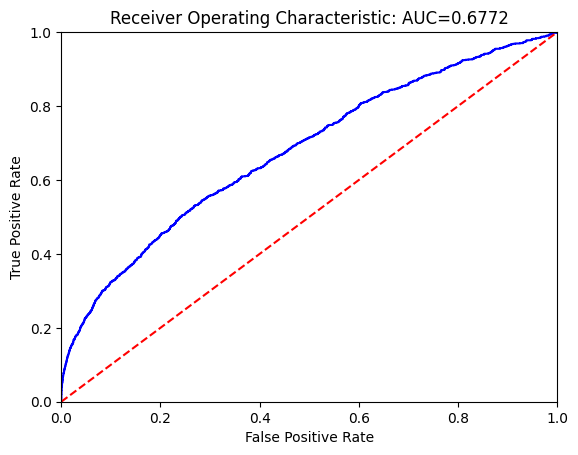

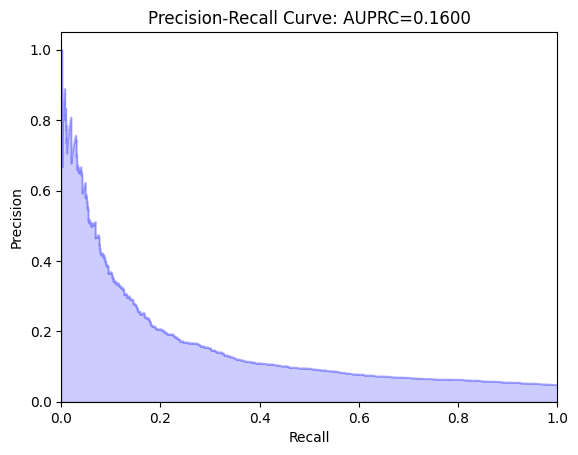

In [40]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 49.043081521987915 seconds
AUC: 0.6721712335394883
AUPRC: 0.14702102138953027
Sensitivity: 0.5704697986577181
Specificity: 0.6875775804449538
Score thresold: 0.06
2.5 97.5


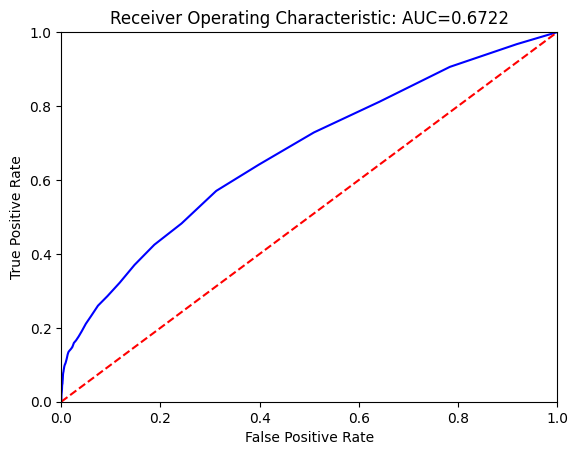

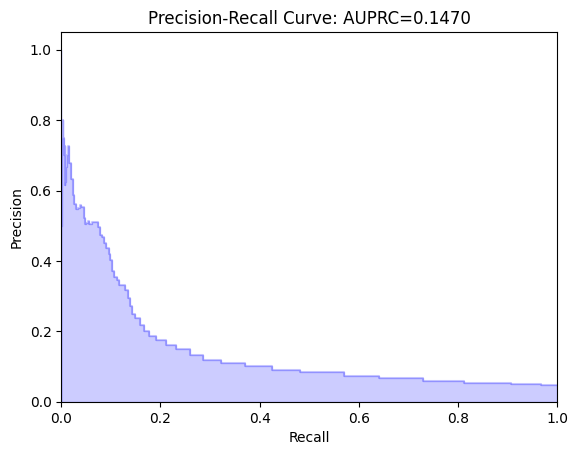

[0.08068068 0.01348029 0.02086088 0.0252741  0.03349942 0.00939044
 0.01347863 0.02067432 0.00112189 0.00207085 0.00411839 0.04197765
 0.02158661 0.00520304 0.00848588 0.00577737 0.00028924 0.00554151
 0.00271242 0.00392588 0.00298254 0.00201225 0.00297228 0.00269637
 0.00294647 0.00258491 0.00269879 0.00122613 0.0059896  0.0018298
 0.00170091 0.00404482 0.00531614 0.00266855 0.00138472 0.00270757
 0.00312809 0.00171985 0.00174909 0.00167413 0.00505352 0.00237651
 0.00237209 0.00284704 0.00646884 0.00417171 0.00357977 0.00099028
 0.00340654 0.00443154 0.0029921  0.00516757 0.00142369 0.00367176
 0.00559659 0.00508223 0.00317035 0.00621482 0.06498706 0.07555413
 0.03666804 0.03806081 0.07749437 0.07506156 0.09972278 0.03871938
 0.05053241]


In [41]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 43.8403205871582 seconds
AUC: 0.697718664595139
AUPRC: 0.1647360460537832
Sensitivity: 0.6164908916586769
Specificity: 0.6665234412298291
Score thresold: 0.0407371906906251
2.5 97.5


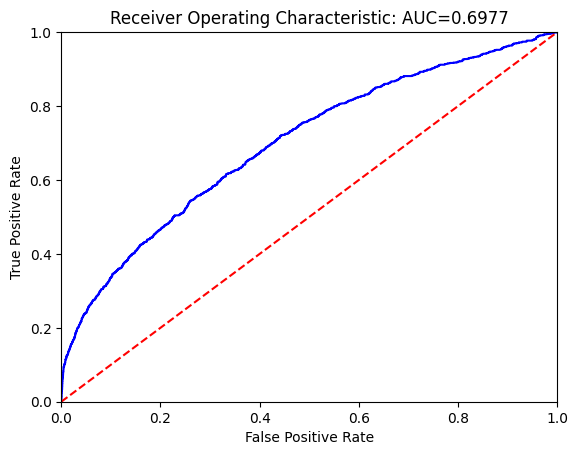

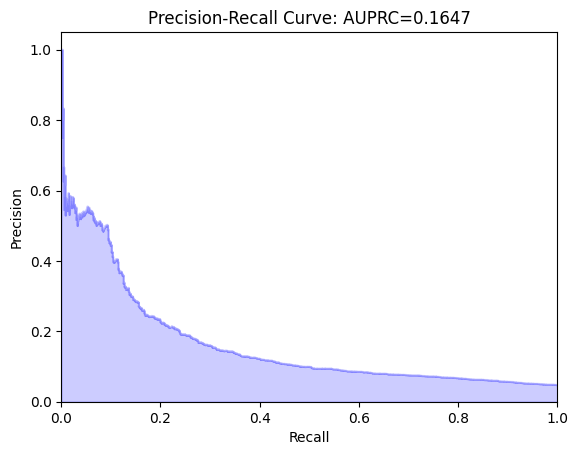

In [42]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [43]:
@register_keras_serializable()
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [44]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', metrics.AUC(name='auprc', curve='PR'),
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp.keras')

Epoch 1/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.5676 - Precision: 0.1617 - Recall: 0.0664 - TrueNegatives: 93466.0078 - TruePositives: 250.0947 - accuracy: 0.9267 - auprc: 0.0753 - loss: 1.0404
Epoch 2/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6277 - Precision: 0.4508 - Recall: 0.0487 - TrueNegatives: 94345.3203 - TruePositives: 229.1712 - accuracy: 0.9512 - auprc: 0.1289 - loss: 0.1933
Epoch 3/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.6167 - Precision: 0.4318 - Recall: 0.0443 - TrueNegatives: 94410.0391 - TruePositives: 199.2840 - accuracy: 0.9516 - auprc: 0.1216 - loss: 0.1932
Epoch 4/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6431 - Precision: 0.4821 - Recall: 0.0433 - TrueNegatives: 94434.1875 - TruePositives: 205.0141 - accuracy: 0.9522 - auprc: 0.1370 - loss: 0.1859
Epoch 5/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6396 - Precision: 0.4739 - Recall: 0.0445 - TrueNegatives: 94415.8984 - TruePositives: 210.7784 - accuracy: 0.9

MLP:
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC: 0.6941517378523179
AUPRC: 0.16224492223178522
Sensitivity: 0.6279961649089166
Specificity: 0.6596008784493459
Score thresold: 0.02660728
2.5 97.5


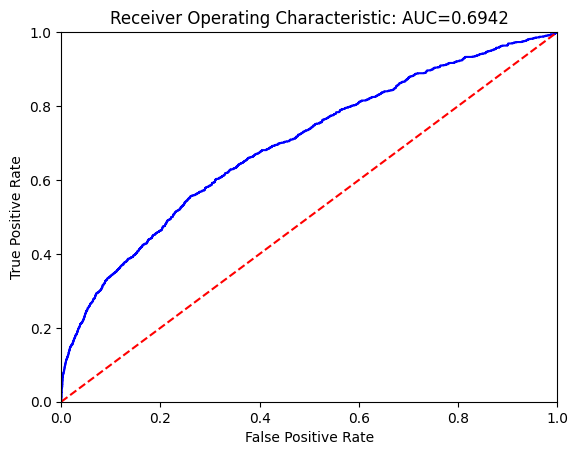

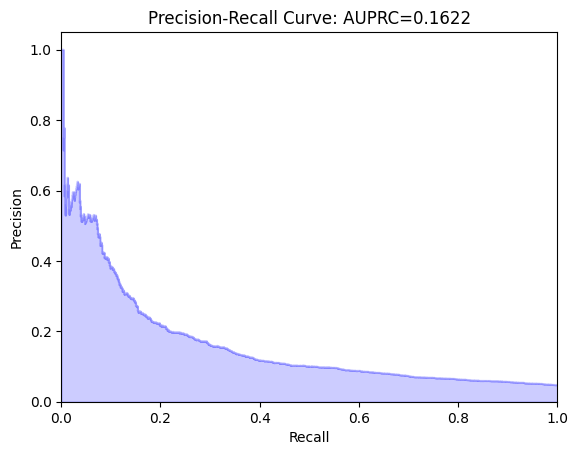

In [45]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [11]:
# Loading data for LSTM
resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [12]:
import importlib
import helpers
importlib.reload(helpers)
train_data_gen, test_data_gen = helpers.get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [33]:
@register_keras_serializable()
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
lstm = LSTM_MLP()
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', metrics.AUC(name='auprc', curve='PR'),
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

start = time.time()
lstm.fit(train_data_gen, batch_size=200, epochs=20, verbose=1)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('72h_ed_revisit_lstm.keras')

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


Epoch 1/20


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
I0000 00:00:1733250356.930221 3297571 service.cc:148] XLA service 0x7fe74c00f750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733250356.931074 3297571 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-12-03 13:25:57.039503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning

  1/992 ━━━━━━━━━━━━━━━━━━━━ 1:16:45 5s/step - AUC: 0.4168 - Precision: 0.0500 - Recall: 1.0000 - TrueNegatives: 0.0000e+00 - TruePositives: 10.0000 - accuracy: 0.0500 - auprc: 0.0425 - loss: 11.0954

I0000 00:00:1733250357.943871 3297571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  2/992 ━━━━━━━━━━━━━━━━━━━━ 11:19 687ms/step - AUC: 0.4828 - Precision: 0.0442 - Recall: 1.0000 - TrueNegatives: 4.5000 - TruePositives: 12.5000 - accuracy: 0.0550 - auprc: 0.0416 - loss: 9.1721    

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  3/992 ━━━━━━━━━━━━━━━━━━━━ 12:24 753ms/step - AUC: 0.4943 - Precision: 0.0421 - Recall: 0.8841 - TrueNegatives: 69.0000 - TruePositives: 13.3333 - accuracy: 0.1550 - auprc: 0.0411 - loss: 7.7533

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  4/992 ━━━━━━━━━━━━━━━━━━━━ 12:22 752ms/step - AUC: 0.4970 - Precision: 0.0411 - Recall: 0.7802 - TrueNegatives: 149.0000 - TruePositives: 13.7500 - accuracy: 0.2425 - auprc: 0.0409 - loss: 6.7708

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  5/992 ━━━━━━━━━━━━━━━━━━━━ 12:37 767ms/step - AUC: 0.4905 - Precision: 0.0405 - Recall: 0.6880 - TrueNegatives: 234.0000 - TruePositives: 14.0000 - accuracy: 0.3118 - auprc: 0.0413 - loss: 6.0881

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  6/992 ━━━━━━━━━━━━━━━━━━━━ 12:29 760ms/step - AUC: 0.4855 - Precision: 0.0401 - Recall: 0.6157 - TrueNegatives: 322.0000 - TruePositives: 14.1667 - accuracy: 0.3677 - auprc: 0.0417 - loss: 5.5768

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  9/992 ━━━━━━━━━━━━━━━━━━━━ 10:12 623ms/step - AUC: 0.4803 - Precision: 0.0394 - Recall: 0.4736 - TrueNegatives: 595.0000 - TruePositives: 14.4444 - accuracy: 0.4852 - auprc: 0.0429 - loss: 4.5926

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 10/992 ━━━━━━━━━━━━━━━━━━━━ 10:50 663ms/step - AUC: 0.4797 - Precision: 0.0393 - Recall: 0.4410 - TrueNegatives: 687.4000 - TruePositives: 14.5000 - accuracy: 0.5134 - auprc: 0.0433 - loss: 4.3689

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 11/992 ━━━━━━━━━━━━━━━━━━━━ 11:07 680ms/step - AUC: 0.4794 - Precision: 0.0392 - Recall: 0.4130 - TrueNegatives: 780.1818 - TruePositives: 14.5455 - accuracy: 0.5379 - auprc: 0.0437 - loss: 4.1792

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 12/992 ━━━━━━━━━━━━━━━━━━━━ 11:23 697ms/step - AUC: 0.4795 - Precision: 0.0391 - Recall: 0.3888 - TrueNegatives: 873.4167 - TruePositives: 14.5833 - accuracy: 0.5595 - auprc: 0.0440 - loss: 4.0165

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 13/992 ━━━━━━━━━━━━━━━━━━━━ 11:20 695ms/step - AUC: 0.4796 - Precision: 0.0390 - Recall: 0.3676 - TrueNegatives: 966.8461 - TruePositives: 14.6154 - accuracy: 0.5787 - auprc: 0.0442 - loss: 3.8755

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 14/992 ━━━━━━━━━━━━━━━━━━━━ 11:30 706ms/step - AUC: 0.4801 - Precision: 0.0389 - Recall: 0.3490 - TrueNegatives: 1060.7858 - TruePositives: 14.6429 - accuracy: 0.5960 - auprc: 0.0444 - loss: 3.7515

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 18/992 ━━━━━━━━━━━━━━━━━━━━ 9:44 600ms/step - AUC: 0.4826 - Precision: 0.0388 - Recall: 0.2925 - TrueNegatives: 1438.8334 - TruePositives: 14.7222 - accuracy: 0.6504 - auprc: 0.0448 - loss: 3.3785 

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 19/992 ━━━━━━━━━━━━━━━━━━━━ 9:30 587ms/step - AUC: 0.4832 - Precision: 0.0387 - Recall: 0.2815 - TrueNegatives: 1533.6842 - TruePositives: 14.7368 - accuracy: 0.6613 - auprc: 0.0449 - loss: 3.3066

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 20/992 ━━━━━━━━━━━━━━━━━━━━ 9:18 575ms/step - AUC: 0.4838 - Precision: 0.0387 - Recall: 0.2712 - TrueNegatives: 1628.2000 - TruePositives: 14.7500 - accuracy: 0.6712 - auprc: 0.0450 - loss: 3.2425

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 21/992 ━━━━━━━━━━━━━━━━━━━━ 9:48 606ms/step - AUC: 0.4844 - Precision: 0.0387 - Recall: 0.2618 - TrueNegatives: 1722.9048 - TruePositives: 14.7619 - accuracy: 0.6804 - auprc: 0.0451 - loss: 3.1817

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 24/992 ━━━━━━━━━━━━━━━━━━━━ 9:08 567ms/step - AUC: 0.4859 - Precision: 0.0386 - Recall: 0.2375 - TrueNegatives: 2007.2084 - TruePositives: 14.7917 - accuracy: 0.7044 - auprc: 0.0454 - loss: 3.0240

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 26/992 ━━━━━━━━━━━━━━━━━━━━ 9:01 561ms/step - AUC: 0.4868 - Precision: 0.0385 - Recall: 0.2239 - TrueNegatives: 2196.8845 - TruePositives: 14.8077 - accuracy: 0.7179 - auprc: 0.0456 - loss: 2.9355

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 28/992 ━━━━━━━━━━━━━━━━━━━━ 8:33 532ms/step - AUC: 0.4875 - Precision: 0.0385 - Recall: 0.2119 - TrueNegatives: 2386.8215 - TruePositives: 14.8214 - accuracy: 0.7299 - auprc: 0.0457 - loss: 2.8583

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 30/992 ━━━━━━━━━━━━━━━━━━━━ 8:31 532ms/step - AUC: 0.4879 - Precision: 0.0385 - Recall: 0.2011 - TrueNegatives: 2575.7000 - TruePositives: 14.8333 - accuracy: 0.7404 - auprc: 0.0459 - loss: 2.7943

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 34/992 ━━━━━━━━━━━━━━━━━━━━ 8:03 504ms/step - AUC: 0.4887 - Precision: 0.0384 - Recall: 0.1828 - TrueNegatives: 2954.1470 - TruePositives: 14.8529 - accuracy: 0.7584 - auprc: 0.0463 - loss: 2.6776

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 35/992 ━━━━━━━━━━━━━━━━━━━━ 7:58 500ms/step - AUC: 0.4888 - Precision: 0.0384 - Recall: 0.1788 - TrueNegatives: 3048.8000 - TruePositives: 14.8571 - accuracy: 0.7623 - auprc: 0.0464 - loss: 2.6504

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 36/992 ━━━━━━━━━━━━━━━━━━━━ 7:54 497ms/step - AUC: 0.4889 - Precision: 0.0384 - Recall: 0.1750 - TrueNegatives: 3143.6943 - TruePositives: 14.8611 - accuracy: 0.7662 - auprc: 0.0464 - loss: 2.6235

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 37/992 ━━━━━━━━━━━━━━━━━━━━ 7:51 494ms/step - AUC: 0.4891 - Precision: 0.0384 - Recall: 0.1714 - TrueNegatives: 3238.6487 - TruePositives: 14.8649 - accuracy: 0.7698 - auprc: 0.0464 - loss: 2.5971

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 38/992 ━━━━━━━━━━━━━━━━━━━━ 7:47 490ms/step - AUC: 0.4893 - Precision: 0.0384 - Recall: 0.1679 - TrueNegatives: 3333.5527 - TruePositives: 14.8684 - accuracy: 0.7733 - auprc: 0.0465 - loss: 2.5713

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 39/992 ━━━━━━━━━━━━━━━━━━━━ 7:43 486ms/step - AUC: 0.4895 - Precision: 0.0384 - Recall: 0.1646 - TrueNegatives: 3428.4102 - TruePositives: 14.8718 - accuracy: 0.7767 - auprc: 0.0465 - loss: 2.5461

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 40/992 ━━━━━━━━━━━━━━━━━━━━ 7:40 484ms/step - AUC: 0.4895 - Precision: 0.0384 - Recall: 0.1615 - TrueNegatives: 3523.4500 - TruePositives: 14.8750 - accuracy: 0.7799 - auprc: 0.0465 - loss: 2.5213

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 41/992 ━━━━━━━━━━━━━━━━━━━━ 7:36 480ms/step - AUC: 0.4897 - Precision: 0.0386 - Recall: 0.1587 - TrueNegatives: 3618.0977 - TruePositives: 15.0000 - accuracy: 0.7829 - auprc: 0.0466 - loss: 2.4970

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 42/992 ━━━━━━━━━━━━━━━━━━━━ 7:50 495ms/step - AUC: 0.4899 - Precision: 0.0389 - Recall: 0.1561 - TrueNegatives: 3712.7856 - TruePositives: 15.1190 - accuracy: 0.7859 - auprc: 0.0467 - loss: 2.4732

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 43/992 ━━━━━━━━━━━━━━━━━━━━ 7:56 502ms/step - AUC: 0.4901 - Precision: 0.0392 - Recall: 0.1536 - TrueNegatives: 3807.4419 - TruePositives: 15.2558 - accuracy: 0.7887 - auprc: 0.0468 - loss: 2.4498

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 46/992 ━━━━━━━━━━━━━━━━━━━━ 7:41 488ms/step - AUC: 0.4900 - Precision: 0.0399 - Recall: 0.1468 - TrueNegatives: 4090.3914 - TruePositives: 15.6957 - accuracy: 0.7965 - auprc: 0.0468 - loss: 2.3828

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 49/992 ━━━━━━━━━━━━━━━━━━━━ 7:21 468ms/step - AUC: 0.4896 - Precision: 0.0407 - Recall: 0.1409 - TrueNegatives: 4373.6328 - TruePositives: 16.1429 - accuracy: 0.8034 - auprc: 0.0468 - loss: 2.3197

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 50/992 ━━━━━━━━━━━━━━━━━━━━ 7:20 468ms/step - AUC: 0.4895 - Precision: 0.0409 - Recall: 0.1390 - TrueNegatives: 4468.0801 - TruePositives: 16.2800 - accuracy: 0.8056 - auprc: 0.0467 - loss: 2.2995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 51/992 ━━━━━━━━━━━━━━━━━━━━ 7:18 466ms/step - AUC: 0.4893 - Precision: 0.0411 - Recall: 0.1371 - TrueNegatives: 4562.4512 - TruePositives: 16.4118 - accuracy: 0.8077 - auprc: 0.0467 - loss: 2.2798

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 52/992 ━━━━━━━━━━━━━━━━━━━━ 7:17 466ms/step - AUC: 0.4892 - Precision: 0.0414 - Recall: 0.1354 - TrueNegatives: 4656.9229 - TruePositives: 16.5385 - accuracy: 0.8097 - auprc: 0.0467 - loss: 2.2605

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 53/992 ━━━━━━━━━━━━━━━━━━━━ 7:16 465ms/step - AUC: 0.4891 - Precision: 0.0416 - Recall: 0.1337 - TrueNegatives: 4751.3960 - TruePositives: 16.6604 - accuracy: 0.8117 - auprc: 0.0467 - loss: 2.2415

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 54/992 ━━━━━━━━━━━━━━━━━━━━ 7:14 463ms/step - AUC: 0.4890 - Precision: 0.0418 - Recall: 0.1320 - TrueNegatives: 4845.8521 - TruePositives: 16.7778 - accuracy: 0.8136 - auprc: 0.0467 - loss: 2.2230

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 55/992 ━━━━━━━━━━━━━━━━━━━━ 7:11 461ms/step - AUC: 0.4889 - Precision: 0.0420 - Recall: 0.1304 - TrueNegatives: 4940.3091 - TruePositives: 16.8909 - accuracy: 0.8154 - auprc: 0.0467 - loss: 2.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 56/992 ━━━━━━━━━━━━━━━━━━━━ 7:09 459ms/step - AUC: 0.4888 - Precision: 0.0422 - Recall: 0.1288 - TrueNegatives: 5034.8213 - TruePositives: 17.0000 - accuracy: 0.8172 - auprc: 0.0467 - loss: 2.1869

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 57/992 ━━━━━━━━━━━━━━━━━━━━ 7:07 457ms/step - AUC: 0.4886 - Precision: 0.0423 - Recall: 0.1272 - TrueNegatives: 5129.4209 - TruePositives: 17.1053 - accuracy: 0.8190 - auprc: 0.0467 - loss: 2.1694

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 58/992 ━━━━━━━━━━━━━━━━━━━━ 7:05 456ms/step - AUC: 0.4885 - Precision: 0.0425 - Recall: 0.1258 - TrueNegatives: 5224.1377 - TruePositives: 17.2069 - accuracy: 0.8207 - auprc: 0.0467 - loss: 2.1521

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 59/992 ━━━━━━━━━━━━━━━━━━━━ 7:05 456ms/step - AUC: 0.4883 - Precision: 0.0427 - Recall: 0.1243 - TrueNegatives: 5318.8984 - TruePositives: 17.3051 - accuracy: 0.8223 - auprc: 0.0467 - loss: 2.1351

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 60/992 ━━━━━━━━━━━━━━━━━━━━ 7:05 456ms/step - AUC: 0.4881 - Precision: 0.0428 - Recall: 0.1229 - TrueNegatives: 5413.7334 - TruePositives: 17.4000 - accuracy: 0.8240 - auprc: 0.0466 - loss: 2.1185

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 61/992 ━━━━━━━━━━━━━━━━━━━━ 7:03 455ms/step - AUC: 0.4881 - Precision: 0.0430 - Recall: 0.1215 - TrueNegatives: 5508.0981 - TruePositives: 17.4918 - accuracy: 0.8255 - auprc: 0.0467 - loss: 2.1022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 62/992 ━━━━━━━━━━━━━━━━━━━━ 7:02 454ms/step - AUC: 0.4880 - Precision: 0.0431 - Recall: 0.1202 - TrueNegatives: 5602.5161 - TruePositives: 17.5806 - accuracy: 0.8270 - auprc: 0.0467 - loss: 2.0862

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 63/992 ━━━━━━━━━━━━━━━━━━━━ 7:00 453ms/step - AUC: 0.4880 - Precision: 0.0432 - Recall: 0.1188 - TrueNegatives: 5696.9683 - TruePositives: 17.6667 - accuracy: 0.8284 - auprc: 0.0467 - loss: 2.0705

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 64/992 ━━━━━━━━━━━━━━━━━━━━ 6:59 452ms/step - AUC: 0.4880 - Precision: 0.0434 - Recall: 0.1176 - TrueNegatives: 5791.5156 - TruePositives: 17.7500 - accuracy: 0.8299 - auprc: 0.0467 - loss: 2.0551

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 65/992 ━━━━━━━━━━━━━━━━━━━━ 6:57 450ms/step - AUC: 0.4879 - Precision: 0.0435 - Recall: 0.1163 - TrueNegatives: 5886.1230 - TruePositives: 17.8308 - accuracy: 0.8313 - auprc: 0.0467 - loss: 2.0399

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 66/992 ━━━━━━━━━━━━━━━━━━━━ 6:55 449ms/step - AUC: 0.4878 - Precision: 0.0436 - Recall: 0.1151 - TrueNegatives: 5980.8335 - TruePositives: 17.9091 - accuracy: 0.8326 - auprc: 0.0467 - loss: 2.0250

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 70/992 ━━━━━━━━━━━━━━━━━━━━ 6:51 446ms/step - AUC: 0.4876 - Precision: 0.0440 - Recall: 0.1105 - TrueNegatives: 6359.4429 - TruePositives: 18.2000 - accuracy: 0.8377 - auprc: 0.0467 - loss: 1.9679

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 71/992 ━━━━━━━━━━━━━━━━━━━━ 6:50 446ms/step - AUC: 0.4879 - Precision: 0.0446 - Recall: 0.1098 - TrueNegatives: 6453.0425 - TruePositives: 18.5634 - accuracy: 0.8389 - auprc: 0.0469 - loss: 1.9543

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 73/992 ━━━━━━━━━━━━━━━━━━━━ 6:56 453ms/step - AUC: 0.4884 - Precision: 0.0458 - Recall: 0.1084 - TrueNegatives: 6640.5479 - TruePositives: 19.2603 - accuracy: 0.8411 - auprc: 0.0471 - loss: 1.9278

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 75/992 ━━━━━━━━━━━━━━━━━━━━ 6:54 452ms/step - AUC: 0.4890 - Precision: 0.0469 - Recall: 0.1071 - TrueNegatives: 6828.4136 - TruePositives: 19.9200 - accuracy: 0.8432 - auprc: 0.0473 - loss: 1.9022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 78/992 ━━━━━━━━━━━━━━━━━━━━ 6:41 439ms/step - AUC: 0.4906 - Precision: 0.0499 - Recall: 0.1062 - TrueNegatives: 7108.8716 - TruePositives: 21.7692 - accuracy: 0.8462 - auprc: 0.0480 - loss: 1.8653

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 79/992 ━━━━━━━━━━━━━━━━━━━━ 6:39 438ms/step - AUC: 0.4910 - Precision: 0.0508 - Recall: 0.1059 - TrueNegatives: 7202.3672 - TruePositives: 22.3544 - accuracy: 0.8472 - auprc: 0.0482 - loss: 1.8535

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 80/992 ━━━━━━━━━━━━━━━━━━━━ 6:38 437ms/step - AUC: 0.4915 - Precision: 0.0518 - Recall: 0.1056 - TrueNegatives: 7295.9248 - TruePositives: 22.9250 - accuracy: 0.8481 - auprc: 0.0483 - loss: 1.8418

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 81/992 ━━━━━━━━━━━━━━━━━━━━ 6:37 436ms/step - AUC: 0.4919 - Precision: 0.0527 - Recall: 0.1053 - TrueNegatives: 7389.5679 - TruePositives: 23.4815 - accuracy: 0.8490 - auprc: 0.0485 - loss: 1.8303

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 82/992 ━━━━━━━━━━━━━━━━━━━━ 6:36 435ms/step - AUC: 0.4923 - Precision: 0.0536 - Recall: 0.1050 - TrueNegatives: 7483.1953 - TruePositives: 24.0244 - accuracy: 0.8499 - auprc: 0.0487 - loss: 1.8190

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 83/992 ━━━━━━━━━━━━━━━━━━━━ 6:34 434ms/step - AUC: 0.4927 - Precision: 0.0544 - Recall: 0.1046 - TrueNegatives: 7576.8555 - TruePositives: 24.5542 - accuracy: 0.8508 - auprc: 0.0489 - loss: 1.8079

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 84/992 ━━━━━━━━━━━━━━━━━━━━ 6:33 434ms/step - AUC: 0.4931 - Precision: 0.0552 - Recall: 0.1043 - TrueNegatives: 7670.4165 - TruePositives: 25.0833 - accuracy: 0.8517 - auprc: 0.0491 - loss: 1.7970

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 85/992 ━━━━━━━━━━━━━━━━━━━━ 6:32 433ms/step - AUC: 0.4935 - Precision: 0.0560 - Recall: 0.1040 - TrueNegatives: 7764.0586 - TruePositives: 25.6000 - accuracy: 0.8525 - auprc: 0.0492 - loss: 1.7862

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 86/992 ━━━━━━━━━━━━━━━━━━━━ 6:31 432ms/step - AUC: 0.4939 - Precision: 0.0568 - Recall: 0.1037 - TrueNegatives: 7857.7905 - TruePositives: 26.1047 - accuracy: 0.8534 - auprc: 0.0494 - loss: 1.7755

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 87/992 ━━━━━━━━━━━━━━━━━━━━ 6:30 431ms/step - AUC: 0.4942 - Precision: 0.0576 - Recall: 0.1034 - TrueNegatives: 7951.5288 - TruePositives: 26.5977 - accuracy: 0.8542 - auprc: 0.0496 - loss: 1.7651

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 88/992 ━━━━━━━━━━━━━━━━━━━━ 6:30 432ms/step - AUC: 0.4946 - Precision: 0.0584 - Recall: 0.1031 - TrueNegatives: 8045.2046 - TruePositives: 27.0795 - accuracy: 0.8550 - auprc: 0.0497 - loss: 1.7548

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 89/992 ━━━━━━━━━━━━━━━━━━━━ 6:31 433ms/step - AUC: 0.4949 - Precision: 0.0591 - Recall: 0.1028 - TrueNegatives: 8138.9326 - TruePositives: 27.5506 - accuracy: 0.8558 - auprc: 0.0499 - loss: 1.7447

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 90/992 ━━━━━━━━━━━━━━━━━━━━ 6:29 432ms/step - AUC: 0.4953 - Precision: 0.0598 - Recall: 0.1024 - TrueNegatives: 8232.6113 - TruePositives: 28.0111 - accuracy: 0.8565 - auprc: 0.0500 - loss: 1.7347

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 91/992 ━━━━━━━━━━━━━━━━━━━━ 6:28 432ms/step - AUC: 0.4956 - Precision: 0.0606 - Recall: 0.1021 - TrueNegatives: 8326.3076 - TruePositives: 28.4615 - accuracy: 0.8573 - auprc: 0.0502 - loss: 1.7249

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 92/992 ━━━━━━━━━━━━━━━━━━━━ 6:28 431ms/step - AUC: 0.4959 - Precision: 0.0612 - Recall: 0.1018 - TrueNegatives: 8420.0215 - TruePositives: 28.9022 - accuracy: 0.8580 - auprc: 0.0503 - loss: 1.7153

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 93/992 ━━━━━━━━━━━━━━━━━━━━ 6:27 431ms/step - AUC: 0.4962 - Precision: 0.0619 - Recall: 0.1014 - TrueNegatives: 8513.7852 - TruePositives: 29.3333 - accuracy: 0.8587 - auprc: 0.0505 - loss: 1.7057

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 94/992 ━━━━━━━━━━━━━━━━━━━━ 6:25 429ms/step - AUC: 0.4965 - Precision: 0.0626 - Recall: 0.1011 - TrueNegatives: 8607.5850 - TruePositives: 29.7553 - accuracy: 0.8594 - auprc: 0.0506 - loss: 1.6963

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 95/992 ━━━━━━━━━━━━━━━━━━━━ 6:24 428ms/step - AUC: 0.4968 - Precision: 0.0632 - Recall: 0.1008 - TrueNegatives: 8701.4102 - TruePositives: 30.1684 - accuracy: 0.8601 - auprc: 0.0507 - loss: 1.6871

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 96/992 ━━━━━━━━━━━━━━━━━━━━ 6:22 427ms/step - AUC: 0.4970 - Precision: 0.0639 - Recall: 0.1004 - TrueNegatives: 8795.2500 - TruePositives: 30.5729 - accuracy: 0.8608 - auprc: 0.0508 - loss: 1.6780

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 97/992 ━━━━━━━━━━━━━━━━━━━━ 6:21 427ms/step - AUC: 0.4973 - Precision: 0.0645 - Recall: 0.1001 - TrueNegatives: 8889.1133 - TruePositives: 30.9691 - accuracy: 0.8615 - auprc: 0.0510 - loss: 1.6690

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 98/992 ━━━━━━━━━━━━━━━━━━━━ 6:20 426ms/step - AUC: 0.4976 - Precision: 0.0651 - Recall: 0.0998 - TrueNegatives: 8983.0000 - TruePositives: 31.3571 - accuracy: 0.8622 - auprc: 0.0511 - loss: 1.6601

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 99/992 ━━━━━━━━━━━━━━━━━━━━ 6:19 425ms/step - AUC: 0.4978 - Precision: 0.0657 - Recall: 0.0994 - TrueNegatives: 9076.9492 - TruePositives: 31.7374 - accuracy: 0.8628 - auprc: 0.0512 - loss: 1.6513

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


100/992 ━━━━━━━━━━━━━━━━━━━━ 6:18 424ms/step - AUC: 0.4981 - Precision: 0.0663 - Recall: 0.0991 - TrueNegatives: 9170.8701 - TruePositives: 32.1200 - accuracy: 0.8634 - auprc: 0.0513 - loss: 1.6427

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


101/992 ━━━━━━━━━━━━━━━━━━━━ 6:17 423ms/step - AUC: 0.4983 - Precision: 0.0669 - Recall: 0.0988 - TrueNegatives: 9264.8115 - TruePositives: 32.4950 - accuracy: 0.8641 - auprc: 0.0514 - loss: 1.6342

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


102/992 ━━━━━━━━━━━━━━━━━━━━ 6:16 423ms/step - AUC: 0.4986 - Precision: 0.0675 - Recall: 0.0985 - TrueNegatives: 9358.7646 - TruePositives: 32.8627 - accuracy: 0.8647 - auprc: 0.0516 - loss: 1.6258

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


103/992 ━━━━━━━━━━━━━━━━━━━━ 6:15 422ms/step - AUC: 0.4988 - Precision: 0.0680 - Recall: 0.0981 - TrueNegatives: 9452.7861 - TruePositives: 33.2233 - accuracy: 0.8653 - auprc: 0.0517 - loss: 1.6175

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


104/992 ━━━━━━━━━━━━━━━━━━━━ 6:14 421ms/step - AUC: 0.4990 - Precision: 0.0686 - Recall: 0.0978 - TrueNegatives: 9546.8652 - TruePositives: 33.5769 - accuracy: 0.8659 - auprc: 0.0518 - loss: 1.6093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


105/992 ━━━━━━━━━━━━━━━━━━━━ 6:13 421ms/step - AUC: 0.4992 - Precision: 0.0691 - Recall: 0.0975 - TrueNegatives: 9640.9805 - TruePositives: 33.9238 - accuracy: 0.8665 - auprc: 0.0519 - loss: 1.6012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


106/992 ━━━━━━━━━━━━━━━━━━━━ 6:12 420ms/step - AUC: 0.4994 - Precision: 0.0697 - Recall: 0.0972 - TrueNegatives: 9735.1230 - TruePositives: 34.2642 - accuracy: 0.8671 - auprc: 0.0520 - loss: 1.5932

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


107/992 ━━━━━━━━━━━━━━━━━━━━ 6:12 421ms/step - AUC: 0.4996 - Precision: 0.0702 - Recall: 0.0969 - TrueNegatives: 9829.2900 - TruePositives: 34.5981 - accuracy: 0.8677 - auprc: 0.0520 - loss: 1.5853

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


108/992 ━━━━━━━━━━━━━━━━━━━━ 6:12 421ms/step - AUC: 0.4998 - Precision: 0.0707 - Recall: 0.0966 - TrueNegatives: 9923.5088 - TruePositives: 34.9259 - accuracy: 0.8683 - auprc: 0.0521 - loss: 1.5776

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


109/992 ━━━━━━━━━━━━━━━━━━━━ 6:11 421ms/step - AUC: 0.5000 - Precision: 0.0712 - Recall: 0.0963 - TrueNegatives: 10017.7158 - TruePositives: 35.2477 - accuracy: 0.8688 - auprc: 0.0522 - loss: 1.5699

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


110/992 ━━━━━━━━━━━━━━━━━━━━ 6:11 421ms/step - AUC: 0.5001 - Precision: 0.0717 - Recall: 0.0959 - TrueNegatives: 10112.0088 - TruePositives: 35.5636 - accuracy: 0.8694 - auprc: 0.0523 - loss: 1.5623

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


111/992 ━━━━━━━━━━━━━━━━━━━━ 6:10 420ms/step - AUC: 0.5003 - Precision: 0.0722 - Recall: 0.0956 - TrueNegatives: 10206.3242 - TruePositives: 35.8739 - accuracy: 0.8699 - auprc: 0.0524 - loss: 1.5548

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


112/992 ━━━━━━━━━━━━━━━━━━━━ 6:09 420ms/step - AUC: 0.5005 - Precision: 0.0727 - Recall: 0.0953 - TrueNegatives: 10300.6426 - TruePositives: 36.1786 - accuracy: 0.8705 - auprc: 0.0525 - loss: 1.5473

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


113/992 ━━━━━━━━━━━━━━━━━━━━ 6:08 419ms/step - AUC: 0.5006 - Precision: 0.0732 - Recall: 0.0950 - TrueNegatives: 10394.9561 - TruePositives: 36.4779 - accuracy: 0.8710 - auprc: 0.0525 - loss: 1.5400

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


114/992 ━━━━━━━━━━━━━━━━━━━━ 6:07 419ms/step - AUC: 0.5008 - Precision: 0.0736 - Recall: 0.0947 - TrueNegatives: 10489.2539 - TruePositives: 36.7719 - accuracy: 0.8715 - auprc: 0.0526 - loss: 1.5328

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


115/992 ━━━━━━━━━━━━━━━━━━━━ 6:06 418ms/step - AUC: 0.5010 - Precision: 0.0741 - Recall: 0.0944 - TrueNegatives: 10583.5742 - TruePositives: 37.0609 - accuracy: 0.8720 - auprc: 0.0527 - loss: 1.5257

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


116/992 ━━━━━━━━━━━━━━━━━━━━ 6:05 417ms/step - AUC: 0.5011 - Precision: 0.0745 - Recall: 0.0941 - TrueNegatives: 10677.9053 - TruePositives: 37.3448 - accuracy: 0.8725 - auprc: 0.0528 - loss: 1.5186

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


117/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 416ms/step - AUC: 0.5013 - Precision: 0.0750 - Recall: 0.0938 - TrueNegatives: 10772.1455 - TruePositives: 37.6667 - accuracy: 0.8730 - auprc: 0.0529 - loss: 1.5117

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


118/992 ━━━━━━━━━━━━━━━━━━━━ 6:07 420ms/step - AUC: 0.5015 - Precision: 0.0755 - Recall: 0.0936 - TrueNegatives: 10866.3896 - TruePositives: 37.9831 - accuracy: 0.8735 - auprc: 0.0529 - loss: 1.5048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


120/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 415ms/step - AUC: 0.5019 - Precision: 0.0766 - Recall: 0.0931 - TrueNegatives: 11054.8164 - TruePositives: 38.6667 - accuracy: 0.8745 - auprc: 0.0531 - loss: 1.4913

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


122/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 410ms/step - AUC: 0.5022 - Precision: 0.0776 - Recall: 0.0926 - TrueNegatives: 11243.3770 - TruePositives: 39.3279 - accuracy: 0.8754 - auprc: 0.0533 - loss: 1.4781

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


123/992 ━━━━━━━━━━━━━━━━━━━━ 5:55 409ms/step - AUC: 0.5024 - Precision: 0.0781 - Recall: 0.0923 - TrueNegatives: 11337.7070 - TruePositives: 39.6504 - accuracy: 0.8759 - auprc: 0.0534 - loss: 1.4716

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


124/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 413ms/step - AUC: 0.5026 - Precision: 0.0786 - Recall: 0.0921 - TrueNegatives: 11432.0811 - TruePositives: 39.9677 - accuracy: 0.8763 - auprc: 0.0535 - loss: 1.4652

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


126/992 ━━━━━━━━━━━━━━━━━━━━ 5:53 408ms/step - AUC: 0.5029 - Precision: 0.0796 - Recall: 0.0916 - TrueNegatives: 11620.9043 - TruePositives: 40.5873 - accuracy: 0.8772 - auprc: 0.0536 - loss: 1.4526

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


128/992 ━━━━━━━━━━━━━━━━━━━━ 5:49 405ms/step - AUC: 0.5032 - Precision: 0.0806 - Recall: 0.0912 - TrueNegatives: 11809.5781 - TruePositives: 41.3047 - accuracy: 0.8781 - auprc: 0.0538 - loss: 1.4402

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


129/992 ━━━━━━━━━━━━━━━━━━━━ 5:48 404ms/step - AUC: 0.5034 - Precision: 0.0813 - Recall: 0.0910 - TrueNegatives: 11903.7910 - TruePositives: 41.7132 - accuracy: 0.8785 - auprc: 0.0539 - loss: 1.4342

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


130/992 ━━━━━━━━━━━━━━━━━━━━ 5:47 403ms/step - AUC: 0.5037 - Precision: 0.0818 - Recall: 0.0909 - TrueNegatives: 11998.0156 - TruePositives: 42.1154 - accuracy: 0.8789 - auprc: 0.0540 - loss: 1.4282

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


134/992 ━━━━━━━━━━━━━━━━━━━━ 5:43 401ms/step - AUC: 0.5045 - Precision: 0.0842 - Recall: 0.0902 - TrueNegatives: 12375.0898 - TruePositives: 43.6866 - accuracy: 0.8805 - auprc: 0.0544 - loss: 1.4048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


135/992 ━━━━━━━━━━━━━━━━━━━━ 5:42 400ms/step - AUC: 0.5047 - Precision: 0.0848 - Recall: 0.0900 - TrueNegatives: 12469.3184 - TruePositives: 44.0741 - accuracy: 0.8809 - auprc: 0.0545 - loss: 1.3992

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


136/992 ━━━━━━━━━━━━━━━━━━━━ 5:41 399ms/step - AUC: 0.5049 - Precision: 0.0853 - Recall: 0.0899 - TrueNegatives: 12563.6104 - TruePositives: 44.4559 - accuracy: 0.8813 - auprc: 0.0546 - loss: 1.3936

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


137/992 ━━━━━━━━━━━━━━━━━━━━ 5:40 398ms/step - AUC: 0.5051 - Precision: 0.0859 - Recall: 0.0897 - TrueNegatives: 12657.8682 - TruePositives: 44.8321 - accuracy: 0.8817 - auprc: 0.0547 - loss: 1.3880

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


138/992 ━━━━━━━━━━━━━━━━━━━━ 5:38 397ms/step - AUC: 0.5052 - Precision: 0.0864 - Recall: 0.0896 - TrueNegatives: 12752.1592 - TruePositives: 45.2029 - accuracy: 0.8821 - auprc: 0.0548 - loss: 1.3825

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


139/992 ━━━━━━━━━━━━━━━━━━━━ 5:37 396ms/step - AUC: 0.5054 - Precision: 0.0869 - Recall: 0.0894 - TrueNegatives: 12846.4824 - TruePositives: 45.5683 - accuracy: 0.8824 - auprc: 0.0549 - loss: 1.3771

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


140/992 ━━━━━━━━━━━━━━━━━━━━ 5:36 395ms/step - AUC: 0.5056 - Precision: 0.0875 - Recall: 0.0892 - TrueNegatives: 12940.8496 - TruePositives: 45.9286 - accuracy: 0.8828 - auprc: 0.0550 - loss: 1.3717

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


143/992 ━━━━━━━━━━━━━━━━━━━━ 5:34 394ms/step - AUC: 0.5061 - Precision: 0.0890 - Recall: 0.0887 - TrueNegatives: 13224.0137 - TruePositives: 46.9790 - accuracy: 0.8839 - auprc: 0.0553 - loss: 1.3559

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


144/992 ━━━━━━━━━━━━━━━━━━━━ 5:32 392ms/step - AUC: 0.5063 - Precision: 0.0895 - Recall: 0.0886 - TrueNegatives: 13318.3057 - TruePositives: 47.3542 - accuracy: 0.8842 - auprc: 0.0554 - loss: 1.3507

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


145/992 ━━━━━━━━━━━━━━━━━━━━ 5:31 391ms/step - AUC: 0.5065 - Precision: 0.0901 - Recall: 0.0885 - TrueNegatives: 13412.6211 - TruePositives: 47.7241 - accuracy: 0.8846 - auprc: 0.0554 - loss: 1.3456

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


146/992 ━━━━━━━━━━━━━━━━━━━━ 5:30 391ms/step - AUC: 0.5067 - Precision: 0.0906 - Recall: 0.0883 - TrueNegatives: 13506.9453 - TruePositives: 48.0890 - accuracy: 0.8849 - auprc: 0.0555 - loss: 1.3406

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


147/992 ━━━━━━━━━━━━━━━━━━━━ 5:29 390ms/step - AUC: 0.5068 - Precision: 0.0911 - Recall: 0.0882 - TrueNegatives: 13601.3193 - TruePositives: 48.4490 - accuracy: 0.8853 - auprc: 0.0556 - loss: 1.3356

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


148/992 ━━━━━━━━━━━━━━━━━━━━ 5:28 390ms/step - AUC: 0.5070 - Precision: 0.0916 - Recall: 0.0880 - TrueNegatives: 13695.7363 - TruePositives: 48.8041 - accuracy: 0.8856 - auprc: 0.0557 - loss: 1.3306

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


149/992 ━━━━━━━━━━━━━━━━━━━━ 5:27 389ms/step - AUC: 0.5071 - Precision: 0.0921 - Recall: 0.0879 - TrueNegatives: 13790.1816 - TruePositives: 49.1544 - accuracy: 0.8859 - auprc: 0.0558 - loss: 1.3257

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


150/992 ━━━━━━━━━━━━━━━━━━━━ 5:26 388ms/step - AUC: 0.5073 - Precision: 0.0926 - Recall: 0.0877 - TrueNegatives: 13884.6338 - TruePositives: 49.5000 - accuracy: 0.8863 - auprc: 0.0559 - loss: 1.3208

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


151/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 388ms/step - AUC: 0.5075 - Precision: 0.0930 - Recall: 0.0876 - TrueNegatives: 13979.0732 - TruePositives: 49.8411 - accuracy: 0.8866 - auprc: 0.0560 - loss: 1.3160

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


154/992 ━━━━━━━━━━━━━━━━━━━━ 5:24 388ms/step - AUC: 0.5079 - Precision: 0.0945 - Recall: 0.0871 - TrueNegatives: 14262.5840 - TruePositives: 50.8377 - accuracy: 0.8875 - auprc: 0.0562 - loss: 1.3018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


156/992 ━━━━━━━━━━━━━━━━━━━━ 5:21 385ms/step - AUC: 0.5082 - Precision: 0.0954 - Recall: 0.0868 - TrueNegatives: 14451.6670 - TruePositives: 51.4808 - accuracy: 0.8882 - auprc: 0.0563 - loss: 1.2926

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


157/992 ━━━━━━━━━━━━━━━━━━━━ 5:20 384ms/step - AUC: 0.5084 - Precision: 0.0958 - Recall: 0.0867 - TrueNegatives: 14546.2422 - TruePositives: 51.7962 - accuracy: 0.8885 - auprc: 0.0564 - loss: 1.2880

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


160/992 ━━━━━━━━━━━━━━━━━━━━ 5:18 382ms/step - AUC: 0.5088 - Precision: 0.0971 - Recall: 0.0862 - TrueNegatives: 14830.0879 - TruePositives: 52.7188 - accuracy: 0.8894 - auprc: 0.0566 - loss: 1.2746

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


161/992 ━━━━━━━━━━━━━━━━━━━━ 5:16 381ms/step - AUC: 0.5089 - Precision: 0.0975 - Recall: 0.0861 - TrueNegatives: 14924.6836 - TruePositives: 53.0248 - accuracy: 0.8897 - auprc: 0.0567 - loss: 1.2702

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


162/992 ━━━━━━━━━━━━━━━━━━━━ 5:15 381ms/step - AUC: 0.5090 - Precision: 0.0980 - Recall: 0.0859 - TrueNegatives: 15019.3145 - TruePositives: 53.3272 - accuracy: 0.8900 - auprc: 0.0567 - loss: 1.2658

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


163/992 ━━━━━━━━━━━━━━━━━━━━ 5:15 380ms/step - AUC: 0.5092 - Precision: 0.0984 - Recall: 0.0858 - TrueNegatives: 15113.9326 - TruePositives: 53.6258 - accuracy: 0.8902 - auprc: 0.0568 - loss: 1.2615

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


164/992 ━━━━━━━━━━━━━━━━━━━━ 5:14 379ms/step - AUC: 0.5093 - Precision: 0.0988 - Recall: 0.0857 - TrueNegatives: 15208.5605 - TruePositives: 53.9207 - accuracy: 0.8905 - auprc: 0.0569 - loss: 1.2573

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


165/992 ━━━━━━━━━━━━━━━━━━━━ 5:13 379ms/step - AUC: 0.5094 - Precision: 0.0992 - Recall: 0.0855 - TrueNegatives: 15303.2246 - TruePositives: 54.2121 - accuracy: 0.8908 - auprc: 0.0569 - loss: 1.2530

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


166/992 ━━━━━━━━━━━━━━━━━━━━ 5:12 378ms/step - AUC: 0.5095 - Precision: 0.0996 - Recall: 0.0854 - TrueNegatives: 15397.9033 - TruePositives: 54.5000 - accuracy: 0.8911 - auprc: 0.0570 - loss: 1.2488

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


167/992 ━━━━━━━━━━━━━━━━━━━━ 5:11 377ms/step - AUC: 0.5096 - Precision: 0.1000 - Recall: 0.0852 - TrueNegatives: 15492.5986 - TruePositives: 54.7844 - accuracy: 0.8914 - auprc: 0.0570 - loss: 1.2447

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


168/992 ━━━━━━━━━━━━━━━━━━━━ 5:10 377ms/step - AUC: 0.5098 - Precision: 0.1004 - Recall: 0.0851 - TrueNegatives: 15587.3154 - TruePositives: 55.0655 - accuracy: 0.8917 - auprc: 0.0571 - loss: 1.2406

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


169/992 ━━━━━━━━━━━━━━━━━━━━ 5:09 376ms/step - AUC: 0.5099 - Precision: 0.1008 - Recall: 0.0849 - TrueNegatives: 15682.0537 - TruePositives: 55.3432 - accuracy: 0.8919 - auprc: 0.0571 - loss: 1.2365

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


170/992 ━━━━━━━━━━━━━━━━━━━━ 5:08 375ms/step - AUC: 0.5100 - Precision: 0.1012 - Recall: 0.0848 - TrueNegatives: 15776.7881 - TruePositives: 55.6176 - accuracy: 0.8922 - auprc: 0.0572 - loss: 1.2324

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


171/992 ━━━━━━━━━━━━━━━━━━━━ 5:08 375ms/step - AUC: 0.5101 - Precision: 0.1016 - Recall: 0.0846 - TrueNegatives: 15871.5498 - TruePositives: 55.8889 - accuracy: 0.8925 - auprc: 0.0573 - loss: 1.2284

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


172/992 ━━━━━━━━━━━━━━━━━━━━ 5:07 375ms/step - AUC: 0.5102 - Precision: 0.1020 - Recall: 0.0845 - TrueNegatives: 15966.3086 - TruePositives: 56.1570 - accuracy: 0.8927 - auprc: 0.0573 - loss: 1.2244

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


173/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 375ms/step - AUC: 0.5103 - Precision: 0.1023 - Recall: 0.0843 - TrueNegatives: 16061.1045 - TruePositives: 56.4220 - accuracy: 0.8930 - auprc: 0.0574 - loss: 1.2205

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


174/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 374ms/step - AUC: 0.5104 - Precision: 0.1027 - Recall: 0.0842 - TrueNegatives: 16155.9248 - TruePositives: 56.6839 - accuracy: 0.8933 - auprc: 0.0574 - loss: 1.2165

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


175/992 ━━━━━━━━━━━━━━━━━━━━ 5:05 373ms/step - AUC: 0.5105 - Precision: 0.1031 - Recall: 0.0840 - TrueNegatives: 16250.7715 - TruePositives: 56.9429 - accuracy: 0.8935 - auprc: 0.0575 - loss: 1.2127

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


177/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 376ms/step - AUC: 0.5107 - Precision: 0.1038 - Recall: 0.0837 - TrueNegatives: 16440.4180 - TruePositives: 57.4520 - accuracy: 0.8940 - auprc: 0.0576 - loss: 1.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


179/992 ━━━━━━━━━━━━━━━━━━━━ 5:05 376ms/step - AUC: 0.5109 - Precision: 0.1045 - Recall: 0.0835 - TrueNegatives: 16629.9727 - TruePositives: 57.9609 - accuracy: 0.8945 - auprc: 0.0577 - loss: 1.1975

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


182/992 ━━━━━━━━━━━━━━━━━━━━ 5:00 370ms/step - AUC: 0.5113 - Precision: 0.1056 - Recall: 0.0831 - TrueNegatives: 16913.9004 - TruePositives: 58.8187 - accuracy: 0.8952 - auprc: 0.0579 - loss: 1.1864

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


183/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 370ms/step - AUC: 0.5115 - Precision: 0.1060 - Recall: 0.0829 - TrueNegatives: 17008.5566 - TruePositives: 59.0984 - accuracy: 0.8955 - auprc: 0.0579 - loss: 1.1828

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


185/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 371ms/step - AUC: 0.5117 - Precision: 0.1067 - Recall: 0.0827 - TrueNegatives: 17197.9355 - TruePositives: 59.6486 - accuracy: 0.8959 - auprc: 0.0580 - loss: 1.1756

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


187/992 ━━━━━━━━━━━━━━━━━━━━ 4:56 368ms/step - AUC: 0.5119 - Precision: 0.1075 - Recall: 0.0824 - TrueNegatives: 17387.2988 - TruePositives: 60.1872 - accuracy: 0.8964 - auprc: 0.0582 - loss: 1.1686

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


188/992 ━━━━━━━━━━━━━━━━━━━━ 4:55 368ms/step - AUC: 0.5121 - Precision: 0.1078 - Recall: 0.0823 - TrueNegatives: 17481.9688 - TruePositives: 60.4521 - accuracy: 0.8966 - auprc: 0.0582 - loss: 1.1651

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


189/992 ━━━━━━━━━━━━━━━━━━━━ 4:54 367ms/step - AUC: 0.5122 - Precision: 0.1081 - Recall: 0.0822 - TrueNegatives: 17576.6348 - TruePositives: 60.7143 - accuracy: 0.8969 - auprc: 0.0583 - loss: 1.1617

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


190/992 ━━━━━━━━━━━━━━━━━━━━ 4:54 367ms/step - AUC: 0.5123 - Precision: 0.1085 - Recall: 0.0821 - TrueNegatives: 17671.3203 - TruePositives: 60.9737 - accuracy: 0.8971 - auprc: 0.0583 - loss: 1.1582

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


191/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 366ms/step - AUC: 0.5124 - Precision: 0.1088 - Recall: 0.0819 - TrueNegatives: 17765.9004 - TruePositives: 61.2618 - accuracy: 0.8973 - auprc: 0.0584 - loss: 1.1548

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


192/992 ━━━━━━━━━━━━━━━━━━━━ 4:52 366ms/step - AUC: 0.5125 - Precision: 0.1092 - Recall: 0.0818 - TrueNegatives: 17860.5059 - TruePositives: 61.5469 - accuracy: 0.8975 - auprc: 0.0585 - loss: 1.1515

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


193/992 ━━━━━━━━━━━━━━━━━━━━ 4:51 365ms/step - AUC: 0.5127 - Precision: 0.1095 - Recall: 0.0817 - TrueNegatives: 17955.0723 - TruePositives: 61.8290 - accuracy: 0.8977 - auprc: 0.0585 - loss: 1.1481

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


194/992 ━━━━━━━━━━━━━━━━━━━━ 4:51 365ms/step - AUC: 0.5128 - Precision: 0.1099 - Recall: 0.0816 - TrueNegatives: 18049.6602 - TruePositives: 62.1082 - accuracy: 0.8979 - auprc: 0.0586 - loss: 1.1448

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


195/992 ━━━━━━━━━━━━━━━━━━━━ 4:50 364ms/step - AUC: 0.5129 - Precision: 0.1102 - Recall: 0.0815 - TrueNegatives: 18144.2676 - TruePositives: 62.3846 - accuracy: 0.8981 - auprc: 0.0587 - loss: 1.1416

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


196/992 ━━━━━━━━━━━━━━━━━━━━ 4:49 364ms/step - AUC: 0.5130 - Precision: 0.1106 - Recall: 0.0814 - TrueNegatives: 18238.8984 - TruePositives: 62.6582 - accuracy: 0.8983 - auprc: 0.0587 - loss: 1.1383

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


197/992 ━━━━━━━━━━━━━━━━━━━━ 4:49 364ms/step - AUC: 0.5131 - Precision: 0.1109 - Recall: 0.0812 - TrueNegatives: 18333.5586 - TruePositives: 62.9289 - accuracy: 0.8986 - auprc: 0.0588 - loss: 1.1351

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


200/992 ━━━━━━━━━━━━━━━━━━━━ 4:47 363ms/step - AUC: 0.5135 - Precision: 0.1119 - Recall: 0.0809 - TrueNegatives: 18617.6250 - TruePositives: 63.7250 - accuracy: 0.8992 - auprc: 0.0589 - loss: 1.1255

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


201/992 ━━━━━━━━━━━━━━━━━━━━ 4:46 362ms/step - AUC: 0.5136 - Precision: 0.1122 - Recall: 0.0808 - TrueNegatives: 18712.3672 - TruePositives: 63.9851 - accuracy: 0.8994 - auprc: 0.0590 - loss: 1.1223

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


202/992 ━━━━━━━━━━━━━━━━━━━━ 4:45 362ms/step - AUC: 0.5137 - Precision: 0.1125 - Recall: 0.0807 - TrueNegatives: 18807.0801 - TruePositives: 64.2574 - accuracy: 0.8996 - auprc: 0.0590 - loss: 1.1192

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


203/992 ━━━━━━━━━━━━━━━━━━━━ 4:45 361ms/step - AUC: 0.5138 - Precision: 0.1129 - Recall: 0.0806 - TrueNegatives: 18901.7891 - TruePositives: 64.5271 - accuracy: 0.8998 - auprc: 0.0591 - loss: 1.1161

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


204/992 ━━━━━━━━━━━━━━━━━━━━ 4:44 361ms/step - AUC: 0.5140 - Precision: 0.1133 - Recall: 0.0805 - TrueNegatives: 18996.4219 - TruePositives: 64.8480 - accuracy: 0.9000 - auprc: 0.0592 - loss: 1.1130

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


205/992 ━━━━━━━━━━━━━━━━━━━━ 4:43 360ms/step - AUC: 0.5141 - Precision: 0.1136 - Recall: 0.0804 - TrueNegatives: 19091.0684 - TruePositives: 65.1659 - accuracy: 0.9002 - auprc: 0.0592 - loss: 1.1100

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


206/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 360ms/step - AUC: 0.5142 - Precision: 0.1140 - Recall: 0.0803 - TrueNegatives: 19185.7383 - TruePositives: 65.4806 - accuracy: 0.9003 - auprc: 0.0593 - loss: 1.1070

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


207/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 359ms/step - AUC: 0.5143 - Precision: 0.1144 - Recall: 0.0802 - TrueNegatives: 19280.4297 - TruePositives: 65.7923 - accuracy: 0.9005 - auprc: 0.0594 - loss: 1.1040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


208/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 359ms/step - AUC: 0.5144 - Precision: 0.1147 - Recall: 0.0802 - TrueNegatives: 19375.1152 - TruePositives: 66.1010 - accuracy: 0.9007 - auprc: 0.0594 - loss: 1.1010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


209/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 359ms/step - AUC: 0.5146 - Precision: 0.1151 - Recall: 0.0801 - TrueNegatives: 19469.8125 - TruePositives: 66.4067 - accuracy: 0.9009 - auprc: 0.0595 - loss: 1.0980

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


210/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 358ms/step - AUC: 0.5147 - Precision: 0.1155 - Recall: 0.0800 - TrueNegatives: 19564.5137 - TruePositives: 66.7095 - accuracy: 0.9011 - auprc: 0.0595 - loss: 1.0951

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


211/992 ━━━━━━━━━━━━━━━━━━━━ 4:39 358ms/step - AUC: 0.5148 - Precision: 0.1158 - Recall: 0.0799 - TrueNegatives: 19659.2324 - TruePositives: 67.0095 - accuracy: 0.9013 - auprc: 0.0596 - loss: 1.0922

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


212/992 ━━━━━━━━━━━━━━━━━━━━ 4:38 357ms/step - AUC: 0.5149 - Precision: 0.1162 - Recall: 0.0798 - TrueNegatives: 19753.9473 - TruePositives: 67.3066 - accuracy: 0.9015 - auprc: 0.0596 - loss: 1.0893

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


213/992 ━━━━━━━━━━━━━━━━━━━━ 4:38 357ms/step - AUC: 0.5150 - Precision: 0.1165 - Recall: 0.0797 - TrueNegatives: 19848.6816 - TruePositives: 67.6009 - accuracy: 0.9017 - auprc: 0.0597 - loss: 1.0864

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


214/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 357ms/step - AUC: 0.5151 - Precision: 0.1169 - Recall: 0.0796 - TrueNegatives: 19943.4160 - TruePositives: 67.8925 - accuracy: 0.9018 - auprc: 0.0598 - loss: 1.0835

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


215/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 357ms/step - AUC: 0.5153 - Precision: 0.1172 - Recall: 0.0796 - TrueNegatives: 20038.1680 - TruePositives: 68.1814 - accuracy: 0.9020 - auprc: 0.0598 - loss: 1.0807

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


216/992 ━━━━━━━━━━━━━━━━━━━━ 4:36 357ms/step - AUC: 0.5154 - Precision: 0.1176 - Recall: 0.0795 - TrueNegatives: 20132.9082 - TruePositives: 68.4676 - accuracy: 0.9022 - auprc: 0.0599 - loss: 1.0779

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = n

221/992 ━━━━━━━━━━━━━━━━━━━━ 4:34 355ms/step - AUC: 0.5159 - Precision: 0.1192 - Recall: 0.0790 - TrueNegatives: 20606.7695 - TruePositives: 69.8597 - accuracy: 0.9031 - auprc: 0.0601 - loss: 1.0641

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


222/992 ━━━━━━━━━━━━━━━━━━━━ 4:33 355ms/step - AUC: 0.5160 - Precision: 0.1195 - Recall: 0.0789 - TrueNegatives: 20701.5684 - TruePositives: 70.1306 - accuracy: 0.9032 - auprc: 0.0602 - loss: 1.0614

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


223/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 355ms/step - AUC: 0.5161 - Precision: 0.1198 - Recall: 0.0789 - TrueNegatives: 20796.3730 - TruePositives: 70.3991 - accuracy: 0.9034 - auprc: 0.0602 - loss: 1.0587

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


226/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 355ms/step - AUC: 0.5164 - Precision: 0.1208 - Recall: 0.0786 - TrueNegatives: 21080.7168 - TruePositives: 71.1903 - accuracy: 0.9039 - auprc: 0.0604 - loss: 1.0508

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


228/992 ━━━━━━━━━━━━━━━━━━━━ 4:29 353ms/step - AUC: 0.5165 - Precision: 0.1214 - Recall: 0.0784 - TrueNegatives: 21270.2637 - TruePositives: 71.7061 - accuracy: 0.9042 - auprc: 0.0604 - loss: 1.0456

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


229/992 ━━━━━━━━━━━━━━━━━━━━ 4:29 353ms/step - AUC: 0.5166 - Precision: 0.1217 - Recall: 0.0783 - TrueNegatives: 21365.0742 - TruePositives: 71.9607 - accuracy: 0.9044 - auprc: 0.0605 - loss: 1.0431

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


230/992 ━━━━━━━━━━━━━━━━━━━━ 4:28 352ms/step - AUC: 0.5167 - Precision: 0.1220 - Recall: 0.0782 - TrueNegatives: 21459.9004 - TruePositives: 72.2130 - accuracy: 0.9046 - auprc: 0.0605 - loss: 1.0405

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


231/992 ━━━━━━━━━━━━━━━━━━━━ 4:27 352ms/step - AUC: 0.5168 - Precision: 0.1222 - Recall: 0.0781 - TrueNegatives: 21554.7441 - TruePositives: 72.4632 - accuracy: 0.9047 - auprc: 0.0606 - loss: 1.0380

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


232/992 ━━━━━━━━━━━━━━━━━━━━ 4:27 352ms/step - AUC: 0.5169 - Precision: 0.1225 - Recall: 0.0780 - TrueNegatives: 21649.6113 - TruePositives: 72.7112 - accuracy: 0.9049 - auprc: 0.0606 - loss: 1.0354

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


233/992 ━━━━━━━━━━━━━━━━━━━━ 4:26 351ms/step - AUC: 0.5170 - Precision: 0.1228 - Recall: 0.0779 - TrueNegatives: 21744.4941 - TruePositives: 72.9571 - accuracy: 0.9050 - auprc: 0.0606 - loss: 1.0329

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


234/992 ━━━━━━━━━━━━━━━━━━━━ 4:26 351ms/step - AUC: 0.5171 - Precision: 0.1231 - Recall: 0.0778 - TrueNegatives: 21839.3770 - TruePositives: 73.2009 - accuracy: 0.9052 - auprc: 0.0607 - loss: 1.0305

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


235/992 ━━━━━━━━━━━━━━━━━━━━ 4:25 351ms/step - AUC: 0.5171 - Precision: 0.1234 - Recall: 0.0778 - TrueNegatives: 21934.2598 - TruePositives: 73.4426 - accuracy: 0.9054 - auprc: 0.0607 - loss: 1.0280

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


236/992 ━━━━━━━━━━━━━━━━━━━━ 4:27 354ms/step - AUC: 0.5172 - Precision: 0.1237 - Recall: 0.0777 - TrueNegatives: 22029.1602 - TruePositives: 73.6822 - accuracy: 0.9055 - auprc: 0.0608 - loss: 1.0255

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


239/992 ━━━━━━━━━━━━━━━━━━━━ 4:23 350ms/step - AUC: 0.5174 - Precision: 0.1245 - Recall: 0.0774 - TrueNegatives: 22313.9375 - TruePositives: 74.3891 - accuracy: 0.9060 - auprc: 0.0609 - loss: 1.0183

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


240/992 ━━━━━━━━━━━━━━━━━━━━ 4:23 350ms/step - AUC: 0.5175 - Precision: 0.1247 - Recall: 0.0773 - TrueNegatives: 22408.8672 - TruePositives: 74.6208 - accuracy: 0.9061 - auprc: 0.0609 - loss: 1.0159

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


241/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 350ms/step - AUC: 0.5176 - Precision: 0.1250 - Recall: 0.0772 - TrueNegatives: 22503.7754 - TruePositives: 74.8548 - accuracy: 0.9063 - auprc: 0.0609 - loss: 1.0135

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


242/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 350ms/step - AUC: 0.5177 - Precision: 0.1253 - Recall: 0.0771 - TrueNegatives: 22598.6855 - TruePositives: 75.0868 - accuracy: 0.9064 - auprc: 0.0610 - loss: 1.0112

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


243/992 ━━━━━━━━━━━━━━━━━━━━ 4:21 349ms/step - AUC: 0.5177 - Precision: 0.1255 - Recall: 0.0770 - TrueNegatives: 22693.5918 - TruePositives: 75.3169 - accuracy: 0.9066 - auprc: 0.0610 - loss: 1.0088

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


244/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 352ms/step - AUC: 0.5178 - Precision: 0.1258 - Recall: 0.0769 - TrueNegatives: 22788.5000 - TruePositives: 75.5451 - accuracy: 0.9067 - auprc: 0.0610 - loss: 1.0065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


247/992 ━━━━━━━━━━━━━━━━━━━━ 4:19 348ms/step - AUC: 0.5180 - Precision: 0.1266 - Recall: 0.0767 - TrueNegatives: 23073.3359 - TruePositives: 76.2186 - accuracy: 0.9071 - auprc: 0.0611 - loss: 0.9996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


248/992 ━━━━━━━━━━━━━━━━━━━━ 4:18 348ms/step - AUC: 0.5181 - Precision: 0.1268 - Recall: 0.0766 - TrueNegatives: 23168.3184 - TruePositives: 76.4395 - accuracy: 0.9073 - auprc: 0.0612 - loss: 0.9974

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


249/992 ━━━━━━━━━━━━━━━━━━━━ 4:18 348ms/step - AUC: 0.5182 - Precision: 0.1271 - Recall: 0.0765 - TrueNegatives: 23263.3047 - TruePositives: 76.6586 - accuracy: 0.9074 - auprc: 0.0612 - loss: 0.9951

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


250/992 ━━━━━━━━━━━━━━━━━━━━ 4:17 347ms/step - AUC: 0.5183 - Precision: 0.1273 - Recall: 0.0764 - TrueNegatives: 23358.3047 - TruePositives: 76.8760 - accuracy: 0.9076 - auprc: 0.0612 - loss: 0.9929

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


251/992 ━━━━━━━━━━━━━━━━━━━━ 4:17 347ms/step - AUC: 0.5183 - Precision: 0.1276 - Recall: 0.0763 - TrueNegatives: 23453.2910 - TruePositives: 77.0916 - accuracy: 0.9077 - auprc: 0.0613 - loss: 0.9906

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


252/992 ━━━━━━━━━━━━━━━━━━━━ 4:16 347ms/step - AUC: 0.5184 - Precision: 0.1278 - Recall: 0.0762 - TrueNegatives: 23548.3008 - TruePositives: 77.3056 - accuracy: 0.9079 - auprc: 0.0613 - loss: 0.9884

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


253/992 ━━━━━━━━━━━━━━━━━━━━ 4:16 347ms/step - AUC: 0.5185 - Precision: 0.1280 - Recall: 0.0761 - TrueNegatives: 23643.3242 - TruePositives: 77.5217 - accuracy: 0.9080 - auprc: 0.0613 - loss: 0.9862

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


256/992 ━━━━━━━━━━━━━━━━━━━━ 4:15 348ms/step - AUC: 0.5187 - Precision: 0.1288 - Recall: 0.0759 - TrueNegatives: 23928.4062 - TruePositives: 78.1602 - accuracy: 0.9084 - auprc: 0.0614 - loss: 0.9797

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


258/992 ━━━━━━━━━━━━━━━━━━━━ 4:13 346ms/step - AUC: 0.5188 - Precision: 0.1292 - Recall: 0.0757 - TrueNegatives: 24118.5000 - TruePositives: 78.5775 - accuracy: 0.9087 - auprc: 0.0615 - loss: 0.9754

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


259/992 ━━━━━━━━━━━━━━━━━━━━ 4:13 346ms/step - AUC: 0.5189 - Precision: 0.1295 - Recall: 0.0756 - TrueNegatives: 24213.5605 - TruePositives: 78.7838 - accuracy: 0.9088 - auprc: 0.0615 - loss: 0.9733

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


260/992 ━━━━━━━━━━━━━━━━━━━━ 4:12 346ms/step - AUC: 0.5189 - Precision: 0.1297 - Recall: 0.0755 - TrueNegatives: 24308.6270 - TruePositives: 78.9885 - accuracy: 0.9089 - auprc: 0.0615 - loss: 0.9712

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


261/992 ━━━━━━━━━━━━━━━━━━━━ 4:12 345ms/step - AUC: 0.5190 - Precision: 0.1299 - Recall: 0.0754 - TrueNegatives: 24403.6777 - TruePositives: 79.1916 - accuracy: 0.9091 - auprc: 0.0616 - loss: 0.9691

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


262/992 ━━━━━━━━━━━━━━━━━━━━ 4:12 345ms/step - AUC: 0.5191 - Precision: 0.1302 - Recall: 0.0753 - TrueNegatives: 24498.7363 - TruePositives: 79.3931 - accuracy: 0.9092 - auprc: 0.0616 - loss: 0.9670

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


263/992 ━━━━━━━━━━━━━━━━━━━━ 4:11 345ms/step - AUC: 0.5191 - Precision: 0.1304 - Recall: 0.0752 - TrueNegatives: 24593.7715 - TruePositives: 79.5932 - accuracy: 0.9093 - auprc: 0.0616 - loss: 0.9649

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


264/992 ━━━━━━━━━━━━━━━━━━━━ 4:11 345ms/step - AUC: 0.5192 - Precision: 0.1306 - Recall: 0.0752 - TrueNegatives: 24688.7988 - TruePositives: 79.7917 - accuracy: 0.9095 - auprc: 0.0616 - loss: 0.9629

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


265/992 ━━━━━━━━━━━━━━━━━━━━ 4:10 345ms/step - AUC: 0.5193 - Precision: 0.1308 - Recall: 0.0751 - TrueNegatives: 24783.8145 - TruePositives: 79.9925 - accuracy: 0.9096 - auprc: 0.0617 - loss: 0.9608

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


266/992 ━━━━━━━━━━━━━━━━━━━━ 4:09 344ms/step - AUC: 0.5193 - Precision: 0.1311 - Recall: 0.0750 - TrueNegatives: 24878.8457 - TruePositives: 80.1917 - accuracy: 0.9097 - auprc: 0.0617 - loss: 0.9588

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


267/992 ━━━━━━━━━━━━━━━━━━━━ 4:09 344ms/step - AUC: 0.5194 - Precision: 0.1313 - Recall: 0.0749 - TrueNegatives: 24973.9023 - TruePositives: 80.3895 - accuracy: 0.9098 - auprc: 0.0617 - loss: 0.9568

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


268/992 ━━━━━━━━━━━━━━━━━━━━ 4:08 344ms/step - AUC: 0.5194 - Precision: 0.1315 - Recall: 0.0748 - TrueNegatives: 25068.9473 - TruePositives: 80.5858 - accuracy: 0.9100 - auprc: 0.0617 - loss: 0.9548

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


269/992 ━━━━━━━━━━━━━━━━━━━━ 4:08 344ms/step - AUC: 0.5195 - Precision: 0.1317 - Recall: 0.0747 - TrueNegatives: 25163.9844 - TruePositives: 80.7807 - accuracy: 0.9101 - auprc: 0.0618 - loss: 0.9528

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


270/992 ━━━━━━━━━━━━━━━━━━━━ 4:07 343ms/step - AUC: 0.5196 - Precision: 0.1319 - Recall: 0.0746 - TrueNegatives: 25259.0449 - TruePositives: 80.9741 - accuracy: 0.9102 - auprc: 0.0618 - loss: 0.9508

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


271/992 ━━━━━━━━━━━━━━━━━━━━ 4:07 343ms/step - AUC: 0.5196 - Precision: 0.1321 - Recall: 0.0745 - TrueNegatives: 25354.1152 - TruePositives: 81.1661 - accuracy: 0.9103 - auprc: 0.0618 - loss: 0.9488

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


272/992 ━━━━━━━━━━━━━━━━━━━━ 4:06 343ms/step - AUC: 0.5197 - Precision: 0.1323 - Recall: 0.0745 - TrueNegatives: 25449.1914 - TruePositives: 81.3566 - accuracy: 0.9105 - auprc: 0.0618 - loss: 0.9469

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


273/992 ━━━━━━━━━━━━━━━━━━━━ 4:06 343ms/step - AUC: 0.5197 - Precision: 0.1325 - Recall: 0.0744 - TrueNegatives: 25544.2598 - TruePositives: 81.5458 - accuracy: 0.9106 - auprc: 0.0619 - loss: 0.9449

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


274/992 ━━━━━━━━━━━━━━━━━━━━ 4:05 342ms/step - AUC: 0.5198 - Precision: 0.1327 - Recall: 0.0743 - TrueNegatives: 25639.3438 - TruePositives: 81.7336 - accuracy: 0.9107 - auprc: 0.0619 - loss: 0.9430

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


275/992 ━━━━━━━━━━━━━━━━━━━━ 4:05 342ms/step - AUC: 0.5199 - Precision: 0.1329 - Recall: 0.0742 - TrueNegatives: 25734.4102 - TruePositives: 81.9200 - accuracy: 0.9108 - auprc: 0.0619 - loss: 0.9410

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


276/992 ━━━━━━━━━━━━━━━━━━━━ 4:04 342ms/step - AUC: 0.5199 - Precision: 0.1331 - Recall: 0.0741 - TrueNegatives: 25829.4668 - TruePositives: 82.1051 - accuracy: 0.9110 - auprc: 0.0619 - loss: 0.9391

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


277/992 ━━━━━━━━━━━━━━━━━━━━ 4:04 342ms/step - AUC: 0.5200 - Precision: 0.1333 - Recall: 0.0740 - TrueNegatives: 25924.5371 - TruePositives: 82.2888 - accuracy: 0.9111 - auprc: 0.0620 - loss: 0.9372

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


278/992 ━━━━━━━━━━━━━━━━━━━━ 4:03 341ms/step - AUC: 0.5200 - Precision: 0.1335 - Recall: 0.0739 - TrueNegatives: 26019.6152 - TruePositives: 82.4712 - accuracy: 0.9112 - auprc: 0.0620 - loss: 0.9353

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


279/992 ━━━━━━━━━━━━━━━━━━━━ 4:03 341ms/step - AUC: 0.5201 - Precision: 0.1337 - Recall: 0.0739 - TrueNegatives: 26114.6875 - TruePositives: 82.6523 - accuracy: 0.9113 - auprc: 0.0620 - loss: 0.9335

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


280/992 ━━━━━━━━━━━━━━━━━━━━ 4:03 341ms/step - AUC: 0.5201 - Precision: 0.1339 - Recall: 0.0738 - TrueNegatives: 26209.7793 - TruePositives: 82.8321 - accuracy: 0.9114 - auprc: 0.0620 - loss: 0.9316

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


281/992 ━━━━━━━━━━━━━━━━━━━━ 4:02 341ms/step - AUC: 0.5202 - Precision: 0.1341 - Recall: 0.0737 - TrueNegatives: 26304.8535 - TruePositives: 83.0107 - accuracy: 0.9115 - auprc: 0.0620 - loss: 0.9297

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


282/992 ━━━━━━━━━━━━━━━━━━━━ 4:02 341ms/step - AUC: 0.5202 - Precision: 0.1343 - Recall: 0.0736 - TrueNegatives: 26399.9395 - TruePositives: 83.1879 - accuracy: 0.9117 - auprc: 0.0620 - loss: 0.9279

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


283/992 ━━━━━━━━━━━━━━━━━━━━ 4:01 341ms/step - AUC: 0.5203 - Precision: 0.1345 - Recall: 0.0735 - TrueNegatives: 26495.0527 - TruePositives: 83.3640 - accuracy: 0.9118 - auprc: 0.0621 - loss: 0.9260

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


284/992 ━━━━━━━━━━━━━━━━━━━━ 4:01 341ms/step - AUC: 0.5203 - Precision: 0.1347 - Recall: 0.0734 - TrueNegatives: 26590.1484 - TruePositives: 83.5387 - accuracy: 0.9119 - auprc: 0.0621 - loss: 0.9242

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


285/992 ━━━━━━━━━━━━━━━━━━━━ 4:00 341ms/step - AUC: 0.5204 - Precision: 0.1348 - Recall: 0.0733 - TrueNegatives: 26685.2676 - TruePositives: 83.7123 - accuracy: 0.9120 - auprc: 0.0621 - loss: 0.9224

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


286/992 ━━━━━━━━━━━━━━━━━━━━ 4:00 340ms/step - AUC: 0.5204 - Precision: 0.1350 - Recall: 0.0732 - TrueNegatives: 26780.3594 - TruePositives: 83.8881 - accuracy: 0.9121 - auprc: 0.0621 - loss: 0.9206

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


287/992 ━━━━━━━━━━━━━━━━━━━━ 3:59 340ms/step - AUC: 0.5205 - Precision: 0.1352 - Recall: 0.0732 - TrueNegatives: 26875.4453 - TruePositives: 84.0627 - accuracy: 0.9122 - auprc: 0.0621 - loss: 0.9188

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


288/992 ━━━━━━━━━━━━━━━━━━━━ 3:59 340ms/step - AUC: 0.5205 - Precision: 0.1354 - Recall: 0.0731 - TrueNegatives: 26970.5312 - TruePositives: 84.2361 - accuracy: 0.9123 - auprc: 0.0622 - loss: 0.9170

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


289/992 ━━━━━━━━━━━━━━━━━━━━ 3:58 340ms/step - AUC: 0.5206 - Precision: 0.1356 - Recall: 0.0730 - TrueNegatives: 27065.6289 - TruePositives: 84.4083 - accuracy: 0.9125 - auprc: 0.0622 - loss: 0.9152

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


290/992 ━━━━━━━━━━━━━━━━━━━━ 3:58 340ms/step - AUC: 0.5206 - Precision: 0.1357 - Recall: 0.0729 - TrueNegatives: 27160.7441 - TruePositives: 84.5793 - accuracy: 0.9126 - auprc: 0.0622 - loss: 0.9134

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


291/992 ━━━━━━━━━━━━━━━━━━━━ 3:57 339ms/step - AUC: 0.5207 - Precision: 0.1359 - Recall: 0.0728 - TrueNegatives: 27255.8828 - TruePositives: 84.7491 - accuracy: 0.9127 - auprc: 0.0622 - loss: 0.9117

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


292/992 ━━━━━━━━━━━━━━━━━━━━ 3:57 339ms/step - AUC: 0.5208 - Precision: 0.1361 - Recall: 0.0727 - TrueNegatives: 27350.9961 - TruePositives: 84.9178 - accuracy: 0.9128 - auprc: 0.0622 - loss: 0.9099

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


293/992 ━━━━━━━━━━━━━━━━━━━━ 3:56 339ms/step - AUC: 0.5208 - Precision: 0.1363 - Recall: 0.0727 - TrueNegatives: 27446.1133 - TruePositives: 85.0853 - accuracy: 0.9129 - auprc: 0.0622 - loss: 0.9082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


294/992 ━━━━━━━━━━━━━━━━━━━━ 3:56 339ms/step - AUC: 0.5209 - Precision: 0.1365 - Recall: 0.0726 - TrueNegatives: 27541.2520 - TruePositives: 85.2517 - accuracy: 0.9130 - auprc: 0.0623 - loss: 0.9065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


295/992 ━━━━━━━━━━━━━━━━━━━━ 3:55 338ms/step - AUC: 0.5209 - Precision: 0.1366 - Recall: 0.0725 - TrueNegatives: 27636.4004 - TruePositives: 85.4169 - accuracy: 0.9131 - auprc: 0.0623 - loss: 0.9047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


296/992 ━━━━━━━━━━━━━━━━━━━━ 3:55 338ms/step - AUC: 0.5210 - Precision: 0.1368 - Recall: 0.0724 - TrueNegatives: 27731.5605 - TruePositives: 85.5811 - accuracy: 0.9132 - auprc: 0.0623 - loss: 0.9030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


297/992 ━━━━━━━━━━━━━━━━━━━━ 3:54 338ms/step - AUC: 0.5210 - Precision: 0.1370 - Recall: 0.0723 - TrueNegatives: 27826.7383 - TruePositives: 85.7441 - accuracy: 0.9133 - auprc: 0.0623 - loss: 0.9013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


298/992 ━━━━━━━━━━━━━━━━━━━━ 3:54 338ms/step - AUC: 0.5211 - Precision: 0.1371 - Recall: 0.0722 - TrueNegatives: 27921.9258 - TruePositives: 85.9060 - accuracy: 0.9134 - auprc: 0.0623 - loss: 0.8996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


299/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 337ms/step - AUC: 0.5211 - Precision: 0.1373 - Recall: 0.0721 - TrueNegatives: 28017.1309 - TruePositives: 86.0669 - accuracy: 0.9135 - auprc: 0.0624 - loss: 0.8979

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


300/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 337ms/step - AUC: 0.5212 - Precision: 0.1375 - Recall: 0.0721 - TrueNegatives: 28112.2207 - TruePositives: 86.2600 - accuracy: 0.9136 - auprc: 0.0624 - loss: 0.8963

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


301/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 338ms/step - AUC: 0.5212 - Precision: 0.1377 - Recall: 0.0720 - TrueNegatives: 28207.3184 - TruePositives: 86.4518 - accuracy: 0.9137 - auprc: 0.0624 - loss: 0.8946

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


302/992 ━━━━━━━━━━━━━━━━━━━━ 3:52 338ms/step - AUC: 0.5213 - Precision: 0.1379 - Recall: 0.0719 - TrueNegatives: 28302.4238 - TruePositives: 86.6424 - accuracy: 0.9138 - auprc: 0.0624 - loss: 0.8929

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


303/992 ━━━━━━━━━━━━━━━━━━━━ 3:52 337ms/step - AUC: 0.5213 - Precision: 0.1381 - Recall: 0.0719 - TrueNegatives: 28397.5449 - TruePositives: 86.8317 - accuracy: 0.9140 - auprc: 0.0624 - loss: 0.8913

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


304/992 ━━━━━━━━━━━━━━━━━━━━ 3:52 337ms/step - AUC: 0.5214 - Precision: 0.1383 - Recall: 0.0718 - TrueNegatives: 28492.6738 - TruePositives: 87.0197 - accuracy: 0.9141 - auprc: 0.0625 - loss: 0.8896

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


305/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 339ms/step - AUC: 0.5214 - Precision: 0.1385 - Recall: 0.0717 - TrueNegatives: 28587.8164 - TruePositives: 87.2066 - accuracy: 0.9142 - auprc: 0.0625 - loss: 0.8880

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


308/992 ━━━━━━━━━━━━━━━━━━━━ 3:50 337ms/step - AUC: 0.5216 - Precision: 0.1390 - Recall: 0.0715 - TrueNegatives: 28873.2207 - TruePositives: 87.7597 - accuracy: 0.9145 - auprc: 0.0626 - loss: 0.8832

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


309/992 ━━━━━━━━━━━━━━━━━━━━ 3:49 337ms/step - AUC: 0.5217 - Precision: 0.1392 - Recall: 0.0714 - TrueNegatives: 28968.3555 - TruePositives: 87.9417 - accuracy: 0.9146 - auprc: 0.0626 - loss: 0.8816

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


310/992 ━━━━━━━━━━━━━━━━━━━━ 3:49 336ms/step - AUC: 0.5217 - Precision: 0.1394 - Recall: 0.0713 - TrueNegatives: 29063.5000 - TruePositives: 88.1226 - accuracy: 0.9147 - auprc: 0.0626 - loss: 0.8800

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


311/992 ━━━━━━━━━━━━━━━━━━━━ 3:48 336ms/step - AUC: 0.5218 - Precision: 0.1396 - Recall: 0.0713 - TrueNegatives: 29158.6504 - TruePositives: 88.3023 - accuracy: 0.9148 - auprc: 0.0626 - loss: 0.8784

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


312/992 ━━━━━━━━━━━━━━━━━━━━ 3:48 336ms/step - AUC: 0.5218 - Precision: 0.1397 - Recall: 0.0712 - TrueNegatives: 29253.7988 - TruePositives: 88.4808 - accuracy: 0.9149 - auprc: 0.0626 - loss: 0.8768

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


313/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 336ms/step - AUC: 0.5219 - Precision: 0.1399 - Recall: 0.0711 - TrueNegatives: 29348.9512 - TruePositives: 88.6581 - accuracy: 0.9149 - auprc: 0.0627 - loss: 0.8752

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


314/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 336ms/step - AUC: 0.5220 - Precision: 0.1401 - Recall: 0.0711 - TrueNegatives: 29444.1016 - TruePositives: 88.8344 - accuracy: 0.9150 - auprc: 0.0627 - loss: 0.8737

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


315/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 336ms/step - AUC: 0.5220 - Precision: 0.1403 - Recall: 0.0710 - TrueNegatives: 29539.2539 - TruePositives: 89.0095 - accuracy: 0.9151 - auprc: 0.0627 - loss: 0.8721

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


316/992 ━━━━━━━━━━━━━━━━━━━━ 3:46 336ms/step - AUC: 0.5221 - Precision: 0.1405 - Recall: 0.0709 - TrueNegatives: 29634.4277 - TruePositives: 89.1835 - accuracy: 0.9152 - auprc: 0.0627 - loss: 0.8706

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


317/992 ━━━━━━━━━━━━━━━━━━━━ 3:46 335ms/step - AUC: 0.5221 - Precision: 0.1406 - Recall: 0.0708 - TrueNegatives: 29729.6191 - TruePositives: 89.3565 - accuracy: 0.9153 - auprc: 0.0627 - loss: 0.8690

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


318/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 335ms/step - AUC: 0.5222 - Precision: 0.1408 - Recall: 0.0708 - TrueNegatives: 29824.7871 - TruePositives: 89.5283 - accuracy: 0.9154 - auprc: 0.0628 - loss: 0.8675

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


319/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 335ms/step - AUC: 0.5222 - Precision: 0.1410 - Recall: 0.0707 - TrueNegatives: 29919.9688 - TruePositives: 89.6991 - accuracy: 0.9155 - auprc: 0.0628 - loss: 0.8660

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


320/992 ━━━━━━━━━━━━━━━━━━━━ 3:44 335ms/step - AUC: 0.5223 - Precision: 0.1412 - Recall: 0.0706 - TrueNegatives: 30015.1504 - TruePositives: 89.8688 - accuracy: 0.9156 - auprc: 0.0628 - loss: 0.8645

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


321/992 ━━━━━━━━━━━━━━━━━━━━ 3:44 335ms/step - AUC: 0.5223 - Precision: 0.1413 - Recall: 0.0705 - TrueNegatives: 30110.3301 - TruePositives: 90.0374 - accuracy: 0.9157 - auprc: 0.0628 - loss: 0.8630

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


322/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 336ms/step - AUC: 0.5224 - Precision: 0.1415 - Recall: 0.0705 - TrueNegatives: 30205.4961 - TruePositives: 90.2081 - accuracy: 0.9158 - auprc: 0.0628 - loss: 0.8615

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


325/992 ━━━━━━━━━━━━━━━━━━━━ 3:42 334ms/step - AUC: 0.5226 - Precision: 0.1420 - Recall: 0.0703 - TrueNegatives: 30491.0645 - TruePositives: 90.7138 - accuracy: 0.9161 - auprc: 0.0629 - loss: 0.8570

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


326/992 ━━━━━━━━━━━━━━━━━━━━ 3:42 334ms/step - AUC: 0.5226 - Precision: 0.1422 - Recall: 0.0702 - TrueNegatives: 30586.2734 - TruePositives: 90.8804 - accuracy: 0.9162 - auprc: 0.0629 - loss: 0.8555

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


327/992 ━━━━━━━━━━━━━━━━━━━━ 3:41 333ms/step - AUC: 0.5227 - Precision: 0.1423 - Recall: 0.0701 - TrueNegatives: 30681.4980 - TruePositives: 91.0459 - accuracy: 0.9163 - auprc: 0.0629 - loss: 0.8541

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


328/992 ━━━━━━━━━━━━━━━━━━━━ 3:41 333ms/step - AUC: 0.5227 - Precision: 0.1425 - Recall: 0.0701 - TrueNegatives: 30776.7070 - TruePositives: 91.2226 - accuracy: 0.9164 - auprc: 0.0629 - loss: 0.8526

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


329/992 ━━━━━━━━━━━━━━━━━━━━ 3:40 333ms/step - AUC: 0.5228 - Precision: 0.1427 - Recall: 0.0700 - TrueNegatives: 30871.9355 - TruePositives: 91.3982 - accuracy: 0.9164 - auprc: 0.0630 - loss: 0.8512

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


330/992 ━━━━━━━━━━━━━━━━━━━━ 3:40 333ms/step - AUC: 0.5228 - Precision: 0.1428 - Recall: 0.0699 - TrueNegatives: 30967.1797 - TruePositives: 91.5727 - accuracy: 0.9165 - auprc: 0.0630 - loss: 0.8497

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


331/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 333ms/step - AUC: 0.5229 - Precision: 0.1430 - Recall: 0.0699 - TrueNegatives: 31062.3965 - TruePositives: 91.7462 - accuracy: 0.9166 - auprc: 0.0630 - loss: 0.8483

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


332/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 333ms/step - AUC: 0.5229 - Precision: 0.1432 - Recall: 0.0698 - TrueNegatives: 31157.6230 - TruePositives: 91.9187 - accuracy: 0.9167 - auprc: 0.0630 - loss: 0.8469

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


333/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 332ms/step - AUC: 0.5230 - Precision: 0.1434 - Recall: 0.0697 - TrueNegatives: 31252.7812 - TruePositives: 92.1231 - accuracy: 0.9168 - auprc: 0.0630 - loss: 0.8454

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


334/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 332ms/step - AUC: 0.5231 - Precision: 0.1436 - Recall: 0.0697 - TrueNegatives: 31347.9551 - TruePositives: 92.3263 - accuracy: 0.9169 - auprc: 0.0631 - loss: 0.8440

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


335/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 332ms/step - AUC: 0.5231 - Precision: 0.1438 - Recall: 0.0696 - TrueNegatives: 31443.1250 - TruePositives: 92.5284 - accuracy: 0.9170 - auprc: 0.0631 - loss: 0.8426

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


336/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 332ms/step - AUC: 0.5232 - Precision: 0.1440 - Recall: 0.0696 - TrueNegatives: 31538.2910 - TruePositives: 92.7292 - accuracy: 0.9171 - auprc: 0.0631 - loss: 0.8412

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


337/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 332ms/step - AUC: 0.5232 - Precision: 0.1442 - Recall: 0.0695 - TrueNegatives: 31633.4629 - TruePositives: 92.9288 - accuracy: 0.9172 - auprc: 0.0631 - loss: 0.8398

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


338/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 332ms/step - AUC: 0.5233 - Precision: 0.1444 - Recall: 0.0694 - TrueNegatives: 31728.6035 - TruePositives: 93.1331 - accuracy: 0.9172 - auprc: 0.0632 - loss: 0.8384

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


339/992 ━━━━━━━━━━━━━━━━━━━━ 3:36 332ms/step - AUC: 0.5234 - Precision: 0.1446 - Recall: 0.0694 - TrueNegatives: 31823.7559 - TruePositives: 93.3363 - accuracy: 0.9173 - auprc: 0.0632 - loss: 0.8370

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


340/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 334ms/step - AUC: 0.5234 - Precision: 0.1448 - Recall: 0.0693 - TrueNegatives: 31918.9082 - TruePositives: 93.5382 - accuracy: 0.9174 - auprc: 0.0632 - loss: 0.8357

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


343/992 ━━━━━━━━━━━━━━━━━━━━ 3:36 333ms/step - AUC: 0.5236 - Precision: 0.1453 - Recall: 0.0692 - TrueNegatives: 32204.4160 - TruePositives: 94.1370 - accuracy: 0.9177 - auprc: 0.0633 - loss: 0.8316

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


346/992 ━━━━━━━━━━━━━━━━━━━━ 3:34 331ms/step - AUC: 0.5238 - Precision: 0.1460 - Recall: 0.0690 - TrueNegatives: 32489.7051 - TruePositives: 94.8121 - accuracy: 0.9179 - auprc: 0.0634 - loss: 0.8275

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


347/992 ━━━━━━━━━━━━━━━━━━━━ 3:33 331ms/step - AUC: 0.5239 - Precision: 0.1462 - Recall: 0.0690 - TrueNegatives: 32584.8105 - TruePositives: 95.0346 - accuracy: 0.9180 - auprc: 0.0634 - loss: 0.8262

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


348/992 ━━━━━━━━━━━━━━━━━━━━ 3:33 331ms/step - AUC: 0.5240 - Precision: 0.1464 - Recall: 0.0689 - TrueNegatives: 32679.9160 - TruePositives: 95.2557 - accuracy: 0.9181 - auprc: 0.0634 - loss: 0.8249

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


349/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 331ms/step - AUC: 0.5241 - Precision: 0.1466 - Recall: 0.0689 - TrueNegatives: 32775.0195 - TruePositives: 95.4756 - accuracy: 0.9181 - auprc: 0.0635 - loss: 0.8236

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


350/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 331ms/step - AUC: 0.5241 - Precision: 0.1468 - Recall: 0.0688 - TrueNegatives: 32870.1367 - TruePositives: 95.6943 - accuracy: 0.9182 - auprc: 0.0635 - loss: 0.8223

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


351/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 331ms/step - AUC: 0.5242 - Precision: 0.1470 - Recall: 0.0688 - TrueNegatives: 32965.2461 - TruePositives: 95.9117 - accuracy: 0.9183 - auprc: 0.0635 - loss: 0.8209

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


352/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 331ms/step - AUC: 0.5243 - Precision: 0.1473 - Recall: 0.0688 - TrueNegatives: 33060.0859 - TruePositives: 96.2131 - accuracy: 0.9184 - auprc: 0.0636 - loss: 0.8197

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


353/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 331ms/step - AUC: 0.5244 - Precision: 0.1475 - Recall: 0.0687 - TrueNegatives: 33154.9297 - TruePositives: 96.5127 - accuracy: 0.9185 - auprc: 0.0636 - loss: 0.8184

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


354/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 331ms/step - AUC: 0.5245 - Precision: 0.1478 - Recall: 0.0687 - TrueNegatives: 33249.7812 - TruePositives: 96.8107 - accuracy: 0.9185 - auprc: 0.0637 - loss: 0.8171

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


355/992 ━━━━━━━━━━━━━━━━━━━━ 3:30 331ms/step - AUC: 0.5246 - Precision: 0.1480 - Recall: 0.0687 - TrueNegatives: 33344.6328 - TruePositives: 97.1070 - accuracy: 0.9186 - auprc: 0.0637 - loss: 0.8158

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


356/992 ━━━━━━━━━━━━━━━━━━━━ 3:30 331ms/step - AUC: 0.5247 - Precision: 0.1483 - Recall: 0.0686 - TrueNegatives: 33439.4844 - TruePositives: 97.4017 - accuracy: 0.9187 - auprc: 0.0638 - loss: 0.8145

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


357/992 ━━━━━━━━━━━━━━━━━━━━ 3:29 330ms/step - AUC: 0.5247 - Precision: 0.1486 - Recall: 0.0686 - TrueNegatives: 33534.3516 - TruePositives: 97.6947 - accuracy: 0.9188 - auprc: 0.0638 - loss: 0.8133

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


358/992 ━━━━━━━━━━━━━━━━━━━━ 3:29 330ms/step - AUC: 0.5248 - Precision: 0.1488 - Recall: 0.0686 - TrueNegatives: 33629.2148 - TruePositives: 97.9860 - accuracy: 0.9188 - auprc: 0.0639 - loss: 0.8120

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


359/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 330ms/step - AUC: 0.5249 - Precision: 0.1491 - Recall: 0.0686 - TrueNegatives: 33724.0781 - TruePositives: 98.2758 - accuracy: 0.9189 - auprc: 0.0639 - loss: 0.8107

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


360/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 330ms/step - AUC: 0.5250 - Precision: 0.1493 - Recall: 0.0685 - TrueNegatives: 33818.9492 - TruePositives: 98.5639 - accuracy: 0.9190 - auprc: 0.0640 - loss: 0.8095

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


361/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 330ms/step - AUC: 0.5251 - Precision: 0.1496 - Recall: 0.0685 - TrueNegatives: 33913.8125 - TruePositives: 98.8504 - accuracy: 0.9191 - auprc: 0.0640 - loss: 0.8082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


362/992 ━━━━━━━━━━━━━━━━━━━━ 3:27 330ms/step - AUC: 0.5252 - Precision: 0.1498 - Recall: 0.0685 - TrueNegatives: 34008.6875 - TruePositives: 99.1354 - accuracy: 0.9191 - auprc: 0.0641 - loss: 0.8070

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


363/992 ━━━━━━━━━━━━━━━━━━━━ 3:27 330ms/step - AUC: 0.5253 - Precision: 0.1501 - Recall: 0.0684 - TrueNegatives: 34103.5078 - TruePositives: 99.4270 - accuracy: 0.9192 - auprc: 0.0641 - loss: 0.8058

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


364/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 330ms/step - AUC: 0.5254 - Precision: 0.1503 - Recall: 0.0684 - TrueNegatives: 34198.3438 - TruePositives: 99.7170 - accuracy: 0.9193 - auprc: 0.0641 - loss: 0.8045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


365/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 329ms/step - AUC: 0.5255 - Precision: 0.1506 - Recall: 0.0684 - TrueNegatives: 34293.1758 - TruePositives: 100.0055 - accuracy: 0.9193 - auprc: 0.0642 - loss: 0.8033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


366/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 329ms/step - AUC: 0.5255 - Precision: 0.1508 - Recall: 0.0684 - TrueNegatives: 34388.0117 - TruePositives: 100.2924 - accuracy: 0.9194 - auprc: 0.0642 - loss: 0.8021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


367/992 ━━━━━━━━━━━━━━━━━━━━ 3:25 329ms/step - AUC: 0.5256 - Precision: 0.1510 - Recall: 0.0683 - TrueNegatives: 34482.8398 - TruePositives: 100.5777 - accuracy: 0.9195 - auprc: 0.0643 - loss: 0.8009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


368/992 ━━━━━━━━━━━━━━━━━━━━ 3:25 329ms/step - AUC: 0.5257 - Precision: 0.1513 - Recall: 0.0683 - TrueNegatives: 34577.6797 - TruePositives: 100.8614 - accuracy: 0.9196 - auprc: 0.0643 - loss: 0.7997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


369/992 ━━━━━━━━━━━━━━━━━━━━ 3:24 329ms/step - AUC: 0.5258 - Precision: 0.1515 - Recall: 0.0683 - TrueNegatives: 34672.5195 - TruePositives: 101.1436 - accuracy: 0.9196 - auprc: 0.0644 - loss: 0.7985

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


370/992 ━━━━━━━━━━━━━━━━━━━━ 3:24 329ms/step - AUC: 0.5259 - Precision: 0.1518 - Recall: 0.0682 - TrueNegatives: 34767.3750 - TruePositives: 101.4243 - accuracy: 0.9197 - auprc: 0.0644 - loss: 0.7973

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


371/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 328ms/step - AUC: 0.5260 - Precision: 0.1520 - Recall: 0.0682 - TrueNegatives: 34862.2383 - TruePositives: 101.7035 - accuracy: 0.9198 - auprc: 0.0645 - loss: 0.7961

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


372/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 328ms/step - AUC: 0.5261 - Precision: 0.1522 - Recall: 0.0682 - TrueNegatives: 34957.0977 - TruePositives: 101.9812 - accuracy: 0.9198 - auprc: 0.0645 - loss: 0.7949

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


373/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 328ms/step - AUC: 0.5261 - Precision: 0.1525 - Recall: 0.0681 - TrueNegatives: 35051.9648 - TruePositives: 102.2574 - accuracy: 0.9199 - auprc: 0.0646 - loss: 0.7937

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


374/992 ━━━━━━━━━━━━━━━━━━━━ 3:22 328ms/step - AUC: 0.5262 - Precision: 0.1527 - Recall: 0.0681 - TrueNegatives: 35146.8281 - TruePositives: 102.5321 - accuracy: 0.9200 - auprc: 0.0646 - loss: 0.7926

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


375/992 ━━━━━━━━━━━━━━━━━━━━ 3:22 328ms/step - AUC: 0.5263 - Precision: 0.1529 - Recall: 0.0681 - TrueNegatives: 35241.6914 - TruePositives: 102.8053 - accuracy: 0.9200 - auprc: 0.0646 - loss: 0.7914

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


376/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 328ms/step - AUC: 0.5264 - Precision: 0.1532 - Recall: 0.0681 - TrueNegatives: 35336.5430 - TruePositives: 103.0798 - accuracy: 0.9201 - auprc: 0.0647 - loss: 0.7902

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


377/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 328ms/step - AUC: 0.5265 - Precision: 0.1534 - Recall: 0.0680 - TrueNegatives: 35431.4023 - TruePositives: 103.3528 - accuracy: 0.9202 - auprc: 0.0647 - loss: 0.7891

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


378/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 328ms/step - AUC: 0.5265 - Precision: 0.1536 - Recall: 0.0680 - TrueNegatives: 35526.2578 - TruePositives: 103.6243 - accuracy: 0.9203 - auprc: 0.0648 - loss: 0.7879

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


379/992 ━━━━━━━━━━━━━━━━━━━━ 3:20 327ms/step - AUC: 0.5266 - Precision: 0.1538 - Recall: 0.0680 - TrueNegatives: 35621.0859 - TruePositives: 103.8945 - accuracy: 0.9203 - auprc: 0.0648 - loss: 0.7868

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


380/992 ━━━━━━━━━━━━━━━━━━━━ 3:20 327ms/step - AUC: 0.5267 - Precision: 0.1541 - Recall: 0.0679 - TrueNegatives: 35715.9219 - TruePositives: 104.1632 - accuracy: 0.9204 - auprc: 0.0649 - loss: 0.7856

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


382/992 ━━━━━━━━━━━━━━━━━━━━ 3:19 327ms/step - AUC: 0.5269 - Precision: 0.1545 - Recall: 0.0679 - TrueNegatives: 35905.6367 - TruePositives: 104.6963 - accuracy: 0.9205 - auprc: 0.0649 - loss: 0.7833

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


383/992 ━━━━━━━━━━━━━━━━━━━━ 3:19 327ms/step - AUC: 0.5270 - Precision: 0.1547 - Recall: 0.0678 - TrueNegatives: 36000.5000 - TruePositives: 104.9608 - accuracy: 0.9206 - auprc: 0.0650 - loss: 0.7822

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


384/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 327ms/step - AUC: 0.5270 - Precision: 0.1549 - Recall: 0.0678 - TrueNegatives: 36095.3438 - TruePositives: 105.2240 - accuracy: 0.9206 - auprc: 0.0650 - loss: 0.7811

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


385/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 327ms/step - AUC: 0.5271 - Precision: 0.1551 - Recall: 0.0678 - TrueNegatives: 36190.1992 - TruePositives: 105.4857 - accuracy: 0.9207 - auprc: 0.0651 - loss: 0.7800

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


386/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 327ms/step - AUC: 0.5272 - Precision: 0.1554 - Recall: 0.0677 - TrueNegatives: 36285.0664 - TruePositives: 105.7461 - accuracy: 0.9208 - auprc: 0.0651 - loss: 0.7789

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


387/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 327ms/step - AUC: 0.5273 - Precision: 0.1556 - Recall: 0.0677 - TrueNegatives: 36379.9297 - TruePositives: 106.0078 - accuracy: 0.9208 - auprc: 0.0652 - loss: 0.7778

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


388/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 327ms/step - AUC: 0.5274 - Precision: 0.1558 - Recall: 0.0677 - TrueNegatives: 36474.8008 - TruePositives: 106.2680 - accuracy: 0.9209 - auprc: 0.0652 - loss: 0.7766

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


389/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 327ms/step - AUC: 0.5274 - Precision: 0.1560 - Recall: 0.0676 - TrueNegatives: 36569.6797 - TruePositives: 106.5270 - accuracy: 0.9210 - auprc: 0.0652 - loss: 0.7755

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


390/992 ━━━━━━━━━━━━━━━━━━━━ 3:16 327ms/step - AUC: 0.5275 - Precision: 0.1562 - Recall: 0.0676 - TrueNegatives: 36664.5742 - TruePositives: 106.7846 - accuracy: 0.9210 - auprc: 0.0653 - loss: 0.7744

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


391/992 ━━━━━━━━━━━━━━━━━━━━ 3:16 326ms/step - AUC: 0.5276 - Precision: 0.1564 - Recall: 0.0676 - TrueNegatives: 36759.4766 - TruePositives: 107.0409 - accuracy: 0.9211 - auprc: 0.0653 - loss: 0.7734

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


392/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 326ms/step - AUC: 0.5277 - Precision: 0.1566 - Recall: 0.0675 - TrueNegatives: 36854.3789 - TruePositives: 107.2959 - accuracy: 0.9212 - auprc: 0.0654 - loss: 0.7723

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


393/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 326ms/step - AUC: 0.5278 - Precision: 0.1568 - Recall: 0.0675 - TrueNegatives: 36949.2930 - TruePositives: 107.5496 - accuracy: 0.9212 - auprc: 0.0654 - loss: 0.7712

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


394/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 326ms/step - AUC: 0.5278 - Precision: 0.1570 - Recall: 0.0675 - TrueNegatives: 37044.2188 - TruePositives: 107.8020 - accuracy: 0.9213 - auprc: 0.0654 - loss: 0.7701

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


395/992 ━━━━━━━━━━━━━━━━━━━━ 3:14 326ms/step - AUC: 0.5279 - Precision: 0.1572 - Recall: 0.0674 - TrueNegatives: 37139.1406 - TruePositives: 108.0532 - accuracy: 0.9214 - auprc: 0.0655 - loss: 0.7690

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


396/992 ━━━━━━━━━━━━━━━━━━━━ 3:14 326ms/step - AUC: 0.5280 - Precision: 0.1575 - Recall: 0.0674 - TrueNegatives: 37234.0625 - TruePositives: 108.3030 - accuracy: 0.9214 - auprc: 0.0655 - loss: 0.7680

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


397/992 ━━━━━━━━━━━━━━━━━━━━ 3:13 326ms/step - AUC: 0.5281 - Precision: 0.1577 - Recall: 0.0674 - TrueNegatives: 37328.9883 - TruePositives: 108.5516 - accuracy: 0.9215 - auprc: 0.0656 - loss: 0.7669

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


398/992 ━━━━━━━━━━━━━━━━━━━━ 3:13 326ms/step - AUC: 0.5281 - Precision: 0.1579 - Recall: 0.0673 - TrueNegatives: 37423.9219 - TruePositives: 108.7990 - accuracy: 0.9215 - auprc: 0.0656 - loss: 0.7658

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


399/992 ━━━━━━━━━━━━━━━━━━━━ 3:13 326ms/step - AUC: 0.5282 - Precision: 0.1581 - Recall: 0.0673 - TrueNegatives: 37518.8633 - TruePositives: 109.0451 - accuracy: 0.9216 - auprc: 0.0656 - loss: 0.7648

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


400/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 326ms/step - AUC: 0.5283 - Precision: 0.1583 - Recall: 0.0673 - TrueNegatives: 37613.7734 - TruePositives: 109.3050 - accuracy: 0.9217 - auprc: 0.0657 - loss: 0.7637

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


401/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 326ms/step - AUC: 0.5284 - Precision: 0.1585 - Recall: 0.0672 - TrueNegatives: 37708.6562 - TruePositives: 109.5661 - accuracy: 0.9217 - auprc: 0.0657 - loss: 0.7627

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


402/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 326ms/step - AUC: 0.5284 - Precision: 0.1587 - Recall: 0.0672 - TrueNegatives: 37803.5469 - TruePositives: 109.8259 - accuracy: 0.9218 - auprc: 0.0657 - loss: 0.7616

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


403/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 326ms/step - AUC: 0.5285 - Precision: 0.1589 - Recall: 0.0672 - TrueNegatives: 37898.4453 - TruePositives: 110.0844 - accuracy: 0.9218 - auprc: 0.0658 - loss: 0.7606

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


404/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 326ms/step - AUC: 0.5286 - Precision: 0.1591 - Recall: 0.0672 - TrueNegatives: 37993.3516 - TruePositives: 110.3416 - accuracy: 0.9219 - auprc: 0.0658 - loss: 0.7596

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


405/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 326ms/step - AUC: 0.5287 - Precision: 0.1593 - Recall: 0.0671 - TrueNegatives: 38088.2383 - TruePositives: 110.5975 - accuracy: 0.9220 - auprc: 0.0659 - loss: 0.7585

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


406/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 326ms/step - AUC: 0.5288 - Precision: 0.1595 - Recall: 0.0671 - TrueNegatives: 38183.1328 - TruePositives: 110.8522 - accuracy: 0.9220 - auprc: 0.0659 - loss: 0.7575

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


407/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 326ms/step - AUC: 0.5288 - Precision: 0.1597 - Recall: 0.0671 - TrueNegatives: 38278.0352 - TruePositives: 111.1057 - accuracy: 0.9221 - auprc: 0.0659 - loss: 0.7565

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


408/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 325ms/step - AUC: 0.5289 - Precision: 0.1599 - Recall: 0.0670 - TrueNegatives: 38372.9492 - TruePositives: 111.3578 - accuracy: 0.9221 - auprc: 0.0660 - loss: 0.7555

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


409/992 ━━━━━━━━━━━━━━━━━━━━ 3:09 325ms/step - AUC: 0.5290 - Precision: 0.1601 - Recall: 0.0670 - TrueNegatives: 38467.8672 - TruePositives: 111.6088 - accuracy: 0.9222 - auprc: 0.0660 - loss: 0.7544

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


410/992 ━━━━━━━━━━━━━━━━━━━━ 3:09 325ms/step - AUC: 0.5291 - Precision: 0.1603 - Recall: 0.0670 - TrueNegatives: 38562.7891 - TruePositives: 111.8585 - accuracy: 0.9223 - auprc: 0.0660 - loss: 0.7534

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


411/992 ━━━━━━━━━━━━━━━━━━━━ 3:08 325ms/step - AUC: 0.5291 - Precision: 0.1605 - Recall: 0.0669 - TrueNegatives: 38657.7344 - TruePositives: 112.1071 - accuracy: 0.9223 - auprc: 0.0661 - loss: 0.7524

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


413/992 ━━━━━━━━━━━━━━━━━━━━ 3:08 325ms/step - AUC: 0.5293 - Precision: 0.1609 - Recall: 0.0669 - TrueNegatives: 38847.6445 - TruePositives: 112.6005 - accuracy: 0.9224 - auprc: 0.0662 - loss: 0.7504

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


414/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 325ms/step - AUC: 0.5294 - Precision: 0.1611 - Recall: 0.0669 - TrueNegatives: 38942.5977 - TruePositives: 112.8478 - accuracy: 0.9225 - auprc: 0.0662 - loss: 0.7494

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


415/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 325ms/step - AUC: 0.5294 - Precision: 0.1613 - Recall: 0.0668 - TrueNegatives: 39037.5703 - TruePositives: 113.0940 - accuracy: 0.9226 - auprc: 0.0662 - loss: 0.7484

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


416/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 325ms/step - AUC: 0.5295 - Precision: 0.1615 - Recall: 0.0668 - TrueNegatives: 39132.5352 - TruePositives: 113.3389 - accuracy: 0.9226 - auprc: 0.0663 - loss: 0.7474

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


417/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 326ms/step - AUC: 0.5296 - Precision: 0.1617 - Recall: 0.0668 - TrueNegatives: 39227.5000 - TruePositives: 113.5827 - accuracy: 0.9227 - auprc: 0.0663 - loss: 0.7465

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


419/992 ━━━━━━━━━━━━━━━━━━━━ 3:06 326ms/step - AUC: 0.5297 - Precision: 0.1621 - Recall: 0.0667 - TrueNegatives: 39417.4141 - TruePositives: 114.0716 - accuracy: 0.9228 - auprc: 0.0664 - loss: 0.7445

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


422/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 324ms/step - AUC: 0.5299 - Precision: 0.1626 - Recall: 0.0666 - TrueNegatives: 39702.2930 - TruePositives: 114.7962 - accuracy: 0.9230 - auprc: 0.0665 - loss: 0.7416

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


423/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 324ms/step - AUC: 0.5300 - Precision: 0.1628 - Recall: 0.0666 - TrueNegatives: 39797.2461 - TruePositives: 115.0355 - accuracy: 0.9230 - auprc: 0.0665 - loss: 0.7406

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


424/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 324ms/step - AUC: 0.5301 - Precision: 0.1630 - Recall: 0.0665 - TrueNegatives: 39892.1758 - TruePositives: 115.2736 - accuracy: 0.9231 - auprc: 0.0665 - loss: 0.7397

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


425/992 ━━━━━━━━━━━━━━━━━━━━ 3:03 324ms/step - AUC: 0.5301 - Precision: 0.1632 - Recall: 0.0665 - TrueNegatives: 39987.0820 - TruePositives: 115.5106 - accuracy: 0.9231 - auprc: 0.0666 - loss: 0.7387

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


428/992 ━━━━━━━━━━━━━━━━━━━━ 3:02 324ms/step - AUC: 0.5303 - Precision: 0.1637 - Recall: 0.0664 - TrueNegatives: 40271.7773 - TruePositives: 116.2430 - accuracy: 0.9233 - auprc: 0.0667 - loss: 0.7359

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


430/992 ━━━━━━━━━━━━━━━━━━━━ 3:01 323ms/step - AUC: 0.5305 - Precision: 0.1641 - Recall: 0.0664 - TrueNegatives: 40461.6172 - TruePositives: 116.7256 - accuracy: 0.9234 - auprc: 0.0667 - loss: 0.7340

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


431/992 ━━━━━━━━━━━━━━━━━━━━ 3:01 323ms/step - AUC: 0.5305 - Precision: 0.1643 - Recall: 0.0663 - TrueNegatives: 40556.5391 - TruePositives: 116.9652 - accuracy: 0.9234 - auprc: 0.0668 - loss: 0.7331

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


432/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 323ms/step - AUC: 0.5306 - Precision: 0.1645 - Recall: 0.0663 - TrueNegatives: 40651.4648 - TruePositives: 117.2037 - accuracy: 0.9235 - auprc: 0.0668 - loss: 0.7322

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


433/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 323ms/step - AUC: 0.5307 - Precision: 0.1646 - Recall: 0.0663 - TrueNegatives: 40746.3984 - TruePositives: 117.4411 - accuracy: 0.9236 - auprc: 0.0668 - loss: 0.7313

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


434/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 323ms/step - AUC: 0.5307 - Precision: 0.1648 - Recall: 0.0662 - TrueNegatives: 40841.3516 - TruePositives: 117.6774 - accuracy: 0.9236 - auprc: 0.0668 - loss: 0.7304

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


435/992 ━━━━━━━━━━━━━━━━━━━━ 2:59 323ms/step - AUC: 0.5308 - Precision: 0.1650 - Recall: 0.0662 - TrueNegatives: 40936.3047 - TruePositives: 117.9126 - accuracy: 0.9237 - auprc: 0.0669 - loss: 0.7294

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


436/992 ━━━━━━━━━━━━━━━━━━━━ 2:59 322ms/step - AUC: 0.5309 - Precision: 0.1652 - Recall: 0.0662 - TrueNegatives: 41031.2578 - TruePositives: 118.1468 - accuracy: 0.9237 - auprc: 0.0669 - loss: 0.7285

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


437/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 322ms/step - AUC: 0.5309 - Precision: 0.1654 - Recall: 0.0661 - TrueNegatives: 41126.2109 - TruePositives: 118.3799 - accuracy: 0.9238 - auprc: 0.0669 - loss: 0.7276

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


438/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 322ms/step - AUC: 0.5310 - Precision: 0.1655 - Recall: 0.0661 - TrueNegatives: 41221.1484 - TruePositives: 118.6119 - accuracy: 0.9238 - auprc: 0.0670 - loss: 0.7267

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


439/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 322ms/step - AUC: 0.5311 - Precision: 0.1657 - Recall: 0.0661 - TrueNegatives: 41316.0625 - TruePositives: 118.8542 - accuracy: 0.9239 - auprc: 0.0670 - loss: 0.7258

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


440/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 322ms/step - AUC: 0.5311 - Precision: 0.1659 - Recall: 0.0661 - TrueNegatives: 41410.9727 - TruePositives: 119.0955 - accuracy: 0.9239 - auprc: 0.0670 - loss: 0.7249

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


441/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 322ms/step - AUC: 0.5312 - Precision: 0.1661 - Recall: 0.0660 - TrueNegatives: 41505.8945 - TruePositives: 119.3356 - accuracy: 0.9240 - auprc: 0.0671 - loss: 0.7240

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


442/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 322ms/step - AUC: 0.5313 - Precision: 0.1662 - Recall: 0.0660 - TrueNegatives: 41600.8320 - TruePositives: 119.5747 - accuracy: 0.9240 - auprc: 0.0671 - loss: 0.7231

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


443/992 ━━━━━━━━━━━━━━━━━━━━ 2:56 322ms/step - AUC: 0.5313 - Precision: 0.1664 - Recall: 0.0660 - TrueNegatives: 41695.7656 - TruePositives: 119.8126 - accuracy: 0.9241 - auprc: 0.0671 - loss: 0.7222

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


444/992 ━━━━━━━━━━━━━━━━━━━━ 2:56 322ms/step - AUC: 0.5314 - Precision: 0.1666 - Recall: 0.0659 - TrueNegatives: 41790.7148 - TruePositives: 120.0496 - accuracy: 0.9241 - auprc: 0.0671 - loss: 0.7214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


445/992 ━━━━━━━━━━━━━━━━━━━━ 2:56 322ms/step - AUC: 0.5315 - Precision: 0.1667 - Recall: 0.0659 - TrueNegatives: 41885.6484 - TruePositives: 120.2854 - accuracy: 0.9242 - auprc: 0.0672 - loss: 0.7205

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


446/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 322ms/step - AUC: 0.5315 - Precision: 0.1669 - Recall: 0.0659 - TrueNegatives: 41980.5977 - TruePositives: 120.5202 - accuracy: 0.9242 - auprc: 0.0672 - loss: 0.7196

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


447/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 322ms/step - AUC: 0.5316 - Precision: 0.1671 - Recall: 0.0658 - TrueNegatives: 42075.5625 - TruePositives: 120.7539 - accuracy: 0.9243 - auprc: 0.0672 - loss: 0.7187

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


448/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 322ms/step - AUC: 0.5316 - Precision: 0.1673 - Recall: 0.0658 - TrueNegatives: 42170.5234 - TruePositives: 120.9866 - accuracy: 0.9243 - auprc: 0.0673 - loss: 0.7179

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


449/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 322ms/step - AUC: 0.5317 - Precision: 0.1674 - Recall: 0.0658 - TrueNegatives: 42265.4805 - TruePositives: 121.2183 - accuracy: 0.9244 - auprc: 0.0673 - loss: 0.7170

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


450/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 322ms/step - AUC: 0.5318 - Precision: 0.1676 - Recall: 0.0658 - TrueNegatives: 42360.4453 - TruePositives: 121.4489 - accuracy: 0.9244 - auprc: 0.0673 - loss: 0.7161

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


451/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 322ms/step - AUC: 0.5318 - Precision: 0.1678 - Recall: 0.0657 - TrueNegatives: 42455.4141 - TruePositives: 121.6785 - accuracy: 0.9245 - auprc: 0.0674 - loss: 0.7153

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


452/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 322ms/step - AUC: 0.5319 - Precision: 0.1679 - Recall: 0.0657 - TrueNegatives: 42550.3789 - TruePositives: 121.9071 - accuracy: 0.9245 - auprc: 0.0674 - loss: 0.7144

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


453/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 322ms/step - AUC: 0.5320 - Precision: 0.1681 - Recall: 0.0657 - TrueNegatives: 42645.3516 - TruePositives: 122.1347 - accuracy: 0.9246 - auprc: 0.0674 - loss: 0.7135

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


454/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 322ms/step - AUC: 0.5320 - Precision: 0.1683 - Recall: 0.0656 - TrueNegatives: 42740.3281 - TruePositives: 122.3612 - accuracy: 0.9246 - auprc: 0.0674 - loss: 0.7127

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


455/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 322ms/step - AUC: 0.5321 - Precision: 0.1684 - Recall: 0.0656 - TrueNegatives: 42835.3047 - TruePositives: 122.5868 - accuracy: 0.9247 - auprc: 0.0675 - loss: 0.7118

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


456/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 322ms/step - AUC: 0.5322 - Precision: 0.1686 - Recall: 0.0656 - TrueNegatives: 42930.2852 - TruePositives: 122.8114 - accuracy: 0.9247 - auprc: 0.0675 - loss: 0.7110

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


457/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 322ms/step - AUC: 0.5322 - Precision: 0.1688 - Recall: 0.0655 - TrueNegatives: 43025.2773 - TruePositives: 123.0350 - accuracy: 0.9248 - auprc: 0.0675 - loss: 0.7102

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


458/992 ━━━━━━━━━━━━━━━━━━━━ 2:51 321ms/step - AUC: 0.5323 - Precision: 0.1689 - Recall: 0.0655 - TrueNegatives: 43120.2695 - TruePositives: 123.2576 - accuracy: 0.9248 - auprc: 0.0676 - loss: 0.7093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


459/992 ━━━━━━━━━━━━━━━━━━━━ 2:51 321ms/step - AUC: 0.5323 - Precision: 0.1691 - Recall: 0.0655 - TrueNegatives: 43215.2695 - TruePositives: 123.4793 - accuracy: 0.9249 - auprc: 0.0676 - loss: 0.7085

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


460/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 321ms/step - AUC: 0.5324 - Precision: 0.1692 - Recall: 0.0655 - TrueNegatives: 43310.2695 - TruePositives: 123.7000 - accuracy: 0.9249 - auprc: 0.0676 - loss: 0.7076

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


461/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 321ms/step - AUC: 0.5325 - Precision: 0.1694 - Recall: 0.0654 - TrueNegatives: 43405.2852 - TruePositives: 123.9197 - accuracy: 0.9250 - auprc: 0.0676 - loss: 0.7068

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


462/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 321ms/step - AUC: 0.5325 - Precision: 0.1696 - Recall: 0.0654 - TrueNegatives: 43500.3086 - TruePositives: 124.1385 - accuracy: 0.9250 - auprc: 0.0677 - loss: 0.7060

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


463/992 ━━━━━━━━━━━━━━━━━━━━ 2:49 321ms/step - AUC: 0.5326 - Precision: 0.1697 - Recall: 0.0654 - TrueNegatives: 43595.3359 - TruePositives: 124.3564 - accuracy: 0.9251 - auprc: 0.0677 - loss: 0.7051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


464/992 ━━━━━━━━━━━━━━━━━━━━ 2:49 321ms/step - AUC: 0.5327 - Precision: 0.1699 - Recall: 0.0653 - TrueNegatives: 43690.3672 - TruePositives: 124.5733 - accuracy: 0.9251 - auprc: 0.0677 - loss: 0.7043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


465/992 ━━━━━━━━━━━━━━━━━━━━ 2:49 321ms/step - AUC: 0.5327 - Precision: 0.1700 - Recall: 0.0653 - TrueNegatives: 43785.3984 - TruePositives: 124.7892 - accuracy: 0.9252 - auprc: 0.0677 - loss: 0.7035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


466/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 321ms/step - AUC: 0.5328 - Precision: 0.1702 - Recall: 0.0653 - TrueNegatives: 43880.4375 - TruePositives: 125.0043 - accuracy: 0.9252 - auprc: 0.0678 - loss: 0.7027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


467/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 321ms/step - AUC: 0.5328 - Precision: 0.1703 - Recall: 0.0652 - TrueNegatives: 43975.4727 - TruePositives: 125.2184 - accuracy: 0.9253 - auprc: 0.0678 - loss: 0.7019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


468/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 321ms/step - AUC: 0.5329 - Precision: 0.1705 - Recall: 0.0652 - TrueNegatives: 44070.5078 - TruePositives: 125.4316 - accuracy: 0.9253 - auprc: 0.0678 - loss: 0.7011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


469/992 ━━━━━━━━━━━━━━━━━━━━ 2:47 321ms/step - AUC: 0.5329 - Precision: 0.1707 - Recall: 0.0652 - TrueNegatives: 44165.5547 - TruePositives: 125.6439 - accuracy: 0.9254 - auprc: 0.0678 - loss: 0.7002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


470/992 ━━━━━━━━━━━━━━━━━━━━ 2:47 321ms/step - AUC: 0.5330 - Precision: 0.1708 - Recall: 0.0651 - TrueNegatives: 44260.6055 - TruePositives: 125.8553 - accuracy: 0.9254 - auprc: 0.0679 - loss: 0.6994

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


471/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 320ms/step - AUC: 0.5331 - Precision: 0.1710 - Recall: 0.0651 - TrueNegatives: 44355.6602 - TruePositives: 126.0658 - accuracy: 0.9254 - auprc: 0.0679 - loss: 0.6986

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


472/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 320ms/step - AUC: 0.5331 - Precision: 0.1711 - Recall: 0.0651 - TrueNegatives: 44450.7109 - TruePositives: 126.2754 - accuracy: 0.9255 - auprc: 0.0679 - loss: 0.6978

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


473/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 320ms/step - AUC: 0.5332 - Precision: 0.1713 - Recall: 0.0650 - TrueNegatives: 44545.7617 - TruePositives: 126.4841 - accuracy: 0.9255 - auprc: 0.0679 - loss: 0.6970

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


474/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 320ms/step - AUC: 0.5332 - Precision: 0.1714 - Recall: 0.0650 - TrueNegatives: 44640.8242 - TruePositives: 126.6920 - accuracy: 0.9256 - auprc: 0.0680 - loss: 0.6962

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


475/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 320ms/step - AUC: 0.5333 - Precision: 0.1716 - Recall: 0.0650 - TrueNegatives: 44735.8906 - TruePositives: 126.8989 - accuracy: 0.9256 - auprc: 0.0680 - loss: 0.6954

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


476/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 320ms/step - AUC: 0.5333 - Precision: 0.1717 - Recall: 0.0650 - TrueNegatives: 44830.9727 - TruePositives: 127.1050 - accuracy: 0.9257 - auprc: 0.0680 - loss: 0.6947

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


477/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 320ms/step - AUC: 0.5334 - Precision: 0.1719 - Recall: 0.0649 - TrueNegatives: 44926.0625 - TruePositives: 127.3103 - accuracy: 0.9257 - auprc: 0.0680 - loss: 0.6939

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


478/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 320ms/step - AUC: 0.5335 - Precision: 0.1720 - Recall: 0.0649 - TrueNegatives: 45021.1328 - TruePositives: 127.5209 - accuracy: 0.9258 - auprc: 0.0681 - loss: 0.6931

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


479/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 320ms/step - AUC: 0.5335 - Precision: 0.1722 - Recall: 0.0649 - TrueNegatives: 45116.1992 - TruePositives: 127.7307 - accuracy: 0.9258 - auprc: 0.0681 - loss: 0.6923

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


480/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 320ms/step - AUC: 0.5336 - Precision: 0.1723 - Recall: 0.0648 - TrueNegatives: 45211.2539 - TruePositives: 127.9396 - accuracy: 0.9259 - auprc: 0.0681 - loss: 0.6915

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


481/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 320ms/step - AUC: 0.5336 - Precision: 0.1725 - Recall: 0.0648 - TrueNegatives: 45306.3164 - TruePositives: 128.1476 - accuracy: 0.9259 - auprc: 0.0681 - loss: 0.6907

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


482/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 320ms/step - AUC: 0.5337 - Precision: 0.1726 - Recall: 0.0648 - TrueNegatives: 45401.3906 - TruePositives: 128.3548 - accuracy: 0.9260 - auprc: 0.0682 - loss: 0.6900

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


483/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 321ms/step - AUC: 0.5337 - Precision: 0.1728 - Recall: 0.0647 - TrueNegatives: 45496.4453 - TruePositives: 128.5652 - accuracy: 0.9260 - auprc: 0.0682 - loss: 0.6892

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


486/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 320ms/step - AUC: 0.5339 - Precision: 0.1732 - Recall: 0.0646 - TrueNegatives: 45781.6445 - TruePositives: 129.1914 - accuracy: 0.9261 - auprc: 0.0683 - loss: 0.6869

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


487/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 320ms/step - AUC: 0.5340 - Precision: 0.1734 - Recall: 0.0646 - TrueNegatives: 45876.7031 - TruePositives: 129.3984 - accuracy: 0.9262 - auprc: 0.0683 - loss: 0.6861

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


488/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 320ms/step - AUC: 0.5340 - Precision: 0.1735 - Recall: 0.0646 - TrueNegatives: 45971.7617 - TruePositives: 129.6045 - accuracy: 0.9262 - auprc: 0.0683 - loss: 0.6854

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


489/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 320ms/step - AUC: 0.5341 - Precision: 0.1737 - Recall: 0.0646 - TrueNegatives: 46066.8125 - TruePositives: 129.8098 - accuracy: 0.9263 - auprc: 0.0683 - loss: 0.6846

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


490/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 320ms/step - AUC: 0.5341 - Precision: 0.1738 - Recall: 0.0645 - TrueNegatives: 46161.8672 - TruePositives: 130.0143 - accuracy: 0.9263 - auprc: 0.0684 - loss: 0.6839

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


491/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 320ms/step - AUC: 0.5342 - Precision: 0.1740 - Recall: 0.0645 - TrueNegatives: 46256.9023 - TruePositives: 130.2281 - accuracy: 0.9264 - auprc: 0.0684 - loss: 0.6831

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


492/992 ━━━━━━━━━━━━━━━━━━━━ 2:39 320ms/step - AUC: 0.5343 - Precision: 0.1741 - Recall: 0.0645 - TrueNegatives: 46351.9453 - TruePositives: 130.4411 - accuracy: 0.9264 - auprc: 0.0684 - loss: 0.6824

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


493/992 ━━━━━━━━━━━━━━━━━━━━ 2:39 320ms/step - AUC: 0.5343 - Precision: 0.1743 - Recall: 0.0644 - TrueNegatives: 46446.9922 - TruePositives: 130.6531 - accuracy: 0.9264 - auprc: 0.0684 - loss: 0.6816

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


494/992 ━━━━━━━━━━━━━━━━━━━━ 2:39 320ms/step - AUC: 0.5344 - Precision: 0.1744 - Recall: 0.0644 - TrueNegatives: 46542.0312 - TruePositives: 130.8644 - accuracy: 0.9265 - auprc: 0.0685 - loss: 0.6809

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


495/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 320ms/step - AUC: 0.5344 - Precision: 0.1746 - Recall: 0.0644 - TrueNegatives: 46637.0664 - TruePositives: 131.0748 - accuracy: 0.9265 - auprc: 0.0685 - loss: 0.6801

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


496/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 320ms/step - AUC: 0.5345 - Precision: 0.1747 - Recall: 0.0644 - TrueNegatives: 46732.1016 - TruePositives: 131.2843 - accuracy: 0.9266 - auprc: 0.0685 - loss: 0.6794

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


497/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 319ms/step - AUC: 0.5345 - Precision: 0.1748 - Recall: 0.0643 - TrueNegatives: 46827.1406 - TruePositives: 131.4930 - accuracy: 0.9266 - auprc: 0.0685 - loss: 0.6787

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


498/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 319ms/step - AUC: 0.5346 - Precision: 0.1750 - Recall: 0.0643 - TrueNegatives: 46922.1914 - TruePositives: 131.7008 - accuracy: 0.9267 - auprc: 0.0685 - loss: 0.6779

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


499/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 319ms/step - AUC: 0.5346 - Precision: 0.1751 - Recall: 0.0643 - TrueNegatives: 47017.2422 - TruePositives: 131.9098 - accuracy: 0.9267 - auprc: 0.0686 - loss: 0.6772

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


500/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 319ms/step - AUC: 0.5347 - Precision: 0.1753 - Recall: 0.0642 - TrueNegatives: 47112.2930 - TruePositives: 132.1180 - accuracy: 0.9267 - auprc: 0.0686 - loss: 0.6765

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


501/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 319ms/step - AUC: 0.5348 - Precision: 0.1754 - Recall: 0.0642 - TrueNegatives: 47207.3438 - TruePositives: 132.3253 - accuracy: 0.9268 - auprc: 0.0686 - loss: 0.6758

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


502/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 319ms/step - AUC: 0.5348 - Precision: 0.1756 - Recall: 0.0642 - TrueNegatives: 47302.4062 - TruePositives: 132.5319 - accuracy: 0.9268 - auprc: 0.0686 - loss: 0.6750

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


503/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 319ms/step - AUC: 0.5349 - Precision: 0.1757 - Recall: 0.0641 - TrueNegatives: 47397.4648 - TruePositives: 132.7376 - accuracy: 0.9269 - auprc: 0.0687 - loss: 0.6743

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


504/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 319ms/step - AUC: 0.5349 - Precision: 0.1759 - Recall: 0.0641 - TrueNegatives: 47492.5117 - TruePositives: 132.9425 - accuracy: 0.9269 - auprc: 0.0687 - loss: 0.6736

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


505/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 319ms/step - AUC: 0.5350 - Precision: 0.1760 - Recall: 0.0641 - TrueNegatives: 47587.5586 - TruePositives: 133.1465 - accuracy: 0.9269 - auprc: 0.0687 - loss: 0.6729

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


506/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 319ms/step - AUC: 0.5350 - Precision: 0.1761 - Recall: 0.0641 - TrueNegatives: 47682.6211 - TruePositives: 133.3498 - accuracy: 0.9270 - auprc: 0.0687 - loss: 0.6722

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


507/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 319ms/step - AUC: 0.5351 - Precision: 0.1763 - Recall: 0.0640 - TrueNegatives: 47777.6875 - TruePositives: 133.5523 - accuracy: 0.9270 - auprc: 0.0687 - loss: 0.6714

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


508/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 319ms/step - AUC: 0.5351 - Precision: 0.1764 - Recall: 0.0640 - TrueNegatives: 47872.7578 - TruePositives: 133.7539 - accuracy: 0.9271 - auprc: 0.0688 - loss: 0.6707

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


509/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 319ms/step - AUC: 0.5352 - Precision: 0.1766 - Recall: 0.0640 - TrueNegatives: 47967.8125 - TruePositives: 133.9548 - accuracy: 0.9271 - auprc: 0.0688 - loss: 0.6700

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


510/992 ━━━━━━━━━━━━━━━━━━━━ 2:33 319ms/step - AUC: 0.5352 - Precision: 0.1767 - Recall: 0.0639 - TrueNegatives: 48062.8750 - TruePositives: 134.1549 - accuracy: 0.9272 - auprc: 0.0688 - loss: 0.6693

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


511/992 ━━━━━━━━━━━━━━━━━━━━ 2:33 319ms/step - AUC: 0.5353 - Precision: 0.1769 - Recall: 0.0639 - TrueNegatives: 48157.8320 - TruePositives: 134.4051 - accuracy: 0.9272 - auprc: 0.0688 - loss: 0.6686

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


512/992 ━━━━━━━━━━━━━━━━━━━━ 2:32 319ms/step - AUC: 0.5353 - Precision: 0.1770 - Recall: 0.0639 - TrueNegatives: 48252.7969 - TruePositives: 134.6543 - accuracy: 0.9272 - auprc: 0.0689 - loss: 0.6679

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


513/992 ━━━━━━━━━━━━━━━━━━━━ 2:32 319ms/step - AUC: 0.5354 - Precision: 0.1772 - Recall: 0.0639 - TrueNegatives: 48347.7734 - TruePositives: 134.9025 - accuracy: 0.9273 - auprc: 0.0689 - loss: 0.6672

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


514/992 ━━━━━━━━━━━━━━━━━━━━ 2:32 318ms/step - AUC: 0.5355 - Precision: 0.1773 - Recall: 0.0639 - TrueNegatives: 48442.7578 - TruePositives: 135.1498 - accuracy: 0.9273 - auprc: 0.0689 - loss: 0.6665

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


515/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 318ms/step - AUC: 0.5355 - Precision: 0.1775 - Recall: 0.0638 - TrueNegatives: 48537.6992 - TruePositives: 135.3961 - accuracy: 0.9273 - auprc: 0.0689 - loss: 0.6659

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


516/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 318ms/step - AUC: 0.5356 - Precision: 0.1777 - Recall: 0.0638 - TrueNegatives: 48632.6211 - TruePositives: 135.6415 - accuracy: 0.9274 - auprc: 0.0690 - loss: 0.6652

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


517/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 318ms/step - AUC: 0.5356 - Precision: 0.1778 - Recall: 0.0638 - TrueNegatives: 48727.5469 - TruePositives: 135.8859 - accuracy: 0.9274 - auprc: 0.0690 - loss: 0.6645

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


518/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 318ms/step - AUC: 0.5357 - Precision: 0.1780 - Recall: 0.0638 - TrueNegatives: 48822.4766 - TruePositives: 136.1293 - accuracy: 0.9275 - auprc: 0.0690 - loss: 0.6638

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


519/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 318ms/step - AUC: 0.5357 - Precision: 0.1781 - Recall: 0.0638 - TrueNegatives: 48917.4023 - TruePositives: 136.3719 - accuracy: 0.9275 - auprc: 0.0690 - loss: 0.6631

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


520/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 318ms/step - AUC: 0.5358 - Precision: 0.1783 - Recall: 0.0637 - TrueNegatives: 49012.3203 - TruePositives: 136.6135 - accuracy: 0.9275 - auprc: 0.0691 - loss: 0.6625

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


521/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 318ms/step - AUC: 0.5358 - Precision: 0.1784 - Recall: 0.0637 - TrueNegatives: 49107.2344 - TruePositives: 136.8541 - accuracy: 0.9276 - auprc: 0.0691 - loss: 0.6618

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


522/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 318ms/step - AUC: 0.5359 - Precision: 0.1786 - Recall: 0.0637 - TrueNegatives: 49202.1484 - TruePositives: 137.0939 - accuracy: 0.9276 - auprc: 0.0691 - loss: 0.6611

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


523/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 318ms/step - AUC: 0.5359 - Precision: 0.1787 - Recall: 0.0637 - TrueNegatives: 49297.0742 - TruePositives: 137.3327 - accuracy: 0.9277 - auprc: 0.0691 - loss: 0.6604

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


524/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 318ms/step - AUC: 0.5360 - Precision: 0.1789 - Recall: 0.0636 - TrueNegatives: 49392.0000 - TruePositives: 137.5706 - accuracy: 0.9277 - auprc: 0.0692 - loss: 0.6598

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


525/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 318ms/step - AUC: 0.5360 - Precision: 0.1790 - Recall: 0.0636 - TrueNegatives: 49486.9414 - TruePositives: 137.8076 - accuracy: 0.9277 - auprc: 0.0692 - loss: 0.6591

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


526/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 318ms/step - AUC: 0.5361 - Precision: 0.1792 - Recall: 0.0636 - TrueNegatives: 49581.8828 - TruePositives: 138.0437 - accuracy: 0.9278 - auprc: 0.0692 - loss: 0.6584

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


527/992 ━━━━━━━━━━━━━━━━━━━━ 2:27 318ms/step - AUC: 0.5361 - Precision: 0.1793 - Recall: 0.0636 - TrueNegatives: 49676.8320 - TruePositives: 138.2789 - accuracy: 0.9278 - auprc: 0.0692 - loss: 0.6578

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


528/992 ━━━━━━━━━━━━━━━━━━━━ 2:27 318ms/step - AUC: 0.5362 - Precision: 0.1795 - Recall: 0.0636 - TrueNegatives: 49771.7812 - TruePositives: 138.5133 - accuracy: 0.9278 - auprc: 0.0693 - loss: 0.6571

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


529/992 ━━━━━━━━━━━━━━━━━━━━ 2:27 318ms/step - AUC: 0.5362 - Precision: 0.1796 - Recall: 0.0635 - TrueNegatives: 49866.7266 - TruePositives: 138.7467 - accuracy: 0.9279 - auprc: 0.0693 - loss: 0.6565

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


530/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 318ms/step - AUC: 0.5363 - Precision: 0.1798 - Recall: 0.0635 - TrueNegatives: 49961.6758 - TruePositives: 138.9792 - accuracy: 0.9279 - auprc: 0.0693 - loss: 0.6558

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


531/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 318ms/step - AUC: 0.5363 - Precision: 0.1799 - Recall: 0.0635 - TrueNegatives: 50056.6328 - TruePositives: 139.2109 - accuracy: 0.9280 - auprc: 0.0693 - loss: 0.6552

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


532/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 318ms/step - AUC: 0.5364 - Precision: 0.1800 - Recall: 0.0635 - TrueNegatives: 50151.5898 - TruePositives: 139.4417 - accuracy: 0.9280 - auprc: 0.0693 - loss: 0.6545

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


533/992 ━━━━━━━━━━━━━━━━━━━━ 2:25 317ms/step - AUC: 0.5364 - Precision: 0.1802 - Recall: 0.0635 - TrueNegatives: 50246.5547 - TruePositives: 139.6717 - accuracy: 0.9280 - auprc: 0.0694 - loss: 0.6539

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


534/992 ━━━━━━━━━━━━━━━━━━━━ 2:25 317ms/step - AUC: 0.5365 - Precision: 0.1803 - Recall: 0.0634 - TrueNegatives: 50341.5000 - TruePositives: 139.9139 - accuracy: 0.9281 - auprc: 0.0694 - loss: 0.6532

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


535/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 317ms/step - AUC: 0.5365 - Precision: 0.1805 - Recall: 0.0634 - TrueNegatives: 50436.3828 - TruePositives: 140.1682 - accuracy: 0.9281 - auprc: 0.0694 - loss: 0.6526

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


536/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 317ms/step - AUC: 0.5366 - Precision: 0.1806 - Recall: 0.0634 - TrueNegatives: 50531.1797 - TruePositives: 140.4422 - accuracy: 0.9281 - auprc: 0.0694 - loss: 0.6520

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


537/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 317ms/step - AUC: 0.5366 - Precision: 0.1808 - Recall: 0.0634 - TrueNegatives: 50625.9844 - TruePositives: 140.7151 - accuracy: 0.9282 - auprc: 0.0695 - loss: 0.6513

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


538/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 317ms/step - AUC: 0.5367 - Precision: 0.1810 - Recall: 0.0634 - TrueNegatives: 50720.7930 - TruePositives: 140.9870 - accuracy: 0.9282 - auprc: 0.0695 - loss: 0.6507

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


539/992 ━━━━━━━━━━━━━━━━━━━━ 2:23 317ms/step - AUC: 0.5367 - Precision: 0.1811 - Recall: 0.0634 - TrueNegatives: 50815.6055 - TruePositives: 141.2579 - accuracy: 0.9282 - auprc: 0.0695 - loss: 0.6500

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = n

544/992 ━━━━━━━━━━━━━━━━━━━━ 2:22 317ms/step - AUC: 0.5370 - Precision: 0.1819 - Recall: 0.0633 - TrueNegatives: 51289.7383 - TruePositives: 142.5974 - accuracy: 0.9284 - auprc: 0.0697 - loss: 0.6469

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


545/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 317ms/step - AUC: 0.5371 - Precision: 0.1820 - Recall: 0.0633 - TrueNegatives: 51384.5781 - TruePositives: 142.8624 - accuracy: 0.9285 - auprc: 0.0697 - loss: 0.6463

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


546/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 317ms/step - AUC: 0.5371 - Precision: 0.1822 - Recall: 0.0633 - TrueNegatives: 51479.4180 - TruePositives: 143.1264 - accuracy: 0.9285 - auprc: 0.0697 - loss: 0.6457

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


547/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 317ms/step - AUC: 0.5372 - Precision: 0.1823 - Recall: 0.0632 - TrueNegatives: 51574.2578 - TruePositives: 143.3894 - accuracy: 0.9285 - auprc: 0.0697 - loss: 0.6450

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


548/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 317ms/step - AUC: 0.5372 - Precision: 0.1825 - Recall: 0.0632 - TrueNegatives: 51669.1055 - TruePositives: 143.6515 - accuracy: 0.9286 - auprc: 0.0698 - loss: 0.6444

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


550/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 318ms/step - AUC: 0.5373 - Precision: 0.1828 - Recall: 0.0632 - TrueNegatives: 51858.7969 - TruePositives: 144.1727 - accuracy: 0.9286 - auprc: 0.0698 - loss: 0.6432

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


551/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 318ms/step - AUC: 0.5374 - Precision: 0.1829 - Recall: 0.0632 - TrueNegatives: 51953.6484 - TruePositives: 144.4319 - accuracy: 0.9287 - auprc: 0.0698 - loss: 0.6426

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


555/992 ━━━━━━━━━━━━━━━━━━━━ 2:18 317ms/step - AUC: 0.5376 - Precision: 0.1835 - Recall: 0.0631 - TrueNegatives: 52333.0469 - TruePositives: 145.4685 - accuracy: 0.9288 - auprc: 0.0699 - loss: 0.6402

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


556/992 ━━━━━━━━━━━━━━━━━━━━ 2:18 317ms/step - AUC: 0.5376 - Precision: 0.1836 - Recall: 0.0631 - TrueNegatives: 52427.8633 - TruePositives: 145.7356 - accuracy: 0.9288 - auprc: 0.0700 - loss: 0.6396

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


557/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 317ms/step - AUC: 0.5377 - Precision: 0.1838 - Recall: 0.0631 - TrueNegatives: 52522.6914 - TruePositives: 146.0018 - accuracy: 0.9289 - auprc: 0.0700 - loss: 0.6390

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


558/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 316ms/step - AUC: 0.5377 - Precision: 0.1839 - Recall: 0.0631 - TrueNegatives: 52617.5234 - TruePositives: 146.2670 - accuracy: 0.9289 - auprc: 0.0700 - loss: 0.6384

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


559/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 316ms/step - AUC: 0.5378 - Precision: 0.1841 - Recall: 0.0631 - TrueNegatives: 52712.3633 - TruePositives: 146.5313 - accuracy: 0.9289 - auprc: 0.0700 - loss: 0.6378

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


560/992 ━━━━━━━━━━━━━━━━━━━━ 2:16 316ms/step - AUC: 0.5378 - Precision: 0.1842 - Recall: 0.0630 - TrueNegatives: 52807.2109 - TruePositives: 146.7946 - accuracy: 0.9290 - auprc: 0.0701 - loss: 0.6372

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


562/992 ━━━━━━━━━━━━━━━━━━━━ 2:16 316ms/step - AUC: 0.5379 - Precision: 0.1845 - Recall: 0.0630 - TrueNegatives: 52996.9219 - TruePositives: 147.3185 - accuracy: 0.9290 - auprc: 0.0701 - loss: 0.6360

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


563/992 ━━━━━━━━━━━━━━━━━━━━ 2:15 316ms/step - AUC: 0.5380 - Precision: 0.1847 - Recall: 0.0630 - TrueNegatives: 53091.7773 - TruePositives: 147.5790 - accuracy: 0.9291 - auprc: 0.0701 - loss: 0.6354

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


565/992 ━━━━━━━━━━━━━━━━━━━━ 2:15 317ms/step - AUC: 0.5381 - Precision: 0.1850 - Recall: 0.0630 - TrueNegatives: 53281.5117 - TruePositives: 148.0974 - accuracy: 0.9291 - auprc: 0.0702 - loss: 0.6342

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


568/992 ━━━━━━━━━━━━━━━━━━━━ 2:14 316ms/step - AUC: 0.5382 - Precision: 0.1854 - Recall: 0.0629 - TrueNegatives: 53566.1211 - TruePositives: 148.8680 - accuracy: 0.9292 - auprc: 0.0703 - loss: 0.6325

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


569/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 316ms/step - AUC: 0.5383 - Precision: 0.1855 - Recall: 0.0629 - TrueNegatives: 53660.9961 - TruePositives: 149.1230 - accuracy: 0.9293 - auprc: 0.0703 - loss: 0.6319

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


570/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 316ms/step - AUC: 0.5383 - Precision: 0.1857 - Recall: 0.0629 - TrueNegatives: 53755.8828 - TruePositives: 149.3772 - accuracy: 0.9293 - auprc: 0.0703 - loss: 0.6313

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


571/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 316ms/step - AUC: 0.5384 - Precision: 0.1858 - Recall: 0.0629 - TrueNegatives: 53850.7812 - TruePositives: 149.6305 - accuracy: 0.9293 - auprc: 0.0703 - loss: 0.6307

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


572/992 ━━━━━━━━━━━━━━━━━━━━ 2:12 316ms/step - AUC: 0.5384 - Precision: 0.1860 - Recall: 0.0629 - TrueNegatives: 53945.6836 - TruePositives: 149.8829 - accuracy: 0.9294 - auprc: 0.0704 - loss: 0.6302

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


573/992 ━━━━━━━━━━━━━━━━━━━━ 2:12 316ms/step - AUC: 0.5385 - Precision: 0.1861 - Recall: 0.0628 - TrueNegatives: 54040.5859 - TruePositives: 150.1344 - accuracy: 0.9294 - auprc: 0.0704 - loss: 0.6296

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


574/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 316ms/step - AUC: 0.5385 - Precision: 0.1862 - Recall: 0.0628 - TrueNegatives: 54135.4961 - TruePositives: 150.3850 - accuracy: 0.9294 - auprc: 0.0704 - loss: 0.6290

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


575/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 316ms/step - AUC: 0.5386 - Precision: 0.1864 - Recall: 0.0628 - TrueNegatives: 54230.4062 - TruePositives: 150.6348 - accuracy: 0.9295 - auprc: 0.0704 - loss: 0.6285

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


576/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 316ms/step - AUC: 0.5386 - Precision: 0.1865 - Recall: 0.0628 - TrueNegatives: 54325.3281 - TruePositives: 150.8837 - accuracy: 0.9295 - auprc: 0.0705 - loss: 0.6279

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


577/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 316ms/step - AUC: 0.5387 - Precision: 0.1866 - Recall: 0.0628 - TrueNegatives: 54420.2461 - TruePositives: 151.1317 - accuracy: 0.9295 - auprc: 0.0705 - loss: 0.6273

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


578/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 315ms/step - AUC: 0.5387 - Precision: 0.1868 - Recall: 0.0628 - TrueNegatives: 54515.1602 - TruePositives: 151.3789 - accuracy: 0.9295 - auprc: 0.0705 - loss: 0.6268

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


579/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 315ms/step - AUC: 0.5388 - Precision: 0.1869 - Recall: 0.0627 - TrueNegatives: 54610.0742 - TruePositives: 151.6252 - accuracy: 0.9296 - auprc: 0.0705 - loss: 0.6262

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


580/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 315ms/step - AUC: 0.5388 - Precision: 0.1871 - Recall: 0.0627 - TrueNegatives: 54704.9922 - TruePositives: 151.8707 - accuracy: 0.9296 - auprc: 0.0705 - loss: 0.6256

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


581/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 315ms/step - AUC: 0.5389 - Precision: 0.1872 - Recall: 0.0627 - TrueNegatives: 54799.9102 - TruePositives: 152.1153 - accuracy: 0.9296 - auprc: 0.0706 - loss: 0.6251

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


582/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 315ms/step - AUC: 0.5389 - Precision: 0.1873 - Recall: 0.0627 - TrueNegatives: 54894.8242 - TruePositives: 152.3591 - accuracy: 0.9297 - auprc: 0.0706 - loss: 0.6245

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


583/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 315ms/step - AUC: 0.5390 - Precision: 0.1875 - Recall: 0.0627 - TrueNegatives: 54989.7461 - TruePositives: 152.6021 - accuracy: 0.9297 - auprc: 0.0706 - loss: 0.6239

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


584/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 315ms/step - AUC: 0.5390 - Precision: 0.1876 - Recall: 0.0627 - TrueNegatives: 55084.6602 - TruePositives: 152.8442 - accuracy: 0.9297 - auprc: 0.0706 - loss: 0.6234

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


585/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 315ms/step - AUC: 0.5391 - Precision: 0.1877 - Recall: 0.0626 - TrueNegatives: 55179.5781 - TruePositives: 153.0855 - accuracy: 0.9298 - auprc: 0.0707 - loss: 0.6228

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


586/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 315ms/step - AUC: 0.5391 - Precision: 0.1879 - Recall: 0.0626 - TrueNegatives: 55274.5000 - TruePositives: 153.3259 - accuracy: 0.9298 - auprc: 0.0707 - loss: 0.6223

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


587/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 315ms/step - AUC: 0.5392 - Precision: 0.1880 - Recall: 0.0626 - TrueNegatives: 55369.4297 - TruePositives: 153.5656 - accuracy: 0.9298 - auprc: 0.0707 - loss: 0.6217

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


588/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 315ms/step - AUC: 0.5392 - Precision: 0.1881 - Recall: 0.0626 - TrueNegatives: 55464.3711 - TruePositives: 153.8044 - accuracy: 0.9299 - auprc: 0.0707 - loss: 0.6212

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


589/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 315ms/step - AUC: 0.5393 - Precision: 0.1883 - Recall: 0.0626 - TrueNegatives: 55559.3203 - TruePositives: 154.0424 - accuracy: 0.9299 - auprc: 0.0707 - loss: 0.6206

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


590/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 315ms/step - AUC: 0.5393 - Precision: 0.1884 - Recall: 0.0626 - TrueNegatives: 55654.2656 - TruePositives: 154.2797 - accuracy: 0.9299 - auprc: 0.0708 - loss: 0.6201

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


591/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 315ms/step - AUC: 0.5394 - Precision: 0.1885 - Recall: 0.0625 - TrueNegatives: 55749.2148 - TruePositives: 154.5161 - accuracy: 0.9300 - auprc: 0.0708 - loss: 0.6195

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


592/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 315ms/step - AUC: 0.5394 - Precision: 0.1887 - Recall: 0.0625 - TrueNegatives: 55844.1719 - TruePositives: 154.7517 - accuracy: 0.9300 - auprc: 0.0708 - loss: 0.6190

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


593/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 315ms/step - AUC: 0.5394 - Precision: 0.1888 - Recall: 0.0625 - TrueNegatives: 55939.1250 - TruePositives: 154.9865 - accuracy: 0.9300 - auprc: 0.0708 - loss: 0.6185

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


594/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 315ms/step - AUC: 0.5395 - Precision: 0.1889 - Recall: 0.0625 - TrueNegatives: 56034.0742 - TruePositives: 155.2205 - accuracy: 0.9300 - auprc: 0.0709 - loss: 0.6179

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


595/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 315ms/step - AUC: 0.5395 - Precision: 0.1891 - Recall: 0.0625 - TrueNegatives: 56129.0273 - TruePositives: 155.4538 - accuracy: 0.9301 - auprc: 0.0709 - loss: 0.6174

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


596/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 315ms/step - AUC: 0.5396 - Precision: 0.1892 - Recall: 0.0624 - TrueNegatives: 56223.9883 - TruePositives: 155.6862 - accuracy: 0.9301 - auprc: 0.0709 - loss: 0.6168

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


597/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 314ms/step - AUC: 0.5396 - Precision: 0.1893 - Recall: 0.0624 - TrueNegatives: 56318.9609 - TruePositives: 155.9179 - accuracy: 0.9301 - auprc: 0.0709 - loss: 0.6163

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


598/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 314ms/step - AUC: 0.5397 - Precision: 0.1894 - Recall: 0.0624 - TrueNegatives: 56413.9297 - TruePositives: 156.1488 - accuracy: 0.9302 - auprc: 0.0709 - loss: 0.6158

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


599/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 314ms/step - AUC: 0.5397 - Precision: 0.1896 - Recall: 0.0624 - TrueNegatives: 56508.8984 - TruePositives: 156.3790 - accuracy: 0.9302 - auprc: 0.0710 - loss: 0.6152

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


600/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 314ms/step - AUC: 0.5398 - Precision: 0.1897 - Recall: 0.0624 - TrueNegatives: 56603.8789 - TruePositives: 156.6083 - accuracy: 0.9302 - auprc: 0.0710 - loss: 0.6147

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


601/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 314ms/step - AUC: 0.5398 - Precision: 0.1898 - Recall: 0.0624 - TrueNegatives: 56698.8633 - TruePositives: 156.8369 - accuracy: 0.9303 - auprc: 0.0710 - loss: 0.6142

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


602/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 314ms/step - AUC: 0.5399 - Precision: 0.1899 - Recall: 0.0623 - TrueNegatives: 56793.8516 - TruePositives: 157.0648 - accuracy: 0.9303 - auprc: 0.0710 - loss: 0.6136

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


603/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 314ms/step - AUC: 0.5399 - Precision: 0.1901 - Recall: 0.0623 - TrueNegatives: 56888.8438 - TruePositives: 157.2919 - accuracy: 0.9303 - auprc: 0.0710 - loss: 0.6131

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


604/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 314ms/step - AUC: 0.5400 - Precision: 0.1902 - Recall: 0.0623 - TrueNegatives: 56983.8438 - TruePositives: 157.5182 - accuracy: 0.9303 - auprc: 0.0711 - loss: 0.6126

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


605/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 314ms/step - AUC: 0.5400 - Precision: 0.1903 - Recall: 0.0623 - TrueNegatives: 57078.8320 - TruePositives: 157.7455 - accuracy: 0.9304 - auprc: 0.0711 - loss: 0.6121

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


606/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 314ms/step - AUC: 0.5400 - Precision: 0.1905 - Recall: 0.0623 - TrueNegatives: 57173.8203 - TruePositives: 157.9720 - accuracy: 0.9304 - auprc: 0.0711 - loss: 0.6115

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


607/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 314ms/step - AUC: 0.5401 - Precision: 0.1906 - Recall: 0.0623 - TrueNegatives: 57268.8164 - TruePositives: 158.1977 - accuracy: 0.9304 - auprc: 0.0711 - loss: 0.6110

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


608/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 314ms/step - AUC: 0.5401 - Precision: 0.1907 - Recall: 0.0622 - TrueNegatives: 57363.8164 - TruePositives: 158.4227 - accuracy: 0.9305 - auprc: 0.0711 - loss: 0.6105

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


609/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 314ms/step - AUC: 0.5402 - Precision: 0.1908 - Recall: 0.0622 - TrueNegatives: 57458.8047 - TruePositives: 158.6470 - accuracy: 0.9305 - auprc: 0.0712 - loss: 0.6100

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


610/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 314ms/step - AUC: 0.5402 - Precision: 0.1909 - Recall: 0.0622 - TrueNegatives: 57553.7969 - TruePositives: 158.8705 - accuracy: 0.9305 - auprc: 0.0712 - loss: 0.6095

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


611/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 314ms/step - AUC: 0.5403 - Precision: 0.1911 - Recall: 0.0622 - TrueNegatives: 57648.7930 - TruePositives: 159.0933 - accuracy: 0.9306 - auprc: 0.0712 - loss: 0.6089

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


612/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 314ms/step - AUC: 0.5403 - Precision: 0.1912 - Recall: 0.0622 - TrueNegatives: 57743.8008 - TruePositives: 159.3154 - accuracy: 0.9306 - auprc: 0.0712 - loss: 0.6084

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


613/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 314ms/step - AUC: 0.5404 - Precision: 0.1913 - Recall: 0.0621 - TrueNegatives: 57838.8086 - TruePositives: 159.5367 - accuracy: 0.9306 - auprc: 0.0712 - loss: 0.6079

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


614/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 314ms/step - AUC: 0.5404 - Precision: 0.1914 - Recall: 0.0621 - TrueNegatives: 57933.8125 - TruePositives: 159.7573 - accuracy: 0.9306 - auprc: 0.0712 - loss: 0.6074

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


615/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 314ms/step - AUC: 0.5404 - Precision: 0.1916 - Recall: 0.0621 - TrueNegatives: 58028.8203 - TruePositives: 159.9772 - accuracy: 0.9307 - auprc: 0.0713 - loss: 0.6069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


616/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 314ms/step - AUC: 0.5405 - Precision: 0.1917 - Recall: 0.0621 - TrueNegatives: 58123.7422 - TruePositives: 160.2159 - accuracy: 0.9307 - auprc: 0.0713 - loss: 0.6064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


617/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 313ms/step - AUC: 0.5405 - Precision: 0.1918 - Recall: 0.0621 - TrueNegatives: 58218.6602 - TruePositives: 160.4538 - accuracy: 0.9307 - auprc: 0.0713 - loss: 0.6059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


618/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 313ms/step - AUC: 0.5406 - Precision: 0.1919 - Recall: 0.0621 - TrueNegatives: 58313.5898 - TruePositives: 160.6909 - accuracy: 0.9308 - auprc: 0.0713 - loss: 0.6054

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


619/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 314ms/step - AUC: 0.5406 - Precision: 0.1920 - Recall: 0.0620 - TrueNegatives: 58408.3555 - TruePositives: 160.9273 - accuracy: 0.9308 - auprc: 0.0713 - loss: 0.6049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


622/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 313ms/step - AUC: 0.5408 - Precision: 0.1924 - Recall: 0.0620 - TrueNegatives: 58692.5586 - TruePositives: 161.6318 - accuracy: 0.9309 - auprc: 0.0714 - loss: 0.6034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


623/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 313ms/step - AUC: 0.5408 - Precision: 0.1925 - Recall: 0.0620 - TrueNegatives: 58787.3008 - TruePositives: 161.8652 - accuracy: 0.9309 - auprc: 0.0714 - loss: 0.6029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


624/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 313ms/step - AUC: 0.5408 - Precision: 0.1926 - Recall: 0.0620 - TrueNegatives: 58882.0508 - TruePositives: 162.0978 - accuracy: 0.9309 - auprc: 0.0714 - loss: 0.6024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


625/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 313ms/step - AUC: 0.5409 - Precision: 0.1927 - Recall: 0.0619 - TrueNegatives: 58976.7969 - TruePositives: 162.3296 - accuracy: 0.9309 - auprc: 0.0715 - loss: 0.6019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


626/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 313ms/step - AUC: 0.5409 - Precision: 0.1929 - Recall: 0.0619 - TrueNegatives: 59071.5508 - TruePositives: 162.5607 - accuracy: 0.9310 - auprc: 0.0715 - loss: 0.6014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


627/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 313ms/step - AUC: 0.5410 - Precision: 0.1930 - Recall: 0.0619 - TrueNegatives: 59166.2969 - TruePositives: 162.7975 - accuracy: 0.9310 - auprc: 0.0715 - loss: 0.6009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


628/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 313ms/step - AUC: 0.5410 - Precision: 0.1931 - Recall: 0.0619 - TrueNegatives: 59261.0430 - TruePositives: 163.0334 - accuracy: 0.9310 - auprc: 0.0715 - loss: 0.6004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


629/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 313ms/step - AUC: 0.5411 - Precision: 0.1932 - Recall: 0.0619 - TrueNegatives: 59355.7852 - TruePositives: 163.2687 - accuracy: 0.9311 - auprc: 0.0715 - loss: 0.5999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


630/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 314ms/step - AUC: 0.5411 - Precision: 0.1933 - Recall: 0.0619 - TrueNegatives: 59450.5312 - TruePositives: 163.5032 - accuracy: 0.9311 - auprc: 0.0716 - loss: 0.5994

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


633/992 ━━━━━━━━━━━━━━━━━━━━ 1:52 313ms/step - AUC: 0.5412 - Precision: 0.1937 - Recall: 0.0618 - TrueNegatives: 59734.7734 - TruePositives: 164.2022 - accuracy: 0.9312 - auprc: 0.0716 - loss: 0.5980

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


634/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 313ms/step - AUC: 0.5413 - Precision: 0.1938 - Recall: 0.0618 - TrueNegatives: 59829.5312 - TruePositives: 164.4337 - accuracy: 0.9312 - auprc: 0.0716 - loss: 0.5975

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


635/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 313ms/step - AUC: 0.5413 - Precision: 0.1939 - Recall: 0.0618 - TrueNegatives: 59924.2773 - TruePositives: 164.6646 - accuracy: 0.9312 - auprc: 0.0717 - loss: 0.5970

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


636/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 313ms/step - AUC: 0.5413 - Precision: 0.1940 - Recall: 0.0618 - TrueNegatives: 60019.0234 - TruePositives: 164.8947 - accuracy: 0.9312 - auprc: 0.0717 - loss: 0.5965

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


638/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 313ms/step - AUC: 0.5414 - Precision: 0.1942 - Recall: 0.0617 - TrueNegatives: 60208.5273 - TruePositives: 165.3527 - accuracy: 0.9313 - auprc: 0.0717 - loss: 0.5956

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


639/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 314ms/step - AUC: 0.5415 - Precision: 0.1943 - Recall: 0.0617 - TrueNegatives: 60303.2773 - TruePositives: 165.5806 - accuracy: 0.9313 - auprc: 0.0717 - loss: 0.5951

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


642/992 ━━━━━━━━━━━━━━━━━━━━ 1:49 313ms/step - AUC: 0.5416 - Precision: 0.1947 - Recall: 0.0617 - TrueNegatives: 60587.5586 - TruePositives: 166.2601 - accuracy: 0.9314 - auprc: 0.0718 - loss: 0.5937

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


643/992 ━━━━━━━━━━━━━━━━━━━━ 1:49 312ms/step - AUC: 0.5416 - Precision: 0.1948 - Recall: 0.0617 - TrueNegatives: 60682.3281 - TruePositives: 166.4852 - accuracy: 0.9314 - auprc: 0.0718 - loss: 0.5932

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


644/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 312ms/step - AUC: 0.5417 - Precision: 0.1949 - Recall: 0.0616 - TrueNegatives: 60777.1016 - TruePositives: 166.7096 - accuracy: 0.9315 - auprc: 0.0718 - loss: 0.5928

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


645/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 313ms/step - AUC: 0.5417 - Precision: 0.1950 - Recall: 0.0616 - TrueNegatives: 60871.8828 - TruePositives: 166.9333 - accuracy: 0.9315 - auprc: 0.0718 - loss: 0.5923

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


648/992 ━━━━━━━━━━━━━━━━━━━━ 1:47 312ms/step - AUC: 0.5418 - Precision: 0.1953 - Recall: 0.0616 - TrueNegatives: 61156.2422 - TruePositives: 167.6003 - accuracy: 0.9316 - auprc: 0.0719 - loss: 0.5909

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


649/992 ━━━━━━━━━━━━━━━━━━━━ 1:47 312ms/step - AUC: 0.5419 - Precision: 0.1954 - Recall: 0.0616 - TrueNegatives: 61251.0391 - TruePositives: 167.8213 - accuracy: 0.9316 - auprc: 0.0719 - loss: 0.5904

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


650/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 312ms/step - AUC: 0.5419 - Precision: 0.1956 - Recall: 0.0615 - TrueNegatives: 61345.8320 - TruePositives: 168.0415 - accuracy: 0.9316 - auprc: 0.0719 - loss: 0.5900

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


651/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 312ms/step - AUC: 0.5419 - Precision: 0.1957 - Recall: 0.0615 - TrueNegatives: 61440.6328 - TruePositives: 168.2611 - accuracy: 0.9316 - auprc: 0.0719 - loss: 0.5895

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


652/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 312ms/step - AUC: 0.5420 - Precision: 0.1958 - Recall: 0.0615 - TrueNegatives: 61535.4375 - TruePositives: 168.4801 - accuracy: 0.9317 - auprc: 0.0720 - loss: 0.5891

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


653/992 ━━━━━━━━━━━━━━━━━━━━ 1:45 312ms/step - AUC: 0.5420 - Precision: 0.1959 - Recall: 0.0615 - TrueNegatives: 61630.2383 - TruePositives: 168.6983 - accuracy: 0.9317 - auprc: 0.0720 - loss: 0.5886

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


654/992 ━━━━━━━━━━━━━━━━━━━━ 1:45 312ms/step - AUC: 0.5421 - Precision: 0.1960 - Recall: 0.0615 - TrueNegatives: 61725.0234 - TruePositives: 168.9159 - accuracy: 0.9317 - auprc: 0.0720 - loss: 0.5882

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


655/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 312ms/step - AUC: 0.5421 - Precision: 0.1961 - Recall: 0.0615 - TrueNegatives: 61819.8164 - TruePositives: 169.1328 - accuracy: 0.9317 - auprc: 0.0720 - loss: 0.5877

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


656/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 311ms/step - AUC: 0.5421 - Precision: 0.1962 - Recall: 0.0614 - TrueNegatives: 61914.6094 - TruePositives: 169.3491 - accuracy: 0.9318 - auprc: 0.0720 - loss: 0.5872

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


657/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 311ms/step - AUC: 0.5422 - Precision: 0.1963 - Recall: 0.0614 - TrueNegatives: 62009.4062 - TruePositives: 169.5647 - accuracy: 0.9318 - auprc: 0.0720 - loss: 0.5868

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


658/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 311ms/step - AUC: 0.5422 - Precision: 0.1964 - Recall: 0.0614 - TrueNegatives: 62104.1914 - TruePositives: 169.7812 - accuracy: 0.9318 - auprc: 0.0721 - loss: 0.5863

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


659/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 311ms/step - AUC: 0.5423 - Precision: 0.1965 - Recall: 0.0614 - TrueNegatives: 62198.9727 - TruePositives: 169.9970 - accuracy: 0.9318 - auprc: 0.0721 - loss: 0.5859

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


660/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 311ms/step - AUC: 0.5423 - Precision: 0.1966 - Recall: 0.0614 - TrueNegatives: 62293.6953 - TruePositives: 170.2333 - accuracy: 0.9319 - auprc: 0.0721 - loss: 0.5854

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


661/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 311ms/step - AUC: 0.5424 - Precision: 0.1967 - Recall: 0.0614 - TrueNegatives: 62388.4258 - TruePositives: 170.4690 - accuracy: 0.9319 - auprc: 0.0721 - loss: 0.5850

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


662/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 311ms/step - AUC: 0.5424 - Precision: 0.1968 - Recall: 0.0613 - TrueNegatives: 62483.1602 - TruePositives: 170.7039 - accuracy: 0.9319 - auprc: 0.0721 - loss: 0.5845

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


663/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 311ms/step - AUC: 0.5424 - Precision: 0.1970 - Recall: 0.0613 - TrueNegatives: 62577.9023 - TruePositives: 170.9382 - accuracy: 0.9319 - auprc: 0.0722 - loss: 0.5841

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


664/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 311ms/step - AUC: 0.5425 - Precision: 0.1971 - Recall: 0.0613 - TrueNegatives: 62672.6523 - TruePositives: 171.1717 - accuracy: 0.9320 - auprc: 0.0722 - loss: 0.5837

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


665/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 311ms/step - AUC: 0.5425 - Precision: 0.1972 - Recall: 0.0613 - TrueNegatives: 62767.3945 - TruePositives: 171.4045 - accuracy: 0.9320 - auprc: 0.0722 - loss: 0.5832

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


666/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 311ms/step - AUC: 0.5426 - Precision: 0.1973 - Recall: 0.0613 - TrueNegatives: 62862.1445 - TruePositives: 171.6366 - accuracy: 0.9320 - auprc: 0.0722 - loss: 0.5828

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


667/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 311ms/step - AUC: 0.5426 - Precision: 0.1974 - Recall: 0.0613 - TrueNegatives: 62956.9023 - TruePositives: 171.8681 - accuracy: 0.9320 - auprc: 0.0722 - loss: 0.5823

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


668/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 311ms/step - AUC: 0.5426 - Precision: 0.1975 - Recall: 0.0612 - TrueNegatives: 63051.6680 - TruePositives: 172.0988 - accuracy: 0.9321 - auprc: 0.0722 - loss: 0.5819

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


669/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 311ms/step - AUC: 0.5427 - Precision: 0.1976 - Recall: 0.0612 - TrueNegatives: 63146.4258 - TruePositives: 172.3288 - accuracy: 0.9321 - auprc: 0.0723 - loss: 0.5815

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


670/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 311ms/step - AUC: 0.5427 - Precision: 0.1977 - Recall: 0.0612 - TrueNegatives: 63241.1914 - TruePositives: 172.5582 - accuracy: 0.9321 - auprc: 0.0723 - loss: 0.5810

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


671/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 311ms/step - AUC: 0.5428 - Precision: 0.1978 - Recall: 0.0612 - TrueNegatives: 63335.9531 - TruePositives: 172.7869 - accuracy: 0.9321 - auprc: 0.0723 - loss: 0.5806

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


672/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 311ms/step - AUC: 0.5428 - Precision: 0.1979 - Recall: 0.0612 - TrueNegatives: 63430.7227 - TruePositives: 173.0149 - accuracy: 0.9322 - auprc: 0.0723 - loss: 0.5801

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


673/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 311ms/step - AUC: 0.5428 - Precision: 0.1981 - Recall: 0.0612 - TrueNegatives: 63525.4805 - TruePositives: 173.2422 - accuracy: 0.9322 - auprc: 0.0723 - loss: 0.5797

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


674/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 311ms/step - AUC: 0.5429 - Precision: 0.1982 - Recall: 0.0612 - TrueNegatives: 63620.2383 - TruePositives: 173.4688 - accuracy: 0.9322 - auprc: 0.0724 - loss: 0.5793

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


675/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 311ms/step - AUC: 0.5429 - Precision: 0.1983 - Recall: 0.0611 - TrueNegatives: 63714.9922 - TruePositives: 173.6948 - accuracy: 0.9322 - auprc: 0.0724 - loss: 0.5788

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


676/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 311ms/step - AUC: 0.5430 - Precision: 0.1984 - Recall: 0.0611 - TrueNegatives: 63809.7500 - TruePositives: 173.9201 - accuracy: 0.9323 - auprc: 0.0724 - loss: 0.5784

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


677/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 311ms/step - AUC: 0.5430 - Precision: 0.1985 - Recall: 0.0611 - TrueNegatives: 63904.5000 - TruePositives: 174.1448 - accuracy: 0.9323 - auprc: 0.0724 - loss: 0.5780

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


678/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 311ms/step - AUC: 0.5430 - Precision: 0.1986 - Recall: 0.0611 - TrueNegatives: 63999.2578 - TruePositives: 174.3687 - accuracy: 0.9323 - auprc: 0.0724 - loss: 0.5776

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


679/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 311ms/step - AUC: 0.5431 - Precision: 0.1987 - Recall: 0.0611 - TrueNegatives: 64094.0273 - TruePositives: 174.5920 - accuracy: 0.9323 - auprc: 0.0724 - loss: 0.5771

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


680/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 311ms/step - AUC: 0.5431 - Precision: 0.1988 - Recall: 0.0611 - TrueNegatives: 64188.8047 - TruePositives: 174.8147 - accuracy: 0.9323 - auprc: 0.0725 - loss: 0.5767

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


681/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 310ms/step - AUC: 0.5432 - Precision: 0.1989 - Recall: 0.0610 - TrueNegatives: 64283.5859 - TruePositives: 175.0367 - accuracy: 0.9324 - auprc: 0.0725 - loss: 0.5763

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


682/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 310ms/step - AUC: 0.5432 - Precision: 0.1990 - Recall: 0.0610 - TrueNegatives: 64378.3789 - TruePositives: 175.2581 - accuracy: 0.9324 - auprc: 0.0725 - loss: 0.5758

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


683/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 310ms/step - AUC: 0.5432 - Precision: 0.1991 - Recall: 0.0610 - TrueNegatives: 64473.1758 - TruePositives: 175.4788 - accuracy: 0.9324 - auprc: 0.0725 - loss: 0.5754

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


684/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 310ms/step - AUC: 0.5433 - Precision: 0.1992 - Recall: 0.0610 - TrueNegatives: 64567.9766 - TruePositives: 175.6988 - accuracy: 0.9324 - auprc: 0.0725 - loss: 0.5750

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


685/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 310ms/step - AUC: 0.5433 - Precision: 0.1993 - Recall: 0.0610 - TrueNegatives: 64662.7734 - TruePositives: 175.9182 - accuracy: 0.9325 - auprc: 0.0726 - loss: 0.5746

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


686/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 310ms/step - AUC: 0.5434 - Precision: 0.1994 - Recall: 0.0610 - TrueNegatives: 64757.5625 - TruePositives: 176.1370 - accuracy: 0.9325 - auprc: 0.0726 - loss: 0.5742

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


687/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 310ms/step - AUC: 0.5434 - Precision: 0.1995 - Recall: 0.0610 - TrueNegatives: 64852.3594 - TruePositives: 176.3552 - accuracy: 0.9325 - auprc: 0.0726 - loss: 0.5737

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


688/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 310ms/step - AUC: 0.5434 - Precision: 0.1996 - Recall: 0.0609 - TrueNegatives: 64947.1641 - TruePositives: 176.5727 - accuracy: 0.9325 - auprc: 0.0726 - loss: 0.5733

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


689/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 310ms/step - AUC: 0.5435 - Precision: 0.1997 - Recall: 0.0609 - TrueNegatives: 65041.9570 - TruePositives: 176.7896 - accuracy: 0.9326 - auprc: 0.0726 - loss: 0.5729

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


690/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 310ms/step - AUC: 0.5435 - Precision: 0.1998 - Recall: 0.0609 - TrueNegatives: 65136.7539 - TruePositives: 177.0058 - accuracy: 0.9326 - auprc: 0.0726 - loss: 0.5725

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


691/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 310ms/step - AUC: 0.5436 - Precision: 0.1999 - Recall: 0.0609 - TrueNegatives: 65231.5547 - TruePositives: 177.2214 - accuracy: 0.9326 - auprc: 0.0727 - loss: 0.5721

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


692/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 310ms/step - AUC: 0.5436 - Precision: 0.2000 - Recall: 0.0609 - TrueNegatives: 65326.3711 - TruePositives: 177.4364 - accuracy: 0.9326 - auprc: 0.0727 - loss: 0.5717

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


693/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 310ms/step - AUC: 0.5436 - Precision: 0.2001 - Recall: 0.0609 - TrueNegatives: 65421.1797 - TruePositives: 177.6508 - accuracy: 0.9326 - auprc: 0.0727 - loss: 0.5712

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


694/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 310ms/step - AUC: 0.5437 - Precision: 0.2002 - Recall: 0.0608 - TrueNegatives: 65515.9922 - TruePositives: 177.8645 - accuracy: 0.9327 - auprc: 0.0727 - loss: 0.5708

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


695/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 310ms/step - AUC: 0.5437 - Precision: 0.2003 - Recall: 0.0608 - TrueNegatives: 65610.8047 - TruePositives: 178.0777 - accuracy: 0.9327 - auprc: 0.0727 - loss: 0.5704

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


696/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 309ms/step - AUC: 0.5437 - Precision: 0.2004 - Recall: 0.0608 - TrueNegatives: 65705.6094 - TruePositives: 178.2902 - accuracy: 0.9327 - auprc: 0.0727 - loss: 0.5700

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


697/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 310ms/step - AUC: 0.5438 - Precision: 0.2005 - Recall: 0.0608 - TrueNegatives: 65800.4297 - TruePositives: 178.5022 - accuracy: 0.9327 - auprc: 0.0728 - loss: 0.5696

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


698/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 310ms/step - AUC: 0.5438 - Precision: 0.2006 - Recall: 0.0608 - TrueNegatives: 65895.2500 - TruePositives: 178.7135 - accuracy: 0.9328 - auprc: 0.0728 - loss: 0.5692

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


700/992 ━━━━━━━━━━━━━━━━━━━━ 1:30 310ms/step - AUC: 0.5439 - Precision: 0.2008 - Recall: 0.0607 - TrueNegatives: 66084.9141 - TruePositives: 179.1343 - accuracy: 0.9328 - auprc: 0.0728 - loss: 0.5684

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


701/992 ━━━━━━━━━━━━━━━━━━━━ 1:30 311ms/step - AUC: 0.5439 - Precision: 0.2009 - Recall: 0.0607 - TrueNegatives: 66179.7422 - TruePositives: 179.3438 - accuracy: 0.9328 - auprc: 0.0728 - loss: 0.5680

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


705/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 309ms/step - AUC: 0.5441 - Precision: 0.2013 - Recall: 0.0607 - TrueNegatives: 66559.0859 - TruePositives: 180.1759 - accuracy: 0.9329 - auprc: 0.0729 - loss: 0.5664

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


706/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 309ms/step - AUC: 0.5441 - Precision: 0.2014 - Recall: 0.0606 - TrueNegatives: 66653.9297 - TruePositives: 180.3824 - accuracy: 0.9329 - auprc: 0.0729 - loss: 0.5660

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


707/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 309ms/step - AUC: 0.5441 - Precision: 0.2015 - Recall: 0.0606 - TrueNegatives: 66748.7812 - TruePositives: 180.5884 - accuracy: 0.9330 - auprc: 0.0729 - loss: 0.5656

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


708/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 309ms/step - AUC: 0.5442 - Precision: 0.2016 - Recall: 0.0606 - TrueNegatives: 66843.6250 - TruePositives: 180.7938 - accuracy: 0.9330 - auprc: 0.0729 - loss: 0.5652

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


709/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 309ms/step - AUC: 0.5442 - Precision: 0.2017 - Recall: 0.0606 - TrueNegatives: 66938.4688 - TruePositives: 180.9986 - accuracy: 0.9330 - auprc: 0.0729 - loss: 0.5648

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


710/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 309ms/step - AUC: 0.5443 - Precision: 0.2018 - Recall: 0.0606 - TrueNegatives: 67033.3203 - TruePositives: 181.2028 - accuracy: 0.9330 - auprc: 0.0729 - loss: 0.5644

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


711/992 ━━━━━━━━━━━━━━━━━━━━ 1:26 309ms/step - AUC: 0.5443 - Precision: 0.2019 - Recall: 0.0606 - TrueNegatives: 67128.1641 - TruePositives: 181.4065 - accuracy: 0.9331 - auprc: 0.0730 - loss: 0.5640

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


712/992 ━━━━━━━━━━━━━━━━━━━━ 1:26 309ms/step - AUC: 0.5443 - Precision: 0.2020 - Recall: 0.0605 - TrueNegatives: 67223.0078 - TruePositives: 181.6096 - accuracy: 0.9331 - auprc: 0.0730 - loss: 0.5636

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


713/992 ━━━━━━━━━━━━━━━━━━━━ 1:26 309ms/step - AUC: 0.5444 - Precision: 0.2021 - Recall: 0.0605 - TrueNegatives: 67317.8516 - TruePositives: 181.8135 - accuracy: 0.9331 - auprc: 0.0730 - loss: 0.5632

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


714/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 309ms/step - AUC: 0.5444 - Precision: 0.2022 - Recall: 0.0605 - TrueNegatives: 67412.7031 - TruePositives: 182.0168 - accuracy: 0.9331 - auprc: 0.0730 - loss: 0.5628

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


715/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 309ms/step - AUC: 0.5444 - Precision: 0.2023 - Recall: 0.0605 - TrueNegatives: 67507.5469 - TruePositives: 182.2196 - accuracy: 0.9331 - auprc: 0.0730 - loss: 0.5624

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


716/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 309ms/step - AUC: 0.5445 - Precision: 0.2024 - Recall: 0.0605 - TrueNegatives: 67602.3906 - TruePositives: 182.4218 - accuracy: 0.9332 - auprc: 0.0730 - loss: 0.5620

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


717/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 309ms/step - AUC: 0.5445 - Precision: 0.2025 - Recall: 0.0605 - TrueNegatives: 67697.2500 - TruePositives: 182.6234 - accuracy: 0.9332 - auprc: 0.0730 - loss: 0.5616

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


718/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 309ms/step - AUC: 0.5445 - Precision: 0.2026 - Recall: 0.0604 - TrueNegatives: 67792.1016 - TruePositives: 182.8245 - accuracy: 0.9332 - auprc: 0.0731 - loss: 0.5612

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


719/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 309ms/step - AUC: 0.5446 - Precision: 0.2027 - Recall: 0.0604 - TrueNegatives: 67886.9609 - TruePositives: 183.0250 - accuracy: 0.9332 - auprc: 0.0731 - loss: 0.5608

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


721/992 ━━━━━━━━━━━━━━━━━━━━ 1:23 309ms/step - AUC: 0.5446 - Precision: 0.2028 - Recall: 0.0604 - TrueNegatives: 68076.6875 - TruePositives: 183.4244 - accuracy: 0.9333 - auprc: 0.0731 - loss: 0.5601

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


722/992 ━━━━━━━━━━━━━━━━━━━━ 1:23 309ms/step - AUC: 0.5447 - Precision: 0.2029 - Recall: 0.0604 - TrueNegatives: 68171.5547 - TruePositives: 183.6233 - accuracy: 0.9333 - auprc: 0.0731 - loss: 0.5597

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


723/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 309ms/step - AUC: 0.5447 - Precision: 0.2030 - Recall: 0.0603 - TrueNegatives: 68266.4062 - TruePositives: 183.8216 - accuracy: 0.9333 - auprc: 0.0731 - loss: 0.5593

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


724/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 309ms/step - AUC: 0.5447 - Precision: 0.2031 - Recall: 0.0603 - TrueNegatives: 68361.2578 - TruePositives: 184.0193 - accuracy: 0.9333 - auprc: 0.0731 - loss: 0.5589

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


725/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 309ms/step - AUC: 0.5448 - Precision: 0.2032 - Recall: 0.0603 - TrueNegatives: 68456.1094 - TruePositives: 184.2166 - accuracy: 0.9334 - auprc: 0.0732 - loss: 0.5585

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


726/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 308ms/step - AUC: 0.5448 - Precision: 0.2033 - Recall: 0.0603 - TrueNegatives: 68550.9531 - TruePositives: 184.4132 - accuracy: 0.9334 - auprc: 0.0732 - loss: 0.5581

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


727/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 308ms/step - AUC: 0.5448 - Precision: 0.2034 - Recall: 0.0603 - TrueNegatives: 68645.7969 - TruePositives: 184.6094 - accuracy: 0.9334 - auprc: 0.0732 - loss: 0.5578

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


728/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 308ms/step - AUC: 0.5449 - Precision: 0.2035 - Recall: 0.0603 - TrueNegatives: 68740.6328 - TruePositives: 184.8049 - accuracy: 0.9334 - auprc: 0.0732 - loss: 0.5574

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


729/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 308ms/step - AUC: 0.5449 - Precision: 0.2036 - Recall: 0.0602 - TrueNegatives: 68835.4766 - TruePositives: 185.0000 - accuracy: 0.9334 - auprc: 0.0732 - loss: 0.5570

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


730/992 ━━━━━━━━━━━━━━━━━━━━ 1:20 308ms/step - AUC: 0.5449 - Precision: 0.2037 - Recall: 0.0602 - TrueNegatives: 68930.3203 - TruePositives: 185.1945 - accuracy: 0.9335 - auprc: 0.0732 - loss: 0.5566

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


731/992 ━━━━━━━━━━━━━━━━━━━━ 1:20 308ms/step - AUC: 0.5450 - Precision: 0.2037 - Recall: 0.0602 - TrueNegatives: 69025.1641 - TruePositives: 185.3885 - accuracy: 0.9335 - auprc: 0.0732 - loss: 0.5562

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


733/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 308ms/step - AUC: 0.5450 - Precision: 0.2039 - Recall: 0.0602 - TrueNegatives: 69214.8516 - TruePositives: 185.7776 - accuracy: 0.9335 - auprc: 0.0733 - loss: 0.5555

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


734/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 308ms/step - AUC: 0.5451 - Precision: 0.2040 - Recall: 0.0602 - TrueNegatives: 69309.7031 - TruePositives: 185.9714 - accuracy: 0.9335 - auprc: 0.0733 - loss: 0.5551

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


735/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 308ms/step - AUC: 0.5451 - Precision: 0.2041 - Recall: 0.0601 - TrueNegatives: 69404.5547 - TruePositives: 186.1646 - accuracy: 0.9336 - auprc: 0.0733 - loss: 0.5547

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


737/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 308ms/step - AUC: 0.5452 - Precision: 0.2043 - Recall: 0.0601 - TrueNegatives: 69594.2656 - TruePositives: 186.5495 - accuracy: 0.9336 - auprc: 0.0733 - loss: 0.5540

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


738/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 308ms/step - AUC: 0.5452 - Precision: 0.2044 - Recall: 0.0601 - TrueNegatives: 69689.1250 - TruePositives: 186.7412 - accuracy: 0.9336 - auprc: 0.0733 - loss: 0.5536

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


739/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 308ms/step - AUC: 0.5452 - Precision: 0.2045 - Recall: 0.0601 - TrueNegatives: 69783.9844 - TruePositives: 186.9323 - accuracy: 0.9336 - auprc: 0.0734 - loss: 0.5533

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


740/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 308ms/step - AUC: 0.5453 - Precision: 0.2045 - Recall: 0.0600 - TrueNegatives: 69878.8516 - TruePositives: 187.1230 - accuracy: 0.9337 - auprc: 0.0734 - loss: 0.5529

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


742/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 309ms/step - AUC: 0.5453 - Precision: 0.2047 - Recall: 0.0600 - TrueNegatives: 70068.5938 - TruePositives: 187.5040 - accuracy: 0.9337 - auprc: 0.0734 - loss: 0.5522

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


745/992 ━━━━━━━━━━━━━━━━━━━━ 1:16 308ms/step - AUC: 0.5454 - Precision: 0.2050 - Recall: 0.0600 - TrueNegatives: 70353.2031 - TruePositives: 188.0738 - accuracy: 0.9338 - auprc: 0.0734 - loss: 0.5511

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


746/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 308ms/step - AUC: 0.5455 - Precision: 0.2051 - Recall: 0.0599 - TrueNegatives: 70448.0703 - TruePositives: 188.2627 - accuracy: 0.9338 - auprc: 0.0734 - loss: 0.5507

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


747/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 308ms/step - AUC: 0.5455 - Precision: 0.2052 - Recall: 0.0599 - TrueNegatives: 70542.9297 - TruePositives: 188.4511 - accuracy: 0.9338 - auprc: 0.0735 - loss: 0.5503

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


748/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 308ms/step - AUC: 0.5455 - Precision: 0.2052 - Recall: 0.0599 - TrueNegatives: 70637.7969 - TruePositives: 188.6390 - accuracy: 0.9338 - auprc: 0.0735 - loss: 0.5500

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


749/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 308ms/step - AUC: 0.5456 - Precision: 0.2053 - Recall: 0.0599 - TrueNegatives: 70732.6562 - TruePositives: 188.8264 - accuracy: 0.9338 - auprc: 0.0735 - loss: 0.5496

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


750/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 308ms/step - AUC: 0.5456 - Precision: 0.2054 - Recall: 0.0599 - TrueNegatives: 70827.5234 - TruePositives: 189.0133 - accuracy: 0.9339 - auprc: 0.0735 - loss: 0.5492

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


751/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 308ms/step - AUC: 0.5456 - Precision: 0.2055 - Recall: 0.0598 - TrueNegatives: 70922.3984 - TruePositives: 189.1997 - accuracy: 0.9339 - auprc: 0.0735 - loss: 0.5489

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


752/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 308ms/step - AUC: 0.5457 - Precision: 0.2056 - Recall: 0.0598 - TrueNegatives: 71017.2656 - TruePositives: 189.3856 - accuracy: 0.9339 - auprc: 0.0735 - loss: 0.5485

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


753/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 308ms/step - AUC: 0.5457 - Precision: 0.2057 - Recall: 0.0598 - TrueNegatives: 71112.1406 - TruePositives: 189.5710 - accuracy: 0.9339 - auprc: 0.0735 - loss: 0.5482

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


754/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 308ms/step - AUC: 0.5457 - Precision: 0.2058 - Recall: 0.0598 - TrueNegatives: 71207.0234 - TruePositives: 189.7560 - accuracy: 0.9339 - auprc: 0.0735 - loss: 0.5478

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


756/992 ━━━━━━━━━━━━━━━━━━━━ 1:12 308ms/step - AUC: 0.5458 - Precision: 0.2059 - Recall: 0.0598 - TrueNegatives: 71396.7969 - TruePositives: 190.1243 - accuracy: 0.9340 - auprc: 0.0736 - loss: 0.5471

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


757/992 ━━━━━━━━━━━━━━━━━━━━ 1:12 308ms/step - AUC: 0.5458 - Precision: 0.2060 - Recall: 0.0597 - TrueNegatives: 71491.6875 - TruePositives: 190.3078 - accuracy: 0.9340 - auprc: 0.0736 - loss: 0.5467

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


758/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 308ms/step - AUC: 0.5459 - Precision: 0.2061 - Recall: 0.0597 - TrueNegatives: 71586.5859 - TruePositives: 190.4908 - accuracy: 0.9340 - auprc: 0.0736 - loss: 0.5464

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


759/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 307ms/step - AUC: 0.5459 - Precision: 0.2062 - Recall: 0.0597 - TrueNegatives: 71681.4844 - TruePositives: 190.6732 - accuracy: 0.9340 - auprc: 0.0736 - loss: 0.5460

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


760/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 309ms/step - AUC: 0.5459 - Precision: 0.2063 - Recall: 0.0597 - TrueNegatives: 71776.3750 - TruePositives: 190.8566 - accuracy: 0.9341 - auprc: 0.0736 - loss: 0.5457

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


764/992 ━━━━━━━━━━━━━━━━━━━━ 1:10 307ms/step - AUC: 0.5460 - Precision: 0.2066 - Recall: 0.0596 - TrueNegatives: 72156.0000 - TruePositives: 191.5851 - accuracy: 0.9341 - auprc: 0.0737 - loss: 0.5442

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


765/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 307ms/step - AUC: 0.5461 - Precision: 0.2067 - Recall: 0.0596 - TrueNegatives: 72250.9062 - TruePositives: 191.7660 - accuracy: 0.9342 - auprc: 0.0737 - loss: 0.5439

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


766/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 307ms/step - AUC: 0.5461 - Precision: 0.2068 - Recall: 0.0596 - TrueNegatives: 72345.8203 - TruePositives: 191.9465 - accuracy: 0.9342 - auprc: 0.0737 - loss: 0.5435

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


768/992 ━━━━━━━━━━━━━━━━━━━━ 1:08 307ms/step - AUC: 0.5462 - Precision: 0.2069 - Recall: 0.0595 - TrueNegatives: 72535.6484 - TruePositives: 192.3060 - accuracy: 0.9342 - auprc: 0.0737 - loss: 0.5429

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


769/992 ━━━━━━━━━━━━━━━━━━━━ 1:08 307ms/step - AUC: 0.5462 - Precision: 0.2070 - Recall: 0.0595 - TrueNegatives: 72630.5625 - TruePositives: 192.4850 - accuracy: 0.9342 - auprc: 0.0737 - loss: 0.5425

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


770/992 ━━━━━━━━━━━━━━━━━━━━ 1:08 307ms/step - AUC: 0.5462 - Precision: 0.2071 - Recall: 0.0595 - TrueNegatives: 72725.4844 - TruePositives: 192.6636 - accuracy: 0.9343 - auprc: 0.0738 - loss: 0.5422

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = n

772/992 ━━━━━━━━━━━━━━━━━━━━ 1:07 308ms/step - AUC: 0.5463 - Precision: 0.2073 - Recall: 0.0595 - TrueNegatives: 72915.3047 - TruePositives: 193.0194 - accuracy: 0.9343 - auprc: 0.0738 - loss: 0.5415

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


776/992 ━━━━━━━━━━━━━━━━━━━━ 1:06 307ms/step - AUC: 0.5464 - Precision: 0.2076 - Recall: 0.0594 - TrueNegatives: 73294.9219 - TruePositives: 193.7281 - accuracy: 0.9344 - auprc: 0.0738 - loss: 0.5401

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


777/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 307ms/step - AUC: 0.5465 - Precision: 0.2077 - Recall: 0.0594 - TrueNegatives: 73389.8125 - TruePositives: 193.9048 - accuracy: 0.9344 - auprc: 0.0738 - loss: 0.5398

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


778/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 307ms/step - AUC: 0.5465 - Precision: 0.2077 - Recall: 0.0594 - TrueNegatives: 73484.7109 - TruePositives: 194.0810 - accuracy: 0.9344 - auprc: 0.0738 - loss: 0.5394

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


779/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 307ms/step - AUC: 0.5465 - Precision: 0.2078 - Recall: 0.0593 - TrueNegatives: 73579.6094 - TruePositives: 194.2567 - accuracy: 0.9344 - auprc: 0.0739 - loss: 0.5391

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


780/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 307ms/step - AUC: 0.5466 - Precision: 0.2079 - Recall: 0.0593 - TrueNegatives: 73674.5156 - TruePositives: 194.4321 - accuracy: 0.9344 - auprc: 0.0739 - loss: 0.5387

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


781/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 306ms/step - AUC: 0.5466 - Precision: 0.2080 - Recall: 0.0593 - TrueNegatives: 73769.4219 - TruePositives: 194.6069 - accuracy: 0.9345 - auprc: 0.0739 - loss: 0.5384

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


782/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 306ms/step - AUC: 0.5466 - Precision: 0.2080 - Recall: 0.0593 - TrueNegatives: 73864.3281 - TruePositives: 194.7813 - accuracy: 0.9345 - auprc: 0.0739 - loss: 0.5381

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


783/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 307ms/step - AUC: 0.5466 - Precision: 0.2081 - Recall: 0.0593 - TrueNegatives: 73959.2422 - TruePositives: 194.9553 - accuracy: 0.9345 - auprc: 0.0739 - loss: 0.5377

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


784/992 ━━━━━━━━━━━━━━━━━━━━ 1:03 307ms/step - AUC: 0.5467 - Precision: 0.2082 - Recall: 0.0592 - TrueNegatives: 74054.1484 - TruePositives: 195.1288 - accuracy: 0.9345 - auprc: 0.0739 - loss: 0.5374

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


786/992 ━━━━━━━━━━━━━━━━━━━━ 1:03 306ms/step - AUC: 0.5467 - Precision: 0.2083 - Recall: 0.0592 - TrueNegatives: 74243.9766 - TruePositives: 195.4745 - accuracy: 0.9346 - auprc: 0.0739 - loss: 0.5367

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


788/992 ━━━━━━━━━━━━━━━━━━━━ 1:02 306ms/step - AUC: 0.5468 - Precision: 0.2085 - Recall: 0.0592 - TrueNegatives: 74433.7969 - TruePositives: 195.8185 - accuracy: 0.9346 - auprc: 0.0740 - loss: 0.5360

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


789/992 ━━━━━━━━━━━━━━━━━━━━ 1:02 306ms/step - AUC: 0.5468 - Precision: 0.2086 - Recall: 0.0591 - TrueNegatives: 74528.6953 - TruePositives: 195.9911 - accuracy: 0.9346 - auprc: 0.0740 - loss: 0.5357

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


790/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 306ms/step - AUC: 0.5469 - Precision: 0.2087 - Recall: 0.0591 - TrueNegatives: 74623.6016 - TruePositives: 196.1633 - accuracy: 0.9346 - auprc: 0.0740 - loss: 0.5354

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


791/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 306ms/step - AUC: 0.5469 - Precision: 0.2087 - Recall: 0.0591 - TrueNegatives: 74718.4297 - TruePositives: 196.3616 - accuracy: 0.9347 - auprc: 0.0740 - loss: 0.5351

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


792/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 306ms/step - AUC: 0.5469 - Precision: 0.2088 - Recall: 0.0591 - TrueNegatives: 74813.2656 - TruePositives: 196.5593 - accuracy: 0.9347 - auprc: 0.0740 - loss: 0.5347

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


793/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 306ms/step - AUC: 0.5470 - Precision: 0.2089 - Recall: 0.0591 - TrueNegatives: 74908.1094 - TruePositives: 196.7566 - accuracy: 0.9347 - auprc: 0.0740 - loss: 0.5344

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


794/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 306ms/step - AUC: 0.5470 - Precision: 0.2090 - Recall: 0.0591 - TrueNegatives: 75002.9531 - TruePositives: 196.9534 - accuracy: 0.9347 - auprc: 0.0740 - loss: 0.5341

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


795/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 306ms/step - AUC: 0.5470 - Precision: 0.2090 - Recall: 0.0591 - TrueNegatives: 75097.8047 - TruePositives: 197.1497 - accuracy: 0.9347 - auprc: 0.0740 - loss: 0.5337

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


796/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 306ms/step - AUC: 0.5471 - Precision: 0.2091 - Recall: 0.0590 - TrueNegatives: 75192.6406 - TruePositives: 197.3455 - accuracy: 0.9347 - auprc: 0.0741 - loss: 0.5334

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


797/992 ━━━━━━━━━━━━━━━━━━━━ 59s 306ms/step - AUC: 0.5471 - Precision: 0.2092 - Recall: 0.0590 - TrueNegatives: 75287.4688 - TruePositives: 197.5408 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5331 

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


798/992 ━━━━━━━━━━━━━━━━━━━━ 59s 306ms/step - AUC: 0.5471 - Precision: 0.2093 - Recall: 0.0590 - TrueNegatives: 75382.2969 - TruePositives: 197.7356 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5328

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


799/992 ━━━━━━━━━━━━━━━━━━━━ 59s 306ms/step - AUC: 0.5471 - Precision: 0.2093 - Recall: 0.0590 - TrueNegatives: 75477.1250 - TruePositives: 197.9299 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5324

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


800/992 ━━━━━━━━━━━━━━━━━━━━ 58s 306ms/step - AUC: 0.5472 - Precision: 0.2094 - Recall: 0.0590 - TrueNegatives: 75571.9609 - TruePositives: 198.1237 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5321

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


801/992 ━━━━━━━━━━━━━━━━━━━━ 58s 306ms/step - AUC: 0.5472 - Precision: 0.2095 - Recall: 0.0590 - TrueNegatives: 75666.7969 - TruePositives: 198.3171 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5318

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


802/992 ━━━━━━━━━━━━━━━━━━━━ 58s 306ms/step - AUC: 0.5472 - Precision: 0.2096 - Recall: 0.0589 - TrueNegatives: 75761.6328 - TruePositives: 198.5100 - accuracy: 0.9348 - auprc: 0.0741 - loss: 0.5315

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


803/992 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - AUC: 0.5473 - Precision: 0.2097 - Recall: 0.0589 - TrueNegatives: 75856.4531 - TruePositives: 198.7024 - accuracy: 0.9349 - auprc: 0.0741 - loss: 0.5312

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


804/992 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - AUC: 0.5473 - Precision: 0.2097 - Recall: 0.0589 - TrueNegatives: 75951.2812 - TruePositives: 198.8943 - accuracy: 0.9349 - auprc: 0.0742 - loss: 0.5309

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


805/992 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - AUC: 0.5473 - Precision: 0.2098 - Recall: 0.0589 - TrueNegatives: 76046.0703 - TruePositives: 199.0870 - accuracy: 0.9349 - auprc: 0.0742 - loss: 0.5305

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


806/992 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - AUC: 0.5473 - Precision: 0.2099 - Recall: 0.0589 - TrueNegatives: 76140.8594 - TruePositives: 199.2792 - accuracy: 0.9349 - auprc: 0.0742 - loss: 0.5302

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


807/992 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - AUC: 0.5474 - Precision: 0.2099 - Recall: 0.0589 - TrueNegatives: 76235.6562 - TruePositives: 199.4709 - accuracy: 0.9349 - auprc: 0.0742 - loss: 0.5299

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


808/992 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - AUC: 0.5474 - Precision: 0.2100 - Recall: 0.0588 - TrueNegatives: 76330.4609 - TruePositives: 199.6621 - accuracy: 0.9349 - auprc: 0.0742 - loss: 0.5296

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


809/992 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - AUC: 0.5474 - Precision: 0.2101 - Recall: 0.0588 - TrueNegatives: 76425.2656 - TruePositives: 199.8529 - accuracy: 0.9350 - auprc: 0.0742 - loss: 0.5293

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


810/992 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - AUC: 0.5474 - Precision: 0.2101 - Recall: 0.0588 - TrueNegatives: 76520.0859 - TruePositives: 200.0432 - accuracy: 0.9350 - auprc: 0.0742 - loss: 0.5290

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


811/992 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - AUC: 0.5475 - Precision: 0.2102 - Recall: 0.0588 - TrueNegatives: 76614.8984 - TruePositives: 200.2330 - accuracy: 0.9350 - auprc: 0.0742 - loss: 0.5287

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


812/992 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - AUC: 0.5475 - Precision: 0.2103 - Recall: 0.0588 - TrueNegatives: 76709.7266 - TruePositives: 200.4224 - accuracy: 0.9350 - auprc: 0.0742 - loss: 0.5284

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


813/992 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - AUC: 0.5475 - Precision: 0.2103 - Recall: 0.0588 - TrueNegatives: 76804.5547 - TruePositives: 200.6113 - accuracy: 0.9350 - auprc: 0.0742 - loss: 0.5280

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


814/992 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - AUC: 0.5476 - Precision: 0.2104 - Recall: 0.0588 - TrueNegatives: 76899.3828 - TruePositives: 200.7998 - accuracy: 0.9350 - auprc: 0.0743 - loss: 0.5277

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


815/992 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - AUC: 0.5476 - Precision: 0.2104 - Recall: 0.0587 - TrueNegatives: 76994.2109 - TruePositives: 200.9877 - accuracy: 0.9351 - auprc: 0.0743 - loss: 0.5274

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


816/992 ━━━━━━━━━━━━━━━━━━━━ 53s 306ms/step - AUC: 0.5476 - Precision: 0.2105 - Recall: 0.0587 - TrueNegatives: 77089.0391 - TruePositives: 201.1752 - accuracy: 0.9351 - auprc: 0.0743 - loss: 0.5271

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


817/992 ━━━━━━━━━━━━━━━━━━━━ 53s 306ms/step - AUC: 0.5476 - Precision: 0.2106 - Recall: 0.0587 - TrueNegatives: 77183.8750 - TruePositives: 201.3623 - accuracy: 0.9351 - auprc: 0.0743 - loss: 0.5268

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


818/992 ━━━━━━━━━━━━━━━━━━━━ 53s 306ms/step - AUC: 0.5477 - Precision: 0.2106 - Recall: 0.0587 - TrueNegatives: 77278.7188 - TruePositives: 201.5489 - accuracy: 0.9351 - auprc: 0.0743 - loss: 0.5265

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


819/992 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - AUC: 0.5477 - Precision: 0.2107 - Recall: 0.0587 - TrueNegatives: 77373.5625 - TruePositives: 201.7350 - accuracy: 0.9351 - auprc: 0.0743 - loss: 0.5262

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


820/992 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - AUC: 0.5477 - Precision: 0.2108 - Recall: 0.0587 - TrueNegatives: 77468.4062 - TruePositives: 201.9207 - accuracy: 0.9352 - auprc: 0.0743 - loss: 0.5259

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


822/992 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - AUC: 0.5478 - Precision: 0.2109 - Recall: 0.0586 - TrueNegatives: 77658.0781 - TruePositives: 202.2956 - accuracy: 0.9352 - auprc: 0.0743 - loss: 0.5253

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


823/992 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - AUC: 0.5478 - Precision: 0.2110 - Recall: 0.0586 - TrueNegatives: 77752.9062 - TruePositives: 202.4848 - accuracy: 0.9352 - auprc: 0.0743 - loss: 0.5250

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


824/992 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - AUC: 0.5478 - Precision: 0.2110 - Recall: 0.0586 - TrueNegatives: 77847.7344 - TruePositives: 202.6735 - accuracy: 0.9352 - auprc: 0.0744 - loss: 0.5247

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


825/992 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - AUC: 0.5478 - Precision: 0.2111 - Recall: 0.0586 - TrueNegatives: 77942.5625 - TruePositives: 202.8618 - accuracy: 0.9352 - auprc: 0.0744 - loss: 0.5244

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


826/992 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - AUC: 0.5479 - Precision: 0.2112 - Recall: 0.0586 - TrueNegatives: 78037.3984 - TruePositives: 203.0496 - accuracy: 0.9352 - auprc: 0.0744 - loss: 0.5241

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


827/992 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - AUC: 0.5479 - Precision: 0.2112 - Recall: 0.0586 - TrueNegatives: 78132.2188 - TruePositives: 203.2370 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5238

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


828/992 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - AUC: 0.5479 - Precision: 0.2113 - Recall: 0.0585 - TrueNegatives: 78227.0469 - TruePositives: 203.4239 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5235

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


829/992 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - AUC: 0.5479 - Precision: 0.2113 - Recall: 0.0585 - TrueNegatives: 78321.8750 - TruePositives: 203.6104 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5232

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


830/992 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - AUC: 0.5480 - Precision: 0.2114 - Recall: 0.0585 - TrueNegatives: 78416.7031 - TruePositives: 203.7964 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5229

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


831/992 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - AUC: 0.5480 - Precision: 0.2115 - Recall: 0.0585 - TrueNegatives: 78511.5312 - TruePositives: 203.9819 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5226

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


832/992 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - AUC: 0.5480 - Precision: 0.2115 - Recall: 0.0585 - TrueNegatives: 78606.3516 - TruePositives: 204.1671 - accuracy: 0.9353 - auprc: 0.0744 - loss: 0.5223

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


833/992 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - AUC: 0.5480 - Precision: 0.2116 - Recall: 0.0585 - TrueNegatives: 78701.1797 - TruePositives: 204.3517 - accuracy: 0.9354 - auprc: 0.0744 - loss: 0.5220

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


834/992 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - AUC: 0.5481 - Precision: 0.2117 - Recall: 0.0584 - TrueNegatives: 78796.0000 - TruePositives: 204.5360 - accuracy: 0.9354 - auprc: 0.0744 - loss: 0.5217

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


835/992 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - AUC: 0.5481 - Precision: 0.2117 - Recall: 0.0584 - TrueNegatives: 78890.8281 - TruePositives: 204.7198 - accuracy: 0.9354 - auprc: 0.0745 - loss: 0.5214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


836/992 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - AUC: 0.5481 - Precision: 0.2118 - Recall: 0.0584 - TrueNegatives: 78985.6641 - TruePositives: 204.9031 - accuracy: 0.9354 - auprc: 0.0745 - loss: 0.5211

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


837/992 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - AUC: 0.5482 - Precision: 0.2118 - Recall: 0.0584 - TrueNegatives: 79080.5000 - TruePositives: 205.0860 - accuracy: 0.9354 - auprc: 0.0745 - loss: 0.5208

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


838/992 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - AUC: 0.5482 - Precision: 0.2119 - Recall: 0.0584 - TrueNegatives: 79175.3438 - TruePositives: 205.2685 - accuracy: 0.9354 - auprc: 0.0745 - loss: 0.5205

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


839/992 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - AUC: 0.5482 - Precision: 0.2120 - Recall: 0.0584 - TrueNegatives: 79270.1797 - TruePositives: 205.4505 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5203

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


840/992 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - AUC: 0.5482 - Precision: 0.2120 - Recall: 0.0583 - TrueNegatives: 79365.0000 - TruePositives: 205.6357 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5200

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


841/992 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - AUC: 0.5483 - Precision: 0.2121 - Recall: 0.0583 - TrueNegatives: 79459.8281 - TruePositives: 205.8204 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5197

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


842/992 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - AUC: 0.5483 - Precision: 0.2121 - Recall: 0.0583 - TrueNegatives: 79554.6406 - TruePositives: 206.0047 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5194

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


843/992 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - AUC: 0.5483 - Precision: 0.2122 - Recall: 0.0583 - TrueNegatives: 79649.4609 - TruePositives: 206.1886 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5191

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


844/992 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - AUC: 0.5483 - Precision: 0.2123 - Recall: 0.0583 - TrueNegatives: 79744.2812 - TruePositives: 206.3720 - accuracy: 0.9355 - auprc: 0.0745 - loss: 0.5188

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


845/992 ━━━━━━━━━━━━━━━━━━━━ 44s 305ms/step - AUC: 0.5484 - Precision: 0.2123 - Recall: 0.0583 - TrueNegatives: 79839.0938 - TruePositives: 206.5550 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5185

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


846/992 ━━━━━━━━━━━━━━━━━━━━ 44s 305ms/step - AUC: 0.5484 - Precision: 0.2124 - Recall: 0.0583 - TrueNegatives: 79933.9062 - TruePositives: 206.7376 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5182

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


847/992 ━━━━━━━━━━━━━━━━━━━━ 44s 305ms/step - AUC: 0.5484 - Precision: 0.2124 - Recall: 0.0582 - TrueNegatives: 80028.7188 - TruePositives: 206.9197 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5179

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


848/992 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - AUC: 0.5484 - Precision: 0.2125 - Recall: 0.0582 - TrueNegatives: 80123.5469 - TruePositives: 207.1014 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5177

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


849/992 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - AUC: 0.5485 - Precision: 0.2126 - Recall: 0.0582 - TrueNegatives: 80218.3750 - TruePositives: 207.2827 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5174

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


850/992 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - AUC: 0.5485 - Precision: 0.2126 - Recall: 0.0582 - TrueNegatives: 80313.2109 - TruePositives: 207.4635 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5171

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


851/992 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - AUC: 0.5485 - Precision: 0.2127 - Recall: 0.0582 - TrueNegatives: 80408.0391 - TruePositives: 207.6440 - accuracy: 0.9356 - auprc: 0.0746 - loss: 0.5168

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


852/992 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - AUC: 0.5485 - Precision: 0.2127 - Recall: 0.0582 - TrueNegatives: 80502.8750 - TruePositives: 207.8239 - accuracy: 0.9357 - auprc: 0.0746 - loss: 0.5165

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


853/992 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - AUC: 0.5486 - Precision: 0.2128 - Recall: 0.0581 - TrueNegatives: 80597.7188 - TruePositives: 208.0035 - accuracy: 0.9357 - auprc: 0.0746 - loss: 0.5162

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


854/992 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - AUC: 0.5486 - Precision: 0.2129 - Recall: 0.0581 - TrueNegatives: 80692.5547 - TruePositives: 208.1827 - accuracy: 0.9357 - auprc: 0.0746 - loss: 0.5159

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


855/992 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - AUC: 0.5486 - Precision: 0.2129 - Recall: 0.0581 - TrueNegatives: 80787.3906 - TruePositives: 208.3614 - accuracy: 0.9357 - auprc: 0.0746 - loss: 0.5157

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


856/992 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - AUC: 0.5486 - Precision: 0.2130 - Recall: 0.0581 - TrueNegatives: 80882.2422 - TruePositives: 208.5397 - accuracy: 0.9357 - auprc: 0.0747 - loss: 0.5154

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


857/992 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - AUC: 0.5487 - Precision: 0.2130 - Recall: 0.0581 - TrueNegatives: 80977.0938 - TruePositives: 208.7176 - accuracy: 0.9357 - auprc: 0.0747 - loss: 0.5151

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


858/992 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - AUC: 0.5487 - Precision: 0.2131 - Recall: 0.0581 - TrueNegatives: 81071.9453 - TruePositives: 208.8951 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5148

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


859/992 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - AUC: 0.5487 - Precision: 0.2132 - Recall: 0.0580 - TrueNegatives: 81166.8047 - TruePositives: 209.0722 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5145

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


860/992 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - AUC: 0.5487 - Precision: 0.2132 - Recall: 0.0580 - TrueNegatives: 81261.6641 - TruePositives: 209.2488 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5143

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


861/992 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - AUC: 0.5488 - Precision: 0.2133 - Recall: 0.0580 - TrueNegatives: 81356.5234 - TruePositives: 209.4251 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5140

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


862/992 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - AUC: 0.5488 - Precision: 0.2133 - Recall: 0.0580 - TrueNegatives: 81451.3828 - TruePositives: 209.6009 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5137

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


863/992 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - AUC: 0.5488 - Precision: 0.2134 - Recall: 0.0580 - TrueNegatives: 81546.2422 - TruePositives: 209.7764 - accuracy: 0.9358 - auprc: 0.0747 - loss: 0.5134

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


865/992 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - AUC: 0.5489 - Precision: 0.2135 - Recall: 0.0580 - TrueNegatives: 81735.9688 - TruePositives: 210.1260 - accuracy: 0.9359 - auprc: 0.0747 - loss: 0.5129

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


866/992 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - AUC: 0.5489 - Precision: 0.2136 - Recall: 0.0579 - TrueNegatives: 81830.8359 - TruePositives: 210.3002 - accuracy: 0.9359 - auprc: 0.0747 - loss: 0.5126

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


867/992 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - AUC: 0.5489 - Precision: 0.2136 - Recall: 0.0579 - TrueNegatives: 81925.7031 - TruePositives: 210.4740 - accuracy: 0.9359 - auprc: 0.0748 - loss: 0.5123

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


868/992 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - AUC: 0.5489 - Precision: 0.2137 - Recall: 0.0579 - TrueNegatives: 82020.5781 - TruePositives: 210.6475 - accuracy: 0.9359 - auprc: 0.0748 - loss: 0.5120

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


869/992 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - AUC: 0.5490 - Precision: 0.2137 - Recall: 0.0579 - TrueNegatives: 82115.4453 - TruePositives: 210.8205 - accuracy: 0.9359 - auprc: 0.0748 - loss: 0.5118

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


870/992 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - AUC: 0.5490 - Precision: 0.2138 - Recall: 0.0579 - TrueNegatives: 82210.3125 - TruePositives: 210.9931 - accuracy: 0.9359 - auprc: 0.0748 - loss: 0.5115

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


871/992 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - AUC: 0.5490 - Precision: 0.2138 - Recall: 0.0579 - TrueNegatives: 82305.1875 - TruePositives: 211.1653 - accuracy: 0.9360 - auprc: 0.0748 - loss: 0.5112

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


873/992 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - AUC: 0.5490 - Precision: 0.2140 - Recall: 0.0578 - TrueNegatives: 82494.9375 - TruePositives: 211.5086 - accuracy: 0.9360 - auprc: 0.0748 - loss: 0.5107

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


874/992 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - AUC: 0.5491 - Precision: 0.2140 - Recall: 0.0578 - TrueNegatives: 82589.8125 - TruePositives: 211.6796 - accuracy: 0.9360 - auprc: 0.0748 - loss: 0.5104

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


875/992 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - AUC: 0.5491 - Precision: 0.2141 - Recall: 0.0578 - TrueNegatives: 82684.6797 - TruePositives: 211.8503 - accuracy: 0.9360 - auprc: 0.0748 - loss: 0.5101

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


877/992 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - AUC: 0.5491 - Precision: 0.2142 - Recall: 0.0578 - TrueNegatives: 82874.4531 - TruePositives: 212.1904 - accuracy: 0.9360 - auprc: 0.0748 - loss: 0.5096

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


878/992 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - AUC: 0.5492 - Precision: 0.2142 - Recall: 0.0577 - TrueNegatives: 82969.3359 - TruePositives: 212.3599 - accuracy: 0.9361 - auprc: 0.0748 - loss: 0.5093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


879/992 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - AUC: 0.5492 - Precision: 0.2143 - Recall: 0.0577 - TrueNegatives: 83064.2266 - TruePositives: 212.5290 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5090

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


880/992 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - AUC: 0.5492 - Precision: 0.2143 - Recall: 0.0577 - TrueNegatives: 83159.1172 - TruePositives: 212.6977 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5088

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


881/992 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - AUC: 0.5492 - Precision: 0.2144 - Recall: 0.0577 - TrueNegatives: 83253.8750 - TruePositives: 212.9455 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5085

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


882/992 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - AUC: 0.5493 - Precision: 0.2145 - Recall: 0.0577 - TrueNegatives: 83348.6406 - TruePositives: 213.1927 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


883/992 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - AUC: 0.5493 - Precision: 0.2146 - Recall: 0.0577 - TrueNegatives: 83443.4062 - TruePositives: 213.4394 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5080

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


884/992 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step - AUC: 0.5493 - Precision: 0.2147 - Recall: 0.0577 - TrueNegatives: 83538.1562 - TruePositives: 213.6855 - accuracy: 0.9361 - auprc: 0.0749 - loss: 0.5077

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


885/992 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step - AUC: 0.5493 - Precision: 0.2148 - Recall: 0.0577 - TrueNegatives: 83632.9141 - TruePositives: 213.9311 - accuracy: 0.9362 - auprc: 0.0749 - loss: 0.5074

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


886/992 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step - AUC: 0.5494 - Precision: 0.2149 - Recall: 0.0577 - TrueNegatives: 83727.6719 - TruePositives: 214.1761 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5072

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


887/992 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - AUC: 0.5494 - Precision: 0.2149 - Recall: 0.0577 - TrueNegatives: 83822.4219 - TruePositives: 214.4205 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


888/992 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - AUC: 0.5494 - Precision: 0.2150 - Recall: 0.0577 - TrueNegatives: 83917.1484 - TruePositives: 214.6655 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5066

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


889/992 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - AUC: 0.5495 - Precision: 0.2151 - Recall: 0.0576 - TrueNegatives: 84011.8672 - TruePositives: 214.9100 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


890/992 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - AUC: 0.5495 - Precision: 0.2152 - Recall: 0.0576 - TrueNegatives: 84106.5859 - TruePositives: 215.1539 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


891/992 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - AUC: 0.5495 - Precision: 0.2153 - Recall: 0.0576 - TrueNegatives: 84201.3125 - TruePositives: 215.3973 - accuracy: 0.9362 - auprc: 0.0750 - loss: 0.5059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


892/992 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - AUC: 0.5495 - Precision: 0.2153 - Recall: 0.0576 - TrueNegatives: 84296.0312 - TruePositives: 215.6401 - accuracy: 0.9363 - auprc: 0.0750 - loss: 0.5056

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


893/992 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - AUC: 0.5496 - Precision: 0.2154 - Recall: 0.0576 - TrueNegatives: 84390.7578 - TruePositives: 215.8824 - accuracy: 0.9363 - auprc: 0.0751 - loss: 0.5053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


894/992 ━━━━━━━━━━━━━━━━━━━━ 29s 304ms/step - AUC: 0.5496 - Precision: 0.2155 - Recall: 0.0576 - TrueNegatives: 84485.4922 - TruePositives: 216.1242 - accuracy: 0.9363 - auprc: 0.0751 - loss: 0.5051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


896/992 ━━━━━━━━━━━━━━━━━━━━ 29s 304ms/step - AUC: 0.5496 - Precision: 0.2157 - Recall: 0.0576 - TrueNegatives: 84674.9531 - TruePositives: 216.6060 - accuracy: 0.9363 - auprc: 0.0751 - loss: 0.5046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


897/992 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - AUC: 0.5497 - Precision: 0.2157 - Recall: 0.0576 - TrueNegatives: 84769.6875 - TruePositives: 216.8462 - accuracy: 0.9363 - auprc: 0.0751 - loss: 0.5043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


899/992 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - AUC: 0.5497 - Precision: 0.2159 - Recall: 0.0576 - TrueNegatives: 84959.1562 - TruePositives: 217.3248 - accuracy: 0.9364 - auprc: 0.0751 - loss: 0.5038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


900/992 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - AUC: 0.5497 - Precision: 0.2160 - Recall: 0.0576 - TrueNegatives: 85053.8828 - TruePositives: 217.5633 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


901/992 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - AUC: 0.5498 - Precision: 0.2161 - Recall: 0.0575 - TrueNegatives: 85148.6172 - TruePositives: 217.8013 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


902/992 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - AUC: 0.5498 - Precision: 0.2161 - Recall: 0.0575 - TrueNegatives: 85243.3438 - TruePositives: 218.0388 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


903/992 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - AUC: 0.5498 - Precision: 0.2162 - Recall: 0.0575 - TrueNegatives: 85338.0703 - TruePositives: 218.2757 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


904/992 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - AUC: 0.5499 - Precision: 0.2163 - Recall: 0.0575 - TrueNegatives: 85432.7969 - TruePositives: 218.5122 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


905/992 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - AUC: 0.5499 - Precision: 0.2164 - Recall: 0.0575 - TrueNegatives: 85527.5234 - TruePositives: 218.7481 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


906/992 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - AUC: 0.5499 - Precision: 0.2164 - Recall: 0.0575 - TrueNegatives: 85622.2344 - TruePositives: 218.9834 - accuracy: 0.9364 - auprc: 0.0752 - loss: 0.5020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


907/992 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - AUC: 0.5499 - Precision: 0.2165 - Recall: 0.0575 - TrueNegatives: 85716.9531 - TruePositives: 219.2183 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


908/992 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - AUC: 0.5500 - Precision: 0.2166 - Recall: 0.0575 - TrueNegatives: 85811.6641 - TruePositives: 219.4526 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


909/992 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - AUC: 0.5500 - Precision: 0.2167 - Recall: 0.0575 - TrueNegatives: 85906.3906 - TruePositives: 219.6865 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


911/992 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - AUC: 0.5500 - Precision: 0.2168 - Recall: 0.0575 - TrueNegatives: 86095.8516 - TruePositives: 220.1526 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


912/992 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - AUC: 0.5501 - Precision: 0.2169 - Recall: 0.0575 - TrueNegatives: 86190.5938 - TruePositives: 220.3849 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


913/992 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - AUC: 0.5501 - Precision: 0.2170 - Recall: 0.0574 - TrueNegatives: 86285.3281 - TruePositives: 220.6167 - accuracy: 0.9365 - auprc: 0.0753 - loss: 0.5002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


914/992 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - AUC: 0.5501 - Precision: 0.2171 - Recall: 0.0574 - TrueNegatives: 86380.0625 - TruePositives: 220.8479 - accuracy: 0.9366 - auprc: 0.0753 - loss: 0.5000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


915/992 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - AUC: 0.5501 - Precision: 0.2171 - Recall: 0.0574 - TrueNegatives: 86474.8125 - TruePositives: 221.0787 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


916/992 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - AUC: 0.5502 - Precision: 0.2172 - Recall: 0.0574 - TrueNegatives: 86569.5547 - TruePositives: 221.3089 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


917/992 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - AUC: 0.5502 - Precision: 0.2173 - Recall: 0.0574 - TrueNegatives: 86664.3125 - TruePositives: 221.5387 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4992

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


918/992 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - AUC: 0.5502 - Precision: 0.2174 - Recall: 0.0574 - TrueNegatives: 86759.0703 - TruePositives: 221.7680 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4990

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


919/992 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - AUC: 0.5502 - Precision: 0.2174 - Recall: 0.0574 - TrueNegatives: 86853.8359 - TruePositives: 221.9967 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4987

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


920/992 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - AUC: 0.5503 - Precision: 0.2175 - Recall: 0.0574 - TrueNegatives: 86948.6016 - TruePositives: 222.2250 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4985

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


921/992 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - AUC: 0.5503 - Precision: 0.2176 - Recall: 0.0574 - TrueNegatives: 87043.3672 - TruePositives: 222.4528 - accuracy: 0.9366 - auprc: 0.0754 - loss: 0.4982

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


922/992 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - AUC: 0.5503 - Precision: 0.2177 - Recall: 0.0574 - TrueNegatives: 87138.1406 - TruePositives: 222.6800 - accuracy: 0.9367 - auprc: 0.0754 - loss: 0.4980

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


923/992 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - AUC: 0.5503 - Precision: 0.2177 - Recall: 0.0574 - TrueNegatives: 87232.9219 - TruePositives: 222.9068 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4977

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


924/992 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - AUC: 0.5504 - Precision: 0.2178 - Recall: 0.0574 - TrueNegatives: 87327.6953 - TruePositives: 223.1331 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4975

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


925/992 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - AUC: 0.5504 - Precision: 0.2179 - Recall: 0.0573 - TrueNegatives: 87422.4766 - TruePositives: 223.3589 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4972

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


926/992 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - AUC: 0.5504 - Precision: 0.2180 - Recall: 0.0573 - TrueNegatives: 87517.2578 - TruePositives: 223.5842 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4970

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


927/992 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - AUC: 0.5504 - Precision: 0.2180 - Recall: 0.0573 - TrueNegatives: 87612.0312 - TruePositives: 223.8091 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4968

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


928/992 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - AUC: 0.5505 - Precision: 0.2181 - Recall: 0.0573 - TrueNegatives: 87706.8203 - TruePositives: 224.0334 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4965

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


929/992 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - AUC: 0.5505 - Precision: 0.2182 - Recall: 0.0573 - TrueNegatives: 87801.6094 - TruePositives: 224.2573 - accuracy: 0.9367 - auprc: 0.0755 - loss: 0.4963

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


930/992 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - AUC: 0.5505 - Precision: 0.2183 - Recall: 0.0573 - TrueNegatives: 87896.4062 - TruePositives: 224.4807 - accuracy: 0.9368 - auprc: 0.0755 - loss: 0.4960

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


931/992 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - AUC: 0.5505 - Precision: 0.2183 - Recall: 0.0573 - TrueNegatives: 87991.1953 - TruePositives: 224.7035 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4958

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


932/992 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - AUC: 0.5506 - Precision: 0.2184 - Recall: 0.0573 - TrueNegatives: 88085.9922 - TruePositives: 224.9260 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4955

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


933/992 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - AUC: 0.5506 - Precision: 0.2185 - Recall: 0.0573 - TrueNegatives: 88180.7969 - TruePositives: 225.1479 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4953

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


934/992 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - AUC: 0.5506 - Precision: 0.2185 - Recall: 0.0573 - TrueNegatives: 88275.6094 - TruePositives: 225.3694 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4950

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


935/992 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - AUC: 0.5506 - Precision: 0.2186 - Recall: 0.0572 - TrueNegatives: 88370.4141 - TruePositives: 225.5904 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4948

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


936/992 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - AUC: 0.5506 - Precision: 0.2187 - Recall: 0.0572 - TrueNegatives: 88465.2266 - TruePositives: 225.8109 - accuracy: 0.9368 - auprc: 0.0756 - loss: 0.4946

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


937/992 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - AUC: 0.5507 - Precision: 0.2188 - Recall: 0.0572 - TrueNegatives: 88560.0391 - TruePositives: 226.0309 - accuracy: 0.9369 - auprc: 0.0756 - loss: 0.4943

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


938/992 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - AUC: 0.5507 - Precision: 0.2188 - Recall: 0.0572 - TrueNegatives: 88654.8594 - TruePositives: 226.2505 - accuracy: 0.9369 - auprc: 0.0756 - loss: 0.4941

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


939/992 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - AUC: 0.5507 - Precision: 0.2189 - Recall: 0.0572 - TrueNegatives: 88749.6797 - TruePositives: 226.4697 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4938

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


940/992 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - AUC: 0.5507 - Precision: 0.2190 - Recall: 0.0572 - TrueNegatives: 88844.5078 - TruePositives: 226.6883 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4936

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


941/992 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - AUC: 0.5508 - Precision: 0.2191 - Recall: 0.0572 - TrueNegatives: 88939.3438 - TruePositives: 226.9065 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4934

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


942/992 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - AUC: 0.5508 - Precision: 0.2191 - Recall: 0.0572 - TrueNegatives: 89034.1719 - TruePositives: 227.1242 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4931

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


943/992 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - AUC: 0.5508 - Precision: 0.2192 - Recall: 0.0572 - TrueNegatives: 89129.0078 - TruePositives: 227.3415 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4929

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


944/992 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - AUC: 0.5508 - Precision: 0.2193 - Recall: 0.0572 - TrueNegatives: 89223.8438 - TruePositives: 227.5583 - accuracy: 0.9369 - auprc: 0.0757 - loss: 0.4926

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


945/992 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - AUC: 0.5509 - Precision: 0.2193 - Recall: 0.0572 - TrueNegatives: 89318.6797 - TruePositives: 227.7746 - accuracy: 0.9370 - auprc: 0.0757 - loss: 0.4924

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


946/992 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - AUC: 0.5509 - Precision: 0.2194 - Recall: 0.0571 - TrueNegatives: 89413.5156 - TruePositives: 227.9905 - accuracy: 0.9370 - auprc: 0.0757 - loss: 0.4922

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


947/992 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - AUC: 0.5509 - Precision: 0.2195 - Recall: 0.0571 - TrueNegatives: 89508.3438 - TruePositives: 228.2059 - accuracy: 0.9370 - auprc: 0.0757 - loss: 0.4919

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


948/992 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - AUC: 0.5509 - Precision: 0.2196 - Recall: 0.0571 - TrueNegatives: 89603.1875 - TruePositives: 228.4209 - accuracy: 0.9370 - auprc: 0.0758 - loss: 0.4917

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


949/992 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - AUC: 0.5509 - Precision: 0.2196 - Recall: 0.0571 - TrueNegatives: 89698.0234 - TruePositives: 228.6354 - accuracy: 0.9370 - auprc: 0.0758 - loss: 0.4915

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


950/992 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - AUC: 0.5510 - Precision: 0.2197 - Recall: 0.0571 - TrueNegatives: 89792.8594 - TruePositives: 228.8495 - accuracy: 0.9370 - auprc: 0.0758 - loss: 0.4912

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


951/992 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - AUC: 0.5510 - Precision: 0.2198 - Recall: 0.0571 - TrueNegatives: 89887.7031 - TruePositives: 229.0631 - accuracy: 0.9370 - auprc: 0.0758 - loss: 0.4910

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


952/992 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - AUC: 0.5510 - Precision: 0.2198 - Recall: 0.0571 - TrueNegatives: 89982.5469 - TruePositives: 229.2763 - accuracy: 0.9370 - auprc: 0.0758 - loss: 0.4908

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


953/992 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - AUC: 0.5510 - Precision: 0.2199 - Recall: 0.0571 - TrueNegatives: 90077.3828 - TruePositives: 229.4890 - accuracy: 0.9371 - auprc: 0.0758 - loss: 0.4905

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


954/992 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - AUC: 0.5511 - Precision: 0.2200 - Recall: 0.0571 - TrueNegatives: 90172.2188 - TruePositives: 229.7013 - accuracy: 0.9371 - auprc: 0.0758 - loss: 0.4903

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


955/992 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - AUC: 0.5511 - Precision: 0.2200 - Recall: 0.0571 - TrueNegatives: 90267.0469 - TruePositives: 229.9131 - accuracy: 0.9371 - auprc: 0.0758 - loss: 0.4901

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


957/992 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - AUC: 0.5511 - Precision: 0.2202 - Recall: 0.0570 - TrueNegatives: 90456.7031 - TruePositives: 230.3354 - accuracy: 0.9371 - auprc: 0.0759 - loss: 0.4896

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


958/992 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - AUC: 0.5511 - Precision: 0.2202 - Recall: 0.0570 - TrueNegatives: 90551.5312 - TruePositives: 230.5459 - accuracy: 0.9371 - auprc: 0.0759 - loss: 0.4894

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


959/992 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - AUC: 0.5512 - Precision: 0.2203 - Recall: 0.0570 - TrueNegatives: 90646.3672 - TruePositives: 230.7560 - accuracy: 0.9371 - auprc: 0.0759 - loss: 0.4891 

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


960/992 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - AUC: 0.5512 - Precision: 0.2204 - Recall: 0.0570 - TrueNegatives: 90741.2109 - TruePositives: 230.9656 - accuracy: 0.9371 - auprc: 0.0759 - loss: 0.4889

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


961/992 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - AUC: 0.5512 - Precision: 0.2205 - Recall: 0.0570 - TrueNegatives: 90836.0547 - TruePositives: 231.1748 - accuracy: 0.9372 - auprc: 0.0759 - loss: 0.4887

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


962/992 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - AUC: 0.5512 - Precision: 0.2205 - Recall: 0.0570 - TrueNegatives: 90930.8906 - TruePositives: 231.3836 - accuracy: 0.9372 - auprc: 0.0759 - loss: 0.4884

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


963/992 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - AUC: 0.5513 - Precision: 0.2206 - Recall: 0.0570 - TrueNegatives: 91025.7344 - TruePositives: 231.5919 - accuracy: 0.9372 - auprc: 0.0759 - loss: 0.4882

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


964/992 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - AUC: 0.5513 - Precision: 0.2207 - Recall: 0.0570 - TrueNegatives: 91120.5625 - TruePositives: 231.8029 - accuracy: 0.9372 - auprc: 0.0759 - loss: 0.4880

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


965/992 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - AUC: 0.5513 - Precision: 0.2207 - Recall: 0.0570 - TrueNegatives: 91215.3984 - TruePositives: 232.0135 - accuracy: 0.9372 - auprc: 0.0759 - loss: 0.4877

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


966/992 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - AUC: 0.5513 - Precision: 0.2208 - Recall: 0.0569 - TrueNegatives: 91310.2188 - TruePositives: 232.2236 - accuracy: 0.9372 - auprc: 0.0760 - loss: 0.4875

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


967/992 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - AUC: 0.5513 - Precision: 0.2209 - Recall: 0.0569 - TrueNegatives: 91405.0469 - TruePositives: 232.4354 - accuracy: 0.9372 - auprc: 0.0760 - loss: 0.4873

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


968/992 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - AUC: 0.5514 - Precision: 0.2209 - Recall: 0.0569 - TrueNegatives: 91499.8750 - TruePositives: 232.6467 - accuracy: 0.9372 - auprc: 0.0760 - loss: 0.4871

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


969/992 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - AUC: 0.5514 - Precision: 0.2210 - Recall: 0.0569 - TrueNegatives: 91594.7031 - TruePositives: 232.8576 - accuracy: 0.9373 - auprc: 0.0760 - loss: 0.4868

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


970/992 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - AUC: 0.5514 - Precision: 0.2211 - Recall: 0.0569 - TrueNegatives: 91689.5312 - TruePositives: 233.0680 - accuracy: 0.9373 - auprc: 0.0760 - loss: 0.4866

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


972/992 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - AUC: 0.5515 - Precision: 0.2212 - Recall: 0.0569 - TrueNegatives: 91879.1875 - TruePositives: 233.4877 - accuracy: 0.9373 - auprc: 0.0760 - loss: 0.4862

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


973/992 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - AUC: 0.5515 - Precision: 0.2213 - Recall: 0.0569 - TrueNegatives: 91974.0078 - TruePositives: 233.6999 - accuracy: 0.9373 - auprc: 0.0760 - loss: 0.4859

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


974/992 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - AUC: 0.5515 - Precision: 0.2213 - Recall: 0.0569 - TrueNegatives: 92068.8281 - TruePositives: 233.9117 - accuracy: 0.9373 - auprc: 0.0760 - loss: 0.4857

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


975/992 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - AUC: 0.5515 - Precision: 0.2214 - Recall: 0.0569 - TrueNegatives: 92163.6484 - TruePositives: 234.1241 - accuracy: 0.9373 - auprc: 0.0761 - loss: 0.4855

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


976/992 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - AUC: 0.5516 - Precision: 0.2215 - Recall: 0.0569 - TrueNegatives: 92258.4688 - TruePositives: 234.3361 - accuracy: 0.9373 - auprc: 0.0761 - loss: 0.4853

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


977/992 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - AUC: 0.5516 - Precision: 0.2216 - Recall: 0.0568 - TrueNegatives: 92353.2812 - TruePositives: 234.5476 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4850

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


978/992 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - AUC: 0.5516 - Precision: 0.2216 - Recall: 0.0568 - TrueNegatives: 92448.1016 - TruePositives: 234.7587 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4848

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


979/992 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - AUC: 0.5516 - Precision: 0.2217 - Recall: 0.0568 - TrueNegatives: 92542.9141 - TruePositives: 234.9694 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4846

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


980/992 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - AUC: 0.5516 - Precision: 0.2218 - Recall: 0.0568 - TrueNegatives: 92637.7266 - TruePositives: 235.1796 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4844

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


981/992 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - AUC: 0.5517 - Precision: 0.2218 - Recall: 0.0568 - TrueNegatives: 92732.5469 - TruePositives: 235.3894 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4841

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


982/992 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - AUC: 0.5517 - Precision: 0.2219 - Recall: 0.0568 - TrueNegatives: 92827.3750 - TruePositives: 235.5988 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4839

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


983/992 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - AUC: 0.5517 - Precision: 0.2220 - Recall: 0.0568 - TrueNegatives: 92922.2031 - TruePositives: 235.8077 - accuracy: 0.9374 - auprc: 0.0761 - loss: 0.4837

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


984/992 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - AUC: 0.5517 - Precision: 0.2220 - Recall: 0.0568 - TrueNegatives: 93017.0234 - TruePositives: 236.0163 - accuracy: 0.9374 - auprc: 0.0762 - loss: 0.4835

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


985/992 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - AUC: 0.5518 - Precision: 0.2221 - Recall: 0.0568 - TrueNegatives: 93111.8438 - TruePositives: 236.2254 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4833

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


986/992 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - AUC: 0.5518 - Precision: 0.2222 - Recall: 0.0568 - TrueNegatives: 93206.6562 - TruePositives: 236.4341 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4830

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


987/992 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - AUC: 0.5518 - Precision: 0.2222 - Recall: 0.0567 - TrueNegatives: 93301.4766 - TruePositives: 236.6423 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4828

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


988/992 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - AUC: 0.5518 - Precision: 0.2223 - Recall: 0.0567 - TrueNegatives: 93396.2969 - TruePositives: 236.8502 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4826

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


989/992 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - AUC: 0.5518 - Precision: 0.2224 - Recall: 0.0567 - TrueNegatives: 93491.0469 - TruePositives: 237.0900 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4824

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


990/992 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - AUC: 0.5519 - Precision: 0.2225 - Recall: 0.0567 - TrueNegatives: 93585.8047 - TruePositives: 237.3293 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4822

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


991/992 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - AUC: 0.5519 - Precision: 0.2225 - Recall: 0.0567 - TrueNegatives: 93680.5547 - TruePositives: 237.5681 - accuracy: 0.9375 - auprc: 0.0762 - loss: 0.4819

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


992/992 ━━━━━━━━━━━━━━━━━━━━ 304s 302ms/step - AUC: 0.5519 - Precision: 0.2227 - Recall: 0.0567 - TrueNegatives: 93869.8750 - TruePositives: 238.0443 - accuracy: 0.9375 - auprc: 0.0763 - loss: 0.4815
Epoch 2/20


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  1/992 ━━━━━━━━━━━━━━━━━━━━ 9:58 604ms/step - AUC: 0.4323 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 197.0000 - TruePositives: 0.0000e+00 - accuracy: 0.9850 - auprc: 0.0126 - loss: 0.0858

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  2/992 ━━━━━━━━━━━━━━━━━━━━ 7:52 478ms/step - AUC: 0.5182 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 290.5000 - TruePositives: 0.0000e+00 - accuracy: 0.9725 - auprc: 0.0962 - loss: 0.1265

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  3/992 ━━━━━━━━━━━━━━━━━━━━ 7:10 435ms/step - AUC: 0.5333 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 384.3333 - TruePositives: 0.0000e+00 - accuracy: 0.9661 - auprc: 0.1059 - loss: 0.1514

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  4/992 ━━━━━━━━━━━━━━━━━━━━ 7:27 453ms/step - AUC: 0.5514 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 477.7500 - TruePositives: 0.0000e+00 - accuracy: 0.9615 - auprc: 0.1144 - loss: 0.1680

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  5/992 ━━━━━━━━━━━━━━━━━━━━ 7:04 430ms/step - AUC: 0.5599 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 572.6000 - TruePositives: 0.0000e+00 - accuracy: 0.9596 - auprc: 0.1115 - loss: 0.1744

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  6/992 ━━━━━━━━━━━━━━━━━━━━ 6:50 416ms/step - AUC: 0.5620 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 668.0000 - TruePositives: 0.0000e+00 - accuracy: 0.9587 - auprc: 0.1047 - loss: 0.1776

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  7/992 ━━━━━━━━━━━━━━━━━━━━ 6:43 410ms/step - AUC: 0.5946 - Precision: 0.0941 - Recall: 0.0589 - TrueNegatives: 749.8571 - TruePositives: 7.7143 - accuracy: 0.9539 - auprc: 0.1548 - loss: 0.1876            

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  8/992 ━━━━━━━━━━━━━━━━━━━━ 6:35 402ms/step - AUC: 0.6170 - Precision: 0.1646 - Recall: 0.1008 - TrueNegatives: 835.5000 - TruePositives: 13.5000 - accuracy: 0.9510 - auprc: 0.1896 - loss: 0.1937

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  9/992 ━━━━━━━━━━━━━━━━━━━━ 6:30 397ms/step - AUC: 0.6308 - Precision: 0.2195 - Recall: 0.1291 - TrueNegatives: 922.6667 - TruePositives: 18.0000 - accuracy: 0.9486 - auprc: 0.2134 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 10/992 ━━━━━━━━━━━━━━━━━━━━ 6:27 394ms/step - AUC: 0.6414 - Precision: 0.2634 - Recall: 0.1503 - TrueNegatives: 1011.8000 - TruePositives: 21.6000 - accuracy: 0.9472 - auprc: 0.2312 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 11/992 ━━━━━━━━━━━━━━━━━━━━ 6:23 391ms/step - AUC: 0.6492 - Precision: 0.2993 - Recall: 0.1661 - TrueNegatives: 1102.0909 - TruePositives: 24.5455 - accuracy: 0.9461 - auprc: 0.2444 - loss: 0.2061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 12/992 ━━━━━━━━━━━━━━━━━━━━ 6:21 389ms/step - AUC: 0.6554 - Precision: 0.3293 - Recall: 0.1775 - TrueNegatives: 1193.0834 - TruePositives: 27.0000 - accuracy: 0.9454 - auprc: 0.2544 - loss: 0.2082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 13/992 ━━━━━━━━━━━━━━━━━━━━ 6:19 388ms/step - AUC: 0.6601 - Precision: 0.3546 - Recall: 0.1858 - TrueNegatives: 1284.6154 - TruePositives: 29.0769 - accuracy: 0.9447 - auprc: 0.2618 - loss: 0.2100

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 14/992 ━━━━━━━━━━━━━━━━━━━━ 6:18 387ms/step - AUC: 0.6636 - Precision: 0.3757 - Recall: 0.1918 - TrueNegatives: 1376.5000 - TruePositives: 30.8571 - accuracy: 0.9442 - auprc: 0.2673 - loss: 0.2114

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 15/992 ━━━━━━━━━━━━━━━━━━━━ 6:16 386ms/step - AUC: 0.6660 - Precision: 0.3935 - Recall: 0.1964 - TrueNegatives: 1468.8667 - TruePositives: 32.4000 - accuracy: 0.9438 - auprc: 0.2710 - loss: 0.2124

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 16/992 ━━━━━━━━━━━━━━━━━━━━ 6:15 384ms/step - AUC: 0.6675 - Precision: 0.4091 - Recall: 0.1999 - TrueNegatives: 1561.8125 - TruePositives: 33.7500 - accuracy: 0.9436 - auprc: 0.2736 - loss: 0.2131

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 17/992 ━━━━━━━━━━━━━━━━━━━━ 6:13 383ms/step - AUC: 0.6686 - Precision: 0.4229 - Recall: 0.2026 - TrueNegatives: 1655.2941 - TruePositives: 34.9412 - accuracy: 0.9436 - auprc: 0.2756 - loss: 0.2133

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 18/992 ━━━━━━━━━━━━━━━━━━━━ 6:12 382ms/step - AUC: 0.6730 - Precision: 0.4344 - Recall: 0.2074 - TrueNegatives: 1743.7222 - TruePositives: 37.8333 - accuracy: 0.9426 - auprc: 0.2815 - loss: 0.2152

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 19/992 ━━━━━━━━━━━━━━━━━━━━ 6:10 381ms/step - AUC: 0.6767 - Precision: 0.4447 - Recall: 0.2112 - TrueNegatives: 1832.8948 - TruePositives: 40.4211 - accuracy: 0.9418 - auprc: 0.2864 - loss: 0.2167

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 20/992 ━━━━━━━━━━━━━━━━━━━━ 6:09 380ms/step - AUC: 0.6800 - Precision: 0.4538 - Recall: 0.2139 - TrueNegatives: 1922.2500 - TruePositives: 42.7500 - accuracy: 0.9411 - auprc: 0.2907 - loss: 0.2180

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 21/992 ━━━━━━━━━━━━━━━━━━━━ 6:08 380ms/step - AUC: 0.6826 - Precision: 0.4614 - Recall: 0.2162 - TrueNegatives: 2012.2858 - TruePositives: 44.8571 - accuracy: 0.9405 - auprc: 0.2940 - loss: 0.2190

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 22/992 ━━━━━━━━━━━━━━━━━━━━ 6:07 379ms/step - AUC: 0.6847 - Precision: 0.4682 - Recall: 0.2181 - TrueNegatives: 2103.0000 - TruePositives: 46.7727 - accuracy: 0.9400 - auprc: 0.2967 - loss: 0.2198

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 23/992 ━━━━━━━━━━━━━━━━━━━━ 6:06 378ms/step - AUC: 0.6866 - Precision: 0.4745 - Recall: 0.2197 - TrueNegatives: 2194.3479 - TruePositives: 48.5217 - accuracy: 0.9397 - auprc: 0.2990 - loss: 0.2202

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 24/992 ━━━━━━━━━━━━━━━━━━━━ 6:05 377ms/step - AUC: 0.6885 - Precision: 0.4803 - Recall: 0.2211 - TrueNegatives: 2286.2917 - TruePositives: 50.1250 - accuracy: 0.9395 - auprc: 0.3009 - loss: 0.2203

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 25/992 ━━━━━━━━━━━━━━━━━━━━ 6:04 377ms/step - AUC: 0.6901 - Precision: 0.4856 - Recall: 0.2221 - TrueNegatives: 2378.5601 - TruePositives: 51.6000 - accuracy: 0.9394 - auprc: 0.3025 - loss: 0.2203

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 26/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 376ms/step - AUC: 0.6914 - Precision: 0.4905 - Recall: 0.2228 - TrueNegatives: 2471.0769 - TruePositives: 52.9615 - accuracy: 0.9393 - auprc: 0.3037 - loss: 0.2204

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 27/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 376ms/step - AUC: 0.6924 - Precision: 0.4950 - Recall: 0.2233 - TrueNegatives: 2563.8518 - TruePositives: 54.2222 - accuracy: 0.9392 - auprc: 0.3047 - loss: 0.2206

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 28/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 375ms/step - AUC: 0.6932 - Precision: 0.4992 - Recall: 0.2235 - TrueNegatives: 2656.6785 - TruePositives: 55.3929 - accuracy: 0.9392 - auprc: 0.3052 - loss: 0.2208

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 29/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 375ms/step - AUC: 0.6938 - Precision: 0.5031 - Recall: 0.2235 - TrueNegatives: 2749.7932 - TruePositives: 56.4828 - accuracy: 0.9391 - auprc: 0.3057 - loss: 0.2209

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 30/992 ━━━━━━━━━━━━━━━━━━━━ 6:00 375ms/step - AUC: 0.6944 - Precision: 0.5067 - Recall: 0.2232 - TrueNegatives: 2842.7666 - TruePositives: 57.5000 - accuracy: 0.9391 - auprc: 0.3059 - loss: 0.2211

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 31/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 374ms/step - AUC: 0.6949 - Precision: 0.5102 - Recall: 0.2228 - TrueNegatives: 2935.9678 - TruePositives: 58.4516 - accuracy: 0.9391 - auprc: 0.3060 - loss: 0.2212

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 32/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 374ms/step - AUC: 0.6953 - Precision: 0.5133 - Recall: 0.2223 - TrueNegatives: 3029.2500 - TruePositives: 59.3750 - accuracy: 0.9391 - auprc: 0.3058 - loss: 0.2213

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 33/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 374ms/step - AUC: 0.6954 - Precision: 0.5162 - Recall: 0.2217 - TrueNegatives: 3122.5454 - TruePositives: 60.2424 - accuracy: 0.9391 - auprc: 0.3053 - loss: 0.2215

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 34/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 373ms/step - AUC: 0.6957 - Precision: 0.5188 - Recall: 0.2211 - TrueNegatives: 3216.0588 - TruePositives: 61.0588 - accuracy: 0.9391 - auprc: 0.3048 - loss: 0.2215

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 35/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 372ms/step - AUC: 0.6959 - Precision: 0.5213 - Recall: 0.2205 - TrueNegatives: 3306.7144 - TruePositives: 61.8286 - accuracy: 0.9391 - auprc: 0.3043 - loss: 0.2215

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 36/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 374ms/step - AUC: 0.6962 - Precision: 0.5237 - Recall: 0.2198 - TrueNegatives: 3397.7778 - TruePositives: 62.5556 - accuracy: 0.9392 - auprc: 0.3038 - loss: 0.2214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 37/992 ━━━━━━━━━━━━━━━━━━━━ 6:00 377ms/step - AUC: 0.6963 - Precision: 0.5260 - Recall: 0.2191 - TrueNegatives: 3489.0811 - TruePositives: 63.2432 - accuracy: 0.9393 - auprc: 0.3032 - loss: 0.2213

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 38/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 380ms/step - AUC: 0.6963 - Precision: 0.5281 - Recall: 0.2184 - TrueNegatives: 3580.6052 - TruePositives: 63.8947 - accuracy: 0.9393 - auprc: 0.3026 - loss: 0.2214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 39/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 382ms/step - AUC: 0.6961 - Precision: 0.5301 - Recall: 0.2175 - TrueNegatives: 3672.1538 - TruePositives: 64.5128 - accuracy: 0.9394 - auprc: 0.3018 - loss: 0.2215

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 40/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 381ms/step - AUC: 0.6958 - Precision: 0.5320 - Recall: 0.2166 - TrueNegatives: 3763.9500 - TruePositives: 65.1000 - accuracy: 0.9395 - auprc: 0.3010 - loss: 0.2216

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 41/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 382ms/step - AUC: 0.6955 - Precision: 0.5339 - Recall: 0.2156 - TrueNegatives: 3855.8293 - TruePositives: 65.6585 - accuracy: 0.9395 - auprc: 0.3001 - loss: 0.2217

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 42/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 381ms/step - AUC: 0.6952 - Precision: 0.5356 - Recall: 0.2146 - TrueNegatives: 3947.9285 - TruePositives: 66.1905 - accuracy: 0.9396 - auprc: 0.2992 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 43/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 381ms/step - AUC: 0.6949 - Precision: 0.5373 - Recall: 0.2136 - TrueNegatives: 4040.2327 - TruePositives: 66.7209 - accuracy: 0.9397 - auprc: 0.2984 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 44/992 ━━━━━━━━━━━━━━━━━━━━ 6:00 380ms/step - AUC: 0.6946 - Precision: 0.5388 - Recall: 0.2127 - TrueNegatives: 4132.5908 - TruePositives: 67.2500 - accuracy: 0.9398 - auprc: 0.2975 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 45/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 380ms/step - AUC: 0.6943 - Precision: 0.5403 - Recall: 0.2117 - TrueNegatives: 4225.1558 - TruePositives: 67.7556 - accuracy: 0.9399 - auprc: 0.2967 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 46/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 379ms/step - AUC: 0.6940 - Precision: 0.5415 - Recall: 0.2107 - TrueNegatives: 4317.6304 - TruePositives: 68.2391 - accuracy: 0.9399 - auprc: 0.2959 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 47/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 379ms/step - AUC: 0.6937 - Precision: 0.5427 - Recall: 0.2096 - TrueNegatives: 4410.1914 - TruePositives: 68.7021 - accuracy: 0.9400 - auprc: 0.2951 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 48/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 378ms/step - AUC: 0.6935 - Precision: 0.5434 - Recall: 0.2086 - TrueNegatives: 4502.4585 - TruePositives: 69.1875 - accuracy: 0.9400 - auprc: 0.2943 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 49/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 378ms/step - AUC: 0.6932 - Precision: 0.5441 - Recall: 0.2075 - TrueNegatives: 4594.9185 - TruePositives: 69.6531 - accuracy: 0.9401 - auprc: 0.2934 - loss: 0.2219

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 50/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 378ms/step - AUC: 0.6929 - Precision: 0.5448 - Recall: 0.2065 - TrueNegatives: 4687.5601 - TruePositives: 70.1000 - accuracy: 0.9401 - auprc: 0.2926 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 51/992 ━━━━━━━━━━━━━━━━━━━━ 6:00 384ms/step - AUC: 0.6926 - Precision: 0.5455 - Recall: 0.2054 - TrueNegatives: 4780.4116 - TruePositives: 70.5294 - accuracy: 0.9402 - auprc: 0.2917 - loss: 0.2218

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 52/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 386ms/step - AUC: 0.6923 - Precision: 0.5462 - Recall: 0.2044 - TrueNegatives: 4873.2114 - TruePositives: 70.9615 - accuracy: 0.9402 - auprc: 0.2909 - loss: 0.2217

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 53/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 386ms/step - AUC: 0.6920 - Precision: 0.5468 - Recall: 0.2034 - TrueNegatives: 4966.0942 - TruePositives: 71.3774 - accuracy: 0.9403 - auprc: 0.2901 - loss: 0.2217

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 54/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 387ms/step - AUC: 0.6917 - Precision: 0.5475 - Recall: 0.2023 - TrueNegatives: 5059.0371 - TruePositives: 71.7778 - accuracy: 0.9403 - auprc: 0.2893 - loss: 0.2216

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 55/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 388ms/step - AUC: 0.6914 - Precision: 0.5479 - Recall: 0.2013 - TrueNegatives: 5151.9272 - TruePositives: 72.1818 - accuracy: 0.9404 - auprc: 0.2885 - loss: 0.2216

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 56/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 389ms/step - AUC: 0.6911 - Precision: 0.5483 - Recall: 0.2002 - TrueNegatives: 5244.8394 - TruePositives: 72.5714 - accuracy: 0.9404 - auprc: 0.2877 - loss: 0.2216

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 57/992 ━━━━━━━━━━━━━━━━━━━━ 6:03 388ms/step - AUC: 0.6908 - Precision: 0.5487 - Recall: 0.1992 - TrueNegatives: 5337.9121 - TruePositives: 72.9474 - accuracy: 0.9405 - auprc: 0.2870 - loss: 0.2215

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 58/992 ━━━━━━━━━━━━━━━━━━━━ 6:02 388ms/step - AUC: 0.6905 - Precision: 0.5491 - Recall: 0.1982 - TrueNegatives: 5431.1206 - TruePositives: 73.3103 - accuracy: 0.9405 - auprc: 0.2862 - loss: 0.2214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 59/992 ━━━━━━━━━━━━━━━━━━━━ 6:01 387ms/step - AUC: 0.6903 - Precision: 0.5494 - Recall: 0.1972 - TrueNegatives: 5524.5083 - TruePositives: 73.6610 - accuracy: 0.9406 - auprc: 0.2854 - loss: 0.2213

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 60/992 ━━━━━━━━━━━━━━━━━━━━ 6:00 387ms/step - AUC: 0.6900 - Precision: 0.5497 - Recall: 0.1962 - TrueNegatives: 5617.9502 - TruePositives: 74.0000 - accuracy: 0.9406 - auprc: 0.2846 - loss: 0.2212

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 61/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 386ms/step - AUC: 0.6896 - Precision: 0.5501 - Recall: 0.1952 - TrueNegatives: 5711.4097 - TruePositives: 74.3279 - accuracy: 0.9407 - auprc: 0.2838 - loss: 0.2211

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 62/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 386ms/step - AUC: 0.6892 - Precision: 0.5504 - Recall: 0.1942 - TrueNegatives: 5804.9678 - TruePositives: 74.6452 - accuracy: 0.9408 - auprc: 0.2829 - loss: 0.2210

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 63/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 386ms/step - AUC: 0.6889 - Precision: 0.5507 - Recall: 0.1932 - TrueNegatives: 5898.5557 - TruePositives: 74.9524 - accuracy: 0.9408 - auprc: 0.2821 - loss: 0.2209

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 64/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 385ms/step - AUC: 0.6884 - Precision: 0.5510 - Recall: 0.1922 - TrueNegatives: 5992.2031 - TruePositives: 75.2500 - accuracy: 0.9409 - auprc: 0.2813 - loss: 0.2208

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 65/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 385ms/step - AUC: 0.6880 - Precision: 0.5513 - Recall: 0.1912 - TrueNegatives: 6085.8770 - TruePositives: 75.5385 - accuracy: 0.9409 - auprc: 0.2804 - loss: 0.2207

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 66/992 ━━━━━━━━━━━━━━━━━━━━ 5:55 384ms/step - AUC: 0.6876 - Precision: 0.5515 - Recall: 0.1902 - TrueNegatives: 6179.5605 - TruePositives: 75.8182 - accuracy: 0.9410 - auprc: 0.2795 - loss: 0.2206

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 67/992 ━━━━━━━━━━━━━━━━━━━━ 5:55 385ms/step - AUC: 0.6872 - Precision: 0.5514 - Recall: 0.1892 - TrueNegatives: 6273.0298 - TruePositives: 76.1194 - accuracy: 0.9410 - auprc: 0.2786 - loss: 0.2206

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 68/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 386ms/step - AUC: 0.6869 - Precision: 0.5513 - Recall: 0.1883 - TrueNegatives: 6366.5586 - TruePositives: 76.4118 - accuracy: 0.9411 - auprc: 0.2778 - loss: 0.2205

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 69/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 388ms/step - AUC: 0.6865 - Precision: 0.5512 - Recall: 0.1873 - TrueNegatives: 6460.2173 - TruePositives: 76.6957 - accuracy: 0.9411 - auprc: 0.2769 - loss: 0.2204

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 70/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 389ms/step - AUC: 0.6862 - Precision: 0.5512 - Recall: 0.1864 - TrueNegatives: 6553.9429 - TruePositives: 76.9714 - accuracy: 0.9412 - auprc: 0.2760 - loss: 0.2204

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 71/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 389ms/step - AUC: 0.6858 - Precision: 0.5511 - Recall: 0.1855 - TrueNegatives: 6647.7744 - TruePositives: 77.2394 - accuracy: 0.9412 - auprc: 0.2752 - loss: 0.2203

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 72/992 ━━━━━━━━━━━━━━━━━━━━ 5:58 390ms/step - AUC: 0.6855 - Precision: 0.5510 - Recall: 0.1846 - TrueNegatives: 6741.6528 - TruePositives: 77.5000 - accuracy: 0.9413 - auprc: 0.2744 - loss: 0.2202

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 73/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 389ms/step - AUC: 0.6851 - Precision: 0.5509 - Recall: 0.1837 - TrueNegatives: 6835.5615 - TruePositives: 77.7534 - accuracy: 0.9413 - auprc: 0.2735 - loss: 0.2202

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 74/992 ━━━━━━━━━━━━━━━━━━━━ 5:56 388ms/step - AUC: 0.6847 - Precision: 0.5509 - Recall: 0.1828 - TrueNegatives: 6929.5137 - TruePositives: 78.0000 - accuracy: 0.9414 - auprc: 0.2727 - loss: 0.2201

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 75/992 ━━━━━━━━━━━━━━━━━━━━ 5:54 386ms/step - AUC: 0.6843 - Precision: 0.5508 - Recall: 0.1819 - TrueNegatives: 7023.5200 - TruePositives: 78.2400 - accuracy: 0.9414 - auprc: 0.2718 - loss: 0.2201

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 76/992 ━━━━━━━━━━━━━━━━━━━━ 5:52 385ms/step - AUC: 0.6839 - Precision: 0.5507 - Recall: 0.1810 - TrueNegatives: 7117.5923 - TruePositives: 78.4737 - accuracy: 0.9415 - auprc: 0.2710 - loss: 0.2201

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 77/992 ━━━━━━━━━━━━━━━━━━━━ 5:51 384ms/step - AUC: 0.6834 - Precision: 0.5506 - Recall: 0.1801 - TrueNegatives: 7211.7534 - TruePositives: 78.7013 - accuracy: 0.9416 - auprc: 0.2701 - loss: 0.2200

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 78/992 ━━━━━━━━━━━━━━━━━━━━ 5:49 382ms/step - AUC: 0.6830 - Precision: 0.5506 - Recall: 0.1793 - TrueNegatives: 7305.9360 - TruePositives: 78.9231 - accuracy: 0.9416 - auprc: 0.2693 - loss: 0.2200

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 79/992 ━━━━━━━━━━━━━━━━━━━━ 5:47 381ms/step - AUC: 0.6826 - Precision: 0.5504 - Recall: 0.1784 - TrueNegatives: 7400.0127 - TruePositives: 79.1519 - accuracy: 0.9417 - auprc: 0.2684 - loss: 0.2199

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 80/992 ━━━━━━━━━━━━━━━━━━━━ 5:46 379ms/step - AUC: 0.6823 - Precision: 0.5503 - Recall: 0.1776 - TrueNegatives: 7494.1001 - TruePositives: 79.3750 - accuracy: 0.9417 - auprc: 0.2676 - loss: 0.2199

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 81/992 ━━━━━━━━━━━━━━━━━━━━ 5:44 378ms/step - AUC: 0.6819 - Precision: 0.5501 - Recall: 0.1767 - TrueNegatives: 7588.2222 - TruePositives: 79.5926 - accuracy: 0.9418 - auprc: 0.2668 - loss: 0.2199

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 82/992 ━━━━━━━━━━━━━━━━━━━━ 5:42 377ms/step - AUC: 0.6815 - Precision: 0.5500 - Recall: 0.1759 - TrueNegatives: 7682.3657 - TruePositives: 79.8049 - accuracy: 0.9418 - auprc: 0.2660 - loss: 0.2198

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 83/992 ━━━━━━━━━━━━━━━━━━━━ 5:41 376ms/step - AUC: 0.6811 - Precision: 0.5499 - Recall: 0.1751 - TrueNegatives: 7776.5903 - TruePositives: 80.0120 - accuracy: 0.9419 - auprc: 0.2652 - loss: 0.2198

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 84/992 ━━━━━━━━━━━━━━━━━━━━ 5:40 374ms/step - AUC: 0.6807 - Precision: 0.5497 - Recall: 0.1743 - TrueNegatives: 7870.8213 - TruePositives: 80.2143 - accuracy: 0.9419 - auprc: 0.2643 - loss: 0.2198

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 85/992 ━━━━━━━━━━━━━━━━━━━━ 5:38 373ms/step - AUC: 0.6803 - Precision: 0.5496 - Recall: 0.1735 - TrueNegatives: 7965.1528 - TruePositives: 80.4118 - accuracy: 0.9420 - auprc: 0.2635 - loss: 0.2197

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 86/992 ━━━━━━━━━━━━━━━━━━━━ 5:37 372ms/step - AUC: 0.6798 - Precision: 0.5495 - Recall: 0.1727 - TrueNegatives: 8059.5464 - TruePositives: 80.6047 - accuracy: 0.9420 - auprc: 0.2627 - loss: 0.2197

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 87/992 ━━━━━━━━━━━━━━━━━━━━ 5:36 372ms/step - AUC: 0.6794 - Precision: 0.5494 - Recall: 0.1719 - TrueNegatives: 8153.9194 - TruePositives: 80.8046 - accuracy: 0.9421 - auprc: 0.2620 - loss: 0.2196

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 88/992 ━━━━━━━━━━━━━━━━━━━━ 5:35 371ms/step - AUC: 0.6791 - Precision: 0.5492 - Recall: 0.1711 - TrueNegatives: 8248.2500 - TruePositives: 81.0000 - accuracy: 0.9421 - auprc: 0.2612 - loss: 0.2196

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 89/992 ━━━━━━━━━━━━━━━━━━━━ 5:36 373ms/step - AUC: 0.6787 - Precision: 0.5491 - Recall: 0.1703 - TrueNegatives: 8342.6064 - TruePositives: 81.1910 - accuracy: 0.9422 - auprc: 0.2605 - loss: 0.2195

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 90/992 ━━━━━━━━━━━━━━━━━━━━ 5:36 373ms/step - AUC: 0.6783 - Precision: 0.5489 - Recall: 0.1696 - TrueNegatives: 8437.0332 - TruePositives: 81.3778 - accuracy: 0.9423 - auprc: 0.2598 - loss: 0.2194

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 91/992 ━━━━━━━━━━━━━━━━━━━━ 5:35 372ms/step - AUC: 0.6779 - Precision: 0.5488 - Recall: 0.1688 - TrueNegatives: 8531.4619 - TruePositives: 81.5604 - accuracy: 0.9423 - auprc: 0.2590 - loss: 0.2194

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 92/992 ━━━━━━━━━━━━━━━━━━━━ 5:34 371ms/step - AUC: 0.6775 - Precision: 0.5486 - Recall: 0.1681 - TrueNegatives: 8625.8916 - TruePositives: 81.7391 - accuracy: 0.9424 - auprc: 0.2583 - loss: 0.2193

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 93/992 ━━━━━━━━━━━━━━━━━━━━ 5:33 371ms/step - AUC: 0.6771 - Precision: 0.5485 - Recall: 0.1673 - TrueNegatives: 8720.3867 - TruePositives: 81.9140 - accuracy: 0.9424 - auprc: 0.2576 - loss: 0.2193

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 94/992 ━━━━━━━━━━━━━━━━━━━━ 5:32 370ms/step - AUC: 0.6767 - Precision: 0.5483 - Recall: 0.1666 - TrueNegatives: 8814.7764 - TruePositives: 82.1064 - accuracy: 0.9425 - auprc: 0.2569 - loss: 0.2192

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 95/992 ━━━━━━━━━━━━━━━━━━━━ 5:31 369ms/step - AUC: 0.6764 - Precision: 0.5481 - Recall: 0.1659 - TrueNegatives: 8909.1787 - TruePositives: 82.2947 - accuracy: 0.9425 - auprc: 0.2562 - loss: 0.2192

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 96/992 ━━━━━━━━━━━━━━━━━━━━ 5:30 369ms/step - AUC: 0.6760 - Precision: 0.5479 - Recall: 0.1652 - TrueNegatives: 9003.5938 - TruePositives: 82.4792 - accuracy: 0.9425 - auprc: 0.2555 - loss: 0.2191

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 97/992 ━━━━━━━━━━━━━━━━━━━━ 5:29 368ms/step - AUC: 0.6756 - Precision: 0.5477 - Recall: 0.1645 - TrueNegatives: 9098.0107 - TruePositives: 82.6598 - accuracy: 0.9426 - auprc: 0.2548 - loss: 0.2190

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 98/992 ━━━━━━━━━━━━━━━━━━━━ 5:28 368ms/step - AUC: 0.6753 - Precision: 0.5475 - Recall: 0.1638 - TrueNegatives: 9192.4795 - TruePositives: 82.8367 - accuracy: 0.9426 - auprc: 0.2541 - loss: 0.2190

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 99/992 ━━━━━━━━━━━━━━━━━━━━ 5:28 368ms/step - AUC: 0.6749 - Precision: 0.5473 - Recall: 0.1631 - TrueNegatives: 9286.9795 - TruePositives: 83.0101 - accuracy: 0.9427 - auprc: 0.2534 - loss: 0.2189

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


100/992 ━━━━━━━━━━━━━━━━━━━━ 5:27 368ms/step - AUC: 0.6745 - Precision: 0.5471 - Recall: 0.1624 - TrueNegatives: 9381.4102 - TruePositives: 83.1800 - accuracy: 0.9427 - auprc: 0.2527 - loss: 0.2189

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


101/992 ━━━━━━━━━━━━━━━━━━━━ 5:27 368ms/step - AUC: 0.6741 - Precision: 0.5469 - Recall: 0.1617 - TrueNegatives: 9475.8018 - TruePositives: 83.3465 - accuracy: 0.9428 - auprc: 0.2520 - loss: 0.2188

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


102/992 ━━━━━━━━━━━━━━━━━━━━ 5:27 368ms/step - AUC: 0.6738 - Precision: 0.5467 - Recall: 0.1610 - TrueNegatives: 9570.1963 - TruePositives: 83.5098 - accuracy: 0.9428 - auprc: 0.2513 - loss: 0.2188

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


103/992 ━━━━━━━━━━━━━━━━━━━━ 5:26 368ms/step - AUC: 0.6734 - Precision: 0.5465 - Recall: 0.1603 - TrueNegatives: 9664.5732 - TruePositives: 83.6699 - accuracy: 0.9428 - auprc: 0.2507 - loss: 0.2188

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


104/992 ━━━━━━━━━━━━━━━━━━━━ 5:26 367ms/step - AUC: 0.6731 - Precision: 0.5463 - Recall: 0.1597 - TrueNegatives: 9759.0098 - TruePositives: 83.8269 - accuracy: 0.9429 - auprc: 0.2500 - loss: 0.2187

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


105/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 367ms/step - AUC: 0.6727 - Precision: 0.5461 - Recall: 0.1590 - TrueNegatives: 9853.4189 - TruePositives: 83.9809 - accuracy: 0.9429 - auprc: 0.2493 - loss: 0.2187

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


106/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 367ms/step - AUC: 0.6724 - Precision: 0.5459 - Recall: 0.1583 - TrueNegatives: 9947.9150 - TruePositives: 84.1321 - accuracy: 0.9429 - auprc: 0.2487 - loss: 0.2186

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


107/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 368ms/step - AUC: 0.6721 - Precision: 0.5457 - Recall: 0.1577 - TrueNegatives: 10042.4297 - TruePositives: 84.2804 - accuracy: 0.9430 - auprc: 0.2480 - loss: 0.2186

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


108/992 ━━━━━━━━━━━━━━━━━━━━ 5:26 369ms/step - AUC: 0.6718 - Precision: 0.5455 - Recall: 0.1570 - TrueNegatives: 10137.0186 - TruePositives: 84.4259 - accuracy: 0.9430 - auprc: 0.2474 - loss: 0.2185

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


109/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 369ms/step - AUC: 0.6715 - Precision: 0.5453 - Recall: 0.1564 - TrueNegatives: 10231.5137 - TruePositives: 84.5780 - accuracy: 0.9431 - auprc: 0.2468 - loss: 0.2184

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


110/992 ━━━━━━━━━━━━━━━━━━━━ 5:25 369ms/step - AUC: 0.6712 - Precision: 0.5451 - Recall: 0.1557 - TrueNegatives: 10326.0547 - TruePositives: 84.7273 - accuracy: 0.9431 - auprc: 0.2462 - loss: 0.2184

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


111/992 ━━━━━━━━━━━━━━━━━━━━ 5:24 369ms/step - AUC: 0.6709 - Precision: 0.5449 - Recall: 0.1551 - TrueNegatives: 10420.5947 - TruePositives: 84.8739 - accuracy: 0.9431 - auprc: 0.2456 - loss: 0.2183

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


112/992 ━━━━━━━━━━━━━━━━━━━━ 5:23 368ms/step - AUC: 0.6706 - Precision: 0.5448 - Recall: 0.1545 - TrueNegatives: 10515.1338 - TruePositives: 85.0179 - accuracy: 0.9432 - auprc: 0.2450 - loss: 0.2182

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


113/992 ━━━━━━━━━━━━━━━━━━━━ 5:22 367ms/step - AUC: 0.6703 - Precision: 0.5446 - Recall: 0.1539 - TrueNegatives: 10609.6992 - TruePositives: 85.1593 - accuracy: 0.9432 - auprc: 0.2444 - loss: 0.2181

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


114/992 ━━━━━━━━━━━━━━━━━━━━ 5:21 366ms/step - AUC: 0.6700 - Precision: 0.5444 - Recall: 0.1533 - TrueNegatives: 10704.2627 - TruePositives: 85.2982 - accuracy: 0.9432 - auprc: 0.2438 - loss: 0.2181

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


115/992 ━━━━━━━━━━━━━━━━━━━━ 5:20 365ms/step - AUC: 0.6698 - Precision: 0.5442 - Recall: 0.1526 - TrueNegatives: 10798.7656 - TruePositives: 85.4348 - accuracy: 0.9433 - auprc: 0.2433 - loss: 0.2180

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


116/992 ━━━━━━━━━━━━━━━━━━━━ 5:19 365ms/step - AUC: 0.6695 - Precision: 0.5441 - Recall: 0.1520 - TrueNegatives: 10893.1641 - TruePositives: 85.5948 - accuracy: 0.9433 - auprc: 0.2427 - loss: 0.2180

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


117/992 ━━━━━━━━━━━━━━━━━━━━ 5:18 364ms/step - AUC: 0.6693 - Precision: 0.5439 - Recall: 0.1514 - TrueNegatives: 10987.5469 - TruePositives: 85.7521 - accuracy: 0.9433 - auprc: 0.2422 - loss: 0.2179

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


118/992 ━━━━━━━━━━━━━━━━━━━━ 5:17 363ms/step - AUC: 0.6690 - Precision: 0.5437 - Recall: 0.1509 - TrueNegatives: 11082.0000 - TruePositives: 85.9068 - accuracy: 0.9434 - auprc: 0.2416 - loss: 0.2179

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


119/992 ━━━━━━━━━━━━━━━━━━━━ 5:16 363ms/step - AUC: 0.6688 - Precision: 0.5435 - Recall: 0.1503 - TrueNegatives: 11176.4541 - TruePositives: 86.0588 - accuracy: 0.9434 - auprc: 0.2411 - loss: 0.2178

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


120/992 ━━━━━━━━━━━━━━━━━━━━ 5:15 362ms/step - AUC: 0.6686 - Precision: 0.5433 - Recall: 0.1497 - TrueNegatives: 11270.9502 - TruePositives: 86.2083 - accuracy: 0.9434 - auprc: 0.2406 - loss: 0.2177

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


121/992 ━━━━━━━━━━━━━━━━━━━━ 5:14 361ms/step - AUC: 0.6684 - Precision: 0.5431 - Recall: 0.1491 - TrueNegatives: 11365.4297 - TruePositives: 86.3554 - accuracy: 0.9435 - auprc: 0.2401 - loss: 0.2177

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


122/992 ━━━━━━━━━━━━━━━━━━━━ 5:14 361ms/step - AUC: 0.6681 - Precision: 0.5429 - Recall: 0.1486 - TrueNegatives: 11459.9590 - TruePositives: 86.5000 - accuracy: 0.9435 - auprc: 0.2396 - loss: 0.2176

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


123/992 ━━━━━━━━━━━━━━━━━━━━ 5:13 360ms/step - AUC: 0.6679 - Precision: 0.5427 - Recall: 0.1480 - TrueNegatives: 11554.4639 - TruePositives: 86.6423 - accuracy: 0.9435 - auprc: 0.2391 - loss: 0.2175

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


124/992 ━━━━━━━━━━━━━━━━━━━━ 5:12 360ms/step - AUC: 0.6677 - Precision: 0.5425 - Recall: 0.1475 - TrueNegatives: 11649.0000 - TruePositives: 86.7823 - accuracy: 0.9435 - auprc: 0.2386 - loss: 0.2175

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


125/992 ━━━━━━━━━━━━━━━━━━━━ 5:11 359ms/step - AUC: 0.6675 - Precision: 0.5424 - Recall: 0.1469 - TrueNegatives: 11743.5439 - TruePositives: 86.9200 - accuracy: 0.9436 - auprc: 0.2380 - loss: 0.2174

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


126/992 ━━━━━━━━━━━━━━━━━━━━ 5:10 359ms/step - AUC: 0.6672 - Precision: 0.5422 - Recall: 0.1464 - TrueNegatives: 11838.0869 - TruePositives: 87.0556 - accuracy: 0.9436 - auprc: 0.2375 - loss: 0.2174

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


127/992 ━━━━━━━━━━━━━━━━━━━━ 5:10 359ms/step - AUC: 0.6670 - Precision: 0.5420 - Recall: 0.1458 - TrueNegatives: 11932.6455 - TruePositives: 87.1890 - accuracy: 0.9436 - auprc: 0.2370 - loss: 0.2173

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


128/992 ━━━━━━━━━━━━━━━━━━━━ 5:09 358ms/step - AUC: 0.6668 - Precision: 0.5418 - Recall: 0.1453 - TrueNegatives: 12027.2344 - TruePositives: 87.3203 - accuracy: 0.9437 - auprc: 0.2365 - loss: 0.2172

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


129/992 ━━━━━━━━━━━━━━━━━━━━ 5:09 358ms/step - AUC: 0.6666 - Precision: 0.5416 - Recall: 0.1447 - TrueNegatives: 12121.7988 - TruePositives: 87.4496 - accuracy: 0.9437 - auprc: 0.2360 - loss: 0.2172

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


130/992 ━━━━━━━━━━━━━━━━━━━━ 5:08 358ms/step - AUC: 0.6663 - Precision: 0.5414 - Recall: 0.1442 - TrueNegatives: 12216.4004 - TruePositives: 87.5769 - accuracy: 0.9437 - auprc: 0.2355 - loss: 0.2171

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


131/992 ━━━━━━━━━━━━━━━━━━━━ 5:07 357ms/step - AUC: 0.6661 - Precision: 0.5412 - Recall: 0.1437 - TrueNegatives: 12311.0156 - TruePositives: 87.7023 - accuracy: 0.9437 - auprc: 0.2351 - loss: 0.2170

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


132/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 357ms/step - AUC: 0.6658 - Precision: 0.5411 - Recall: 0.1432 - TrueNegatives: 12405.6367 - TruePositives: 87.8258 - accuracy: 0.9438 - auprc: 0.2346 - loss: 0.2170

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


133/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 357ms/step - AUC: 0.6656 - Precision: 0.5409 - Recall: 0.1427 - TrueNegatives: 12500.2627 - TruePositives: 87.9474 - accuracy: 0.9438 - auprc: 0.2341 - loss: 0.2169

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


134/992 ━━━━━━━━━━━━━━━━━━━━ 5:05 356ms/step - AUC: 0.6654 - Precision: 0.5407 - Recall: 0.1421 - TrueNegatives: 12594.8584 - TruePositives: 88.0672 - accuracy: 0.9438 - auprc: 0.2336 - loss: 0.2168

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


135/992 ━━━━━━━━━━━━━━━━━━━━ 5:04 356ms/step - AUC: 0.6652 - Precision: 0.5405 - Recall: 0.1416 - TrueNegatives: 12689.4668 - TruePositives: 88.1852 - accuracy: 0.9438 - auprc: 0.2331 - loss: 0.2168

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


136/992 ━━━━━━━━━━━━━━━━━━━━ 5:03 355ms/step - AUC: 0.6649 - Precision: 0.5404 - Recall: 0.1411 - TrueNegatives: 12784.1250 - TruePositives: 88.3015 - accuracy: 0.9439 - auprc: 0.2327 - loss: 0.2167

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


137/992 ━━━━━━━━━━━━━━━━━━━━ 5:03 355ms/step - AUC: 0.6647 - Precision: 0.5402 - Recall: 0.1406 - TrueNegatives: 12878.8174 - TruePositives: 88.4161 - accuracy: 0.9439 - auprc: 0.2322 - loss: 0.2167

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


138/992 ━━━━━━━━━━━━━━━━━━━━ 5:02 354ms/step - AUC: 0.6645 - Precision: 0.5400 - Recall: 0.1401 - TrueNegatives: 12973.5000 - TruePositives: 88.5290 - accuracy: 0.9439 - auprc: 0.2317 - loss: 0.2166

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


140/992 ━━━━━━━━━━━━━━━━━━━━ 5:01 354ms/step - AUC: 0.6640 - Precision: 0.5397 - Recall: 0.1391 - TrueNegatives: 13162.9287 - TruePositives: 88.7500 - accuracy: 0.9440 - auprc: 0.2308 - loss: 0.2165

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


141/992 ━━━━━━━━━━━━━━━━━━━━ 5:00 353ms/step - AUC: 0.6638 - Precision: 0.5396 - Recall: 0.1387 - TrueNegatives: 13257.6670 - TruePositives: 88.8582 - accuracy: 0.9440 - auprc: 0.2303 - loss: 0.2164

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


142/992 ━━━━━━━━━━━━━━━━━━━━ 5:00 353ms/step - AUC: 0.6636 - Precision: 0.5394 - Recall: 0.1382 - TrueNegatives: 13352.4434 - TruePositives: 88.9648 - accuracy: 0.9440 - auprc: 0.2299 - loss: 0.2163

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


143/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 353ms/step - AUC: 0.6634 - Precision: 0.5392 - Recall: 0.1377 - TrueNegatives: 13447.2236 - TruePositives: 89.0699 - accuracy: 0.9441 - auprc: 0.2294 - loss: 0.2162

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


144/992 ━━━━━━━━━━━━━━━━━━━━ 4:58 352ms/step - AUC: 0.6632 - Precision: 0.5391 - Recall: 0.1372 - TrueNegatives: 13542.0273 - TruePositives: 89.1736 - accuracy: 0.9441 - auprc: 0.2290 - loss: 0.2162

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


145/992 ━━━━━━━━━━━━━━━━━━━━ 4:57 352ms/step - AUC: 0.6630 - Precision: 0.5389 - Recall: 0.1368 - TrueNegatives: 13636.8691 - TruePositives: 89.2759 - accuracy: 0.9441 - auprc: 0.2286 - loss: 0.2161

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


146/992 ━━━━━━━━━━━━━━━━━━━━ 4:57 351ms/step - AUC: 0.6628 - Precision: 0.5388 - Recall: 0.1363 - TrueNegatives: 13731.5615 - TruePositives: 89.3973 - accuracy: 0.9442 - auprc: 0.2282 - loss: 0.2160

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


147/992 ━━━━━━━━━━━━━━━━━━━━ 4:56 351ms/step - AUC: 0.6626 - Precision: 0.5386 - Recall: 0.1359 - TrueNegatives: 13826.2861 - TruePositives: 89.5170 - accuracy: 0.9442 - auprc: 0.2277 - loss: 0.2159

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


148/992 ━━━━━━━━━━━━━━━━━━━━ 4:55 350ms/step - AUC: 0.6624 - Precision: 0.5384 - Recall: 0.1354 - TrueNegatives: 13921.0410 - TruePositives: 89.6351 - accuracy: 0.9442 - auprc: 0.2273 - loss: 0.2159

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


149/992 ━━━━━━━━━━━━━━━━━━━━ 4:55 350ms/step - AUC: 0.6623 - Precision: 0.5383 - Recall: 0.1350 - TrueNegatives: 14015.8252 - TruePositives: 89.7517 - accuracy: 0.9442 - auprc: 0.2269 - loss: 0.2158

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


150/992 ━━━━━━━━━━━━━━━━━━━━ 4:54 350ms/step - AUC: 0.6621 - Precision: 0.5381 - Recall: 0.1345 - TrueNegatives: 14110.5732 - TruePositives: 89.8667 - accuracy: 0.9443 - auprc: 0.2265 - loss: 0.2157

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


151/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 349ms/step - AUC: 0.6619 - Precision: 0.5380 - Recall: 0.1341 - TrueNegatives: 14205.3184 - TruePositives: 89.9801 - accuracy: 0.9443 - auprc: 0.2261 - loss: 0.2156

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


152/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 349ms/step - AUC: 0.6617 - Precision: 0.5378 - Recall: 0.1337 - TrueNegatives: 14300.0127 - TruePositives: 90.1053 - accuracy: 0.9443 - auprc: 0.2258 - loss: 0.2156

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


153/992 ━━━━━━━━━━━━━━━━━━━━ 4:52 348ms/step - AUC: 0.6616 - Precision: 0.5376 - Recall: 0.1332 - TrueNegatives: 14394.6797 - TruePositives: 90.2288 - accuracy: 0.9443 - auprc: 0.2254 - loss: 0.2155

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


154/992 ━━━━━━━━━━━━━━━━━━━━ 4:51 348ms/step - AUC: 0.6614 - Precision: 0.5374 - Recall: 0.1328 - TrueNegatives: 14489.3574 - TruePositives: 90.3506 - accuracy: 0.9444 - auprc: 0.2250 - loss: 0.2154

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


155/992 ━━━━━━━━━━━━━━━━━━━━ 4:51 348ms/step - AUC: 0.6612 - Precision: 0.5372 - Recall: 0.1324 - TrueNegatives: 14584.0391 - TruePositives: 90.4710 - accuracy: 0.9444 - auprc: 0.2246 - loss: 0.2154

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


156/992 ━━━━━━━━━━━━━━━━━━━━ 4:51 348ms/step - AUC: 0.6611 - Precision: 0.5370 - Recall: 0.1320 - TrueNegatives: 14678.7305 - TruePositives: 90.5897 - accuracy: 0.9444 - auprc: 0.2242 - loss: 0.2153

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


157/992 ━━━━━━━━━━━━━━━━━━━━ 4:50 348ms/step - AUC: 0.6609 - Precision: 0.5369 - Recall: 0.1315 - TrueNegatives: 14773.4463 - TruePositives: 90.7070 - accuracy: 0.9444 - auprc: 0.2238 - loss: 0.2153

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


158/992 ━━━━━━━━━━━━━━━━━━━━ 4:50 348ms/step - AUC: 0.6608 - Precision: 0.5367 - Recall: 0.1311 - TrueNegatives: 14868.1836 - TruePositives: 90.8228 - accuracy: 0.9444 - auprc: 0.2235 - loss: 0.2152

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


159/992 ━━━━━━━━━━━━━━━━━━━━ 4:49 347ms/step - AUC: 0.6606 - Precision: 0.5365 - Recall: 0.1307 - TrueNegatives: 14962.9434 - TruePositives: 90.9371 - accuracy: 0.9445 - auprc: 0.2231 - loss: 0.2151

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


160/992 ━━━━━━━━━━━━━━━━━━━━ 4:48 347ms/step - AUC: 0.6605 - Precision: 0.5364 - Recall: 0.1303 - TrueNegatives: 15057.6689 - TruePositives: 91.0500 - accuracy: 0.9445 - auprc: 0.2227 - loss: 0.2150

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


161/992 ━━━━━━━━━━━━━━━━━━━━ 4:48 347ms/step - AUC: 0.6603 - Precision: 0.5361 - Recall: 0.1299 - TrueNegatives: 15152.3545 - TruePositives: 91.1677 - accuracy: 0.9445 - auprc: 0.2223 - loss: 0.2150

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


162/992 ━━━━━━━━━━━━━━━━━━━━ 4:47 347ms/step - AUC: 0.6602 - Precision: 0.5359 - Recall: 0.1295 - TrueNegatives: 15247.0615 - TruePositives: 91.2840 - accuracy: 0.9445 - auprc: 0.2220 - loss: 0.2149

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


163/992 ━━━━━━━━━━━━━━━━━━━━ 4:46 346ms/step - AUC: 0.6600 - Precision: 0.5356 - Recall: 0.1291 - TrueNegatives: 15341.7666 - TruePositives: 91.3988 - accuracy: 0.9445 - auprc: 0.2216 - loss: 0.2148

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


164/992 ━━━━━━━━━━━━━━━━━━━━ 4:46 346ms/step - AUC: 0.6599 - Precision: 0.5354 - Recall: 0.1287 - TrueNegatives: 15436.4395 - TruePositives: 91.5122 - accuracy: 0.9446 - auprc: 0.2212 - loss: 0.2148

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


165/992 ━━━━━━━━━━━━━━━━━━━━ 4:45 345ms/step - AUC: 0.6597 - Precision: 0.5351 - Recall: 0.1283 - TrueNegatives: 15531.1211 - TruePositives: 91.6242 - accuracy: 0.9446 - auprc: 0.2209 - loss: 0.2147

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


167/992 ━━━━━━━━━━━━━━━━━━━━ 4:44 345ms/step - AUC: 0.6595 - Precision: 0.5346 - Recall: 0.1276 - TrueNegatives: 15720.4492 - TruePositives: 91.8443 - accuracy: 0.9446 - auprc: 0.2201 - loss: 0.2146

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


168/992 ━━━━━━━━━━━━━━━━━━━━ 4:43 344ms/step - AUC: 0.6593 - Precision: 0.5344 - Recall: 0.1272 - TrueNegatives: 15815.0654 - TruePositives: 91.9583 - accuracy: 0.9446 - auprc: 0.2198 - loss: 0.2145

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


169/992 ━━━━━━━━━━━━━━━━━━━━ 4:43 344ms/step - AUC: 0.6592 - Precision: 0.5342 - Recall: 0.1268 - TrueNegatives: 15909.6865 - TruePositives: 92.0710 - accuracy: 0.9447 - auprc: 0.2195 - loss: 0.2145

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


170/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 344ms/step - AUC: 0.6591 - Precision: 0.5339 - Recall: 0.1264 - TrueNegatives: 16004.2529 - TruePositives: 92.1824 - accuracy: 0.9447 - auprc: 0.2191 - loss: 0.2144

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


171/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 344ms/step - AUC: 0.6590 - Precision: 0.5337 - Recall: 0.1260 - TrueNegatives: 16098.8594 - TruePositives: 92.2924 - accuracy: 0.9447 - auprc: 0.2188 - loss: 0.2144

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


172/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 344ms/step - AUC: 0.6589 - Precision: 0.5334 - Recall: 0.1257 - TrueNegatives: 16193.4531 - TruePositives: 92.4012 - accuracy: 0.9447 - auprc: 0.2185 - loss: 0.2143

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


173/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 343ms/step - AUC: 0.6588 - Precision: 0.5332 - Recall: 0.1253 - TrueNegatives: 16288.0693 - TruePositives: 92.5087 - accuracy: 0.9447 - auprc: 0.2181 - loss: 0.2143

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


174/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 343ms/step - AUC: 0.6586 - Precision: 0.5329 - Recall: 0.1249 - TrueNegatives: 16382.6895 - TruePositives: 92.6149 - accuracy: 0.9447 - auprc: 0.2178 - loss: 0.2142

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


175/992 ━━━━━━━━━━━━━━━━━━━━ 4:39 342ms/step - AUC: 0.6585 - Precision: 0.5327 - Recall: 0.1246 - TrueNegatives: 16477.3145 - TruePositives: 92.7200 - accuracy: 0.9447 - auprc: 0.2175 - loss: 0.2142

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


176/992 ━━━━━━━━━━━━━━━━━━━━ 4:38 342ms/step - AUC: 0.6584 - Precision: 0.5325 - Recall: 0.1242 - TrueNegatives: 16571.9766 - TruePositives: 92.8239 - accuracy: 0.9448 - auprc: 0.2172 - loss: 0.2141

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


177/992 ━━━━━━━━━━━━━━━━━━━━ 4:38 342ms/step - AUC: 0.6583 - Precision: 0.5322 - Recall: 0.1238 - TrueNegatives: 16666.6055 - TruePositives: 92.9322 - accuracy: 0.9448 - auprc: 0.2168 - loss: 0.2140

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


178/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 341ms/step - AUC: 0.6582 - Precision: 0.5319 - Recall: 0.1235 - TrueNegatives: 16761.2363 - TruePositives: 93.0393 - accuracy: 0.9448 - auprc: 0.2165 - loss: 0.2140

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


179/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 341ms/step - AUC: 0.6581 - Precision: 0.5317 - Recall: 0.1231 - TrueNegatives: 16855.9004 - TruePositives: 93.1452 - accuracy: 0.9448 - auprc: 0.2162 - loss: 0.2139

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


180/992 ━━━━━━━━━━━━━━━━━━━━ 4:36 341ms/step - AUC: 0.6579 - Precision: 0.5314 - Recall: 0.1228 - TrueNegatives: 16950.5605 - TruePositives: 93.2500 - accuracy: 0.9448 - auprc: 0.2159 - loss: 0.2139

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


181/992 ━━━━━━━━━━━━━━━━━━━━ 4:35 340ms/step - AUC: 0.6578 - Precision: 0.5311 - Recall: 0.1224 - TrueNegatives: 17045.2051 - TruePositives: 93.3591 - accuracy: 0.9448 - auprc: 0.2156 - loss: 0.2138

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


182/992 ━━━━━━━━━━━━━━━━━━━━ 4:35 340ms/step - AUC: 0.6577 - Precision: 0.5308 - Recall: 0.1221 - TrueNegatives: 17139.8398 - TruePositives: 93.4670 - accuracy: 0.9449 - auprc: 0.2153 - loss: 0.2138

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


183/992 ━━━━━━━━━━━━━━━━━━━━ 4:34 340ms/step - AUC: 0.6576 - Precision: 0.5305 - Recall: 0.1217 - TrueNegatives: 17234.5137 - TruePositives: 93.5738 - accuracy: 0.9449 - auprc: 0.2150 - loss: 0.2137

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


184/992 ━━━━━━━━━━━━━━━━━━━━ 4:34 339ms/step - AUC: 0.6575 - Precision: 0.5302 - Recall: 0.1214 - TrueNegatives: 17329.1953 - TruePositives: 93.6793 - accuracy: 0.9449 - auprc: 0.2146 - loss: 0.2136

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


185/992 ━━━━━━━━━━━━━━━━━━━━ 4:33 339ms/step - AUC: 0.6574 - Precision: 0.5299 - Recall: 0.1211 - TrueNegatives: 17423.9082 - TruePositives: 93.7838 - accuracy: 0.9449 - auprc: 0.2143 - loss: 0.2136

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


186/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 339ms/step - AUC: 0.6573 - Precision: 0.5296 - Recall: 0.1207 - TrueNegatives: 17518.6348 - TruePositives: 93.8871 - accuracy: 0.9449 - auprc: 0.2140 - loss: 0.2135

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


187/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 339ms/step - AUC: 0.6572 - Precision: 0.5294 - Recall: 0.1204 - TrueNegatives: 17613.3574 - TruePositives: 93.9893 - accuracy: 0.9449 - auprc: 0.2137 - loss: 0.2135

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


188/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 339ms/step - AUC: 0.6571 - Precision: 0.5291 - Recall: 0.1201 - TrueNegatives: 17708.1016 - TruePositives: 94.0904 - accuracy: 0.9450 - auprc: 0.2134 - loss: 0.2134

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


189/992 ━━━━━━━━━━━━━━━━━━━━ 4:32 339ms/step - AUC: 0.6570 - Precision: 0.5288 - Recall: 0.1197 - TrueNegatives: 17802.8301 - TruePositives: 94.1905 - accuracy: 0.9450 - auprc: 0.2131 - loss: 0.2133

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


190/992 ━━━━━━━━━━━━━━━━━━━━ 4:31 339ms/step - AUC: 0.6569 - Precision: 0.5285 - Recall: 0.1194 - TrueNegatives: 17897.5898 - TruePositives: 94.2895 - accuracy: 0.9450 - auprc: 0.2128 - loss: 0.2133

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


191/992 ━━━━━━━━━━━━━━━━━━━━ 4:31 338ms/step - AUC: 0.6568 - Precision: 0.5282 - Recall: 0.1191 - TrueNegatives: 17992.3770 - TruePositives: 94.3874 - accuracy: 0.9450 - auprc: 0.2125 - loss: 0.2132

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


192/992 ━━━━━━━━━━━━━━━━━━━━ 4:30 338ms/step - AUC: 0.6566 - Precision: 0.5280 - Recall: 0.1188 - TrueNegatives: 18087.1660 - TruePositives: 94.4844 - accuracy: 0.9450 - auprc: 0.2122 - loss: 0.2132

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


193/992 ━━━━━━━━━━━━━━━━━━━━ 4:30 338ms/step - AUC: 0.6565 - Precision: 0.5277 - Recall: 0.1184 - TrueNegatives: 18181.9746 - TruePositives: 94.5803 - accuracy: 0.9450 - auprc: 0.2119 - loss: 0.2131

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


194/992 ━━━━━━━━━━━━━━━━━━━━ 4:29 338ms/step - AUC: 0.6564 - Precision: 0.5274 - Recall: 0.1181 - TrueNegatives: 18276.7832 - TruePositives: 94.6753 - accuracy: 0.9451 - auprc: 0.2116 - loss: 0.2130

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


195/992 ━━━━━━━━━━━━━━━━━━━━ 4:28 337ms/step - AUC: 0.6563 - Precision: 0.5271 - Recall: 0.1178 - TrueNegatives: 18371.5586 - TruePositives: 94.7692 - accuracy: 0.9451 - auprc: 0.2113 - loss: 0.2130

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


196/992 ━━━━━━━━━━━━━━━━━━━━ 4:28 337ms/step - AUC: 0.6562 - Precision: 0.5269 - Recall: 0.1175 - TrueNegatives: 18466.3613 - TruePositives: 94.8622 - accuracy: 0.9451 - auprc: 0.2110 - loss: 0.2129

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


197/992 ━━━━━━━━━━━━━━━━━━━━ 4:27 337ms/step - AUC: 0.6560 - Precision: 0.5266 - Recall: 0.1172 - TrueNegatives: 18561.1836 - TruePositives: 94.9543 - accuracy: 0.9451 - auprc: 0.2107 - loss: 0.2129

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


198/992 ━━━━━━━━━━━━━━━━━━━━ 4:26 336ms/step - AUC: 0.6559 - Precision: 0.5263 - Recall: 0.1169 - TrueNegatives: 18655.9902 - TruePositives: 95.0505 - accuracy: 0.9451 - auprc: 0.2104 - loss: 0.2128

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


199/992 ━━━━━━━━━━━━━━━━━━━━ 4:26 336ms/step - AUC: 0.6558 - Precision: 0.5261 - Recall: 0.1166 - TrueNegatives: 18750.7949 - TruePositives: 95.1508 - accuracy: 0.9451 - auprc: 0.2101 - loss: 0.2128

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


200/992 ━━━━━━━━━━━━━━━━━━━━ 4:25 336ms/step - AUC: 0.6557 - Precision: 0.5258 - Recall: 0.1163 - TrueNegatives: 18845.6152 - TruePositives: 95.2500 - accuracy: 0.9452 - auprc: 0.2098 - loss: 0.2127

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


201/992 ━━━━━━━━━━━━━━━━━━━━ 4:25 336ms/step - AUC: 0.6555 - Precision: 0.5256 - Recall: 0.1160 - TrueNegatives: 18940.3438 - TruePositives: 95.3532 - accuracy: 0.9452 - auprc: 0.2096 - loss: 0.2127

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


202/992 ━━━━━━━━━━━━━━━━━━━━ 4:24 335ms/step - AUC: 0.6554 - Precision: 0.5253 - Recall: 0.1157 - TrueNegatives: 19035.0938 - TruePositives: 95.4554 - accuracy: 0.9452 - auprc: 0.2093 - loss: 0.2126

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


203/992 ━━━━━━━━━━━━━━━━━━━━ 4:24 335ms/step - AUC: 0.6553 - Precision: 0.5251 - Recall: 0.1154 - TrueNegatives: 19129.8809 - TruePositives: 95.5566 - accuracy: 0.9452 - auprc: 0.2090 - loss: 0.2126

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


204/992 ━━━━━━━━━━━━━━━━━━━━ 4:23 335ms/step - AUC: 0.6552 - Precision: 0.5248 - Recall: 0.1151 - TrueNegatives: 19224.6855 - TruePositives: 95.6569 - accuracy: 0.9452 - auprc: 0.2087 - loss: 0.2125

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


205/992 ━━━━━━━━━━━━━━━━━━━━ 4:23 334ms/step - AUC: 0.6551 - Precision: 0.5246 - Recall: 0.1148 - TrueNegatives: 19319.4883 - TruePositives: 95.7561 - accuracy: 0.9452 - auprc: 0.2085 - loss: 0.2125

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


206/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 334ms/step - AUC: 0.6550 - Precision: 0.5243 - Recall: 0.1145 - TrueNegatives: 19414.3105 - TruePositives: 95.8544 - accuracy: 0.9452 - auprc: 0.2082 - loss: 0.2124

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


207/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 335ms/step - AUC: 0.6549 - Precision: 0.5240 - Recall: 0.1142 - TrueNegatives: 19509.1309 - TruePositives: 95.9517 - accuracy: 0.9453 - auprc: 0.2079 - loss: 0.2124

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


208/992 ━━━━━━━━━━━━━━━━━━━━ 4:22 335ms/step - AUC: 0.6548 - Precision: 0.5238 - Recall: 0.1139 - TrueNegatives: 19603.9668 - TruePositives: 96.0481 - accuracy: 0.9453 - auprc: 0.2076 - loss: 0.2123

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


209/992 ━━━━━━━━━━━━━━━━━━━━ 4:21 334ms/step - AUC: 0.6547 - Precision: 0.5235 - Recall: 0.1136 - TrueNegatives: 19698.8379 - TruePositives: 96.1435 - accuracy: 0.9453 - auprc: 0.2074 - loss: 0.2123

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


210/992 ━━━━━━━━━━━━━━━━━━━━ 4:21 334ms/step - AUC: 0.6545 - Precision: 0.5233 - Recall: 0.1134 - TrueNegatives: 19793.7148 - TruePositives: 96.2381 - accuracy: 0.9453 - auprc: 0.2071 - loss: 0.2122

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


211/992 ━━━━━━━━━━━━━━━━━━━━ 4:20 334ms/step - AUC: 0.6544 - Precision: 0.5230 - Recall: 0.1131 - TrueNegatives: 19888.5879 - TruePositives: 96.3318 - accuracy: 0.9453 - auprc: 0.2068 - loss: 0.2122

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


213/992 ━━━━━━━━━━━━━━━━━━━━ 4:19 334ms/step - AUC: 0.6542 - Precision: 0.5225 - Recall: 0.1125 - TrueNegatives: 20078.3145 - TruePositives: 96.5164 - accuracy: 0.9454 - auprc: 0.2063 - loss: 0.2121

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


214/992 ━━━━━━━━━━━━━━━━━━━━ 4:19 333ms/step - AUC: 0.6541 - Precision: 0.5223 - Recall: 0.1122 - TrueNegatives: 20173.2051 - TruePositives: 96.6075 - accuracy: 0.9454 - auprc: 0.2061 - loss: 0.2120

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


215/992 ━━━━━━━━━━━━━━━━━━━━ 4:18 333ms/step - AUC: 0.6540 - Precision: 0.5220 - Recall: 0.1120 - TrueNegatives: 20268.0938 - TruePositives: 96.6977 - accuracy: 0.9454 - auprc: 0.2058 - loss: 0.2120

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


216/992 ━━━━━━━━━━━━━━━━━━━━ 4:18 333ms/step - AUC: 0.6539 - Precision: 0.5218 - Recall: 0.1117 - TrueNegatives: 20362.9824 - TruePositives: 96.7870 - accuracy: 0.9454 - auprc: 0.2055 - loss: 0.2119

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


217/992 ━━━━━━━━━━━━━━━━━━━━ 4:17 333ms/step - AUC: 0.6538 - Precision: 0.5215 - Recall: 0.1115 - TrueNegatives: 20457.6777 - TruePositives: 96.9631 - accuracy: 0.9454 - auprc: 0.2053 - loss: 0.2119

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


218/992 ━━━━━━━━━━━━━━━━━━━━ 4:17 332ms/step - AUC: 0.6537 - Precision: 0.5213 - Recall: 0.1112 - TrueNegatives: 20552.3672 - TruePositives: 97.1376 - accuracy: 0.9454 - auprc: 0.2051 - loss: 0.2118

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


219/992 ━━━━━━━━━━━━━━━━━━━━ 4:16 332ms/step - AUC: 0.6537 - Precision: 0.5211 - Recall: 0.1110 - TrueNegatives: 20647.0586 - TruePositives: 97.3105 - accuracy: 0.9454 - auprc: 0.2048 - loss: 0.2118

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


220/992 ━━━━━━━━━━━━━━━━━━━━ 4:16 332ms/step - AUC: 0.6536 - Precision: 0.5208 - Recall: 0.1108 - TrueNegatives: 20741.7734 - TruePositives: 97.4818 - accuracy: 0.9455 - auprc: 0.2046 - loss: 0.2117

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


221/992 ━━━━━━━━━━━━━━━━━━━━ 4:15 331ms/step - AUC: 0.6535 - Precision: 0.5206 - Recall: 0.1105 - TrueNegatives: 20836.5117 - TruePositives: 97.6516 - accuracy: 0.9455 - auprc: 0.2044 - loss: 0.2117

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


222/992 ━━━━━━━━━━━━━━━━━━━━ 4:14 331ms/step - AUC: 0.6534 - Precision: 0.5204 - Recall: 0.1103 - TrueNegatives: 20931.2207 - TruePositives: 97.8198 - accuracy: 0.9455 - auprc: 0.2042 - loss: 0.2116

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


223/992 ━━━━━━━━━━━━━━━━━━━━ 4:14 331ms/step - AUC: 0.6533 - Precision: 0.5202 - Recall: 0.1101 - TrueNegatives: 21025.9199 - TruePositives: 97.9865 - accuracy: 0.9455 - auprc: 0.2039 - loss: 0.2116

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


224/992 ━━━━━━━━━━━━━━━━━━━━ 4:13 330ms/step - AUC: 0.6532 - Precision: 0.5199 - Recall: 0.1098 - TrueNegatives: 21120.6289 - TruePositives: 98.1518 - accuracy: 0.9455 - auprc: 0.2037 - loss: 0.2115

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


225/992 ━━━━━━━━━━━━━━━━━━━━ 4:13 330ms/step - AUC: 0.6531 - Precision: 0.5197 - Recall: 0.1096 - TrueNegatives: 21215.3770 - TruePositives: 98.3156 - accuracy: 0.9455 - auprc: 0.2035 - loss: 0.2115

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


226/992 ━━━━━━━━━━━━━━━━━━━━ 4:12 330ms/step - AUC: 0.6530 - Precision: 0.5194 - Recall: 0.1094 - TrueNegatives: 21310.1641 - TruePositives: 98.4779 - accuracy: 0.9455 - auprc: 0.2033 - loss: 0.2114

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


227/992 ━━━━━━━━━━━━━━━━━━━━ 4:12 330ms/step - AUC: 0.6529 - Precision: 0.5192 - Recall: 0.1092 - TrueNegatives: 21404.9688 - TruePositives: 98.6388 - accuracy: 0.9455 - auprc: 0.2030 - loss: 0.2114

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


228/992 ━━━━━━━━━━━━━━━━━━━━ 4:11 329ms/step - AUC: 0.6528 - Precision: 0.5190 - Recall: 0.1090 - TrueNegatives: 21499.7891 - TruePositives: 98.7982 - accuracy: 0.9456 - auprc: 0.2028 - loss: 0.2113

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


229/992 ━━━━━━━━━━━━━━━━━━━━ 4:11 330ms/step - AUC: 0.6527 - Precision: 0.5187 - Recall: 0.1087 - TrueNegatives: 21594.5762 - TruePositives: 98.9563 - accuracy: 0.9456 - auprc: 0.2026 - loss: 0.2113

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


230/992 ━━━━━━━━━━━━━━━━━━━━ 4:11 330ms/step - AUC: 0.6526 - Precision: 0.5185 - Recall: 0.1085 - TrueNegatives: 21689.3789 - TruePositives: 99.1130 - accuracy: 0.9456 - auprc: 0.2023 - loss: 0.2112

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


231/992 ━━━━━━━━━━━━━━━━━━━━ 4:10 330ms/step - AUC: 0.6525 - Precision: 0.5183 - Recall: 0.1083 - TrueNegatives: 21784.2070 - TruePositives: 99.2684 - accuracy: 0.9456 - auprc: 0.2021 - loss: 0.2112

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


232/992 ━━━━━━━━━━━━━━━━━━━━ 4:10 330ms/step - AUC: 0.6524 - Precision: 0.5180 - Recall: 0.1081 - TrueNegatives: 21879.0566 - TruePositives: 99.4224 - accuracy: 0.9456 - auprc: 0.2019 - loss: 0.2111

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


233/992 ━━━━━━━━━━━━━━━━━━━━ 4:10 329ms/step - AUC: 0.6523 - Precision: 0.5178 - Recall: 0.1079 - TrueNegatives: 21973.9062 - TruePositives: 99.5751 - accuracy: 0.9456 - auprc: 0.2017 - loss: 0.2111

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


234/992 ━━━━━━━━━━━━━━━━━━━━ 4:09 329ms/step - AUC: 0.6522 - Precision: 0.5176 - Recall: 0.1076 - TrueNegatives: 22068.7656 - TruePositives: 99.7265 - accuracy: 0.9456 - auprc: 0.2015 - loss: 0.2110

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


235/992 ━━━━━━━━━━━━━━━━━━━━ 4:09 329ms/step - AUC: 0.6521 - Precision: 0.5174 - Recall: 0.1074 - TrueNegatives: 22163.5918 - TruePositives: 99.8766 - accuracy: 0.9457 - auprc: 0.2012 - loss: 0.2110

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


236/992 ━━━━━━━━━━━━━━━━━━━━ 4:08 329ms/step - AUC: 0.6520 - Precision: 0.5171 - Recall: 0.1072 - TrueNegatives: 22258.4414 - TruePositives: 100.0254 - accuracy: 0.9457 - auprc: 0.2010 - loss: 0.2110

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


237/992 ━━━━━━━━━━━━━━━━━━━━ 4:08 329ms/step - AUC: 0.6520 - Precision: 0.5169 - Recall: 0.1070 - TrueNegatives: 22353.2793 - TruePositives: 100.1730 - accuracy: 0.9457 - auprc: 0.2008 - loss: 0.2109

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


238/992 ━━━━━━━━━━━━━━━━━━━━ 4:07 329ms/step - AUC: 0.6519 - Precision: 0.5167 - Recall: 0.1068 - TrueNegatives: 22448.1172 - TruePositives: 100.3193 - accuracy: 0.9457 - auprc: 0.2006 - loss: 0.2109

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


239/992 ━━━━━━━━━━━━━━━━━━━━ 4:07 329ms/step - AUC: 0.6518 - Precision: 0.5165 - Recall: 0.1066 - TrueNegatives: 22542.9531 - TruePositives: 100.4644 - accuracy: 0.9457 - auprc: 0.2004 - loss: 0.2108

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


240/992 ━━━━━━━━━━━━━━━━━━━━ 4:07 328ms/step - AUC: 0.6517 - Precision: 0.5163 - Recall: 0.1063 - TrueNegatives: 22637.7715 - TruePositives: 100.6083 - accuracy: 0.9457 - auprc: 0.2002 - loss: 0.2108

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


242/992 ━━━━━━━━━━━━━━━━━━━━ 4:06 328ms/step - AUC: 0.6515 - Precision: 0.5159 - Recall: 0.1059 - TrueNegatives: 22827.4746 - TruePositives: 100.8926 - accuracy: 0.9458 - auprc: 0.1998 - loss: 0.2107

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


243/992 ━━━━━━━━━━━━━━━━━━━━ 4:05 328ms/step - AUC: 0.6514 - Precision: 0.5157 - Recall: 0.1057 - TrueNegatives: 22922.3379 - TruePositives: 101.0370 - accuracy: 0.9458 - auprc: 0.1996 - loss: 0.2106

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


244/992 ━━━━━━━━━━━━━━━━━━━━ 4:05 328ms/step - AUC: 0.6513 - Precision: 0.5155 - Recall: 0.1055 - TrueNegatives: 23017.2168 - TruePositives: 101.1803 - accuracy: 0.9458 - auprc: 0.1993 - loss: 0.2106

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


245/992 ━━━━━━━━━━━━━━━━━━━━ 4:04 328ms/step - AUC: 0.6512 - Precision: 0.5152 - Recall: 0.1053 - TrueNegatives: 23112.1016 - TruePositives: 101.3224 - accuracy: 0.9458 - auprc: 0.1991 - loss: 0.2105

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


246/992 ━━━━━━━━━━━━━━━━━━━━ 4:04 327ms/step - AUC: 0.6512 - Precision: 0.5150 - Recall: 0.1051 - TrueNegatives: 23206.9180 - TruePositives: 101.4634 - accuracy: 0.9458 - auprc: 0.1989 - loss: 0.2105

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


247/992 ━━━━━━━━━━━━━━━━━━━━ 4:03 327ms/step - AUC: 0.6511 - Precision: 0.5148 - Recall: 0.1049 - TrueNegatives: 23301.7617 - TruePositives: 101.6032 - accuracy: 0.9458 - auprc: 0.1987 - loss: 0.2105

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


248/992 ━━━━━━━━━━━━━━━━━━━━ 4:03 327ms/step - AUC: 0.6510 - Precision: 0.5146 - Recall: 0.1047 - TrueNegatives: 23396.6211 - TruePositives: 101.7419 - accuracy: 0.9458 - auprc: 0.1985 - loss: 0.2104

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


249/992 ━━━━━━━━━━━━━━━━━━━━ 4:02 327ms/step - AUC: 0.6509 - Precision: 0.5144 - Recall: 0.1045 - TrueNegatives: 23491.5020 - TruePositives: 101.8795 - accuracy: 0.9458 - auprc: 0.1983 - loss: 0.2104

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


250/992 ━━━━━━━━━━━━━━━━━━━━ 4:02 326ms/step - AUC: 0.6508 - Precision: 0.5142 - Recall: 0.1043 - TrueNegatives: 23586.3809 - TruePositives: 102.0160 - accuracy: 0.9459 - auprc: 0.1981 - loss: 0.2103

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


251/992 ━━━━━━━━━━━━━━━━━━━━ 4:01 326ms/step - AUC: 0.6508 - Precision: 0.5140 - Recall: 0.1041 - TrueNegatives: 23681.2637 - TruePositives: 102.1514 - accuracy: 0.9459 - auprc: 0.1979 - loss: 0.2103

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


252/992 ━━━━━━━━━━━━━━━━━━━━ 4:01 326ms/step - AUC: 0.6507 - Precision: 0.5138 - Recall: 0.1039 - TrueNegatives: 23776.1660 - TruePositives: 102.2857 - accuracy: 0.9459 - auprc: 0.1977 - loss: 0.2102

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


253/992 ━━━━━━━━━━━━━━━━━━━━ 4:00 326ms/step - AUC: 0.6506 - Precision: 0.5136 - Recall: 0.1037 - TrueNegatives: 23871.0879 - TruePositives: 102.4190 - accuracy: 0.9459 - auprc: 0.1975 - loss: 0.2102

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


254/992 ━━━━━━━━━━━━━━━━━━━━ 4:00 325ms/step - AUC: 0.6505 - Precision: 0.5133 - Recall: 0.1035 - TrueNegatives: 23966.0234 - TruePositives: 102.5512 - accuracy: 0.9459 - auprc: 0.1973 - loss: 0.2101

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


255/992 ━━━━━━━━━━━━━━━━━━━━ 3:59 325ms/step - AUC: 0.6504 - Precision: 0.5131 - Recall: 0.1033 - TrueNegatives: 24060.9688 - TruePositives: 102.6824 - accuracy: 0.9459 - auprc: 0.1971 - loss: 0.2101

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


256/992 ━━━━━━━━━━━━━━━━━━━━ 3:59 325ms/step - AUC: 0.6504 - Precision: 0.5129 - Recall: 0.1031 - TrueNegatives: 24155.9336 - TruePositives: 102.8125 - accuracy: 0.9459 - auprc: 0.1969 - loss: 0.2100

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


257/992 ━━━━━━━━━━━━━━━━━━━━ 3:58 325ms/step - AUC: 0.6503 - Precision: 0.5127 - Recall: 0.1029 - TrueNegatives: 24250.8945 - TruePositives: 102.9416 - accuracy: 0.9460 - auprc: 0.1967 - loss: 0.2100

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


258/992 ━━━━━━━━━━━━━━━━━━━━ 3:58 325ms/step - AUC: 0.6502 - Precision: 0.5125 - Recall: 0.1027 - TrueNegatives: 24345.8574 - TruePositives: 103.0698 - accuracy: 0.9460 - auprc: 0.1965 - loss: 0.2099

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


259/992 ━━━━━━━━━━━━━━━━━━━━ 3:58 325ms/step - AUC: 0.6501 - Precision: 0.5123 - Recall: 0.1025 - TrueNegatives: 24440.8027 - TruePositives: 103.1969 - accuracy: 0.9460 - auprc: 0.1964 - loss: 0.2099

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


260/992 ━━━━━━━━━━━━━━━━━━━━ 3:57 325ms/step - AUC: 0.6501 - Precision: 0.5121 - Recall: 0.1023 - TrueNegatives: 24535.7695 - TruePositives: 103.3231 - accuracy: 0.9460 - auprc: 0.1962 - loss: 0.2098

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


261/992 ━━━━━━━━━━━━━━━━━━━━ 3:57 325ms/step - AUC: 0.6500 - Precision: 0.5118 - Recall: 0.1021 - TrueNegatives: 24630.7441 - TruePositives: 103.4483 - accuracy: 0.9460 - auprc: 0.1960 - loss: 0.2098

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


262/992 ━━━━━━━━━━━━━━━━━━━━ 3:57 325ms/step - AUC: 0.6499 - Precision: 0.5116 - Recall: 0.1019 - TrueNegatives: 24725.7031 - TruePositives: 103.5725 - accuracy: 0.9460 - auprc: 0.1957 - loss: 0.2098

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


263/992 ━━━━━━━━━━━━━━━━━━━━ 3:56 325ms/step - AUC: 0.6498 - Precision: 0.5114 - Recall: 0.1018 - TrueNegatives: 24820.5176 - TruePositives: 103.7186 - accuracy: 0.9460 - auprc: 0.1956 - loss: 0.2097

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


264/992 ━━━━━━━━━━━━━━━━━━━━ 3:56 325ms/step - AUC: 0.6497 - Precision: 0.5111 - Recall: 0.1016 - TrueNegatives: 24915.3262 - TruePositives: 103.8636 - accuracy: 0.9460 - auprc: 0.1954 - loss: 0.2097

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


265/992 ━━━━━━━━━━━━━━━━━━━━ 3:55 324ms/step - AUC: 0.6497 - Precision: 0.5109 - Recall: 0.1014 - TrueNegatives: 25010.1055 - TruePositives: 104.0075 - accuracy: 0.9460 - auprc: 0.1952 - loss: 0.2096

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


266/992 ━━━━━━━━━━━━━━━━━━━━ 3:55 324ms/step - AUC: 0.6496 - Precision: 0.5106 - Recall: 0.1012 - TrueNegatives: 25104.8867 - TruePositives: 104.1504 - accuracy: 0.9461 - auprc: 0.1950 - loss: 0.2096

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


267/992 ━━━━━━━━━━━━━━━━━━━━ 3:54 324ms/step - AUC: 0.6495 - Precision: 0.5104 - Recall: 0.1010 - TrueNegatives: 25199.6855 - TruePositives: 104.2921 - accuracy: 0.9461 - auprc: 0.1948 - loss: 0.2096

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


268/992 ━━━━━━━━━━━━━━━━━━━━ 3:54 324ms/step - AUC: 0.6495 - Precision: 0.5101 - Recall: 0.1008 - TrueNegatives: 25294.4961 - TruePositives: 104.4328 - accuracy: 0.9461 - auprc: 0.1946 - loss: 0.2095

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


269/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 324ms/step - AUC: 0.6494 - Precision: 0.5099 - Recall: 0.1007 - TrueNegatives: 25389.2969 - TruePositives: 104.5725 - accuracy: 0.9461 - auprc: 0.1944 - loss: 0.2095

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


270/992 ━━━━━━━━━━━━━━━━━━━━ 3:53 323ms/step - AUC: 0.6493 - Precision: 0.5096 - Recall: 0.1005 - TrueNegatives: 25484.0996 - TruePositives: 104.7111 - accuracy: 0.9461 - auprc: 0.1942 - loss: 0.2095

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


271/992 ━━━━━━━━━━━━━━━━━━━━ 3:52 323ms/step - AUC: 0.6492 - Precision: 0.5094 - Recall: 0.1003 - TrueNegatives: 25578.9258 - TruePositives: 104.8487 - accuracy: 0.9461 - auprc: 0.1941 - loss: 0.2094

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


272/992 ━━━━━━━━━━━━━━━━━━━━ 3:52 323ms/step - AUC: 0.6492 - Precision: 0.5091 - Recall: 0.1001 - TrueNegatives: 25673.7656 - TruePositives: 104.9853 - accuracy: 0.9461 - auprc: 0.1939 - loss: 0.2094

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


273/992 ━━━━━━━━━━━━━━━━━━━━ 3:51 323ms/step - AUC: 0.6491 - Precision: 0.5089 - Recall: 0.1000 - TrueNegatives: 25768.6230 - TruePositives: 105.1209 - accuracy: 0.9461 - auprc: 0.1937 - loss: 0.2093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


274/992 ━━━━━━━━━━━━━━━━━━━━ 3:51 322ms/step - AUC: 0.6490 - Precision: 0.5086 - Recall: 0.0998 - TrueNegatives: 25863.4785 - TruePositives: 105.2555 - accuracy: 0.9461 - auprc: 0.1935 - loss: 0.2093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


275/992 ━━━━━━━━━━━━━━━━━━━━ 3:51 322ms/step - AUC: 0.6490 - Precision: 0.5084 - Recall: 0.0996 - TrueNegatives: 25958.3086 - TruePositives: 105.3964 - accuracy: 0.9462 - auprc: 0.1933 - loss: 0.2093

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


276/992 ━━━━━━━━━━━━━━━━━━━━ 3:50 322ms/step - AUC: 0.6489 - Precision: 0.5081 - Recall: 0.0994 - TrueNegatives: 26053.1406 - TruePositives: 105.5362 - accuracy: 0.9462 - auprc: 0.1932 - loss: 0.2092

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


277/992 ━━━━━━━━━━━━━━━━━━━━ 3:50 322ms/step - AUC: 0.6488 - Precision: 0.5079 - Recall: 0.0993 - TrueNegatives: 26147.9609 - TruePositives: 105.6751 - accuracy: 0.9462 - auprc: 0.1930 - loss: 0.2092

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


278/992 ━━━━━━━━━━━━━━━━━━━━ 3:49 322ms/step - AUC: 0.6488 - Precision: 0.5077 - Recall: 0.0991 - TrueNegatives: 26242.7773 - TruePositives: 105.8130 - accuracy: 0.9462 - auprc: 0.1928 - loss: 0.2092

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


279/992 ━━━━━━━━━━━━━━━━━━━━ 3:49 322ms/step - AUC: 0.6487 - Precision: 0.5074 - Recall: 0.0989 - TrueNegatives: 26337.6055 - TruePositives: 105.9534 - accuracy: 0.9462 - auprc: 0.1926 - loss: 0.2091

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


280/992 ━━━━━━━━━━━━━━━━━━━━ 3:48 321ms/step - AUC: 0.6486 - Precision: 0.5072 - Recall: 0.0987 - TrueNegatives: 26432.4316 - TruePositives: 106.0929 - accuracy: 0.9462 - auprc: 0.1925 - loss: 0.2091

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


281/992 ━━━━━━━━━━━━━━━━━━━━ 3:48 322ms/step - AUC: 0.6485 - Precision: 0.5070 - Recall: 0.0986 - TrueNegatives: 26527.2520 - TruePositives: 106.2313 - accuracy: 0.9462 - auprc: 0.1923 - loss: 0.2090

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


282/992 ━━━━━━━━━━━━━━━━━━━━ 3:48 322ms/step - AUC: 0.6485 - Precision: 0.5068 - Recall: 0.0984 - TrueNegatives: 26622.0742 - TruePositives: 106.3688 - accuracy: 0.9462 - auprc: 0.1921 - loss: 0.2090

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


283/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 322ms/step - AUC: 0.6484 - Precision: 0.5065 - Recall: 0.0982 - TrueNegatives: 26716.9043 - TruePositives: 106.5053 - accuracy: 0.9462 - auprc: 0.1919 - loss: 0.2090

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


284/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 321ms/step - AUC: 0.6484 - Precision: 0.5063 - Recall: 0.0981 - TrueNegatives: 26811.7363 - TruePositives: 106.6408 - accuracy: 0.9462 - auprc: 0.1918 - loss: 0.2089

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


285/992 ━━━━━━━━━━━━━━━━━━━━ 3:47 321ms/step - AUC: 0.6483 - Precision: 0.5061 - Recall: 0.0979 - TrueNegatives: 26906.5820 - TruePositives: 106.7754 - accuracy: 0.9463 - auprc: 0.1916 - loss: 0.2089

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


287/992 ━━━━━━━━━━━━━━━━━━━━ 3:46 321ms/step - AUC: 0.6482 - Precision: 0.5056 - Recall: 0.0976 - TrueNegatives: 27096.1777 - TruePositives: 107.0767 - accuracy: 0.9463 - auprc: 0.1913 - loss: 0.2088

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


288/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 321ms/step - AUC: 0.6481 - Precision: 0.5055 - Recall: 0.0974 - TrueNegatives: 27190.9609 - TruePositives: 107.2396 - accuracy: 0.9463 - auprc: 0.1911 - loss: 0.2088

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


289/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 321ms/step - AUC: 0.6480 - Precision: 0.5053 - Recall: 0.0973 - TrueNegatives: 27285.7500 - TruePositives: 107.4014 - accuracy: 0.9463 - auprc: 0.1910 - loss: 0.2088

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


290/992 ━━━━━━━━━━━━━━━━━━━━ 3:45 321ms/step - AUC: 0.6480 - Precision: 0.5050 - Recall: 0.0971 - TrueNegatives: 27380.5352 - TruePositives: 107.5621 - accuracy: 0.9463 - auprc: 0.1908 - loss: 0.2087

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


291/992 ━━━━━━━━━━━━━━━━━━━━ 3:44 321ms/step - AUC: 0.6479 - Precision: 0.5048 - Recall: 0.0970 - TrueNegatives: 27475.3301 - TruePositives: 107.7216 - accuracy: 0.9463 - auprc: 0.1907 - loss: 0.2087

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


292/992 ━━━━━━━━━━━━━━━━━━━━ 3:44 320ms/step - AUC: 0.6479 - Precision: 0.5046 - Recall: 0.0968 - TrueNegatives: 27570.1230 - TruePositives: 107.8801 - accuracy: 0.9463 - auprc: 0.1905 - loss: 0.2087

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


293/992 ━━━━━━━━━━━━━━━━━━━━ 3:43 320ms/step - AUC: 0.6478 - Precision: 0.5044 - Recall: 0.0967 - TrueNegatives: 27664.9258 - TruePositives: 108.0375 - accuracy: 0.9463 - auprc: 0.1904 - loss: 0.2086

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


294/992 ━━━━━━━━━━━━━━━━━━━━ 3:43 320ms/step - AUC: 0.6478 - Precision: 0.5042 - Recall: 0.0965 - TrueNegatives: 27759.7441 - TruePositives: 108.1939 - accuracy: 0.9463 - auprc: 0.1902 - loss: 0.2086

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


295/992 ━━━━━━━━━━━━━━━━━━━━ 3:43 320ms/step - AUC: 0.6477 - Precision: 0.5040 - Recall: 0.0964 - TrueNegatives: 27854.5254 - TruePositives: 108.3593 - accuracy: 0.9463 - auprc: 0.1901 - loss: 0.2086

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


296/992 ━━━━━━━━━━━━━━━━━━━━ 3:42 320ms/step - AUC: 0.6476 - Precision: 0.5038 - Recall: 0.0962 - TrueNegatives: 27949.3320 - TruePositives: 108.5237 - accuracy: 0.9464 - auprc: 0.1899 - loss: 0.2085

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


297/992 ━━━━━━━━━━━━━━━━━━━━ 3:42 320ms/step - AUC: 0.6476 - Precision: 0.5035 - Recall: 0.0961 - TrueNegatives: 28044.1523 - TruePositives: 108.6869 - accuracy: 0.9464 - auprc: 0.1897 - loss: 0.2085

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


298/992 ━━━━━━━━━━━━━━━━━━━━ 3:41 319ms/step - AUC: 0.6475 - Precision: 0.5033 - Recall: 0.0959 - TrueNegatives: 28138.9902 - TruePositives: 108.8490 - accuracy: 0.9464 - auprc: 0.1896 - loss: 0.2085

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


299/992 ━━━━━━━━━━━━━━━━━━━━ 3:41 319ms/step - AUC: 0.6475 - Precision: 0.5031 - Recall: 0.0958 - TrueNegatives: 28233.8398 - TruePositives: 109.0100 - accuracy: 0.9464 - auprc: 0.1894 - loss: 0.2084

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


300/992 ━━━━━━━━━━━━━━━━━━━━ 3:40 319ms/step - AUC: 0.6474 - Precision: 0.5029 - Recall: 0.0956 - TrueNegatives: 28328.7070 - TruePositives: 109.1700 - accuracy: 0.9464 - auprc: 0.1893 - loss: 0.2084

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


301/992 ━━━━━━━━━━━━━━━━━━━━ 3:40 319ms/step - AUC: 0.6474 - Precision: 0.5027 - Recall: 0.0955 - TrueNegatives: 28423.5977 - TruePositives: 109.3289 - accuracy: 0.9464 - auprc: 0.1891 - loss: 0.2083

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


302/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 319ms/step - AUC: 0.6473 - Precision: 0.5024 - Recall: 0.0954 - TrueNegatives: 28518.4629 - TruePositives: 109.4868 - accuracy: 0.9464 - auprc: 0.1890 - loss: 0.2083

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


303/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 318ms/step - AUC: 0.6472 - Precision: 0.5022 - Recall: 0.0952 - TrueNegatives: 28613.3301 - TruePositives: 109.6436 - accuracy: 0.9464 - auprc: 0.1888 - loss: 0.2083

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


304/992 ━━━━━━━━━━━━━━━━━━━━ 3:39 319ms/step - AUC: 0.6472 - Precision: 0.5020 - Recall: 0.0951 - TrueNegatives: 28708.1934 - TruePositives: 109.7993 - accuracy: 0.9464 - auprc: 0.1887 - loss: 0.2082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


305/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 319ms/step - AUC: 0.6471 - Precision: 0.5018 - Recall: 0.0949 - TrueNegatives: 28803.0000 - TruePositives: 109.9574 - accuracy: 0.9464 - auprc: 0.1885 - loss: 0.2082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


306/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 319ms/step - AUC: 0.6471 - Precision: 0.5015 - Recall: 0.0948 - TrueNegatives: 28897.8262 - TruePositives: 110.1144 - accuracy: 0.9464 - auprc: 0.1884 - loss: 0.2082

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


307/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 319ms/step - AUC: 0.6470 - Precision: 0.5012 - Recall: 0.0946 - TrueNegatives: 28992.6582 - TruePositives: 110.2704 - accuracy: 0.9465 - auprc: 0.1882 - loss: 0.2081

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


308/992 ━━━━━━━━━━━━━━━━━━━━ 3:38 319ms/step - AUC: 0.6470 - Precision: 0.5010 - Recall: 0.0945 - TrueNegatives: 29087.4961 - TruePositives: 110.4253 - accuracy: 0.9465 - auprc: 0.1881 - loss: 0.2081

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


309/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 319ms/step - AUC: 0.6469 - Precision: 0.5007 - Recall: 0.0944 - TrueNegatives: 29182.3535 - TruePositives: 110.5793 - accuracy: 0.9465 - auprc: 0.1879 - loss: 0.2081

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


310/992 ━━━━━━━━━━━━━━━━━━━━ 3:37 318ms/step - AUC: 0.6468 - Precision: 0.5005 - Recall: 0.0942 - TrueNegatives: 29277.2168 - TruePositives: 110.7323 - accuracy: 0.9465 - auprc: 0.1878 - loss: 0.2080

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


311/992 ━━━━━━━━━━━━━━━━━━━━ 3:36 318ms/step - AUC: 0.6468 - Precision: 0.5002 - Recall: 0.0941 - TrueNegatives: 29372.0938 - TruePositives: 110.8842 - accuracy: 0.9465 - auprc: 0.1876 - loss: 0.2080

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


312/992 ━━━━━━━━━━━━━━━━━━━━ 3:36 318ms/step - AUC: 0.6467 - Precision: 0.5000 - Recall: 0.0939 - TrueNegatives: 29466.9785 - TruePositives: 111.0353 - accuracy: 0.9465 - auprc: 0.1875 - loss: 0.2080

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


313/992 ━━━━━━━━━━━━━━━━━━━━ 3:35 318ms/step - AUC: 0.6467 - Precision: 0.4997 - Recall: 0.0938 - TrueNegatives: 29561.8750 - TruePositives: 111.1853 - accuracy: 0.9465 - auprc: 0.1873 - loss: 0.2079

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


314/992 ━━━━━━━━━━━━━━━━━━━━ 3:35 318ms/step - AUC: 0.6466 - Precision: 0.4995 - Recall: 0.0937 - TrueNegatives: 29656.7832 - TruePositives: 111.3344 - accuracy: 0.9465 - auprc: 0.1872 - loss: 0.2079

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


315/992 ━━━━━━━━━━━━━━━━━━━━ 3:34 317ms/step - AUC: 0.6466 - Precision: 0.4992 - Recall: 0.0935 - TrueNegatives: 29751.6387 - TruePositives: 111.4889 - accuracy: 0.9465 - auprc: 0.1870 - loss: 0.2079

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


316/992 ━━━━━━━━━━━━━━━━━━━━ 3:34 317ms/step - AUC: 0.6465 - Precision: 0.4990 - Recall: 0.0934 - TrueNegatives: 29846.5156 - TruePositives: 111.6424 - accuracy: 0.9465 - auprc: 0.1869 - loss: 0.2078

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


317/992 ━━━━━━━━━━━━━━━━━━━━ 3:34 317ms/step - AUC: 0.6465 - Precision: 0.4987 - Recall: 0.0933 - TrueNegatives: 29941.3906 - TruePositives: 111.7950 - accuracy: 0.9465 - auprc: 0.1867 - loss: 0.2078

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


318/992 ━━━━━━━━━━━━━━━━━━━━ 3:33 317ms/step - AUC: 0.6464 - Precision: 0.4985 - Recall: 0.0931 - TrueNegatives: 30036.2637 - TruePositives: 111.9465 - accuracy: 0.9466 - auprc: 0.1866 - loss: 0.2078

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


319/992 ━━━━━━━━━━━━━━━━━━━━ 3:33 317ms/step - AUC: 0.6464 - Precision: 0.4983 - Recall: 0.0930 - TrueNegatives: 30131.1230 - TruePositives: 112.0972 - accuracy: 0.9466 - auprc: 0.1864 - loss: 0.2077

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


320/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 317ms/step - AUC: 0.6463 - Precision: 0.4980 - Recall: 0.0929 - TrueNegatives: 30225.9844 - TruePositives: 112.2469 - accuracy: 0.9466 - auprc: 0.1863 - loss: 0.2077

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


321/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 317ms/step - AUC: 0.6463 - Precision: 0.4978 - Recall: 0.0927 - TrueNegatives: 30320.7969 - TruePositives: 112.3988 - accuracy: 0.9466 - auprc: 0.1862 - loss: 0.2077

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


322/992 ━━━━━━━━━━━━━━━━━━━━ 3:32 317ms/step - AUC: 0.6462 - Precision: 0.4975 - Recall: 0.0926 - TrueNegatives: 30415.5938 - TruePositives: 112.5497 - accuracy: 0.9466 - auprc: 0.1860 - loss: 0.2076

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


323/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 316ms/step - AUC: 0.6462 - Precision: 0.4973 - Recall: 0.0925 - TrueNegatives: 30510.3926 - TruePositives: 112.6997 - accuracy: 0.9466 - auprc: 0.1859 - loss: 0.2076

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


324/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 317ms/step - AUC: 0.6461 - Precision: 0.4970 - Recall: 0.0923 - TrueNegatives: 30605.2090 - TruePositives: 112.8488 - accuracy: 0.9466 - auprc: 0.1857 - loss: 0.2076

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


325/992 ━━━━━━━━━━━━━━━━━━━━ 3:31 317ms/step - AUC: 0.6461 - Precision: 0.4968 - Recall: 0.0922 - TrueNegatives: 30700.0371 - TruePositives: 112.9969 - accuracy: 0.9466 - auprc: 0.1856 - loss: 0.2076

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


326/992 ━━━━━━━━━━━━━━━━━━━━ 3:30 317ms/step - AUC: 0.6460 - Precision: 0.4965 - Recall: 0.0921 - TrueNegatives: 30794.8711 - TruePositives: 113.1442 - accuracy: 0.9466 - auprc: 0.1855 - loss: 0.2075

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


327/992 ━━━━━━━━━━━━━━━━━━━━ 3:30 317ms/step - AUC: 0.6460 - Precision: 0.4963 - Recall: 0.0919 - TrueNegatives: 30889.7031 - TruePositives: 113.2905 - accuracy: 0.9466 - auprc: 0.1853 - loss: 0.2075

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


328/992 ━━━━━━━━━━━━━━━━━━━━ 3:30 316ms/step - AUC: 0.6459 - Precision: 0.4961 - Recall: 0.0918 - TrueNegatives: 30984.5371 - TruePositives: 113.4360 - accuracy: 0.9466 - auprc: 0.1852 - loss: 0.2075

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


330/992 ━━━━━━━━━━━━━━━━━━━━ 3:29 316ms/step - AUC: 0.6458 - Precision: 0.4956 - Recall: 0.0916 - TrueNegatives: 31174.2207 - TruePositives: 113.7242 - accuracy: 0.9466 - auprc: 0.1849 - loss: 0.2074

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


331/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 316ms/step - AUC: 0.6458 - Precision: 0.4953 - Recall: 0.0914 - TrueNegatives: 31269.0664 - TruePositives: 113.8671 - accuracy: 0.9467 - auprc: 0.1848 - loss: 0.2074

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


332/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 316ms/step - AUC: 0.6457 - Precision: 0.4951 - Recall: 0.0913 - TrueNegatives: 31363.8516 - TruePositives: 114.0301 - accuracy: 0.9467 - auprc: 0.1846 - loss: 0.2074

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


333/992 ━━━━━━━━━━━━━━━━━━━━ 3:28 316ms/step - AUC: 0.6457 - Precision: 0.4948 - Recall: 0.0912 - TrueNegatives: 31458.6465 - TruePositives: 114.1922 - accuracy: 0.9467 - auprc: 0.1845 - loss: 0.2073

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


334/992 ━━━━━━━━━━━━━━━━━━━━ 3:27 316ms/step - AUC: 0.6456 - Precision: 0.4946 - Recall: 0.0911 - TrueNegatives: 31553.4590 - TruePositives: 114.3533 - accuracy: 0.9467 - auprc: 0.1844 - loss: 0.2073

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


335/992 ━━━━━━━━━━━━━━━━━━━━ 3:27 316ms/step - AUC: 0.6456 - Precision: 0.4944 - Recall: 0.0909 - TrueNegatives: 31648.2754 - TruePositives: 114.5134 - accuracy: 0.9467 - auprc: 0.1842 - loss: 0.2073

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


336/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 315ms/step - AUC: 0.6455 - Precision: 0.4941 - Recall: 0.0908 - TrueNegatives: 31743.1016 - TruePositives: 114.6726 - accuracy: 0.9467 - auprc: 0.1841 - loss: 0.2072

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


337/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 315ms/step - AUC: 0.6455 - Precision: 0.4939 - Recall: 0.0907 - TrueNegatives: 31837.9258 - TruePositives: 114.8309 - accuracy: 0.9467 - auprc: 0.1840 - loss: 0.2072

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


338/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 316ms/step - AUC: 0.6455 - Precision: 0.4937 - Recall: 0.0906 - TrueNegatives: 31932.7520 - TruePositives: 114.9882 - accuracy: 0.9467 - auprc: 0.1838 - loss: 0.2072

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


339/992 ━━━━━━━━━━━━━━━━━━━━ 3:26 316ms/step - AUC: 0.6454 - Precision: 0.4935 - Recall: 0.0905 - TrueNegatives: 32027.5938 - TruePositives: 115.1445 - accuracy: 0.9467 - auprc: 0.1837 - loss: 0.2071

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


341/992 ━━━━━━━━━━━━━━━━━━━━ 3:25 316ms/step - AUC: 0.6453 - Precision: 0.4930 - Recall: 0.0902 - TrueNegatives: 32217.2695 - TruePositives: 115.4545 - accuracy: 0.9467 - auprc: 0.1835 - loss: 0.2071

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


342/992 ━━━━━━━━━━━━━━━━━━━━ 3:25 315ms/step - AUC: 0.6453 - Precision: 0.4928 - Recall: 0.0901 - TrueNegatives: 32312.1113 - TruePositives: 115.6082 - accuracy: 0.9467 - auprc: 0.1833 - loss: 0.2071

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


343/992 ━━━━━━━━━━━━━━━━━━━━ 3:24 315ms/step - AUC: 0.6452 - Precision: 0.4926 - Recall: 0.0900 - TrueNegatives: 32406.9336 - TruePositives: 115.7784 - accuracy: 0.9467 - auprc: 0.1832 - loss: 0.2070

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


344/992 ━━━━━━━━━━━━━━━━━━━━ 3:24 315ms/step - AUC: 0.6452 - Precision: 0.4923 - Recall: 0.0899 - TrueNegatives: 32501.7676 - TruePositives: 115.9477 - accuracy: 0.9467 - auprc: 0.1831 - loss: 0.2070

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


345/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 315ms/step - AUC: 0.6451 - Precision: 0.4921 - Recall: 0.0898 - TrueNegatives: 32596.6211 - TruePositives: 116.1159 - accuracy: 0.9468 - auprc: 0.1830 - loss: 0.2070

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


346/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 315ms/step - AUC: 0.6451 - Precision: 0.4919 - Recall: 0.0896 - TrueNegatives: 32691.4824 - TruePositives: 116.2832 - accuracy: 0.9468 - auprc: 0.1828 - loss: 0.2069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


347/992 ━━━━━━━━━━━━━━━━━━━━ 3:23 315ms/step - AUC: 0.6451 - Precision: 0.4917 - Recall: 0.0895 - TrueNegatives: 32786.3555 - TruePositives: 116.4496 - accuracy: 0.9468 - auprc: 0.1827 - loss: 0.2069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


348/992 ━━━━━━━━━━━━━━━━━━━━ 3:22 315ms/step - AUC: 0.6450 - Precision: 0.4915 - Recall: 0.0894 - TrueNegatives: 32881.2344 - TruePositives: 116.6149 - accuracy: 0.9468 - auprc: 0.1826 - loss: 0.2069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


349/992 ━━━━━━━━━━━━━━━━━━━━ 3:22 315ms/step - AUC: 0.6450 - Precision: 0.4913 - Recall: 0.0893 - TrueNegatives: 32976.1094 - TruePositives: 116.7794 - accuracy: 0.9468 - auprc: 0.1825 - loss: 0.2069

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


350/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 315ms/step - AUC: 0.6449 - Precision: 0.4911 - Recall: 0.0892 - TrueNegatives: 33070.9805 - TruePositives: 116.9429 - accuracy: 0.9468 - auprc: 0.1823 - loss: 0.2068

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


351/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 314ms/step - AUC: 0.6449 - Precision: 0.4909 - Recall: 0.0891 - TrueNegatives: 33165.8594 - TruePositives: 117.1083 - accuracy: 0.9468 - auprc: 0.1822 - loss: 0.2068

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


352/992 ━━━━━━━━━━━━━━━━━━━━ 3:21 314ms/step - AUC: 0.6448 - Precision: 0.4907 - Recall: 0.0890 - TrueNegatives: 33260.7461 - TruePositives: 117.2727 - accuracy: 0.9468 - auprc: 0.1821 - loss: 0.2068

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


353/992 ━━━━━━━━━━━━━━━━━━━━ 3:20 314ms/step - AUC: 0.6448 - Precision: 0.4905 - Recall: 0.0889 - TrueNegatives: 33355.6250 - TruePositives: 117.4363 - accuracy: 0.9468 - auprc: 0.1820 - loss: 0.2067

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


354/992 ━━━━━━━━━━━━━━━━━━━━ 3:20 314ms/step - AUC: 0.6447 - Precision: 0.4903 - Recall: 0.0888 - TrueNegatives: 33450.5039 - TruePositives: 117.5989 - accuracy: 0.9468 - auprc: 0.1818 - loss: 0.2067

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


355/992 ━━━━━━━━━━━━━━━━━━━━ 3:20 314ms/step - AUC: 0.6447 - Precision: 0.4901 - Recall: 0.0887 - TrueNegatives: 33545.3906 - TruePositives: 117.7606 - accuracy: 0.9468 - auprc: 0.1817 - loss: 0.2067

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


356/992 ━━━━━━━━━━━━━━━━━━━━ 3:19 314ms/step - AUC: 0.6446 - Precision: 0.4899 - Recall: 0.0885 - TrueNegatives: 33640.2891 - TruePositives: 117.9213 - accuracy: 0.9468 - auprc: 0.1816 - loss: 0.2067

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


357/992 ━━━━━━━━━━━━━━━━━━━━ 3:19 314ms/step - AUC: 0.6446 - Precision: 0.4897 - Recall: 0.0884 - TrueNegatives: 33735.1953 - TruePositives: 118.0812 - accuracy: 0.9468 - auprc: 0.1814 - loss: 0.2066

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


358/992 ━━━━━━━━━━━━━━━━━━━━ 3:19 314ms/step - AUC: 0.6445 - Precision: 0.4895 - Recall: 0.0883 - TrueNegatives: 33830.1055 - TruePositives: 118.2402 - accuracy: 0.9469 - auprc: 0.1813 - loss: 0.2066

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


359/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 314ms/step - AUC: 0.6445 - Precision: 0.4893 - Recall: 0.0882 - TrueNegatives: 33925.0156 - TruePositives: 118.3983 - accuracy: 0.9469 - auprc: 0.1812 - loss: 0.2066

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


360/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 314ms/step - AUC: 0.6445 - Precision: 0.4891 - Recall: 0.0881 - TrueNegatives: 34019.9297 - TruePositives: 118.5556 - accuracy: 0.9469 - auprc: 0.1811 - loss: 0.2065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


361/992 ━━━━━━━━━━━━━━━━━━━━ 3:18 314ms/step - AUC: 0.6444 - Precision: 0.4889 - Recall: 0.0880 - TrueNegatives: 34114.8516 - TruePositives: 118.7119 - accuracy: 0.9469 - auprc: 0.1810 - loss: 0.2065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


362/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 314ms/step - AUC: 0.6444 - Precision: 0.4887 - Recall: 0.0879 - TrueNegatives: 34209.7891 - TruePositives: 118.8674 - accuracy: 0.9469 - auprc: 0.1808 - loss: 0.2065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


363/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 314ms/step - AUC: 0.6443 - Precision: 0.4885 - Recall: 0.0878 - TrueNegatives: 34304.7305 - TruePositives: 119.0220 - accuracy: 0.9469 - auprc: 0.1807 - loss: 0.2065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


364/992 ━━━━━━━━━━━━━━━━━━━━ 3:17 314ms/step - AUC: 0.6443 - Precision: 0.4883 - Recall: 0.0877 - TrueNegatives: 34399.6797 - TruePositives: 119.1758 - accuracy: 0.9469 - auprc: 0.1806 - loss: 0.2064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


365/992 ━━━━━━━━━━━━━━━━━━━━ 3:16 314ms/step - AUC: 0.6442 - Precision: 0.4881 - Recall: 0.0876 - TrueNegatives: 34494.6328 - TruePositives: 119.3288 - accuracy: 0.9469 - auprc: 0.1805 - loss: 0.2064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


366/992 ━━━━━━━━━━━━━━━━━━━━ 3:16 314ms/step - AUC: 0.6442 - Precision: 0.4880 - Recall: 0.0875 - TrueNegatives: 34589.5898 - TruePositives: 119.4809 - accuracy: 0.9469 - auprc: 0.1803 - loss: 0.2064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


367/992 ━━━━━━━━━━━━━━━━━━━━ 3:16 314ms/step - AUC: 0.6441 - Precision: 0.4878 - Recall: 0.0874 - TrueNegatives: 34684.5508 - TruePositives: 119.6322 - accuracy: 0.9469 - auprc: 0.1802 - loss: 0.2064

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


368/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 314ms/step - AUC: 0.6441 - Precision: 0.4876 - Recall: 0.0873 - TrueNegatives: 34779.5117 - TruePositives: 119.7826 - accuracy: 0.9469 - auprc: 0.1801 - loss: 0.2063

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


369/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 314ms/step - AUC: 0.6440 - Precision: 0.4874 - Recall: 0.0871 - TrueNegatives: 34874.4883 - TruePositives: 119.9323 - accuracy: 0.9469 - auprc: 0.1800 - loss: 0.2063

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


370/992 ━━━━━━━━━━━━━━━━━━━━ 3:15 314ms/step - AUC: 0.6440 - Precision: 0.4872 - Recall: 0.0870 - TrueNegatives: 34969.4570 - TruePositives: 120.0811 - accuracy: 0.9470 - auprc: 0.1798 - loss: 0.2063

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


371/992 ━━━━━━━━━━━━━━━━━━━━ 3:14 314ms/step - AUC: 0.6439 - Precision: 0.4870 - Recall: 0.0869 - TrueNegatives: 35064.4180 - TruePositives: 120.2291 - accuracy: 0.9470 - auprc: 0.1797 - loss: 0.2062

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


372/992 ━━━━━━━━━━━━━━━━━━━━ 3:14 314ms/step - AUC: 0.6439 - Precision: 0.4868 - Recall: 0.0868 - TrueNegatives: 35159.3828 - TruePositives: 120.3763 - accuracy: 0.9470 - auprc: 0.1796 - loss: 0.2062

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


373/992 ━━━━━━━━━━━━━━━━━━━━ 3:14 313ms/step - AUC: 0.6438 - Precision: 0.4866 - Recall: 0.0867 - TrueNegatives: 35254.3516 - TruePositives: 120.5228 - accuracy: 0.9470 - auprc: 0.1795 - loss: 0.2062

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


374/992 ━━━━━━━━━━━━━━━━━━━━ 3:13 313ms/step - AUC: 0.6438 - Precision: 0.4865 - Recall: 0.0866 - TrueNegatives: 35349.3320 - TruePositives: 120.6684 - accuracy: 0.9470 - auprc: 0.1794 - loss: 0.2062

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


375/992 ━━━━━━━━━━━━━━━━━━━━ 3:13 313ms/step - AUC: 0.6437 - Precision: 0.4863 - Recall: 0.0865 - TrueNegatives: 35444.3164 - TruePositives: 120.8133 - accuracy: 0.9470 - auprc: 0.1792 - loss: 0.2061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


376/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 313ms/step - AUC: 0.6437 - Precision: 0.4861 - Recall: 0.0864 - TrueNegatives: 35539.3086 - TruePositives: 120.9574 - accuracy: 0.9470 - auprc: 0.1791 - loss: 0.2061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


377/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 313ms/step - AUC: 0.6436 - Precision: 0.4859 - Recall: 0.0863 - TrueNegatives: 35634.3047 - TruePositives: 121.1008 - accuracy: 0.9470 - auprc: 0.1790 - loss: 0.2061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


378/992 ━━━━━━━━━━━━━━━━━━━━ 3:12 313ms/step - AUC: 0.6436 - Precision: 0.4857 - Recall: 0.0862 - TrueNegatives: 35729.3086 - TruePositives: 121.2434 - accuracy: 0.9470 - auprc: 0.1789 - loss: 0.2060

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


379/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 313ms/step - AUC: 0.6435 - Precision: 0.4855 - Recall: 0.0861 - TrueNegatives: 35824.3203 - TruePositives: 121.3852 - accuracy: 0.9470 - auprc: 0.1787 - loss: 0.2060

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


380/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 313ms/step - AUC: 0.6435 - Precision: 0.4854 - Recall: 0.0860 - TrueNegatives: 35919.3281 - TruePositives: 121.5263 - accuracy: 0.9470 - auprc: 0.1786 - loss: 0.2060

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


381/992 ━━━━━━━━━━━━━━━━━━━━ 3:11 313ms/step - AUC: 0.6434 - Precision: 0.4852 - Recall: 0.0859 - TrueNegatives: 36014.3398 - TruePositives: 121.6667 - accuracy: 0.9470 - auprc: 0.1785 - loss: 0.2060

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


382/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 313ms/step - AUC: 0.6434 - Precision: 0.4850 - Recall: 0.0858 - TrueNegatives: 36109.3398 - TruePositives: 121.8089 - accuracy: 0.9471 - auprc: 0.1784 - loss: 0.2059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


383/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 313ms/step - AUC: 0.6434 - Precision: 0.4848 - Recall: 0.0857 - TrueNegatives: 36204.3516 - TruePositives: 121.9504 - accuracy: 0.9471 - auprc: 0.1783 - loss: 0.2059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


384/992 ━━━━━━━━━━━━━━━━━━━━ 3:10 313ms/step - AUC: 0.6433 - Precision: 0.4847 - Recall: 0.0856 - TrueNegatives: 36299.3672 - TruePositives: 122.0911 - accuracy: 0.9471 - auprc: 0.1782 - loss: 0.2059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


385/992 ━━━━━━━━━━━━━━━━━━━━ 3:09 313ms/step - AUC: 0.6433 - Precision: 0.4845 - Recall: 0.0855 - TrueNegatives: 36394.3945 - TruePositives: 122.2312 - accuracy: 0.9471 - auprc: 0.1781 - loss: 0.2058

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


386/992 ━━━━━━━━━━━━━━━━━━━━ 3:09 313ms/step - AUC: 0.6432 - Precision: 0.4843 - Recall: 0.0854 - TrueNegatives: 36489.4258 - TruePositives: 122.3705 - accuracy: 0.9471 - auprc: 0.1779 - loss: 0.2058

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


387/992 ━━━━━━━━━━━━━━━━━━━━ 3:09 312ms/step - AUC: 0.6432 - Precision: 0.4842 - Recall: 0.0853 - TrueNegatives: 36584.4688 - TruePositives: 122.5090 - accuracy: 0.9471 - auprc: 0.1778 - loss: 0.2058

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


388/992 ━━━━━━━━━━━━━━━━━━━━ 3:08 313ms/step - AUC: 0.6431 - Precision: 0.4840 - Recall: 0.0852 - TrueNegatives: 36679.5156 - TruePositives: 122.6469 - accuracy: 0.9471 - auprc: 0.1777 - loss: 0.2058

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


389/992 ━━━━━━━━━━━━━━━━━━━━ 3:08 313ms/step - AUC: 0.6431 - Precision: 0.4838 - Recall: 0.0851 - TrueNegatives: 36774.5742 - TruePositives: 122.7841 - accuracy: 0.9471 - auprc: 0.1776 - loss: 0.2057

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


390/992 ━━━━━━━━━━━━━━━━━━━━ 3:08 313ms/step - AUC: 0.6431 - Precision: 0.4837 - Recall: 0.0850 - TrueNegatives: 36869.6328 - TruePositives: 122.9205 - accuracy: 0.9471 - auprc: 0.1775 - loss: 0.2057

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


391/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 313ms/step - AUC: 0.6430 - Precision: 0.4835 - Recall: 0.0849 - TrueNegatives: 36964.6836 - TruePositives: 123.0563 - accuracy: 0.9471 - auprc: 0.1774 - loss: 0.2057

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


392/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 313ms/step - AUC: 0.6430 - Precision: 0.4833 - Recall: 0.0848 - TrueNegatives: 37059.7305 - TruePositives: 123.1913 - accuracy: 0.9471 - auprc: 0.1773 - loss: 0.2056

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


393/992 ━━━━━━━━━━━━━━━━━━━━ 3:07 313ms/step - AUC: 0.6429 - Precision: 0.4832 - Recall: 0.0847 - TrueNegatives: 37154.7656 - TruePositives: 123.3282 - accuracy: 0.9471 - auprc: 0.1771 - loss: 0.2056

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


394/992 ━━━━━━━━━━━━━━━━━━━━ 3:06 312ms/step - AUC: 0.6429 - Precision: 0.4830 - Recall: 0.0846 - TrueNegatives: 37249.8008 - TruePositives: 123.4645 - accuracy: 0.9471 - auprc: 0.1770 - loss: 0.2056

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


395/992 ━━━━━━━━━━━━━━━━━━━━ 3:06 312ms/step - AUC: 0.6428 - Precision: 0.4828 - Recall: 0.0845 - TrueNegatives: 37344.8398 - TruePositives: 123.6000 - accuracy: 0.9472 - auprc: 0.1769 - loss: 0.2056

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


396/992 ━━━━━━━━━━━━━━━━━━━━ 3:06 312ms/step - AUC: 0.6428 - Precision: 0.4827 - Recall: 0.0844 - TrueNegatives: 37439.8828 - TruePositives: 123.7348 - accuracy: 0.9472 - auprc: 0.1768 - loss: 0.2055

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


397/992 ━━━━━━━━━━━━━━━━━━━━ 3:05 312ms/step - AUC: 0.6428 - Precision: 0.4825 - Recall: 0.0843 - TrueNegatives: 37534.9297 - TruePositives: 123.8690 - accuracy: 0.9472 - auprc: 0.1767 - loss: 0.2055

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


398/992 ━━━━━━━━━━━━━━━━━━━━ 3:05 312ms/step - AUC: 0.6427 - Precision: 0.4823 - Recall: 0.0842 - TrueNegatives: 37629.9609 - TruePositives: 124.0025 - accuracy: 0.9472 - auprc: 0.1766 - loss: 0.2055

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


399/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 312ms/step - AUC: 0.6427 - Precision: 0.4822 - Recall: 0.0841 - TrueNegatives: 37724.9766 - TruePositives: 124.1529 - accuracy: 0.9472 - auprc: 0.1765 - loss: 0.2055

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


400/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 312ms/step - AUC: 0.6426 - Precision: 0.4820 - Recall: 0.0840 - TrueNegatives: 37819.9961 - TruePositives: 124.3025 - accuracy: 0.9472 - auprc: 0.1764 - loss: 0.2054

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


401/992 ━━━━━━━━━━━━━━━━━━━━ 3:04 312ms/step - AUC: 0.6426 - Precision: 0.4819 - Recall: 0.0839 - TrueNegatives: 37915.0117 - TruePositives: 124.4514 - accuracy: 0.9472 - auprc: 0.1763 - loss: 0.2054

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


402/992 ━━━━━━━━━━━━━━━━━━━━ 3:03 312ms/step - AUC: 0.6426 - Precision: 0.4817 - Recall: 0.0838 - TrueNegatives: 38010.0391 - TruePositives: 124.5995 - accuracy: 0.9472 - auprc: 0.1762 - loss: 0.2054

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


403/992 ━━━━━━━━━━━━━━━━━━━━ 3:03 312ms/step - AUC: 0.6425 - Precision: 0.4816 - Recall: 0.0838 - TrueNegatives: 38105.0703 - TruePositives: 124.7469 - accuracy: 0.9472 - auprc: 0.1761 - loss: 0.2053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


404/992 ━━━━━━━━━━━━━━━━━━━━ 3:03 312ms/step - AUC: 0.6425 - Precision: 0.4815 - Recall: 0.0837 - TrueNegatives: 38200.0977 - TruePositives: 124.8936 - accuracy: 0.9472 - auprc: 0.1759 - loss: 0.2053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


405/992 ━━━━━━━━━━━━━━━━━━━━ 3:03 312ms/step - AUC: 0.6424 - Precision: 0.4813 - Recall: 0.0836 - TrueNegatives: 38295.1328 - TruePositives: 125.0395 - accuracy: 0.9472 - auprc: 0.1758 - loss: 0.2053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


406/992 ━━━━━━━━━━━━━━━━━━━━ 3:02 312ms/step - AUC: 0.6424 - Precision: 0.4812 - Recall: 0.0835 - TrueNegatives: 38390.1680 - TruePositives: 125.1847 - accuracy: 0.9472 - auprc: 0.1757 - loss: 0.2053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


407/992 ━━━━━━━━━━━━━━━━━━━━ 3:02 312ms/step - AUC: 0.6423 - Precision: 0.4810 - Recall: 0.0834 - TrueNegatives: 38485.2031 - TruePositives: 125.3292 - accuracy: 0.9473 - auprc: 0.1756 - loss: 0.2052

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


408/992 ━━━━━━━━━━━━━━━━━━━━ 3:02 312ms/step - AUC: 0.6423 - Precision: 0.4809 - Recall: 0.0833 - TrueNegatives: 38580.2266 - TruePositives: 125.4730 - accuracy: 0.9473 - auprc: 0.1755 - loss: 0.2052

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


409/992 ━━━━━━━━━━━━━━━━━━━━ 3:01 312ms/step - AUC: 0.6423 - Precision: 0.4807 - Recall: 0.0832 - TrueNegatives: 38675.2578 - TruePositives: 125.6161 - accuracy: 0.9473 - auprc: 0.1754 - loss: 0.2052

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


410/992 ━━━━━━━━━━━━━━━━━━━━ 3:01 312ms/step - AUC: 0.6422 - Precision: 0.4806 - Recall: 0.0831 - TrueNegatives: 38770.3086 - TruePositives: 125.7585 - accuracy: 0.9473 - auprc: 0.1753 - loss: 0.2052

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


411/992 ━━━━━━━━━━━━━━━━━━━━ 3:01 312ms/step - AUC: 0.6422 - Precision: 0.4805 - Recall: 0.0831 - TrueNegatives: 38865.1172 - TruePositives: 126.0146 - accuracy: 0.9473 - auprc: 0.1752 - loss: 0.2051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


412/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 312ms/step - AUC: 0.6422 - Precision: 0.4804 - Recall: 0.0830 - TrueNegatives: 38959.9141 - TruePositives: 126.2694 - accuracy: 0.9473 - auprc: 0.1751 - loss: 0.2051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


413/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 312ms/step - AUC: 0.6421 - Precision: 0.4803 - Recall: 0.0829 - TrueNegatives: 39054.7148 - TruePositives: 126.5230 - accuracy: 0.9473 - auprc: 0.1751 - loss: 0.2051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


414/992 ━━━━━━━━━━━━━━━━━━━━ 3:00 312ms/step - AUC: 0.6421 - Precision: 0.4802 - Recall: 0.0829 - TrueNegatives: 39149.5195 - TruePositives: 126.7754 - accuracy: 0.9473 - auprc: 0.1750 - loss: 0.2051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


415/992 ━━━━━━━━━━━━━━━━━━━━ 2:59 312ms/step - AUC: 0.6421 - Precision: 0.4801 - Recall: 0.0828 - TrueNegatives: 39244.3398 - TruePositives: 127.0265 - accuracy: 0.9473 - auprc: 0.1749 - loss: 0.2051

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


416/992 ━━━━━━━━━━━━━━━━━━━━ 2:59 312ms/step - AUC: 0.6420 - Precision: 0.4800 - Recall: 0.0827 - TrueNegatives: 39339.1641 - TruePositives: 127.2764 - accuracy: 0.9473 - auprc: 0.1748 - loss: 0.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


417/992 ━━━━━━━━━━━━━━━━━━━━ 2:59 312ms/step - AUC: 0.6420 - Precision: 0.4800 - Recall: 0.0827 - TrueNegatives: 39433.9844 - TruePositives: 127.5252 - accuracy: 0.9473 - auprc: 0.1747 - loss: 0.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


418/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 311ms/step - AUC: 0.6420 - Precision: 0.4799 - Recall: 0.0826 - TrueNegatives: 39528.8125 - TruePositives: 127.7727 - accuracy: 0.9473 - auprc: 0.1747 - loss: 0.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


419/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 311ms/step - AUC: 0.6420 - Precision: 0.4798 - Recall: 0.0825 - TrueNegatives: 39623.6523 - TruePositives: 128.0191 - accuracy: 0.9473 - auprc: 0.1746 - loss: 0.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


420/992 ━━━━━━━━━━━━━━━━━━━━ 2:58 311ms/step - AUC: 0.6419 - Precision: 0.4797 - Recall: 0.0825 - TrueNegatives: 39718.4961 - TruePositives: 128.2643 - accuracy: 0.9473 - auprc: 0.1745 - loss: 0.2049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


421/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 311ms/step - AUC: 0.6419 - Precision: 0.4796 - Recall: 0.0824 - TrueNegatives: 39813.3555 - TruePositives: 128.5083 - accuracy: 0.9473 - auprc: 0.1744 - loss: 0.2049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


422/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 311ms/step - AUC: 0.6419 - Precision: 0.4795 - Recall: 0.0823 - TrueNegatives: 39908.2188 - TruePositives: 128.7512 - accuracy: 0.9473 - auprc: 0.1743 - loss: 0.2049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


423/992 ━━━━━━━━━━━━━━━━━━━━ 2:57 311ms/step - AUC: 0.6418 - Precision: 0.4794 - Recall: 0.0823 - TrueNegatives: 40003.0938 - TruePositives: 128.9929 - accuracy: 0.9474 - auprc: 0.1743 - loss: 0.2049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


424/992 ━━━━━━━━━━━━━━━━━━━━ 2:56 311ms/step - AUC: 0.6418 - Precision: 0.4793 - Recall: 0.0822 - TrueNegatives: 40097.9688 - TruePositives: 129.2335 - accuracy: 0.9474 - auprc: 0.1742 - loss: 0.2049

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


425/992 ━━━━━━━━━━━━━━━━━━━━ 2:56 311ms/step - AUC: 0.6418 - Precision: 0.4793 - Recall: 0.0822 - TrueNegatives: 40192.8242 - TruePositives: 129.4729 - accuracy: 0.9474 - auprc: 0.1741 - loss: 0.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


426/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 311ms/step - AUC: 0.6417 - Precision: 0.4792 - Recall: 0.0821 - TrueNegatives: 40287.6680 - TruePositives: 129.7113 - accuracy: 0.9474 - auprc: 0.1740 - loss: 0.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


427/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 311ms/step - AUC: 0.6417 - Precision: 0.4791 - Recall: 0.0820 - TrueNegatives: 40382.4961 - TruePositives: 129.9485 - accuracy: 0.9474 - auprc: 0.1739 - loss: 0.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


428/992 ━━━━━━━━━━━━━━━━━━━━ 2:55 311ms/step - AUC: 0.6417 - Precision: 0.4790 - Recall: 0.0820 - TrueNegatives: 40477.3242 - TruePositives: 130.1846 - accuracy: 0.9474 - auprc: 0.1738 - loss: 0.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


429/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 311ms/step - AUC: 0.6416 - Precision: 0.4789 - Recall: 0.0819 - TrueNegatives: 40572.1562 - TruePositives: 130.4196 - accuracy: 0.9474 - auprc: 0.1738 - loss: 0.2048

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


430/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 310ms/step - AUC: 0.6416 - Precision: 0.4788 - Recall: 0.0818 - TrueNegatives: 40666.9922 - TruePositives: 130.6535 - accuracy: 0.9474 - auprc: 0.1737 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


431/992 ━━━━━━━━━━━━━━━━━━━━ 2:54 310ms/step - AUC: 0.6416 - Precision: 0.4787 - Recall: 0.0818 - TrueNegatives: 40761.8398 - TruePositives: 130.8863 - accuracy: 0.9474 - auprc: 0.1736 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


432/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 311ms/step - AUC: 0.6415 - Precision: 0.4787 - Recall: 0.0817 - TrueNegatives: 40856.6797 - TruePositives: 131.1181 - accuracy: 0.9474 - auprc: 0.1735 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


433/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 311ms/step - AUC: 0.6415 - Precision: 0.4786 - Recall: 0.0816 - TrueNegatives: 40951.5234 - TruePositives: 131.3487 - accuracy: 0.9474 - auprc: 0.1734 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


434/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 311ms/step - AUC: 0.6415 - Precision: 0.4785 - Recall: 0.0816 - TrueNegatives: 41046.3750 - TruePositives: 131.5783 - accuracy: 0.9474 - auprc: 0.1734 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


435/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 311ms/step - AUC: 0.6414 - Precision: 0.4784 - Recall: 0.0815 - TrueNegatives: 41141.2266 - TruePositives: 131.8069 - accuracy: 0.9474 - auprc: 0.1733 - loss: 0.2046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


436/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 312ms/step - AUC: 0.6414 - Precision: 0.4783 - Recall: 0.0815 - TrueNegatives: 41236.0859 - TruePositives: 132.0344 - accuracy: 0.9474 - auprc: 0.1732 - loss: 0.2046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


437/992 ━━━━━━━━━━━━━━━━━━━━ 2:53 312ms/step - AUC: 0.6414 - Precision: 0.4782 - Recall: 0.0814 - TrueNegatives: 41330.9531 - TruePositives: 132.2609 - accuracy: 0.9474 - auprc: 0.1731 - loss: 0.2046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


438/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 312ms/step - AUC: 0.6413 - Precision: 0.4782 - Recall: 0.0813 - TrueNegatives: 41425.8164 - TruePositives: 132.4863 - accuracy: 0.9474 - auprc: 0.1731 - loss: 0.2046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


439/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 312ms/step - AUC: 0.6413 - Precision: 0.4781 - Recall: 0.0813 - TrueNegatives: 41520.6875 - TruePositives: 132.7107 - accuracy: 0.9474 - auprc: 0.1730 - loss: 0.2046

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


440/992 ━━━━━━━━━━━━━━━━━━━━ 2:52 312ms/step - AUC: 0.6413 - Precision: 0.4780 - Recall: 0.0812 - TrueNegatives: 41615.5742 - TruePositives: 132.9341 - accuracy: 0.9475 - auprc: 0.1729 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


441/992 ━━━━━━━━━━━━━━━━━━━━ 2:51 312ms/step - AUC: 0.6412 - Precision: 0.4779 - Recall: 0.0811 - TrueNegatives: 41710.4023 - TruePositives: 133.1723 - accuracy: 0.9475 - auprc: 0.1728 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


442/992 ━━━━━━━━━━━━━━━━━━━━ 2:51 312ms/step - AUC: 0.6412 - Precision: 0.4778 - Recall: 0.0811 - TrueNegatives: 41805.2266 - TruePositives: 133.4095 - accuracy: 0.9475 - auprc: 0.1727 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


443/992 ━━━━━━━━━━━━━━━━━━━━ 2:51 312ms/step - AUC: 0.6412 - Precision: 0.4778 - Recall: 0.0810 - TrueNegatives: 41900.0508 - TruePositives: 133.6524 - accuracy: 0.9475 - auprc: 0.1727 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


444/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 312ms/step - AUC: 0.6412 - Precision: 0.4777 - Recall: 0.0810 - TrueNegatives: 41994.8164 - TruePositives: 133.9009 - accuracy: 0.9475 - auprc: 0.1726 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


445/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 311ms/step - AUC: 0.6411 - Precision: 0.4776 - Recall: 0.0809 - TrueNegatives: 42089.5938 - TruePositives: 134.1483 - accuracy: 0.9475 - auprc: 0.1725 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


446/992 ━━━━━━━━━━━━━━━━━━━━ 2:50 311ms/step - AUC: 0.6411 - Precision: 0.4775 - Recall: 0.0809 - TrueNegatives: 42184.3828 - TruePositives: 134.3946 - accuracy: 0.9475 - auprc: 0.1725 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


447/992 ━━━━━━━━━━━━━━━━━━━━ 2:49 311ms/step - AUC: 0.6411 - Precision: 0.4775 - Recall: 0.0808 - TrueNegatives: 42279.1719 - TruePositives: 134.6398 - accuracy: 0.9475 - auprc: 0.1724 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


448/992 ━━━━━━━━━━━━━━━━━━━━ 2:49 311ms/step - AUC: 0.6411 - Precision: 0.4774 - Recall: 0.0807 - TrueNegatives: 42373.9648 - TruePositives: 134.8839 - accuracy: 0.9475 - auprc: 0.1723 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


449/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 311ms/step - AUC: 0.6410 - Precision: 0.4773 - Recall: 0.0807 - TrueNegatives: 42468.7656 - TruePositives: 135.1270 - accuracy: 0.9475 - auprc: 0.1723 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


450/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 311ms/step - AUC: 0.6410 - Precision: 0.4772 - Recall: 0.0806 - TrueNegatives: 42563.5312 - TruePositives: 135.3689 - accuracy: 0.9475 - auprc: 0.1722 - loss: 0.2044

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


451/992 ━━━━━━━━━━━━━━━━━━━━ 2:48 311ms/step - AUC: 0.6410 - Precision: 0.4772 - Recall: 0.0806 - TrueNegatives: 42658.2891 - TruePositives: 135.6098 - accuracy: 0.9475 - auprc: 0.1721 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


452/992 ━━━━━━━━━━━━━━━━━━━━ 2:47 311ms/step - AUC: 0.6409 - Precision: 0.4771 - Recall: 0.0805 - TrueNegatives: 42753.0391 - TruePositives: 135.8496 - accuracy: 0.9475 - auprc: 0.1720 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


453/992 ━━━━━━━━━━━━━━━━━━━━ 2:47 311ms/step - AUC: 0.6409 - Precision: 0.4770 - Recall: 0.0804 - TrueNegatives: 42847.7500 - TruePositives: 136.0905 - accuracy: 0.9475 - auprc: 0.1720 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


454/992 ━━━━━━━━━━━━━━━━━━━━ 2:47 311ms/step - AUC: 0.6409 - Precision: 0.4769 - Recall: 0.0804 - TrueNegatives: 42942.4688 - TruePositives: 136.3304 - accuracy: 0.9475 - auprc: 0.1719 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


455/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 311ms/step - AUC: 0.6408 - Precision: 0.4768 - Recall: 0.0803 - TrueNegatives: 43037.1797 - TruePositives: 136.5692 - accuracy: 0.9475 - auprc: 0.1718 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


456/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 311ms/step - AUC: 0.6408 - Precision: 0.4766 - Recall: 0.0803 - TrueNegatives: 43131.8984 - TruePositives: 136.8070 - accuracy: 0.9475 - auprc: 0.1718 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


457/992 ━━━━━━━━━━━━━━━━━━━━ 2:46 311ms/step - AUC: 0.6408 - Precision: 0.4765 - Recall: 0.0802 - TrueNegatives: 43226.5938 - TruePositives: 137.0438 - accuracy: 0.9475 - auprc: 0.1717 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


458/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 311ms/step - AUC: 0.6408 - Precision: 0.4764 - Recall: 0.0802 - TrueNegatives: 43321.3008 - TruePositives: 137.2795 - accuracy: 0.9475 - auprc: 0.1716 - loss: 0.2043

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


459/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 310ms/step - AUC: 0.6407 - Precision: 0.4763 - Recall: 0.0801 - TrueNegatives: 43416.0117 - TruePositives: 137.5142 - accuracy: 0.9475 - auprc: 0.1715 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


460/992 ━━━━━━━━━━━━━━━━━━━━ 2:45 310ms/step - AUC: 0.6407 - Precision: 0.4762 - Recall: 0.0800 - TrueNegatives: 43510.7266 - TruePositives: 137.7478 - accuracy: 0.9475 - auprc: 0.1715 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


461/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 310ms/step - AUC: 0.6407 - Precision: 0.4761 - Recall: 0.0800 - TrueNegatives: 43605.4336 - TruePositives: 137.9805 - accuracy: 0.9476 - auprc: 0.1714 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


462/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 310ms/step - AUC: 0.6406 - Precision: 0.4760 - Recall: 0.0799 - TrueNegatives: 43700.1328 - TruePositives: 138.2121 - accuracy: 0.9476 - auprc: 0.1713 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


463/992 ━━━━━━━━━━━━━━━━━━━━ 2:44 310ms/step - AUC: 0.6406 - Precision: 0.4759 - Recall: 0.0799 - TrueNegatives: 43794.8438 - TruePositives: 138.4428 - accuracy: 0.9476 - auprc: 0.1712 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


464/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 310ms/step - AUC: 0.6405 - Precision: 0.4758 - Recall: 0.0798 - TrueNegatives: 43889.5586 - TruePositives: 138.6724 - accuracy: 0.9476 - auprc: 0.1712 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


465/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 310ms/step - AUC: 0.6405 - Precision: 0.4757 - Recall: 0.0798 - TrueNegatives: 43984.2852 - TruePositives: 138.9011 - accuracy: 0.9476 - auprc: 0.1711 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


466/992 ━━━━━━━━━━━━━━━━━━━━ 2:43 310ms/step - AUC: 0.6405 - Precision: 0.4756 - Recall: 0.0797 - TrueNegatives: 44079.0156 - TruePositives: 139.1288 - accuracy: 0.9476 - auprc: 0.1710 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


467/992 ━━━━━━━━━━━━━━━━━━━━ 2:42 310ms/step - AUC: 0.6404 - Precision: 0.4755 - Recall: 0.0796 - TrueNegatives: 44173.7656 - TruePositives: 139.3555 - accuracy: 0.9476 - auprc: 0.1709 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


468/992 ━━━━━━━━━━━━━━━━━━━━ 2:42 310ms/step - AUC: 0.6404 - Precision: 0.4754 - Recall: 0.0796 - TrueNegatives: 44268.5234 - TruePositives: 139.5812 - accuracy: 0.9476 - auprc: 0.1709 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


469/992 ━━━━━━━━━━━━━━━━━━━━ 2:42 310ms/step - AUC: 0.6404 - Precision: 0.4753 - Recall: 0.0795 - TrueNegatives: 44363.2812 - TruePositives: 139.8060 - accuracy: 0.9476 - auprc: 0.1708 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


470/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 310ms/step - AUC: 0.6403 - Precision: 0.4751 - Recall: 0.0795 - TrueNegatives: 44458.0430 - TruePositives: 140.0298 - accuracy: 0.9476 - auprc: 0.1707 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


471/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 310ms/step - AUC: 0.6403 - Precision: 0.4750 - Recall: 0.0794 - TrueNegatives: 44552.8086 - TruePositives: 140.2527 - accuracy: 0.9476 - auprc: 0.1706 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


472/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 311ms/step - AUC: 0.6403 - Precision: 0.4749 - Recall: 0.0794 - TrueNegatives: 44647.5586 - TruePositives: 140.4746 - accuracy: 0.9476 - auprc: 0.1706 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


473/992 ━━━━━━━━━━━━━━━━━━━━ 2:41 311ms/step - AUC: 0.6402 - Precision: 0.4748 - Recall: 0.0793 - TrueNegatives: 44742.3242 - TruePositives: 140.6956 - accuracy: 0.9476 - auprc: 0.1705 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


474/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 311ms/step - AUC: 0.6402 - Precision: 0.4747 - Recall: 0.0792 - TrueNegatives: 44837.0977 - TruePositives: 140.9156 - accuracy: 0.9476 - auprc: 0.1704 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


475/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 310ms/step - AUC: 0.6402 - Precision: 0.4746 - Recall: 0.0792 - TrueNegatives: 44931.8711 - TruePositives: 141.1368 - accuracy: 0.9476 - auprc: 0.1703 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


476/992 ━━━━━━━━━━━━━━━━━━━━ 2:40 310ms/step - AUC: 0.6401 - Precision: 0.4745 - Recall: 0.0791 - TrueNegatives: 45026.6523 - TruePositives: 141.3571 - accuracy: 0.9476 - auprc: 0.1703 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


478/992 ━━━━━━━━━━━━━━━━━━━━ 2:39 310ms/step - AUC: 0.6401 - Precision: 0.4743 - Recall: 0.0790 - TrueNegatives: 45216.1797 - TruePositives: 141.8159 - accuracy: 0.9476 - auprc: 0.1701 - loss: 0.2041

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


479/992 ━━━━━━━━━━━━━━━━━━━━ 2:39 310ms/step - AUC: 0.6400 - Precision: 0.4742 - Recall: 0.0790 - TrueNegatives: 45310.9453 - TruePositives: 142.0438 - accuracy: 0.9476 - auprc: 0.1700 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


480/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 310ms/step - AUC: 0.6400 - Precision: 0.4741 - Recall: 0.0789 - TrueNegatives: 45405.7109 - TruePositives: 142.2708 - accuracy: 0.9476 - auprc: 0.1700 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


481/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 310ms/step - AUC: 0.6399 - Precision: 0.4740 - Recall: 0.0789 - TrueNegatives: 45500.4766 - TruePositives: 142.4969 - accuracy: 0.9476 - auprc: 0.1699 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


482/992 ━━━━━━━━━━━━━━━━━━━━ 2:38 310ms/step - AUC: 0.6399 - Precision: 0.4739 - Recall: 0.0788 - TrueNegatives: 45595.2500 - TruePositives: 142.7220 - accuracy: 0.9476 - auprc: 0.1698 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


483/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 310ms/step - AUC: 0.6399 - Precision: 0.4738 - Recall: 0.0787 - TrueNegatives: 45690.0312 - TruePositives: 142.9462 - accuracy: 0.9476 - auprc: 0.1697 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


484/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 310ms/step - AUC: 0.6398 - Precision: 0.4737 - Recall: 0.0787 - TrueNegatives: 45784.8281 - TruePositives: 143.1694 - accuracy: 0.9476 - auprc: 0.1697 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


485/992 ━━━━━━━━━━━━━━━━━━━━ 2:37 310ms/step - AUC: 0.6398 - Precision: 0.4736 - Recall: 0.0786 - TrueNegatives: 45879.6094 - TruePositives: 143.3959 - accuracy: 0.9476 - auprc: 0.1696 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


486/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 310ms/step - AUC: 0.6398 - Precision: 0.4735 - Recall: 0.0786 - TrueNegatives: 45974.3945 - TruePositives: 143.6214 - accuracy: 0.9477 - auprc: 0.1695 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


487/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 310ms/step - AUC: 0.6397 - Precision: 0.4734 - Recall: 0.0785 - TrueNegatives: 46069.1797 - TruePositives: 143.8460 - accuracy: 0.9477 - auprc: 0.1694 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


488/992 ━━━━━━━━━━━━━━━━━━━━ 2:36 310ms/step - AUC: 0.6397 - Precision: 0.4733 - Recall: 0.0785 - TrueNegatives: 46163.9766 - TruePositives: 144.0697 - accuracy: 0.9477 - auprc: 0.1694 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


489/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 310ms/step - AUC: 0.6397 - Precision: 0.4732 - Recall: 0.0784 - TrueNegatives: 46258.7852 - TruePositives: 144.2924 - accuracy: 0.9477 - auprc: 0.1693 - loss: 0.2040

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


490/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 310ms/step - AUC: 0.6396 - Precision: 0.4731 - Recall: 0.0784 - TrueNegatives: 46353.5898 - TruePositives: 144.5143 - accuracy: 0.9477 - auprc: 0.1692 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


491/992 ━━━━━━━━━━━━━━━━━━━━ 2:35 309ms/step - AUC: 0.6396 - Precision: 0.4730 - Recall: 0.0783 - TrueNegatives: 46448.3906 - TruePositives: 144.7352 - accuracy: 0.9477 - auprc: 0.1692 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


492/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 309ms/step - AUC: 0.6396 - Precision: 0.4729 - Recall: 0.0783 - TrueNegatives: 46543.1914 - TruePositives: 144.9553 - accuracy: 0.9477 - auprc: 0.1691 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


493/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 309ms/step - AUC: 0.6395 - Precision: 0.4728 - Recall: 0.0782 - TrueNegatives: 46637.9180 - TruePositives: 145.1907 - accuracy: 0.9477 - auprc: 0.1690 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


494/992 ━━━━━━━━━━━━━━━━━━━━ 2:34 309ms/step - AUC: 0.6395 - Precision: 0.4727 - Recall: 0.0782 - TrueNegatives: 46732.6484 - TruePositives: 145.4251 - accuracy: 0.9477 - auprc: 0.1690 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


495/992 ━━━━━━━━━━━━━━━━━━━━ 2:33 309ms/step - AUC: 0.6395 - Precision: 0.4726 - Recall: 0.0781 - TrueNegatives: 46827.3789 - TruePositives: 145.6586 - accuracy: 0.9477 - auprc: 0.1689 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


496/992 ━━━━━━━━━━━━━━━━━━━━ 2:33 309ms/step - AUC: 0.6394 - Precision: 0.4725 - Recall: 0.0781 - TrueNegatives: 46922.1172 - TruePositives: 145.8911 - accuracy: 0.9477 - auprc: 0.1688 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


497/992 ━━━━━━━━━━━━━━━━━━━━ 2:33 309ms/step - AUC: 0.6394 - Precision: 0.4724 - Recall: 0.0780 - TrueNegatives: 47016.8711 - TruePositives: 146.1227 - accuracy: 0.9477 - auprc: 0.1688 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


498/992 ━━━━━━━━━━━━━━━━━━━━ 2:32 309ms/step - AUC: 0.6394 - Precision: 0.4723 - Recall: 0.0780 - TrueNegatives: 47111.6211 - TruePositives: 146.3534 - accuracy: 0.9477 - auprc: 0.1687 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


499/992 ━━━━━━━━━━━━━━━━━━━━ 2:32 309ms/step - AUC: 0.6393 - Precision: 0.4721 - Recall: 0.0779 - TrueNegatives: 47206.3594 - TruePositives: 146.5852 - accuracy: 0.9477 - auprc: 0.1686 - loss: 0.2039

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


501/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 309ms/step - AUC: 0.6393 - Precision: 0.4719 - Recall: 0.0778 - TrueNegatives: 47395.8555 - TruePositives: 147.0459 - accuracy: 0.9477 - auprc: 0.1685 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


502/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 309ms/step - AUC: 0.6393 - Precision: 0.4718 - Recall: 0.0778 - TrueNegatives: 47490.6133 - TruePositives: 147.2749 - accuracy: 0.9477 - auprc: 0.1684 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


503/992 ━━━━━━━━━━━━━━━━━━━━ 2:31 309ms/step - AUC: 0.6392 - Precision: 0.4717 - Recall: 0.0777 - TrueNegatives: 47585.3633 - TruePositives: 147.5030 - accuracy: 0.9477 - auprc: 0.1684 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


504/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 309ms/step - AUC: 0.6392 - Precision: 0.4716 - Recall: 0.0777 - TrueNegatives: 47680.1094 - TruePositives: 147.7302 - accuracy: 0.9477 - auprc: 0.1683 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


505/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 309ms/step - AUC: 0.6392 - Precision: 0.4715 - Recall: 0.0776 - TrueNegatives: 47774.8633 - TruePositives: 147.9564 - accuracy: 0.9477 - auprc: 0.1682 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


506/992 ━━━━━━━━━━━━━━━━━━━━ 2:30 309ms/step - AUC: 0.6391 - Precision: 0.4714 - Recall: 0.0776 - TrueNegatives: 47869.6211 - TruePositives: 148.1818 - accuracy: 0.9477 - auprc: 0.1682 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


507/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 309ms/step - AUC: 0.6391 - Precision: 0.4713 - Recall: 0.0775 - TrueNegatives: 47964.3906 - TruePositives: 148.4063 - accuracy: 0.9477 - auprc: 0.1681 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


508/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 309ms/step - AUC: 0.6391 - Precision: 0.4712 - Recall: 0.0775 - TrueNegatives: 48059.1680 - TruePositives: 148.6299 - accuracy: 0.9477 - auprc: 0.1680 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


509/992 ━━━━━━━━━━━━━━━━━━━━ 2:29 309ms/step - AUC: 0.6391 - Precision: 0.4711 - Recall: 0.0774 - TrueNegatives: 48153.9570 - TruePositives: 148.8526 - accuracy: 0.9477 - auprc: 0.1680 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


510/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 309ms/step - AUC: 0.6390 - Precision: 0.4710 - Recall: 0.0774 - TrueNegatives: 48248.7578 - TruePositives: 149.0745 - accuracy: 0.9477 - auprc: 0.1679 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


511/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 309ms/step - AUC: 0.6390 - Precision: 0.4709 - Recall: 0.0773 - TrueNegatives: 48343.5625 - TruePositives: 149.2955 - accuracy: 0.9477 - auprc: 0.1679 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


512/992 ━━━━━━━━━━━━━━━━━━━━ 2:28 309ms/step - AUC: 0.6390 - Precision: 0.4708 - Recall: 0.0773 - TrueNegatives: 48438.3672 - TruePositives: 149.5156 - accuracy: 0.9477 - auprc: 0.1678 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


514/992 ━━━━━━━━━━━━━━━━━━━━ 2:27 309ms/step - AUC: 0.6389 - Precision: 0.4706 - Recall: 0.0772 - TrueNegatives: 48627.9648 - TruePositives: 149.9533 - accuracy: 0.9478 - auprc: 0.1677 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


515/992 ━━━━━━━━━━━━━━━━━━━━ 2:27 309ms/step - AUC: 0.6389 - Precision: 0.4705 - Recall: 0.0771 - TrueNegatives: 48722.7617 - TruePositives: 150.1709 - accuracy: 0.9478 - auprc: 0.1676 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


516/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 309ms/step - AUC: 0.6388 - Precision: 0.4704 - Recall: 0.0771 - TrueNegatives: 48817.5586 - TruePositives: 150.3934 - accuracy: 0.9478 - auprc: 0.1675 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


517/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 309ms/step - AUC: 0.6388 - Precision: 0.4702 - Recall: 0.0770 - TrueNegatives: 48912.3672 - TruePositives: 150.6151 - accuracy: 0.9478 - auprc: 0.1675 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


518/992 ━━━━━━━━━━━━━━━━━━━━ 2:26 309ms/step - AUC: 0.6388 - Precision: 0.4701 - Recall: 0.0770 - TrueNegatives: 49007.1758 - TruePositives: 150.8359 - accuracy: 0.9478 - auprc: 0.1674 - loss: 0.2037

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


519/992 ━━━━━━━━━━━━━━━━━━━━ 2:25 309ms/step - AUC: 0.6388 - Precision: 0.4700 - Recall: 0.0769 - TrueNegatives: 49101.9805 - TruePositives: 151.0559 - accuracy: 0.9478 - auprc: 0.1673 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


520/992 ━━━━━━━━━━━━━━━━━━━━ 2:25 308ms/step - AUC: 0.6387 - Precision: 0.4699 - Recall: 0.0769 - TrueNegatives: 49196.7930 - TruePositives: 151.2750 - accuracy: 0.9478 - auprc: 0.1673 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


521/992 ━━━━━━━━━━━━━━━━━━━━ 2:25 308ms/step - AUC: 0.6387 - Precision: 0.4698 - Recall: 0.0768 - TrueNegatives: 49291.6055 - TruePositives: 151.4933 - accuracy: 0.9478 - auprc: 0.1672 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


522/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 308ms/step - AUC: 0.6387 - Precision: 0.4697 - Recall: 0.0768 - TrueNegatives: 49386.4180 - TruePositives: 151.7107 - accuracy: 0.9478 - auprc: 0.1671 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


523/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 308ms/step - AUC: 0.6386 - Precision: 0.4696 - Recall: 0.0767 - TrueNegatives: 49481.2383 - TruePositives: 151.9273 - accuracy: 0.9478 - auprc: 0.1671 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


524/992 ━━━━━━━━━━━━━━━━━━━━ 2:24 308ms/step - AUC: 0.6386 - Precision: 0.4695 - Recall: 0.0767 - TrueNegatives: 49576.0664 - TruePositives: 152.1431 - accuracy: 0.9478 - auprc: 0.1670 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


525/992 ━━━━━━━━━━━━━━━━━━━━ 2:23 308ms/step - AUC: 0.6386 - Precision: 0.4694 - Recall: 0.0766 - TrueNegatives: 49670.8945 - TruePositives: 152.3581 - accuracy: 0.9478 - auprc: 0.1669 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


526/992 ━━━━━━━━━━━━━━━━━━━━ 2:23 308ms/step - AUC: 0.6385 - Precision: 0.4693 - Recall: 0.0766 - TrueNegatives: 49765.7305 - TruePositives: 152.5723 - accuracy: 0.9478 - auprc: 0.1669 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


527/992 ━━━━━━━━━━━━━━━━━━━━ 2:23 308ms/step - AUC: 0.6385 - Precision: 0.4692 - Recall: 0.0765 - TrueNegatives: 49860.5625 - TruePositives: 152.7856 - accuracy: 0.9478 - auprc: 0.1668 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


528/992 ━━━━━━━━━━━━━━━━━━━━ 2:22 308ms/step - AUC: 0.6385 - Precision: 0.4691 - Recall: 0.0765 - TrueNegatives: 49955.4023 - TruePositives: 152.9981 - accuracy: 0.9478 - auprc: 0.1667 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


529/992 ━━━━━━━━━━━━━━━━━━━━ 2:22 308ms/step - AUC: 0.6384 - Precision: 0.4690 - Recall: 0.0764 - TrueNegatives: 50050.2500 - TruePositives: 153.2098 - accuracy: 0.9478 - auprc: 0.1667 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


530/992 ━━━━━━━━━━━━━━━━━━━━ 2:22 308ms/step - AUC: 0.6384 - Precision: 0.4689 - Recall: 0.0764 - TrueNegatives: 50145.1094 - TruePositives: 153.4208 - accuracy: 0.9478 - auprc: 0.1666 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


531/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 308ms/step - AUC: 0.6384 - Precision: 0.4688 - Recall: 0.0763 - TrueNegatives: 50239.9609 - TruePositives: 153.6309 - accuracy: 0.9478 - auprc: 0.1665 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


532/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 308ms/step - AUC: 0.6383 - Precision: 0.4687 - Recall: 0.0763 - TrueNegatives: 50334.8164 - TruePositives: 153.8402 - accuracy: 0.9478 - auprc: 0.1665 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


533/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 308ms/step - AUC: 0.6383 - Precision: 0.4686 - Recall: 0.0763 - TrueNegatives: 50429.6875 - TruePositives: 154.0488 - accuracy: 0.9478 - auprc: 0.1664 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


534/992 ━━━━━━━━━━━━━━━━━━━━ 2:21 308ms/step - AUC: 0.6383 - Precision: 0.4685 - Recall: 0.0762 - TrueNegatives: 50524.5625 - TruePositives: 154.2566 - accuracy: 0.9478 - auprc: 0.1663 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


535/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 308ms/step - AUC: 0.6382 - Precision: 0.4684 - Recall: 0.0762 - TrueNegatives: 50619.4375 - TruePositives: 154.4635 - accuracy: 0.9478 - auprc: 0.1663 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


536/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 308ms/step - AUC: 0.6382 - Precision: 0.4683 - Recall: 0.0761 - TrueNegatives: 50714.3203 - TruePositives: 154.6698 - accuracy: 0.9478 - auprc: 0.1662 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


537/992 ━━━━━━━━━━━━━━━━━━━━ 2:20 308ms/step - AUC: 0.6382 - Precision: 0.4682 - Recall: 0.0761 - TrueNegatives: 50809.2148 - TruePositives: 154.8752 - accuracy: 0.9478 - auprc: 0.1662 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


538/992 ━━━━━━━━━━━━━━━━━━━━ 2:19 308ms/step - AUC: 0.6381 - Precision: 0.4681 - Recall: 0.0760 - TrueNegatives: 50904.1094 - TruePositives: 155.0799 - accuracy: 0.9479 - auprc: 0.1661 - loss: 0.2035

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


539/992 ━━━━━━━━━━━━━━━━━━━━ 2:19 308ms/step - AUC: 0.6381 - Precision: 0.4680 - Recall: 0.0760 - TrueNegatives: 50999.0000 - TruePositives: 155.2839 - accuracy: 0.9479 - auprc: 0.1660 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


540/992 ━━━━━━━━━━━━━━━━━━━━ 2:19 308ms/step - AUC: 0.6381 - Precision: 0.4679 - Recall: 0.0759 - TrueNegatives: 51093.8945 - TruePositives: 155.4870 - accuracy: 0.9479 - auprc: 0.1660 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


541/992 ━━━━━━━━━━━━━━━━━━━━ 2:18 308ms/step - AUC: 0.6380 - Precision: 0.4678 - Recall: 0.0759 - TrueNegatives: 51188.7930 - TruePositives: 155.6895 - accuracy: 0.9479 - auprc: 0.1659 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


542/992 ━━━━━━━━━━━━━━━━━━━━ 2:18 308ms/step - AUC: 0.6380 - Precision: 0.4677 - Recall: 0.0758 - TrueNegatives: 51283.6875 - TruePositives: 155.8911 - accuracy: 0.9479 - auprc: 0.1658 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


543/992 ━━━━━━━━━━━━━━━━━━━━ 2:18 308ms/step - AUC: 0.6380 - Precision: 0.4676 - Recall: 0.0758 - TrueNegatives: 51378.5898 - TruePositives: 156.0921 - accuracy: 0.9479 - auprc: 0.1658 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


544/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 308ms/step - AUC: 0.6379 - Precision: 0.4675 - Recall: 0.0757 - TrueNegatives: 51473.5000 - TruePositives: 156.2923 - accuracy: 0.9479 - auprc: 0.1657 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


545/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 308ms/step - AUC: 0.6379 - Precision: 0.4674 - Recall: 0.0757 - TrueNegatives: 51568.4141 - TruePositives: 156.4917 - accuracy: 0.9479 - auprc: 0.1656 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


546/992 ━━━━━━━━━━━━━━━━━━━━ 2:17 308ms/step - AUC: 0.6379 - Precision: 0.4673 - Recall: 0.0756 - TrueNegatives: 51663.3281 - TruePositives: 156.6905 - accuracy: 0.9479 - auprc: 0.1656 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


547/992 ━━━━━━━━━━━━━━━━━━━━ 2:16 308ms/step - AUC: 0.6378 - Precision: 0.4672 - Recall: 0.0756 - TrueNegatives: 51758.2539 - TruePositives: 156.8885 - accuracy: 0.9479 - auprc: 0.1655 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


548/992 ━━━━━━━━━━━━━━━━━━━━ 2:16 308ms/step - AUC: 0.6378 - Precision: 0.4671 - Recall: 0.0755 - TrueNegatives: 51853.1875 - TruePositives: 157.0858 - accuracy: 0.9479 - auprc: 0.1654 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


549/992 ━━━━━━━━━━━━━━━━━━━━ 2:16 308ms/step - AUC: 0.6378 - Precision: 0.4670 - Recall: 0.0755 - TrueNegatives: 51948.1250 - TruePositives: 157.2823 - accuracy: 0.9479 - auprc: 0.1654 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


550/992 ━━━━━━━━━━━━━━━━━━━━ 2:15 307ms/step - AUC: 0.6378 - Precision: 0.4670 - Recall: 0.0754 - TrueNegatives: 52043.0664 - TruePositives: 157.4782 - accuracy: 0.9479 - auprc: 0.1653 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


551/992 ━━━━━━━━━━━━━━━━━━━━ 2:15 307ms/step - AUC: 0.6377 - Precision: 0.4669 - Recall: 0.0754 - TrueNegatives: 52138.0156 - TruePositives: 157.6733 - accuracy: 0.9479 - auprc: 0.1653 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


552/992 ━━━━━━━━━━━━━━━━━━━━ 2:15 307ms/step - AUC: 0.6377 - Precision: 0.4668 - Recall: 0.0754 - TrueNegatives: 52232.9727 - TruePositives: 157.8678 - accuracy: 0.9479 - auprc: 0.1652 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


553/992 ━━━━━━━━━━━━━━━━━━━━ 2:14 307ms/step - AUC: 0.6377 - Precision: 0.4667 - Recall: 0.0753 - TrueNegatives: 52327.9219 - TruePositives: 158.0615 - accuracy: 0.9479 - auprc: 0.1651 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


554/992 ━━━━━━━━━━━━━━━━━━━━ 2:14 307ms/step - AUC: 0.6376 - Precision: 0.4666 - Recall: 0.0753 - TrueNegatives: 52422.8828 - TruePositives: 158.2545 - accuracy: 0.9479 - auprc: 0.1651 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


555/992 ━━━━━━━━━━━━━━━━━━━━ 2:14 307ms/step - AUC: 0.6376 - Precision: 0.4665 - Recall: 0.0752 - TrueNegatives: 52517.8516 - TruePositives: 158.4469 - accuracy: 0.9479 - auprc: 0.1650 - loss: 0.2033

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


556/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 307ms/step - AUC: 0.6376 - Precision: 0.4664 - Recall: 0.0752 - TrueNegatives: 52612.8242 - TruePositives: 158.6385 - accuracy: 0.9479 - auprc: 0.1649 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


557/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 307ms/step - AUC: 0.6375 - Precision: 0.4663 - Recall: 0.0751 - TrueNegatives: 52707.8125 - TruePositives: 158.8294 - accuracy: 0.9479 - auprc: 0.1649 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


558/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 307ms/step - AUC: 0.6375 - Precision: 0.4662 - Recall: 0.0751 - TrueNegatives: 52802.7578 - TruePositives: 159.0341 - accuracy: 0.9479 - auprc: 0.1648 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


559/992 ━━━━━━━━━━━━━━━━━━━━ 2:13 307ms/step - AUC: 0.6375 - Precision: 0.4661 - Recall: 0.0750 - TrueNegatives: 52897.7188 - TruePositives: 159.2379 - accuracy: 0.9479 - auprc: 0.1648 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


560/992 ━━━━━━━━━━━━━━━━━━━━ 2:12 307ms/step - AUC: 0.6374 - Precision: 0.4660 - Recall: 0.0750 - TrueNegatives: 52992.6758 - TruePositives: 159.4411 - accuracy: 0.9479 - auprc: 0.1647 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


561/992 ━━━━━━━━━━━━━━━━━━━━ 2:12 307ms/step - AUC: 0.6374 - Precision: 0.4659 - Recall: 0.0749 - TrueNegatives: 53087.6367 - TruePositives: 159.6435 - accuracy: 0.9480 - auprc: 0.1646 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


562/992 ━━━━━━━━━━━━━━━━━━━━ 2:12 307ms/step - AUC: 0.6374 - Precision: 0.4659 - Recall: 0.0749 - TrueNegatives: 53182.5898 - TruePositives: 159.8452 - accuracy: 0.9480 - auprc: 0.1646 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


563/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 307ms/step - AUC: 0.6373 - Precision: 0.4658 - Recall: 0.0749 - TrueNegatives: 53277.5352 - TruePositives: 160.0462 - accuracy: 0.9480 - auprc: 0.1645 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


564/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 307ms/step - AUC: 0.6373 - Precision: 0.4657 - Recall: 0.0748 - TrueNegatives: 53372.4766 - TruePositives: 160.2465 - accuracy: 0.9480 - auprc: 0.1645 - loss: 0.2032

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


565/992 ━━━━━━━━━━━━━━━━━━━━ 2:11 307ms/step - AUC: 0.6373 - Precision: 0.4656 - Recall: 0.0748 - TrueNegatives: 53467.4141 - TruePositives: 160.4460 - accuracy: 0.9480 - auprc: 0.1644 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


566/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 307ms/step - AUC: 0.6372 - Precision: 0.4655 - Recall: 0.0747 - TrueNegatives: 53562.3477 - TruePositives: 160.6449 - accuracy: 0.9480 - auprc: 0.1643 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


567/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 307ms/step - AUC: 0.6372 - Precision: 0.4654 - Recall: 0.0747 - TrueNegatives: 53657.2812 - TruePositives: 160.8430 - accuracy: 0.9480 - auprc: 0.1643 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


568/992 ━━━━━━━━━━━━━━━━━━━━ 2:10 307ms/step - AUC: 0.6372 - Precision: 0.4653 - Recall: 0.0746 - TrueNegatives: 53752.2188 - TruePositives: 161.0405 - accuracy: 0.9480 - auprc: 0.1642 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


569/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 307ms/step - AUC: 0.6372 - Precision: 0.4652 - Recall: 0.0746 - TrueNegatives: 53847.1602 - TruePositives: 161.2373 - accuracy: 0.9480 - auprc: 0.1641 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


570/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 307ms/step - AUC: 0.6371 - Precision: 0.4651 - Recall: 0.0745 - TrueNegatives: 53942.1055 - TruePositives: 161.4333 - accuracy: 0.9480 - auprc: 0.1641 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


571/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 307ms/step - AUC: 0.6371 - Precision: 0.4650 - Recall: 0.0745 - TrueNegatives: 54037.0508 - TruePositives: 161.6287 - accuracy: 0.9480 - auprc: 0.1640 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


572/992 ━━━━━━━━━━━━━━━━━━━━ 2:09 307ms/step - AUC: 0.6371 - Precision: 0.4650 - Recall: 0.0745 - TrueNegatives: 54131.9922 - TruePositives: 161.8234 - accuracy: 0.9480 - auprc: 0.1640 - loss: 0.2031

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


573/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 307ms/step - AUC: 0.6370 - Precision: 0.4649 - Recall: 0.0744 - TrueNegatives: 54226.9414 - TruePositives: 162.0175 - accuracy: 0.9480 - auprc: 0.1639 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


574/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 307ms/step - AUC: 0.6370 - Precision: 0.4648 - Recall: 0.0744 - TrueNegatives: 54321.8945 - TruePositives: 162.2108 - accuracy: 0.9480 - auprc: 0.1638 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


575/992 ━━━━━━━━━━━━━━━━━━━━ 2:08 307ms/step - AUC: 0.6370 - Precision: 0.4647 - Recall: 0.0743 - TrueNegatives: 54416.8398 - TruePositives: 162.4035 - accuracy: 0.9480 - auprc: 0.1638 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


576/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 307ms/step - AUC: 0.6369 - Precision: 0.4646 - Recall: 0.0743 - TrueNegatives: 54511.7695 - TruePositives: 162.5955 - accuracy: 0.9480 - auprc: 0.1637 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


577/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 307ms/step - AUC: 0.6369 - Precision: 0.4645 - Recall: 0.0742 - TrueNegatives: 54606.7031 - TruePositives: 162.7868 - accuracy: 0.9480 - auprc: 0.1637 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


578/992 ━━━━━━━━━━━━━━━━━━━━ 2:07 307ms/step - AUC: 0.6369 - Precision: 0.4644 - Recall: 0.0742 - TrueNegatives: 54701.6367 - TruePositives: 162.9775 - accuracy: 0.9480 - auprc: 0.1636 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


579/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 307ms/step - AUC: 0.6369 - Precision: 0.4643 - Recall: 0.0741 - TrueNegatives: 54796.5742 - TruePositives: 163.1675 - accuracy: 0.9480 - auprc: 0.1636 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


580/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 307ms/step - AUC: 0.6368 - Precision: 0.4643 - Recall: 0.0741 - TrueNegatives: 54891.4922 - TruePositives: 163.3672 - accuracy: 0.9480 - auprc: 0.1635 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


581/992 ━━━━━━━━━━━━━━━━━━━━ 2:06 307ms/step - AUC: 0.6368 - Precision: 0.4642 - Recall: 0.0741 - TrueNegatives: 54986.4219 - TruePositives: 163.5663 - accuracy: 0.9480 - auprc: 0.1634 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


582/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 307ms/step - AUC: 0.6368 - Precision: 0.4641 - Recall: 0.0740 - TrueNegatives: 55081.3516 - TruePositives: 163.7646 - accuracy: 0.9480 - auprc: 0.1634 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


583/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 307ms/step - AUC: 0.6367 - Precision: 0.4640 - Recall: 0.0740 - TrueNegatives: 55176.2695 - TruePositives: 163.9623 - accuracy: 0.9480 - auprc: 0.1633 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


584/992 ━━━━━━━━━━━━━━━━━━━━ 2:05 307ms/step - AUC: 0.6367 - Precision: 0.4639 - Recall: 0.0739 - TrueNegatives: 55271.1914 - TruePositives: 164.1592 - accuracy: 0.9480 - auprc: 0.1633 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


585/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 307ms/step - AUC: 0.6367 - Precision: 0.4638 - Recall: 0.0739 - TrueNegatives: 55366.1172 - TruePositives: 164.3556 - accuracy: 0.9481 - auprc: 0.1632 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


586/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 307ms/step - AUC: 0.6367 - Precision: 0.4638 - Recall: 0.0738 - TrueNegatives: 55461.0508 - TruePositives: 164.5512 - accuracy: 0.9481 - auprc: 0.1632 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


587/992 ━━━━━━━━━━━━━━━━━━━━ 2:04 307ms/step - AUC: 0.6366 - Precision: 0.4637 - Recall: 0.0738 - TrueNegatives: 55555.9844 - TruePositives: 164.7462 - accuracy: 0.9481 - auprc: 0.1631 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


588/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 307ms/step - AUC: 0.6366 - Precision: 0.4636 - Recall: 0.0738 - TrueNegatives: 55650.9297 - TruePositives: 164.9405 - accuracy: 0.9481 - auprc: 0.1630 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


589/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 307ms/step - AUC: 0.6366 - Precision: 0.4635 - Recall: 0.0737 - TrueNegatives: 55745.8633 - TruePositives: 165.1341 - accuracy: 0.9481 - auprc: 0.1630 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


590/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 307ms/step - AUC: 0.6365 - Precision: 0.4634 - Recall: 0.0737 - TrueNegatives: 55840.7930 - TruePositives: 165.3271 - accuracy: 0.9481 - auprc: 0.1629 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


591/992 ━━━━━━━━━━━━━━━━━━━━ 2:03 307ms/step - AUC: 0.6365 - Precision: 0.4634 - Recall: 0.0736 - TrueNegatives: 55935.7266 - TruePositives: 165.5195 - accuracy: 0.9481 - auprc: 0.1629 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


592/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 307ms/step - AUC: 0.6365 - Precision: 0.4633 - Recall: 0.0736 - TrueNegatives: 56030.6602 - TruePositives: 165.7112 - accuracy: 0.9481 - auprc: 0.1628 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


593/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 307ms/step - AUC: 0.6365 - Precision: 0.4632 - Recall: 0.0735 - TrueNegatives: 56125.5977 - TruePositives: 165.9022 - accuracy: 0.9481 - auprc: 0.1628 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


594/992 ━━━━━━━━━━━━━━━━━━━━ 2:02 307ms/step - AUC: 0.6364 - Precision: 0.4631 - Recall: 0.0735 - TrueNegatives: 56220.4727 - TruePositives: 166.1145 - accuracy: 0.9481 - auprc: 0.1627 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


595/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 307ms/step - AUC: 0.6364 - Precision: 0.4631 - Recall: 0.0735 - TrueNegatives: 56315.3477 - TruePositives: 166.3260 - accuracy: 0.9481 - auprc: 0.1627 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


596/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 307ms/step - AUC: 0.6364 - Precision: 0.4630 - Recall: 0.0734 - TrueNegatives: 56410.2266 - TruePositives: 166.5369 - accuracy: 0.9481 - auprc: 0.1626 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


597/992 ━━━━━━━━━━━━━━━━━━━━ 2:01 307ms/step - AUC: 0.6364 - Precision: 0.4629 - Recall: 0.0734 - TrueNegatives: 56505.1055 - TruePositives: 166.7471 - accuracy: 0.9481 - auprc: 0.1626 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


598/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 307ms/step - AUC: 0.6363 - Precision: 0.4628 - Recall: 0.0734 - TrueNegatives: 56599.9805 - TruePositives: 166.9565 - accuracy: 0.9481 - auprc: 0.1625 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


599/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 307ms/step - AUC: 0.6363 - Precision: 0.4628 - Recall: 0.0733 - TrueNegatives: 56694.8555 - TruePositives: 167.1653 - accuracy: 0.9481 - auprc: 0.1625 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


600/992 ━━━━━━━━━━━━━━━━━━━━ 2:00 306ms/step - AUC: 0.6363 - Precision: 0.4627 - Recall: 0.0733 - TrueNegatives: 56789.7383 - TruePositives: 167.3733 - accuracy: 0.9481 - auprc: 0.1624 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


601/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 306ms/step - AUC: 0.6363 - Precision: 0.4626 - Recall: 0.0732 - TrueNegatives: 56884.6172 - TruePositives: 167.5807 - accuracy: 0.9481 - auprc: 0.1623 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


602/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 306ms/step - AUC: 0.6362 - Precision: 0.4625 - Recall: 0.0732 - TrueNegatives: 56979.4961 - TruePositives: 167.7874 - accuracy: 0.9481 - auprc: 0.1623 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


603/992 ━━━━━━━━━━━━━━━━━━━━ 1:59 306ms/step - AUC: 0.6362 - Precision: 0.4625 - Recall: 0.0732 - TrueNegatives: 57074.3828 - TruePositives: 167.9934 - accuracy: 0.9481 - auprc: 0.1622 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


604/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 306ms/step - AUC: 0.6362 - Precision: 0.4624 - Recall: 0.0731 - TrueNegatives: 57169.2773 - TruePositives: 168.1987 - accuracy: 0.9481 - auprc: 0.1622 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


605/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 306ms/step - AUC: 0.6361 - Precision: 0.4623 - Recall: 0.0731 - TrueNegatives: 57264.1875 - TruePositives: 168.4033 - accuracy: 0.9481 - auprc: 0.1621 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


606/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 306ms/step - AUC: 0.6361 - Precision: 0.4622 - Recall: 0.0730 - TrueNegatives: 57359.0938 - TruePositives: 168.6073 - accuracy: 0.9481 - auprc: 0.1621 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


607/992 ━━━━━━━━━━━━━━━━━━━━ 1:58 307ms/step - AUC: 0.6361 - Precision: 0.4622 - Recall: 0.0730 - TrueNegatives: 57454.0117 - TruePositives: 168.8105 - accuracy: 0.9481 - auprc: 0.1620 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


608/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 307ms/step - AUC: 0.6361 - Precision: 0.4621 - Recall: 0.0730 - TrueNegatives: 57548.8828 - TruePositives: 169.0280 - accuracy: 0.9481 - auprc: 0.1620 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


609/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 306ms/step - AUC: 0.6360 - Precision: 0.4620 - Recall: 0.0729 - TrueNegatives: 57643.7617 - TruePositives: 169.2447 - accuracy: 0.9481 - auprc: 0.1619 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


610/992 ━━━━━━━━━━━━━━━━━━━━ 1:57 306ms/step - AUC: 0.6360 - Precision: 0.4620 - Recall: 0.0729 - TrueNegatives: 57738.6523 - TruePositives: 169.4607 - accuracy: 0.9481 - auprc: 0.1619 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


611/992 ━━━━━━━━━━━━━━━━━━━━ 1:56 306ms/step - AUC: 0.6360 - Precision: 0.4619 - Recall: 0.0729 - TrueNegatives: 57833.5469 - TruePositives: 169.6759 - accuracy: 0.9481 - auprc: 0.1618 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


612/992 ━━━━━━━━━━━━━━━━━━━━ 1:56 306ms/step - AUC: 0.6360 - Precision: 0.4618 - Recall: 0.0728 - TrueNegatives: 57928.4414 - TruePositives: 169.8905 - accuracy: 0.9482 - auprc: 0.1618 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


613/992 ━━━━━━━━━━━━━━━━━━━━ 1:56 306ms/step - AUC: 0.6359 - Precision: 0.4618 - Recall: 0.0728 - TrueNegatives: 58023.3242 - TruePositives: 170.1044 - accuracy: 0.9482 - auprc: 0.1617 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


614/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 306ms/step - AUC: 0.6359 - Precision: 0.4617 - Recall: 0.0727 - TrueNegatives: 58118.2109 - TruePositives: 170.3176 - accuracy: 0.9482 - auprc: 0.1617 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


615/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 306ms/step - AUC: 0.6359 - Precision: 0.4616 - Recall: 0.0727 - TrueNegatives: 58213.1055 - TruePositives: 170.5301 - accuracy: 0.9482 - auprc: 0.1616 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


616/992 ━━━━━━━━━━━━━━━━━━━━ 1:55 306ms/step - AUC: 0.6359 - Precision: 0.4616 - Recall: 0.0727 - TrueNegatives: 58307.9883 - TruePositives: 170.7419 - accuracy: 0.9482 - auprc: 0.1616 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


617/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 306ms/step - AUC: 0.6359 - Precision: 0.4615 - Recall: 0.0726 - TrueNegatives: 58402.8672 - TruePositives: 170.9530 - accuracy: 0.9482 - auprc: 0.1616 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


618/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 306ms/step - AUC: 0.6358 - Precision: 0.4615 - Recall: 0.0726 - TrueNegatives: 58497.7461 - TruePositives: 171.1634 - accuracy: 0.9482 - auprc: 0.1615 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


619/992 ━━━━━━━━━━━━━━━━━━━━ 1:54 306ms/step - AUC: 0.6358 - Precision: 0.4614 - Recall: 0.0726 - TrueNegatives: 58592.6289 - TruePositives: 171.3732 - accuracy: 0.9482 - auprc: 0.1615 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


620/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 306ms/step - AUC: 0.6358 - Precision: 0.4613 - Recall: 0.0725 - TrueNegatives: 58687.5117 - TruePositives: 171.5823 - accuracy: 0.9482 - auprc: 0.1614 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


621/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 306ms/step - AUC: 0.6358 - Precision: 0.4613 - Recall: 0.0725 - TrueNegatives: 58782.4023 - TruePositives: 171.7907 - accuracy: 0.9482 - auprc: 0.1614 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


622/992 ━━━━━━━━━━━━━━━━━━━━ 1:53 306ms/step - AUC: 0.6357 - Precision: 0.4612 - Recall: 0.0724 - TrueNegatives: 58877.2891 - TruePositives: 171.9984 - accuracy: 0.9482 - auprc: 0.1613 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


623/992 ━━━━━━━━━━━━━━━━━━━━ 1:52 306ms/step - AUC: 0.6357 - Precision: 0.4611 - Recall: 0.0724 - TrueNegatives: 58972.1758 - TruePositives: 172.2055 - accuracy: 0.9482 - auprc: 0.1613 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


624/992 ━━━━━━━━━━━━━━━━━━━━ 1:52 306ms/step - AUC: 0.6357 - Precision: 0.4611 - Recall: 0.0724 - TrueNegatives: 59067.0664 - TruePositives: 172.4119 - accuracy: 0.9482 - auprc: 0.1612 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


625/992 ━━━━━━━━━━━━━━━━━━━━ 1:52 306ms/step - AUC: 0.6357 - Precision: 0.4610 - Recall: 0.0723 - TrueNegatives: 59161.9531 - TruePositives: 172.6240 - accuracy: 0.9482 - auprc: 0.1612 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


626/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 306ms/step - AUC: 0.6356 - Precision: 0.4610 - Recall: 0.0723 - TrueNegatives: 59256.8438 - TruePositives: 172.8355 - accuracy: 0.9482 - auprc: 0.1611 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


627/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 306ms/step - AUC: 0.6356 - Precision: 0.4609 - Recall: 0.0723 - TrueNegatives: 59351.7383 - TruePositives: 173.0462 - accuracy: 0.9482 - auprc: 0.1611 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


628/992 ━━━━━━━━━━━━━━━━━━━━ 1:51 305ms/step - AUC: 0.6356 - Precision: 0.4608 - Recall: 0.0722 - TrueNegatives: 59446.6367 - TruePositives: 173.2564 - accuracy: 0.9482 - auprc: 0.1610 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


629/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 305ms/step - AUC: 0.6356 - Precision: 0.4608 - Recall: 0.0722 - TrueNegatives: 59541.5312 - TruePositives: 173.4658 - accuracy: 0.9482 - auprc: 0.1610 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


630/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 305ms/step - AUC: 0.6356 - Precision: 0.4607 - Recall: 0.0722 - TrueNegatives: 59636.4258 - TruePositives: 173.6746 - accuracy: 0.9482 - auprc: 0.1609 - loss: 0.2025

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


631/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 305ms/step - AUC: 0.6355 - Precision: 0.4607 - Recall: 0.0721 - TrueNegatives: 59731.3008 - TruePositives: 173.8843 - accuracy: 0.9482 - auprc: 0.1609 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


632/992 ━━━━━━━━━━━━━━━━━━━━ 1:50 306ms/step - AUC: 0.6355 - Precision: 0.4606 - Recall: 0.0721 - TrueNegatives: 59826.1836 - TruePositives: 174.0934 - accuracy: 0.9482 - auprc: 0.1608 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


633/992 ━━━━━━━━━━━━━━━━━━━━ 1:49 306ms/step - AUC: 0.6355 - Precision: 0.4605 - Recall: 0.0721 - TrueNegatives: 59921.0586 - TruePositives: 174.3017 - accuracy: 0.9482 - auprc: 0.1608 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


634/992 ━━━━━━━━━━━━━━━━━━━━ 1:49 306ms/step - AUC: 0.6355 - Precision: 0.4605 - Recall: 0.0720 - TrueNegatives: 60015.9453 - TruePositives: 174.5095 - accuracy: 0.9482 - auprc: 0.1608 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


635/992 ━━━━━━━━━━━━━━━━━━━━ 1:49 306ms/step - AUC: 0.6354 - Precision: 0.4604 - Recall: 0.0720 - TrueNegatives: 60110.8398 - TruePositives: 174.7165 - accuracy: 0.9482 - auprc: 0.1607 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


636/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 306ms/step - AUC: 0.6354 - Precision: 0.4603 - Recall: 0.0719 - TrueNegatives: 60205.7383 - TruePositives: 174.9230 - accuracy: 0.9482 - auprc: 0.1607 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


637/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 306ms/step - AUC: 0.6354 - Precision: 0.4603 - Recall: 0.0719 - TrueNegatives: 60300.6445 - TruePositives: 175.1287 - accuracy: 0.9482 - auprc: 0.1606 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


638/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 306ms/step - AUC: 0.6354 - Precision: 0.4602 - Recall: 0.0719 - TrueNegatives: 60395.5586 - TruePositives: 175.3339 - accuracy: 0.9482 - auprc: 0.1606 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


639/992 ━━━━━━━━━━━━━━━━━━━━ 1:48 306ms/step - AUC: 0.6354 - Precision: 0.4601 - Recall: 0.0718 - TrueNegatives: 60490.4844 - TruePositives: 175.5383 - accuracy: 0.9482 - auprc: 0.1605 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


640/992 ━━━━━━━━━━━━━━━━━━━━ 1:47 306ms/step - AUC: 0.6353 - Precision: 0.4601 - Recall: 0.0718 - TrueNegatives: 60585.4141 - TruePositives: 175.7422 - accuracy: 0.9482 - auprc: 0.1605 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


641/992 ━━━━━━━━━━━━━━━━━━━━ 1:47 306ms/step - AUC: 0.6353 - Precision: 0.4600 - Recall: 0.0718 - TrueNegatives: 60680.3477 - TruePositives: 175.9454 - accuracy: 0.9482 - auprc: 0.1604 - loss: 0.2024

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


643/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 306ms/step - AUC: 0.6353 - Precision: 0.4599 - Recall: 0.0717 - TrueNegatives: 60870.2227 - TruePositives: 176.3499 - accuracy: 0.9483 - auprc: 0.1603 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


644/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 306ms/step - AUC: 0.6352 - Precision: 0.4598 - Recall: 0.0717 - TrueNegatives: 60965.1680 - TruePositives: 176.5512 - accuracy: 0.9483 - auprc: 0.1603 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


645/992 ━━━━━━━━━━━━━━━━━━━━ 1:46 306ms/step - AUC: 0.6352 - Precision: 0.4597 - Recall: 0.0716 - TrueNegatives: 61060.1133 - TruePositives: 176.7519 - accuracy: 0.9483 - auprc: 0.1602 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


646/992 ━━━━━━━━━━━━━━━━━━━━ 1:45 306ms/step - AUC: 0.6352 - Precision: 0.4597 - Recall: 0.0716 - TrueNegatives: 61155.0508 - TruePositives: 176.9520 - accuracy: 0.9483 - auprc: 0.1602 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


647/992 ━━━━━━━━━━━━━━━━━━━━ 1:45 306ms/step - AUC: 0.6352 - Precision: 0.4596 - Recall: 0.0716 - TrueNegatives: 61249.9883 - TruePositives: 177.1515 - accuracy: 0.9483 - auprc: 0.1601 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


648/992 ━━━━━━━━━━━━━━━━━━━━ 1:45 306ms/step - AUC: 0.6352 - Precision: 0.4595 - Recall: 0.0715 - TrueNegatives: 61344.9258 - TruePositives: 177.3503 - accuracy: 0.9483 - auprc: 0.1601 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


649/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 306ms/step - AUC: 0.6351 - Precision: 0.4595 - Recall: 0.0715 - TrueNegatives: 61439.8594 - TruePositives: 177.5485 - accuracy: 0.9483 - auprc: 0.1600 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


650/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 306ms/step - AUC: 0.6351 - Precision: 0.4594 - Recall: 0.0715 - TrueNegatives: 61534.8047 - TruePositives: 177.7462 - accuracy: 0.9483 - auprc: 0.1600 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


651/992 ━━━━━━━━━━━━━━━━━━━━ 1:44 306ms/step - AUC: 0.6351 - Precision: 0.4593 - Recall: 0.0714 - TrueNegatives: 61629.7539 - TruePositives: 177.9432 - accuracy: 0.9483 - auprc: 0.1600 - loss: 0.2023

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


652/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 306ms/step - AUC: 0.6351 - Precision: 0.4593 - Recall: 0.0714 - TrueNegatives: 61724.7070 - TruePositives: 178.1396 - accuracy: 0.9483 - auprc: 0.1599 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


653/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 306ms/step - AUC: 0.6351 - Precision: 0.4592 - Recall: 0.0713 - TrueNegatives: 61819.6602 - TruePositives: 178.3354 - accuracy: 0.9483 - auprc: 0.1599 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


654/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 306ms/step - AUC: 0.6350 - Precision: 0.4592 - Recall: 0.0713 - TrueNegatives: 61914.6172 - TruePositives: 178.5306 - accuracy: 0.9483 - auprc: 0.1598 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


655/992 ━━━━━━━━━━━━━━━━━━━━ 1:43 306ms/step - AUC: 0.6350 - Precision: 0.4591 - Recall: 0.0713 - TrueNegatives: 62009.5781 - TruePositives: 178.7252 - accuracy: 0.9483 - auprc: 0.1598 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


656/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 306ms/step - AUC: 0.6350 - Precision: 0.4590 - Recall: 0.0712 - TrueNegatives: 62104.5391 - TruePositives: 178.9192 - accuracy: 0.9483 - auprc: 0.1597 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


657/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 306ms/step - AUC: 0.6350 - Precision: 0.4590 - Recall: 0.0712 - TrueNegatives: 62199.5039 - TruePositives: 179.1126 - accuracy: 0.9483 - auprc: 0.1597 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


658/992 ━━━━━━━━━━━━━━━━━━━━ 1:42 305ms/step - AUC: 0.6350 - Precision: 0.4589 - Recall: 0.0712 - TrueNegatives: 62294.4766 - TruePositives: 179.3055 - accuracy: 0.9483 - auprc: 0.1596 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


659/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 305ms/step - AUC: 0.6349 - Precision: 0.4588 - Recall: 0.0711 - TrueNegatives: 62389.4492 - TruePositives: 179.4977 - accuracy: 0.9483 - auprc: 0.1596 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


660/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 305ms/step - AUC: 0.6349 - Precision: 0.4588 - Recall: 0.0711 - TrueNegatives: 62484.4297 - TruePositives: 179.6894 - accuracy: 0.9483 - auprc: 0.1595 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


661/992 ━━━━━━━━━━━━━━━━━━━━ 1:41 305ms/step - AUC: 0.6349 - Precision: 0.4587 - Recall: 0.0711 - TrueNegatives: 62579.4023 - TruePositives: 179.8805 - accuracy: 0.9483 - auprc: 0.1595 - loss: 0.2022

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


662/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 305ms/step - AUC: 0.6349 - Precision: 0.4587 - Recall: 0.0710 - TrueNegatives: 62674.3750 - TruePositives: 180.0710 - accuracy: 0.9483 - auprc: 0.1594 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


663/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 305ms/step - AUC: 0.6348 - Precision: 0.4586 - Recall: 0.0710 - TrueNegatives: 62769.3477 - TruePositives: 180.2609 - accuracy: 0.9483 - auprc: 0.1594 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


664/992 ━━━━━━━━━━━━━━━━━━━━ 1:40 305ms/step - AUC: 0.6348 - Precision: 0.4585 - Recall: 0.0710 - TrueNegatives: 62864.3125 - TruePositives: 180.4518 - accuracy: 0.9483 - auprc: 0.1594 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


665/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 305ms/step - AUC: 0.6348 - Precision: 0.4585 - Recall: 0.0709 - TrueNegatives: 62959.2812 - TruePositives: 180.6421 - accuracy: 0.9483 - auprc: 0.1593 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


666/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 305ms/step - AUC: 0.6348 - Precision: 0.4584 - Recall: 0.0709 - TrueNegatives: 63054.2539 - TruePositives: 180.8318 - accuracy: 0.9483 - auprc: 0.1593 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


667/992 ━━━━━━━━━━━━━━━━━━━━ 1:39 305ms/step - AUC: 0.6348 - Precision: 0.4584 - Recall: 0.0709 - TrueNegatives: 63149.2227 - TruePositives: 181.0210 - accuracy: 0.9483 - auprc: 0.1592 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


668/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 305ms/step - AUC: 0.6347 - Precision: 0.4583 - Recall: 0.0708 - TrueNegatives: 63244.2031 - TruePositives: 181.2096 - accuracy: 0.9483 - auprc: 0.1592 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


669/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 305ms/step - AUC: 0.6347 - Precision: 0.4582 - Recall: 0.0708 - TrueNegatives: 63339.1953 - TruePositives: 181.3976 - accuracy: 0.9483 - auprc: 0.1591 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


670/992 ━━━━━━━━━━━━━━━━━━━━ 1:38 305ms/step - AUC: 0.6347 - Precision: 0.4582 - Recall: 0.0707 - TrueNegatives: 63434.1875 - TruePositives: 181.5851 - accuracy: 0.9483 - auprc: 0.1591 - loss: 0.2021

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


671/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 305ms/step - AUC: 0.6347 - Precision: 0.4581 - Recall: 0.0707 - TrueNegatives: 63529.1875 - TruePositives: 181.7720 - accuracy: 0.9484 - auprc: 0.1590 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


672/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 305ms/step - AUC: 0.6347 - Precision: 0.4580 - Recall: 0.0707 - TrueNegatives: 63624.1914 - TruePositives: 181.9583 - accuracy: 0.9484 - auprc: 0.1590 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


673/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 305ms/step - AUC: 0.6346 - Precision: 0.4580 - Recall: 0.0706 - TrueNegatives: 63719.1992 - TruePositives: 182.1441 - accuracy: 0.9484 - auprc: 0.1589 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


674/992 ━━━━━━━━━━━━━━━━━━━━ 1:37 305ms/step - AUC: 0.6346 - Precision: 0.4579 - Recall: 0.0706 - TrueNegatives: 63814.2031 - TruePositives: 182.3294 - accuracy: 0.9484 - auprc: 0.1589 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


675/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 305ms/step - AUC: 0.6346 - Precision: 0.4579 - Recall: 0.0706 - TrueNegatives: 63909.2070 - TruePositives: 182.5141 - accuracy: 0.9484 - auprc: 0.1588 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


676/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 305ms/step - AUC: 0.6346 - Precision: 0.4578 - Recall: 0.0705 - TrueNegatives: 64004.2148 - TruePositives: 182.6982 - accuracy: 0.9484 - auprc: 0.1588 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


677/992 ━━━━━━━━━━━━━━━━━━━━ 1:36 305ms/step - AUC: 0.6346 - Precision: 0.4577 - Recall: 0.0705 - TrueNegatives: 64099.2188 - TruePositives: 182.8818 - accuracy: 0.9484 - auprc: 0.1588 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


678/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 305ms/step - AUC: 0.6345 - Precision: 0.4577 - Recall: 0.0705 - TrueNegatives: 64194.2188 - TruePositives: 183.0649 - accuracy: 0.9484 - auprc: 0.1587 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


679/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 305ms/step - AUC: 0.6345 - Precision: 0.4576 - Recall: 0.0704 - TrueNegatives: 64289.2148 - TruePositives: 183.2474 - accuracy: 0.9484 - auprc: 0.1587 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


680/992 ━━━━━━━━━━━━━━━━━━━━ 1:35 305ms/step - AUC: 0.6345 - Precision: 0.4576 - Recall: 0.0704 - TrueNegatives: 64384.2148 - TruePositives: 183.4294 - accuracy: 0.9484 - auprc: 0.1586 - loss: 0.2020

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


681/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 305ms/step - AUC: 0.6345 - Precision: 0.4575 - Recall: 0.0704 - TrueNegatives: 64479.2148 - TruePositives: 183.6109 - accuracy: 0.9484 - auprc: 0.1586 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


682/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 305ms/step - AUC: 0.6345 - Precision: 0.4574 - Recall: 0.0703 - TrueNegatives: 64574.2188 - TruePositives: 183.7918 - accuracy: 0.9484 - auprc: 0.1585 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


683/992 ━━━━━━━━━━━━━━━━━━━━ 1:34 305ms/step - AUC: 0.6344 - Precision: 0.4574 - Recall: 0.0703 - TrueNegatives: 64669.2266 - TruePositives: 183.9722 - accuracy: 0.9484 - auprc: 0.1585 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


684/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 305ms/step - AUC: 0.6344 - Precision: 0.4573 - Recall: 0.0703 - TrueNegatives: 64764.2344 - TruePositives: 184.1521 - accuracy: 0.9484 - auprc: 0.1584 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


685/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 305ms/step - AUC: 0.6344 - Precision: 0.4573 - Recall: 0.0702 - TrueNegatives: 64859.2422 - TruePositives: 184.3314 - accuracy: 0.9484 - auprc: 0.1584 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


686/992 ━━━━━━━━━━━━━━━━━━━━ 1:33 305ms/step - AUC: 0.6344 - Precision: 0.4572 - Recall: 0.0702 - TrueNegatives: 64954.2422 - TruePositives: 184.5102 - accuracy: 0.9484 - auprc: 0.1583 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


687/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 305ms/step - AUC: 0.6344 - Precision: 0.4571 - Recall: 0.0702 - TrueNegatives: 65049.2461 - TruePositives: 184.6885 - accuracy: 0.9484 - auprc: 0.1583 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


688/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 305ms/step - AUC: 0.6343 - Precision: 0.4571 - Recall: 0.0701 - TrueNegatives: 65144.2383 - TruePositives: 184.8663 - accuracy: 0.9484 - auprc: 0.1583 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


689/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 305ms/step - AUC: 0.6343 - Precision: 0.4570 - Recall: 0.0701 - TrueNegatives: 65239.2227 - TruePositives: 185.0435 - accuracy: 0.9484 - auprc: 0.1582 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


690/992 ━━━━━━━━━━━━━━━━━━━━ 1:32 305ms/step - AUC: 0.6343 - Precision: 0.4570 - Recall: 0.0701 - TrueNegatives: 65334.2148 - TruePositives: 185.2203 - accuracy: 0.9484 - auprc: 0.1582 - loss: 0.2019

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


691/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 305ms/step - AUC: 0.6343 - Precision: 0.4569 - Recall: 0.0700 - TrueNegatives: 65429.2070 - TruePositives: 185.3965 - accuracy: 0.9484 - auprc: 0.1581 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


692/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 305ms/step - AUC: 0.6343 - Precision: 0.4568 - Recall: 0.0700 - TrueNegatives: 65524.2070 - TruePositives: 185.5723 - accuracy: 0.9484 - auprc: 0.1581 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


693/992 ━━━━━━━━━━━━━━━━━━━━ 1:31 305ms/step - AUC: 0.6342 - Precision: 0.4568 - Recall: 0.0699 - TrueNegatives: 65619.2109 - TruePositives: 185.7475 - accuracy: 0.9484 - auprc: 0.1580 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


694/992 ━━━━━━━━━━━━━━━━━━━━ 1:30 305ms/step - AUC: 0.6342 - Precision: 0.4567 - Recall: 0.0699 - TrueNegatives: 65714.2188 - TruePositives: 185.9222 - accuracy: 0.9484 - auprc: 0.1580 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


695/992 ━━━━━━━━━━━━━━━━━━━━ 1:30 305ms/step - AUC: 0.6342 - Precision: 0.4567 - Recall: 0.0699 - TrueNegatives: 65809.2344 - TruePositives: 186.0964 - accuracy: 0.9484 - auprc: 0.1579 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


696/992 ━━━━━━━━━━━━━━━━━━━━ 1:30 305ms/step - AUC: 0.6342 - Precision: 0.4566 - Recall: 0.0698 - TrueNegatives: 65904.2578 - TruePositives: 186.2701 - accuracy: 0.9484 - auprc: 0.1579 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


697/992 ━━━━━━━━━━━━━━━━━━━━ 1:29 305ms/step - AUC: 0.6342 - Precision: 0.4565 - Recall: 0.0698 - TrueNegatives: 65999.2734 - TruePositives: 186.4433 - accuracy: 0.9484 - auprc: 0.1579 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


698/992 ━━━━━━━━━━━━━━━━━━━━ 1:29 305ms/step - AUC: 0.6341 - Precision: 0.4565 - Recall: 0.0698 - TrueNegatives: 66094.2969 - TruePositives: 186.6160 - accuracy: 0.9484 - auprc: 0.1578 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


699/992 ━━━━━━━━━━━━━━━━━━━━ 1:29 305ms/step - AUC: 0.6341 - Precision: 0.4564 - Recall: 0.0697 - TrueNegatives: 66189.2422 - TruePositives: 186.8154 - accuracy: 0.9484 - auprc: 0.1578 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


700/992 ━━━━━━━━━━━━━━━━━━━━ 1:29 305ms/step - AUC: 0.6341 - Precision: 0.4564 - Recall: 0.0697 - TrueNegatives: 66284.1875 - TruePositives: 187.0157 - accuracy: 0.9485 - auprc: 0.1577 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


701/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 305ms/step - AUC: 0.6341 - Precision: 0.4563 - Recall: 0.0697 - TrueNegatives: 66379.1406 - TruePositives: 187.2154 - accuracy: 0.9485 - auprc: 0.1577 - loss: 0.2018

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


702/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 305ms/step - AUC: 0.6341 - Precision: 0.4562 - Recall: 0.0697 - TrueNegatives: 66474.0938 - TruePositives: 187.4145 - accuracy: 0.9485 - auprc: 0.1576 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


703/992 ━━━━━━━━━━━━━━━━━━━━ 1:28 305ms/step - AUC: 0.6341 - Precision: 0.4562 - Recall: 0.0696 - TrueNegatives: 66569.0547 - TruePositives: 187.6131 - accuracy: 0.9485 - auprc: 0.1576 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


704/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 305ms/step - AUC: 0.6340 - Precision: 0.4561 - Recall: 0.0696 - TrueNegatives: 66664.0156 - TruePositives: 187.8111 - accuracy: 0.9485 - auprc: 0.1576 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


705/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 305ms/step - AUC: 0.6340 - Precision: 0.4560 - Recall: 0.0696 - TrueNegatives: 66758.9766 - TruePositives: 188.0085 - accuracy: 0.9485 - auprc: 0.1575 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


706/992 ━━━━━━━━━━━━━━━━━━━━ 1:27 305ms/step - AUC: 0.6340 - Precision: 0.4560 - Recall: 0.0695 - TrueNegatives: 66853.9297 - TruePositives: 188.2054 - accuracy: 0.9485 - auprc: 0.1575 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


708/992 ━━━━━━━━━━━━━━━━━━━━ 1:26 305ms/step - AUC: 0.6340 - Precision: 0.4559 - Recall: 0.0695 - TrueNegatives: 67043.8672 - TruePositives: 188.5975 - accuracy: 0.9485 - auprc: 0.1574 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


709/992 ━━━━━━━━━━━━━━━━━━━━ 1:26 305ms/step - AUC: 0.6339 - Precision: 0.4558 - Recall: 0.0694 - TrueNegatives: 67138.8359 - TruePositives: 188.7927 - accuracy: 0.9485 - auprc: 0.1574 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


710/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 305ms/step - AUC: 0.6339 - Precision: 0.4557 - Recall: 0.0694 - TrueNegatives: 67233.7969 - TruePositives: 188.9873 - accuracy: 0.9485 - auprc: 0.1573 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


711/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 305ms/step - AUC: 0.6339 - Precision: 0.4557 - Recall: 0.0694 - TrueNegatives: 67328.7422 - TruePositives: 189.1814 - accuracy: 0.9485 - auprc: 0.1573 - loss: 0.2017

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


712/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 305ms/step - AUC: 0.6339 - Precision: 0.4556 - Recall: 0.0693 - TrueNegatives: 67423.6953 - TruePositives: 189.3750 - accuracy: 0.9485 - auprc: 0.1572 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


713/992 ━━━━━━━━━━━━━━━━━━━━ 1:25 305ms/step - AUC: 0.6339 - Precision: 0.4555 - Recall: 0.0693 - TrueNegatives: 67518.6328 - TruePositives: 189.5680 - accuracy: 0.9485 - auprc: 0.1572 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


714/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 305ms/step - AUC: 0.6338 - Precision: 0.4555 - Recall: 0.0693 - TrueNegatives: 67613.5781 - TruePositives: 189.7605 - accuracy: 0.9485 - auprc: 0.1571 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


715/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 305ms/step - AUC: 0.6338 - Precision: 0.4554 - Recall: 0.0693 - TrueNegatives: 67708.5234 - TruePositives: 189.9525 - accuracy: 0.9485 - auprc: 0.1571 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


716/992 ━━━━━━━━━━━━━━━━━━━━ 1:24 305ms/step - AUC: 0.6338 - Precision: 0.4554 - Recall: 0.0692 - TrueNegatives: 67803.4766 - TruePositives: 190.1439 - accuracy: 0.9485 - auprc: 0.1571 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


717/992 ━━━━━━━━━━━━━━━━━━━━ 1:23 305ms/step - AUC: 0.6338 - Precision: 0.4553 - Recall: 0.0692 - TrueNegatives: 67898.4297 - TruePositives: 190.3347 - accuracy: 0.9485 - auprc: 0.1570 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


718/992 ━━━━━━━━━━━━━━━━━━━━ 1:23 305ms/step - AUC: 0.6338 - Precision: 0.4552 - Recall: 0.0692 - TrueNegatives: 67993.3828 - TruePositives: 190.5251 - accuracy: 0.9485 - auprc: 0.1570 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


719/992 ━━━━━━━━━━━━━━━━━━━━ 1:23 305ms/step - AUC: 0.6338 - Precision: 0.4552 - Recall: 0.0691 - TrueNegatives: 68088.3438 - TruePositives: 190.7149 - accuracy: 0.9485 - auprc: 0.1569 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


720/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 305ms/step - AUC: 0.6337 - Precision: 0.4551 - Recall: 0.0691 - TrueNegatives: 68183.3047 - TruePositives: 190.9042 - accuracy: 0.9485 - auprc: 0.1569 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


721/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 305ms/step - AUC: 0.6337 - Precision: 0.4550 - Recall: 0.0691 - TrueNegatives: 68278.2734 - TruePositives: 191.0929 - accuracy: 0.9485 - auprc: 0.1569 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


722/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 305ms/step - AUC: 0.6337 - Precision: 0.4550 - Recall: 0.0690 - TrueNegatives: 68373.2422 - TruePositives: 191.2812 - accuracy: 0.9485 - auprc: 0.1568 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


723/992 ━━━━━━━━━━━━━━━━━━━━ 1:22 305ms/step - AUC: 0.6337 - Precision: 0.4549 - Recall: 0.0690 - TrueNegatives: 68468.2109 - TruePositives: 191.4689 - accuracy: 0.9485 - auprc: 0.1568 - loss: 0.2016

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


724/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 305ms/step - AUC: 0.6337 - Precision: 0.4549 - Recall: 0.0690 - TrueNegatives: 68563.1875 - TruePositives: 191.6561 - accuracy: 0.9485 - auprc: 0.1567 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


725/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 305ms/step - AUC: 0.6336 - Precision: 0.4548 - Recall: 0.0689 - TrueNegatives: 68658.1641 - TruePositives: 191.8428 - accuracy: 0.9485 - auprc: 0.1567 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


726/992 ━━━━━━━━━━━━━━━━━━━━ 1:21 305ms/step - AUC: 0.6336 - Precision: 0.4547 - Recall: 0.0689 - TrueNegatives: 68753.1406 - TruePositives: 192.0289 - accuracy: 0.9485 - auprc: 0.1566 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


727/992 ━━━━━━━━━━━━━━━━━━━━ 1:20 305ms/step - AUC: 0.6336 - Precision: 0.4547 - Recall: 0.0689 - TrueNegatives: 68848.1016 - TruePositives: 192.2187 - accuracy: 0.9485 - auprc: 0.1566 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


728/992 ━━━━━━━━━━━━━━━━━━━━ 1:20 305ms/step - AUC: 0.6336 - Precision: 0.4546 - Recall: 0.0689 - TrueNegatives: 68943.0625 - TruePositives: 192.4080 - accuracy: 0.9485 - auprc: 0.1566 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


729/992 ━━━━━━━━━━━━━━━━━━━━ 1:20 305ms/step - AUC: 0.6336 - Precision: 0.4545 - Recall: 0.0688 - TrueNegatives: 69038.0156 - TruePositives: 192.5967 - accuracy: 0.9485 - auprc: 0.1565 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


730/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 305ms/step - AUC: 0.6335 - Precision: 0.4545 - Recall: 0.0688 - TrueNegatives: 69132.9766 - TruePositives: 192.7849 - accuracy: 0.9485 - auprc: 0.1565 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


731/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 305ms/step - AUC: 0.6335 - Precision: 0.4544 - Recall: 0.0688 - TrueNegatives: 69227.9375 - TruePositives: 192.9726 - accuracy: 0.9485 - auprc: 0.1564 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


732/992 ━━━━━━━━━━━━━━━━━━━━ 1:19 305ms/step - AUC: 0.6335 - Precision: 0.4544 - Recall: 0.0687 - TrueNegatives: 69322.8906 - TruePositives: 193.1612 - accuracy: 0.9485 - auprc: 0.1564 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


733/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 305ms/step - AUC: 0.6335 - Precision: 0.4543 - Recall: 0.0687 - TrueNegatives: 69417.8359 - TruePositives: 193.3492 - accuracy: 0.9486 - auprc: 0.1564 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


734/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 305ms/step - AUC: 0.6335 - Precision: 0.4542 - Recall: 0.0687 - TrueNegatives: 69512.7891 - TruePositives: 193.5368 - accuracy: 0.9486 - auprc: 0.1563 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


735/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 305ms/step - AUC: 0.6335 - Precision: 0.4542 - Recall: 0.0686 - TrueNegatives: 69607.7422 - TruePositives: 193.7238 - accuracy: 0.9486 - auprc: 0.1563 - loss: 0.2015

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


736/992 ━━━━━━━━━━━━━━━━━━━━ 1:18 305ms/step - AUC: 0.6334 - Precision: 0.4541 - Recall: 0.0686 - TrueNegatives: 69702.6875 - TruePositives: 193.9103 - accuracy: 0.9486 - auprc: 0.1562 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


737/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 305ms/step - AUC: 0.6334 - Precision: 0.4541 - Recall: 0.0686 - TrueNegatives: 69797.6328 - TruePositives: 194.0963 - accuracy: 0.9486 - auprc: 0.1562 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


738/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 305ms/step - AUC: 0.6334 - Precision: 0.4540 - Recall: 0.0686 - TrueNegatives: 69892.5703 - TruePositives: 194.2818 - accuracy: 0.9486 - auprc: 0.1562 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


739/992 ━━━━━━━━━━━━━━━━━━━━ 1:17 305ms/step - AUC: 0.6334 - Precision: 0.4540 - Recall: 0.0685 - TrueNegatives: 69987.5234 - TruePositives: 194.4668 - accuracy: 0.9486 - auprc: 0.1561 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


740/992 ━━━━━━━━━━━━━━━━━━━━ 1:16 305ms/step - AUC: 0.6334 - Precision: 0.4539 - Recall: 0.0685 - TrueNegatives: 70082.4375 - TruePositives: 194.6514 - accuracy: 0.9486 - auprc: 0.1561 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


741/992 ━━━━━━━━━━━━━━━━━━━━ 1:16 305ms/step - AUC: 0.6334 - Precision: 0.4538 - Recall: 0.0685 - TrueNegatives: 70177.3516 - TruePositives: 194.8354 - accuracy: 0.9486 - auprc: 0.1561 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


742/992 ━━━━━━━━━━━━━━━━━━━━ 1:16 305ms/step - AUC: 0.6333 - Precision: 0.4538 - Recall: 0.0684 - TrueNegatives: 70272.2734 - TruePositives: 195.0189 - accuracy: 0.9486 - auprc: 0.1560 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


743/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 305ms/step - AUC: 0.6333 - Precision: 0.4537 - Recall: 0.0684 - TrueNegatives: 70367.1797 - TruePositives: 195.2019 - accuracy: 0.9486 - auprc: 0.1560 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


744/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 305ms/step - AUC: 0.6333 - Precision: 0.4537 - Recall: 0.0684 - TrueNegatives: 70462.0938 - TruePositives: 195.3844 - accuracy: 0.9486 - auprc: 0.1559 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


745/992 ━━━━━━━━━━━━━━━━━━━━ 1:15 305ms/step - AUC: 0.6333 - Precision: 0.4536 - Recall: 0.0683 - TrueNegatives: 70557.0156 - TruePositives: 195.5664 - accuracy: 0.9486 - auprc: 0.1559 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


746/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 304ms/step - AUC: 0.6333 - Precision: 0.4535 - Recall: 0.0683 - TrueNegatives: 70651.9453 - TruePositives: 195.7480 - accuracy: 0.9486 - auprc: 0.1559 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


747/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 304ms/step - AUC: 0.6333 - Precision: 0.4535 - Recall: 0.0683 - TrueNegatives: 70746.8750 - TruePositives: 195.9290 - accuracy: 0.9486 - auprc: 0.1558 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


748/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 304ms/step - AUC: 0.6332 - Precision: 0.4534 - Recall: 0.0683 - TrueNegatives: 70841.8125 - TruePositives: 196.1096 - accuracy: 0.9486 - auprc: 0.1558 - loss: 0.2014

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


749/992 ━━━━━━━━━━━━━━━━━━━━ 1:14 305ms/step - AUC: 0.6332 - Precision: 0.4534 - Recall: 0.0682 - TrueNegatives: 70936.7344 - TruePositives: 196.2897 - accuracy: 0.9486 - auprc: 0.1557 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


750/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 305ms/step - AUC: 0.6332 - Precision: 0.4533 - Recall: 0.0682 - TrueNegatives: 71031.6172 - TruePositives: 196.4907 - accuracy: 0.9486 - auprc: 0.1557 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


751/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 305ms/step - AUC: 0.6332 - Precision: 0.4533 - Recall: 0.0682 - TrueNegatives: 71126.5000 - TruePositives: 196.6911 - accuracy: 0.9486 - auprc: 0.1557 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


752/992 ━━━━━━━━━━━━━━━━━━━━ 1:13 304ms/step - AUC: 0.6332 - Precision: 0.4532 - Recall: 0.0681 - TrueNegatives: 71221.3906 - TruePositives: 196.8910 - accuracy: 0.9486 - auprc: 0.1556 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


754/992 ━━━━━━━━━━━━━━━━━━━━ 1:12 304ms/step - AUC: 0.6332 - Precision: 0.4531 - Recall: 0.0681 - TrueNegatives: 71411.1641 - TruePositives: 197.2891 - accuracy: 0.9486 - auprc: 0.1556 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


755/992 ━━━━━━━━━━━━━━━━━━━━ 1:12 304ms/step - AUC: 0.6331 - Precision: 0.4531 - Recall: 0.0681 - TrueNegatives: 71506.0469 - TruePositives: 197.4874 - accuracy: 0.9486 - auprc: 0.1555 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


756/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 304ms/step - AUC: 0.6331 - Precision: 0.4530 - Recall: 0.0680 - TrueNegatives: 71600.9297 - TruePositives: 197.6852 - accuracy: 0.9486 - auprc: 0.1555 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


757/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 304ms/step - AUC: 0.6331 - Precision: 0.4530 - Recall: 0.0680 - TrueNegatives: 71695.8203 - TruePositives: 197.8824 - accuracy: 0.9486 - auprc: 0.1555 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


758/992 ━━━━━━━━━━━━━━━━━━━━ 1:11 304ms/step - AUC: 0.6331 - Precision: 0.4529 - Recall: 0.0680 - TrueNegatives: 71790.7109 - TruePositives: 198.0792 - accuracy: 0.9486 - auprc: 0.1554 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


759/992 ━━━━━━━━━━━━━━━━━━━━ 1:10 304ms/step - AUC: 0.6331 - Precision: 0.4529 - Recall: 0.0679 - TrueNegatives: 71885.6094 - TruePositives: 198.2754 - accuracy: 0.9486 - auprc: 0.1554 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


760/992 ━━━━━━━━━━━━━━━━━━━━ 1:10 304ms/step - AUC: 0.6331 - Precision: 0.4528 - Recall: 0.0679 - TrueNegatives: 71980.5156 - TruePositives: 198.4711 - accuracy: 0.9486 - auprc: 0.1554 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


761/992 ━━━━━━━━━━━━━━━━━━━━ 1:10 304ms/step - AUC: 0.6330 - Precision: 0.4528 - Recall: 0.0679 - TrueNegatives: 72075.4141 - TruePositives: 198.6662 - accuracy: 0.9486 - auprc: 0.1553 - loss: 0.2013

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


762/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 304ms/step - AUC: 0.6330 - Precision: 0.4527 - Recall: 0.0679 - TrueNegatives: 72170.3125 - TruePositives: 198.8609 - accuracy: 0.9486 - auprc: 0.1553 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


763/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 304ms/step - AUC: 0.6330 - Precision: 0.4527 - Recall: 0.0678 - TrueNegatives: 72265.1875 - TruePositives: 199.0708 - accuracy: 0.9486 - auprc: 0.1553 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


764/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 304ms/step - AUC: 0.6330 - Precision: 0.4527 - Recall: 0.0678 - TrueNegatives: 72360.0625 - TruePositives: 199.2801 - accuracy: 0.9486 - auprc: 0.1552 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


765/992 ━━━━━━━━━━━━━━━━━━━━ 1:09 304ms/step - AUC: 0.6330 - Precision: 0.4526 - Recall: 0.0678 - TrueNegatives: 72454.9375 - TruePositives: 199.4889 - accuracy: 0.9486 - auprc: 0.1552 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


767/992 ━━━━━━━━━━━━━━━━━━━━ 1:08 304ms/step - AUC: 0.6330 - Precision: 0.4525 - Recall: 0.0677 - TrueNegatives: 72644.7109 - TruePositives: 199.9048 - accuracy: 0.9486 - auprc: 0.1551 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


768/992 ━━━━━━━━━━━━━━━━━━━━ 1:08 304ms/step - AUC: 0.6330 - Precision: 0.4525 - Recall: 0.0677 - TrueNegatives: 72739.6016 - TruePositives: 200.1120 - accuracy: 0.9486 - auprc: 0.1551 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


769/992 ━━━━━━━━━━━━━━━━━━━━ 1:07 304ms/step - AUC: 0.6329 - Precision: 0.4525 - Recall: 0.0677 - TrueNegatives: 72834.5000 - TruePositives: 200.3186 - accuracy: 0.9486 - auprc: 0.1551 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


770/992 ━━━━━━━━━━━━━━━━━━━━ 1:07 304ms/step - AUC: 0.6329 - Precision: 0.4524 - Recall: 0.0677 - TrueNegatives: 72929.3984 - TruePositives: 200.5247 - accuracy: 0.9486 - auprc: 0.1550 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


771/992 ━━━━━━━━━━━━━━━━━━━━ 1:07 304ms/step - AUC: 0.6329 - Precision: 0.4524 - Recall: 0.0676 - TrueNegatives: 73024.3047 - TruePositives: 200.7302 - accuracy: 0.9486 - auprc: 0.1550 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


772/992 ━━━━━━━━━━━━━━━━━━━━ 1:06 304ms/step - AUC: 0.6329 - Precision: 0.4523 - Recall: 0.0676 - TrueNegatives: 73119.2109 - TruePositives: 200.9352 - accuracy: 0.9486 - auprc: 0.1550 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


773/992 ━━━━━━━━━━━━━━━━━━━━ 1:06 304ms/step - AUC: 0.6329 - Precision: 0.4523 - Recall: 0.0676 - TrueNegatives: 73214.1172 - TruePositives: 201.1397 - accuracy: 0.9486 - auprc: 0.1549 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


774/992 ━━━━━━━━━━━━━━━━━━━━ 1:06 304ms/step - AUC: 0.6329 - Precision: 0.4523 - Recall: 0.0676 - TrueNegatives: 73309.0312 - TruePositives: 201.3450 - accuracy: 0.9487 - auprc: 0.1549 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


775/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 304ms/step - AUC: 0.6329 - Precision: 0.4522 - Recall: 0.0675 - TrueNegatives: 73403.9375 - TruePositives: 201.5510 - accuracy: 0.9487 - auprc: 0.1549 - loss: 0.2012

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


776/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 304ms/step - AUC: 0.6328 - Precision: 0.4522 - Recall: 0.0675 - TrueNegatives: 73498.8594 - TruePositives: 201.7564 - accuracy: 0.9487 - auprc: 0.1548 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


777/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 304ms/step - AUC: 0.6328 - Precision: 0.4522 - Recall: 0.0675 - TrueNegatives: 73593.7734 - TruePositives: 201.9614 - accuracy: 0.9487 - auprc: 0.1548 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


778/992 ━━━━━━━━━━━━━━━━━━━━ 1:05 304ms/step - AUC: 0.6328 - Precision: 0.4521 - Recall: 0.0675 - TrueNegatives: 73688.6953 - TruePositives: 202.1658 - accuracy: 0.9487 - auprc: 0.1548 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


779/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 304ms/step - AUC: 0.6328 - Precision: 0.4521 - Recall: 0.0674 - TrueNegatives: 73783.6250 - TruePositives: 202.3697 - accuracy: 0.9487 - auprc: 0.1547 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


780/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 304ms/step - AUC: 0.6328 - Precision: 0.4520 - Recall: 0.0674 - TrueNegatives: 73878.5547 - TruePositives: 202.5731 - accuracy: 0.9487 - auprc: 0.1547 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


781/992 ━━━━━━━━━━━━━━━━━━━━ 1:04 304ms/step - AUC: 0.6328 - Precision: 0.4520 - Recall: 0.0674 - TrueNegatives: 73973.4922 - TruePositives: 202.7759 - accuracy: 0.9487 - auprc: 0.1547 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


782/992 ━━━━━━━━━━━━━━━━━━━━ 1:03 304ms/step - AUC: 0.6328 - Precision: 0.4520 - Recall: 0.0674 - TrueNegatives: 74068.4297 - TruePositives: 202.9783 - accuracy: 0.9487 - auprc: 0.1546 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


783/992 ━━━━━━━━━━━━━━━━━━━━ 1:03 304ms/step - AUC: 0.6328 - Precision: 0.4519 - Recall: 0.0673 - TrueNegatives: 74163.3594 - TruePositives: 203.1801 - accuracy: 0.9487 - auprc: 0.1546 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


784/992 ━━━━━━━━━━━━━━━━━━━━ 1:03 304ms/step - AUC: 0.6327 - Precision: 0.4519 - Recall: 0.0673 - TrueNegatives: 74258.2969 - TruePositives: 203.3814 - accuracy: 0.9487 - auprc: 0.1546 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


785/992 ━━━━━━━━━━━━━━━━━━━━ 1:02 304ms/step - AUC: 0.6327 - Precision: 0.4519 - Recall: 0.0673 - TrueNegatives: 74353.2344 - TruePositives: 203.5822 - accuracy: 0.9487 - auprc: 0.1546 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


786/992 ━━━━━━━━━━━━━━━━━━━━ 1:02 304ms/step - AUC: 0.6327 - Precision: 0.4518 - Recall: 0.0672 - TrueNegatives: 74448.1719 - TruePositives: 203.7824 - accuracy: 0.9487 - auprc: 0.1545 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


787/992 ━━━━━━━━━━━━━━━━━━━━ 1:02 304ms/step - AUC: 0.6327 - Precision: 0.4518 - Recall: 0.0672 - TrueNegatives: 74543.1172 - TruePositives: 203.9822 - accuracy: 0.9487 - auprc: 0.1545 - loss: 0.2011

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


788/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 304ms/step - AUC: 0.6327 - Precision: 0.4517 - Recall: 0.0672 - TrueNegatives: 74638.0703 - TruePositives: 204.1815 - accuracy: 0.9487 - auprc: 0.1545 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


789/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 304ms/step - AUC: 0.6327 - Precision: 0.4517 - Recall: 0.0672 - TrueNegatives: 74733.0156 - TruePositives: 204.3802 - accuracy: 0.9487 - auprc: 0.1544 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


790/992 ━━━━━━━━━━━━━━━━━━━━ 1:01 304ms/step - AUC: 0.6327 - Precision: 0.4517 - Recall: 0.0671 - TrueNegatives: 74827.9531 - TruePositives: 204.5785 - accuracy: 0.9487 - auprc: 0.1544 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


792/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 304ms/step - AUC: 0.6326 - Precision: 0.4516 - Recall: 0.0671 - TrueNegatives: 75017.8516 - TruePositives: 204.9747 - accuracy: 0.9487 - auprc: 0.1543 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


794/992 ━━━━━━━━━━━━━━━━━━━━ 1:00 304ms/step - AUC: 0.6326 - Precision: 0.4515 - Recall: 0.0671 - TrueNegatives: 75207.6562 - TruePositives: 205.4055 - accuracy: 0.9487 - auprc: 0.1543 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


795/992 ━━━━━━━━━━━━━━━━━━━━ 59s 304ms/step - AUC: 0.6326 - Precision: 0.4515 - Recall: 0.0670 - TrueNegatives: 75302.5547 - TruePositives: 205.6201 - accuracy: 0.9487 - auprc: 0.1542 - loss: 0.2010 

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


796/992 ━━━━━━━━━━━━━━━━━━━━ 59s 304ms/step - AUC: 0.6326 - Precision: 0.4515 - Recall: 0.0670 - TrueNegatives: 75397.4531 - TruePositives: 205.8342 - accuracy: 0.9487 - auprc: 0.1542 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


797/992 ━━━━━━━━━━━━━━━━━━━━ 59s 303ms/step - AUC: 0.6326 - Precision: 0.4514 - Recall: 0.0670 - TrueNegatives: 75492.3672 - TruePositives: 206.0477 - accuracy: 0.9487 - auprc: 0.1542 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


798/992 ━━━━━━━━━━━━━━━━━━━━ 58s 303ms/step - AUC: 0.6326 - Precision: 0.4514 - Recall: 0.0670 - TrueNegatives: 75587.2812 - TruePositives: 206.2607 - accuracy: 0.9487 - auprc: 0.1541 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


799/992 ━━━━━━━━━━━━━━━━━━━━ 58s 303ms/step - AUC: 0.6326 - Precision: 0.4514 - Recall: 0.0669 - TrueNegatives: 75682.1797 - TruePositives: 206.4781 - accuracy: 0.9487 - auprc: 0.1541 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


800/992 ━━━━━━━━━━━━━━━━━━━━ 58s 303ms/step - AUC: 0.6325 - Precision: 0.4513 - Recall: 0.0669 - TrueNegatives: 75777.0938 - TruePositives: 206.6950 - accuracy: 0.9487 - auprc: 0.1541 - loss: 0.2010

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


801/992 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - AUC: 0.6325 - Precision: 0.4513 - Recall: 0.0669 - TrueNegatives: 75872.0000 - TruePositives: 206.9114 - accuracy: 0.9487 - auprc: 0.1541 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


802/992 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - AUC: 0.6325 - Precision: 0.4513 - Recall: 0.0669 - TrueNegatives: 75966.9219 - TruePositives: 207.1272 - accuracy: 0.9487 - auprc: 0.1540 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


803/992 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - AUC: 0.6325 - Precision: 0.4512 - Recall: 0.0668 - TrueNegatives: 76061.8359 - TruePositives: 207.3425 - accuracy: 0.9487 - auprc: 0.1540 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


804/992 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - AUC: 0.6325 - Precision: 0.4512 - Recall: 0.0668 - TrueNegatives: 76156.7500 - TruePositives: 207.5572 - accuracy: 0.9487 - auprc: 0.1540 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


805/992 ━━━━━━━━━━━━━━━━━━━━ 56s 303ms/step - AUC: 0.6325 - Precision: 0.4512 - Recall: 0.0668 - TrueNegatives: 76251.6719 - TruePositives: 207.7714 - accuracy: 0.9487 - auprc: 0.1539 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


806/992 ━━━━━━━━━━━━━━━━━━━━ 56s 303ms/step - AUC: 0.6325 - Precision: 0.4511 - Recall: 0.0668 - TrueNegatives: 76346.5938 - TruePositives: 207.9851 - accuracy: 0.9487 - auprc: 0.1539 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


807/992 ━━━━━━━━━━━━━━━━━━━━ 56s 303ms/step - AUC: 0.6325 - Precision: 0.4511 - Recall: 0.0668 - TrueNegatives: 76441.5234 - TruePositives: 208.1983 - accuracy: 0.9487 - auprc: 0.1539 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


808/992 ━━━━━━━━━━━━━━━━━━━━ 55s 303ms/step - AUC: 0.6325 - Precision: 0.4511 - Recall: 0.0667 - TrueNegatives: 76536.4531 - TruePositives: 208.4109 - accuracy: 0.9487 - auprc: 0.1539 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


809/992 ━━━━━━━━━━━━━━━━━━━━ 55s 303ms/step - AUC: 0.6325 - Precision: 0.4510 - Recall: 0.0667 - TrueNegatives: 76631.3906 - TruePositives: 208.6230 - accuracy: 0.9487 - auprc: 0.1538 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


810/992 ━━━━━━━━━━━━━━━━━━━━ 55s 303ms/step - AUC: 0.6324 - Precision: 0.4510 - Recall: 0.0667 - TrueNegatives: 76726.3281 - TruePositives: 208.8346 - accuracy: 0.9487 - auprc: 0.1538 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


811/992 ━━━━━━━━━━━━━━━━━━━━ 54s 303ms/step - AUC: 0.6324 - Precision: 0.4510 - Recall: 0.0667 - TrueNegatives: 76821.2578 - TruePositives: 209.0456 - accuracy: 0.9487 - auprc: 0.1538 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


812/992 ━━━━━━━━━━━━━━━━━━━━ 54s 303ms/step - AUC: 0.6324 - Precision: 0.4509 - Recall: 0.0666 - TrueNegatives: 76916.1953 - TruePositives: 209.2562 - accuracy: 0.9487 - auprc: 0.1537 - loss: 0.2009

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


813/992 ━━━━━━━━━━━━━━━━━━━━ 54s 303ms/step - AUC: 0.6324 - Precision: 0.4509 - Recall: 0.0666 - TrueNegatives: 77011.1328 - TruePositives: 209.4662 - accuracy: 0.9487 - auprc: 0.1537 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


814/992 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - AUC: 0.6324 - Precision: 0.4509 - Recall: 0.0666 - TrueNegatives: 77106.0625 - TruePositives: 209.6757 - accuracy: 0.9487 - auprc: 0.1537 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


815/992 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - AUC: 0.6324 - Precision: 0.4509 - Recall: 0.0666 - TrueNegatives: 77201.0078 - TruePositives: 209.8847 - accuracy: 0.9488 - auprc: 0.1536 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


816/992 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - AUC: 0.6324 - Precision: 0.4508 - Recall: 0.0666 - TrueNegatives: 77295.9531 - TruePositives: 210.0931 - accuracy: 0.9488 - auprc: 0.1536 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


817/992 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - AUC: 0.6324 - Precision: 0.4508 - Recall: 0.0665 - TrueNegatives: 77390.8984 - TruePositives: 210.3011 - accuracy: 0.9488 - auprc: 0.1536 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


818/992 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - AUC: 0.6324 - Precision: 0.4508 - Recall: 0.0665 - TrueNegatives: 77485.8516 - TruePositives: 210.5086 - accuracy: 0.9488 - auprc: 0.1536 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


819/992 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - AUC: 0.6323 - Precision: 0.4507 - Recall: 0.0665 - TrueNegatives: 77580.8203 - TruePositives: 210.7155 - accuracy: 0.9488 - auprc: 0.1535 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


820/992 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - AUC: 0.6323 - Precision: 0.4507 - Recall: 0.0665 - TrueNegatives: 77675.7812 - TruePositives: 210.9220 - accuracy: 0.9488 - auprc: 0.1535 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


821/992 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - AUC: 0.6323 - Precision: 0.4507 - Recall: 0.0664 - TrueNegatives: 77770.7422 - TruePositives: 211.1279 - accuracy: 0.9488 - auprc: 0.1535 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


822/992 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - AUC: 0.6323 - Precision: 0.4506 - Recall: 0.0664 - TrueNegatives: 77865.7109 - TruePositives: 211.3333 - accuracy: 0.9488 - auprc: 0.1534 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


823/992 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - AUC: 0.6323 - Precision: 0.4506 - Recall: 0.0664 - TrueNegatives: 77960.6641 - TruePositives: 211.5383 - accuracy: 0.9488 - auprc: 0.1534 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


824/992 ━━━━━━━━━━━━━━━━━━━━ 50s 303ms/step - AUC: 0.6323 - Precision: 0.4506 - Recall: 0.0664 - TrueNegatives: 78055.6172 - TruePositives: 211.7439 - accuracy: 0.9488 - auprc: 0.1534 - loss: 0.2008

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


825/992 ━━━━━━━━━━━━━━━━━━━━ 50s 303ms/step - AUC: 0.6323 - Precision: 0.4505 - Recall: 0.0664 - TrueNegatives: 78150.5703 - TruePositives: 211.9491 - accuracy: 0.9488 - auprc: 0.1534 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


826/992 ━━━━━━━━━━━━━━━━━━━━ 50s 303ms/step - AUC: 0.6323 - Precision: 0.4505 - Recall: 0.0663 - TrueNegatives: 78245.5234 - TruePositives: 212.1537 - accuracy: 0.9488 - auprc: 0.1533 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


827/992 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - AUC: 0.6323 - Precision: 0.4505 - Recall: 0.0663 - TrueNegatives: 78340.4844 - TruePositives: 212.3579 - accuracy: 0.9488 - auprc: 0.1533 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


828/992 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - AUC: 0.6323 - Precision: 0.4505 - Recall: 0.0663 - TrueNegatives: 78435.4453 - TruePositives: 212.5616 - accuracy: 0.9488 - auprc: 0.1533 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


829/992 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - AUC: 0.6322 - Precision: 0.4504 - Recall: 0.0663 - TrueNegatives: 78530.4062 - TruePositives: 212.7648 - accuracy: 0.9488 - auprc: 0.1532 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


830/992 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - AUC: 0.6322 - Precision: 0.4504 - Recall: 0.0662 - TrueNegatives: 78625.3672 - TruePositives: 212.9675 - accuracy: 0.9488 - auprc: 0.1532 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


831/992 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - AUC: 0.6322 - Precision: 0.4504 - Recall: 0.0662 - TrueNegatives: 78720.3359 - TruePositives: 213.1697 - accuracy: 0.9488 - auprc: 0.1532 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


832/992 ━━━━━━━━━━━━━━━━━━━━ 48s 302ms/step - AUC: 0.6322 - Precision: 0.4503 - Recall: 0.0662 - TrueNegatives: 78815.3125 - TruePositives: 213.3714 - accuracy: 0.9488 - auprc: 0.1531 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


833/992 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - AUC: 0.6322 - Precision: 0.4503 - Recall: 0.0662 - TrueNegatives: 78910.2812 - TruePositives: 213.5726 - accuracy: 0.9488 - auprc: 0.1531 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


834/992 ━━━━━━━━━━━━━━━━━━━━ 47s 302ms/step - AUC: 0.6322 - Precision: 0.4503 - Recall: 0.0661 - TrueNegatives: 79005.2422 - TruePositives: 213.7734 - accuracy: 0.9488 - auprc: 0.1531 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


835/992 ━━━━━━━━━━━━━━━━━━━━ 47s 303ms/step - AUC: 0.6322 - Precision: 0.4502 - Recall: 0.0661 - TrueNegatives: 79100.2109 - TruePositives: 213.9736 - accuracy: 0.9488 - auprc: 0.1531 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


836/992 ━━━━━━━━━━━━━━━━━━━━ 47s 303ms/step - AUC: 0.6322 - Precision: 0.4502 - Recall: 0.0661 - TrueNegatives: 79195.1641 - TruePositives: 214.1734 - accuracy: 0.9488 - auprc: 0.1530 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


837/992 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - AUC: 0.6322 - Precision: 0.4502 - Recall: 0.0661 - TrueNegatives: 79290.1328 - TruePositives: 214.3728 - accuracy: 0.9488 - auprc: 0.1530 - loss: 0.2007

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


838/992 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - AUC: 0.6321 - Precision: 0.4501 - Recall: 0.0661 - TrueNegatives: 79385.0938 - TruePositives: 214.5716 - accuracy: 0.9488 - auprc: 0.1530 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


839/992 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - AUC: 0.6321 - Precision: 0.4501 - Recall: 0.0660 - TrueNegatives: 79480.0547 - TruePositives: 214.7700 - accuracy: 0.9488 - auprc: 0.1529 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


841/992 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - AUC: 0.6321 - Precision: 0.4500 - Recall: 0.0660 - TrueNegatives: 79669.9531 - TruePositives: 215.1653 - accuracy: 0.9488 - auprc: 0.1529 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


842/992 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - AUC: 0.6321 - Precision: 0.4500 - Recall: 0.0660 - TrueNegatives: 79764.9062 - TruePositives: 215.3622 - accuracy: 0.9488 - auprc: 0.1529 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


843/992 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - AUC: 0.6321 - Precision: 0.4500 - Recall: 0.0659 - TrueNegatives: 79859.8594 - TruePositives: 215.5587 - accuracy: 0.9488 - auprc: 0.1528 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


844/992 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - AUC: 0.6321 - Precision: 0.4500 - Recall: 0.0659 - TrueNegatives: 79954.8125 - TruePositives: 215.7559 - accuracy: 0.9488 - auprc: 0.1528 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


845/992 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - AUC: 0.6321 - Precision: 0.4499 - Recall: 0.0659 - TrueNegatives: 80049.7812 - TruePositives: 215.9527 - accuracy: 0.9488 - auprc: 0.1528 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


846/992 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - AUC: 0.6321 - Precision: 0.4499 - Recall: 0.0659 - TrueNegatives: 80144.7422 - TruePositives: 216.1489 - accuracy: 0.9488 - auprc: 0.1527 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


847/992 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - AUC: 0.6321 - Precision: 0.4499 - Recall: 0.0659 - TrueNegatives: 80239.7109 - TruePositives: 216.3447 - accuracy: 0.9488 - auprc: 0.1527 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


848/992 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - AUC: 0.6320 - Precision: 0.4498 - Recall: 0.0658 - TrueNegatives: 80334.6719 - TruePositives: 216.5401 - accuracy: 0.9488 - auprc: 0.1527 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


849/992 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - AUC: 0.6320 - Precision: 0.4498 - Recall: 0.0658 - TrueNegatives: 80429.6406 - TruePositives: 216.7350 - accuracy: 0.9488 - auprc: 0.1526 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


850/992 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - AUC: 0.6320 - Precision: 0.4498 - Recall: 0.0658 - TrueNegatives: 80524.6094 - TruePositives: 216.9294 - accuracy: 0.9488 - auprc: 0.1526 - loss: 0.2006

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


851/992 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - AUC: 0.6320 - Precision: 0.4497 - Recall: 0.0658 - TrueNegatives: 80619.5781 - TruePositives: 217.1234 - accuracy: 0.9488 - auprc: 0.1526 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


852/992 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - AUC: 0.6320 - Precision: 0.4497 - Recall: 0.0657 - TrueNegatives: 80714.5469 - TruePositives: 217.3169 - accuracy: 0.9488 - auprc: 0.1526 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


853/992 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - AUC: 0.6320 - Precision: 0.4497 - Recall: 0.0657 - TrueNegatives: 80809.5234 - TruePositives: 217.5100 - accuracy: 0.9488 - auprc: 0.1525 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


854/992 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - AUC: 0.6320 - Precision: 0.4497 - Recall: 0.0657 - TrueNegatives: 80904.5000 - TruePositives: 217.7026 - accuracy: 0.9488 - auprc: 0.1525 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


855/992 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - AUC: 0.6320 - Precision: 0.4496 - Recall: 0.0657 - TrueNegatives: 80999.4844 - TruePositives: 217.8947 - accuracy: 0.9488 - auprc: 0.1525 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


856/992 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - AUC: 0.6320 - Precision: 0.4496 - Recall: 0.0656 - TrueNegatives: 81094.4688 - TruePositives: 218.0864 - accuracy: 0.9489 - auprc: 0.1524 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


857/992 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - AUC: 0.6319 - Precision: 0.4496 - Recall: 0.0656 - TrueNegatives: 81189.4531 - TruePositives: 218.2777 - accuracy: 0.9489 - auprc: 0.1524 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


858/992 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - AUC: 0.6319 - Precision: 0.4495 - Recall: 0.0656 - TrueNegatives: 81284.4531 - TruePositives: 218.4685 - accuracy: 0.9489 - auprc: 0.1524 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


859/992 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - AUC: 0.6319 - Precision: 0.4495 - Recall: 0.0656 - TrueNegatives: 81379.4375 - TruePositives: 218.6589 - accuracy: 0.9489 - auprc: 0.1524 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


861/992 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - AUC: 0.6319 - Precision: 0.4495 - Recall: 0.0655 - TrueNegatives: 81569.4141 - TruePositives: 219.0383 - accuracy: 0.9489 - auprc: 0.1523 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


862/992 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - AUC: 0.6319 - Precision: 0.4494 - Recall: 0.0655 - TrueNegatives: 81664.3984 - TruePositives: 219.2274 - accuracy: 0.9489 - auprc: 0.1523 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


863/992 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - AUC: 0.6319 - Precision: 0.4494 - Recall: 0.0655 - TrueNegatives: 81759.3906 - TruePositives: 219.4160 - accuracy: 0.9489 - auprc: 0.1522 - loss: 0.2005

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


864/992 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - AUC: 0.6319 - Precision: 0.4494 - Recall: 0.0655 - TrueNegatives: 81854.3828 - TruePositives: 219.6042 - accuracy: 0.9489 - auprc: 0.1522 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


865/992 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - AUC: 0.6319 - Precision: 0.4493 - Recall: 0.0654 - TrueNegatives: 81949.3750 - TruePositives: 219.7919 - accuracy: 0.9489 - auprc: 0.1522 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


866/992 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - AUC: 0.6318 - Precision: 0.4493 - Recall: 0.0654 - TrueNegatives: 82044.3594 - TruePositives: 219.9815 - accuracy: 0.9489 - auprc: 0.1522 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


867/992 ━━━━━━━━━━━━━━━━━━━━ 37s 302ms/step - AUC: 0.6318 - Precision: 0.4493 - Recall: 0.0654 - TrueNegatives: 82139.3359 - TruePositives: 220.1707 - accuracy: 0.9489 - auprc: 0.1521 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


868/992 ━━━━━━━━━━━━━━━━━━━━ 37s 302ms/step - AUC: 0.6318 - Precision: 0.4493 - Recall: 0.0654 - TrueNegatives: 82234.3281 - TruePositives: 220.3595 - accuracy: 0.9489 - auprc: 0.1521 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


869/992 ━━━━━━━━━━━━━━━━━━━━ 37s 302ms/step - AUC: 0.6318 - Precision: 0.4492 - Recall: 0.0654 - TrueNegatives: 82329.3203 - TruePositives: 220.5478 - accuracy: 0.9489 - auprc: 0.1521 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


870/992 ━━━━━━━━━━━━━━━━━━━━ 36s 302ms/step - AUC: 0.6318 - Precision: 0.4492 - Recall: 0.0653 - TrueNegatives: 82424.3125 - TruePositives: 220.7356 - accuracy: 0.9489 - auprc: 0.1520 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


871/992 ━━━━━━━━━━━━━━━━━━━━ 36s 302ms/step - AUC: 0.6318 - Precision: 0.4492 - Recall: 0.0653 - TrueNegatives: 82519.3125 - TruePositives: 220.9231 - accuracy: 0.9489 - auprc: 0.1520 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


872/992 ━━━━━━━━━━━━━━━━━━━━ 36s 302ms/step - AUC: 0.6318 - Precision: 0.4492 - Recall: 0.0653 - TrueNegatives: 82614.3125 - TruePositives: 221.1101 - accuracy: 0.9489 - auprc: 0.1520 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


873/992 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - AUC: 0.6318 - Precision: 0.4491 - Recall: 0.0653 - TrueNegatives: 82709.3203 - TruePositives: 221.2967 - accuracy: 0.9489 - auprc: 0.1520 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


874/992 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - AUC: 0.6318 - Precision: 0.4491 - Recall: 0.0652 - TrueNegatives: 82804.3203 - TruePositives: 221.4828 - accuracy: 0.9489 - auprc: 0.1519 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


875/992 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - AUC: 0.6317 - Precision: 0.4491 - Recall: 0.0652 - TrueNegatives: 82899.3359 - TruePositives: 221.6686 - accuracy: 0.9489 - auprc: 0.1519 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


876/992 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - AUC: 0.6317 - Precision: 0.4490 - Recall: 0.0652 - TrueNegatives: 82994.3438 - TruePositives: 221.8584 - accuracy: 0.9489 - auprc: 0.1519 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


877/992 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - AUC: 0.6317 - Precision: 0.4490 - Recall: 0.0652 - TrueNegatives: 83089.3438 - TruePositives: 222.0479 - accuracy: 0.9489 - auprc: 0.1518 - loss: 0.2004

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


878/992 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - AUC: 0.6317 - Precision: 0.4490 - Recall: 0.0652 - TrueNegatives: 83184.3516 - TruePositives: 222.2369 - accuracy: 0.9489 - auprc: 0.1518 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


879/992 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - AUC: 0.6317 - Precision: 0.4490 - Recall: 0.0651 - TrueNegatives: 83279.3594 - TruePositives: 222.4255 - accuracy: 0.9489 - auprc: 0.1518 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


880/992 ━━━━━━━━━━━━━━━━━━━━ 33s 302ms/step - AUC: 0.6317 - Precision: 0.4489 - Recall: 0.0651 - TrueNegatives: 83374.3672 - TruePositives: 222.6136 - accuracy: 0.9489 - auprc: 0.1518 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


881/992 ━━━━━━━━━━━━━━━━━━━━ 33s 302ms/step - AUC: 0.6317 - Precision: 0.4489 - Recall: 0.0651 - TrueNegatives: 83469.3750 - TruePositives: 222.8014 - accuracy: 0.9489 - auprc: 0.1517 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


882/992 ━━━━━━━━━━━━━━━━━━━━ 33s 302ms/step - AUC: 0.6317 - Precision: 0.4489 - Recall: 0.0651 - TrueNegatives: 83564.3828 - TruePositives: 222.9887 - accuracy: 0.9489 - auprc: 0.1517 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


883/992 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - AUC: 0.6317 - Precision: 0.4488 - Recall: 0.0650 - TrueNegatives: 83659.3906 - TruePositives: 223.1755 - accuracy: 0.9489 - auprc: 0.1517 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


884/992 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - AUC: 0.6317 - Precision: 0.4488 - Recall: 0.0650 - TrueNegatives: 83754.4062 - TruePositives: 223.3620 - accuracy: 0.9489 - auprc: 0.1516 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


885/992 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - AUC: 0.6316 - Precision: 0.4488 - Recall: 0.0650 - TrueNegatives: 83849.4141 - TruePositives: 223.5480 - accuracy: 0.9489 - auprc: 0.1516 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


886/992 ━━━━━━━━━━━━━━━━━━━━ 31s 302ms/step - AUC: 0.6316 - Precision: 0.4488 - Recall: 0.0650 - TrueNegatives: 83944.4297 - TruePositives: 223.7336 - accuracy: 0.9489 - auprc: 0.1516 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


887/992 ━━━━━━━━━━━━━━━━━━━━ 31s 302ms/step - AUC: 0.6316 - Precision: 0.4487 - Recall: 0.0650 - TrueNegatives: 84039.4453 - TruePositives: 223.9188 - accuracy: 0.9489 - auprc: 0.1516 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


888/992 ━━━━━━━━━━━━━━━━━━━━ 31s 302ms/step - AUC: 0.6316 - Precision: 0.4487 - Recall: 0.0649 - TrueNegatives: 84134.4766 - TruePositives: 224.1036 - accuracy: 0.9489 - auprc: 0.1515 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


889/992 ━━━━━━━━━━━━━━━━━━━━ 31s 302ms/step - AUC: 0.6316 - Precision: 0.4487 - Recall: 0.0649 - TrueNegatives: 84229.5078 - TruePositives: 224.2880 - accuracy: 0.9489 - auprc: 0.1515 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


890/992 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - AUC: 0.6316 - Precision: 0.4486 - Recall: 0.0649 - TrueNegatives: 84324.5391 - TruePositives: 224.4719 - accuracy: 0.9489 - auprc: 0.1515 - loss: 0.2003

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


891/992 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - AUC: 0.6316 - Precision: 0.4486 - Recall: 0.0649 - TrueNegatives: 84419.5859 - TruePositives: 224.6554 - accuracy: 0.9489 - auprc: 0.1514 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


892/992 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - AUC: 0.6316 - Precision: 0.4486 - Recall: 0.0648 - TrueNegatives: 84514.6250 - TruePositives: 224.8386 - accuracy: 0.9489 - auprc: 0.1514 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


893/992 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - AUC: 0.6316 - Precision: 0.4486 - Recall: 0.0648 - TrueNegatives: 84609.6641 - TruePositives: 225.0213 - accuracy: 0.9489 - auprc: 0.1514 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


894/992 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - AUC: 0.6316 - Precision: 0.4485 - Recall: 0.0648 - TrueNegatives: 84704.7109 - TruePositives: 225.2036 - accuracy: 0.9489 - auprc: 0.1514 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


895/992 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - AUC: 0.6315 - Precision: 0.4485 - Recall: 0.0648 - TrueNegatives: 84799.7500 - TruePositives: 225.3855 - accuracy: 0.9489 - auprc: 0.1513 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


896/992 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - AUC: 0.6315 - Precision: 0.4485 - Recall: 0.0648 - TrueNegatives: 84894.7969 - TruePositives: 225.5670 - accuracy: 0.9489 - auprc: 0.1513 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


897/992 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - AUC: 0.6315 - Precision: 0.4485 - Recall: 0.0647 - TrueNegatives: 84989.8438 - TruePositives: 225.7480 - accuracy: 0.9490 - auprc: 0.1513 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


898/992 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - AUC: 0.6315 - Precision: 0.4484 - Recall: 0.0647 - TrueNegatives: 85084.8984 - TruePositives: 225.9287 - accuracy: 0.9490 - auprc: 0.1512 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


899/992 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - AUC: 0.6315 - Precision: 0.4484 - Recall: 0.0647 - TrueNegatives: 85179.9531 - TruePositives: 226.1090 - accuracy: 0.9490 - auprc: 0.1512 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


900/992 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - AUC: 0.6315 - Precision: 0.4484 - Recall: 0.0647 - TrueNegatives: 85275.0078 - TruePositives: 226.2889 - accuracy: 0.9490 - auprc: 0.1512 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


901/992 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - AUC: 0.6315 - Precision: 0.4483 - Recall: 0.0646 - TrueNegatives: 85370.0625 - TruePositives: 226.4684 - accuracy: 0.9490 - auprc: 0.1512 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


902/992 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - AUC: 0.6315 - Precision: 0.4483 - Recall: 0.0646 - TrueNegatives: 85465.1172 - TruePositives: 226.6474 - accuracy: 0.9490 - auprc: 0.1511 - loss: 0.2002

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


903/992 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - AUC: 0.6315 - Precision: 0.4483 - Recall: 0.0646 - TrueNegatives: 85560.1797 - TruePositives: 226.8261 - accuracy: 0.9490 - auprc: 0.1511 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


904/992 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - AUC: 0.6315 - Precision: 0.4483 - Recall: 0.0646 - TrueNegatives: 85655.2344 - TruePositives: 227.0044 - accuracy: 0.9490 - auprc: 0.1511 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


905/992 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - AUC: 0.6314 - Precision: 0.4482 - Recall: 0.0646 - TrueNegatives: 85750.2969 - TruePositives: 227.1823 - accuracy: 0.9490 - auprc: 0.1510 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


907/992 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - AUC: 0.6314 - Precision: 0.4482 - Recall: 0.0645 - TrueNegatives: 85940.4219 - TruePositives: 227.5369 - accuracy: 0.9490 - auprc: 0.1510 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


908/992 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - AUC: 0.6314 - Precision: 0.4481 - Recall: 0.0645 - TrueNegatives: 86035.4922 - TruePositives: 227.7137 - accuracy: 0.9490 - auprc: 0.1510 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


910/992 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - AUC: 0.6314 - Precision: 0.4481 - Recall: 0.0644 - TrueNegatives: 86225.6172 - TruePositives: 228.0659 - accuracy: 0.9490 - auprc: 0.1509 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


911/992 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - AUC: 0.6314 - Precision: 0.4481 - Recall: 0.0644 - TrueNegatives: 86320.6797 - TruePositives: 228.2415 - accuracy: 0.9490 - auprc: 0.1509 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


912/992 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - AUC: 0.6314 - Precision: 0.4480 - Recall: 0.0644 - TrueNegatives: 86415.7500 - TruePositives: 228.4167 - accuracy: 0.9490 - auprc: 0.1509 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


913/992 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - AUC: 0.6314 - Precision: 0.4480 - Recall: 0.0644 - TrueNegatives: 86510.7891 - TruePositives: 228.6035 - accuracy: 0.9490 - auprc: 0.1508 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


914/992 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - AUC: 0.6313 - Precision: 0.4480 - Recall: 0.0644 - TrueNegatives: 86605.8438 - TruePositives: 228.7899 - accuracy: 0.9490 - auprc: 0.1508 - loss: 0.2001

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


915/992 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - AUC: 0.6313 - Precision: 0.4480 - Recall: 0.0643 - TrueNegatives: 86700.8906 - TruePositives: 228.9760 - accuracy: 0.9490 - auprc: 0.1508 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


916/992 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - AUC: 0.6313 - Precision: 0.4479 - Recall: 0.0643 - TrueNegatives: 86795.9453 - TruePositives: 229.1616 - accuracy: 0.9490 - auprc: 0.1507 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


917/992 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - AUC: 0.6313 - Precision: 0.4479 - Recall: 0.0643 - TrueNegatives: 86891.0000 - TruePositives: 229.3468 - accuracy: 0.9490 - auprc: 0.1507 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


918/992 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - AUC: 0.6313 - Precision: 0.4479 - Recall: 0.0643 - TrueNegatives: 86986.0547 - TruePositives: 229.5316 - accuracy: 0.9490 - auprc: 0.1507 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


919/992 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - AUC: 0.6313 - Precision: 0.4479 - Recall: 0.0643 - TrueNegatives: 87081.1094 - TruePositives: 229.7160 - accuracy: 0.9490 - auprc: 0.1507 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


920/992 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - AUC: 0.6313 - Precision: 0.4479 - Recall: 0.0642 - TrueNegatives: 87176.1641 - TruePositives: 229.9000 - accuracy: 0.9490 - auprc: 0.1506 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


921/992 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - AUC: 0.6313 - Precision: 0.4478 - Recall: 0.0642 - TrueNegatives: 87271.2266 - TruePositives: 230.0836 - accuracy: 0.9490 - auprc: 0.1506 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


922/992 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - AUC: 0.6313 - Precision: 0.4478 - Recall: 0.0642 - TrueNegatives: 87366.2891 - TruePositives: 230.2668 - accuracy: 0.9490 - auprc: 0.1506 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


923/992 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - AUC: 0.6313 - Precision: 0.4478 - Recall: 0.0642 - TrueNegatives: 87461.3516 - TruePositives: 230.4507 - accuracy: 0.9490 - auprc: 0.1506 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


924/992 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - AUC: 0.6312 - Precision: 0.4478 - Recall: 0.0642 - TrueNegatives: 87556.4141 - TruePositives: 230.6342 - accuracy: 0.9490 - auprc: 0.1505 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


925/992 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - AUC: 0.6312 - Precision: 0.4478 - Recall: 0.0641 - TrueNegatives: 87651.4844 - TruePositives: 230.8173 - accuracy: 0.9490 - auprc: 0.1505 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


926/992 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - AUC: 0.6312 - Precision: 0.4477 - Recall: 0.0641 - TrueNegatives: 87746.5547 - TruePositives: 231.0000 - accuracy: 0.9490 - auprc: 0.1505 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


927/992 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - AUC: 0.6312 - Precision: 0.4477 - Recall: 0.0641 - TrueNegatives: 87841.6250 - TruePositives: 231.1823 - accuracy: 0.9490 - auprc: 0.1504 - loss: 0.2000

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


928/992 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - AUC: 0.6312 - Precision: 0.4477 - Recall: 0.0641 - TrueNegatives: 87936.7031 - TruePositives: 231.3642 - accuracy: 0.9490 - auprc: 0.1504 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


929/992 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - AUC: 0.6312 - Precision: 0.4477 - Recall: 0.0641 - TrueNegatives: 88031.7578 - TruePositives: 231.5511 - accuracy: 0.9490 - auprc: 0.1504 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


930/992 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - AUC: 0.6312 - Precision: 0.4477 - Recall: 0.0640 - TrueNegatives: 88126.8203 - TruePositives: 231.7376 - accuracy: 0.9490 - auprc: 0.1504 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


931/992 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - AUC: 0.6312 - Precision: 0.4476 - Recall: 0.0640 - TrueNegatives: 88221.8906 - TruePositives: 231.9237 - accuracy: 0.9490 - auprc: 0.1503 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


932/992 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - AUC: 0.6312 - Precision: 0.4476 - Recall: 0.0640 - TrueNegatives: 88316.9688 - TruePositives: 232.1094 - accuracy: 0.9490 - auprc: 0.1503 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


933/992 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - AUC: 0.6312 - Precision: 0.4476 - Recall: 0.0640 - TrueNegatives: 88412.0469 - TruePositives: 232.2948 - accuracy: 0.9490 - auprc: 0.1503 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


934/992 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - AUC: 0.6311 - Precision: 0.4476 - Recall: 0.0640 - TrueNegatives: 88507.1172 - TruePositives: 232.4797 - accuracy: 0.9490 - auprc: 0.1503 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


935/992 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - AUC: 0.6311 - Precision: 0.4476 - Recall: 0.0639 - TrueNegatives: 88602.1875 - TruePositives: 232.6642 - accuracy: 0.9490 - auprc: 0.1502 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


937/992 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - AUC: 0.6311 - Precision: 0.4475 - Recall: 0.0639 - TrueNegatives: 88792.3125 - TruePositives: 233.0320 - accuracy: 0.9491 - auprc: 0.1502 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


938/992 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - AUC: 0.6311 - Precision: 0.4475 - Recall: 0.0639 - TrueNegatives: 88887.3906 - TruePositives: 233.2153 - accuracy: 0.9491 - auprc: 0.1502 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


939/992 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - AUC: 0.6311 - Precision: 0.4475 - Recall: 0.0639 - TrueNegatives: 88982.4531 - TruePositives: 233.3983 - accuracy: 0.9491 - auprc: 0.1501 - loss: 0.1999

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


940/992 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - AUC: 0.6311 - Precision: 0.4475 - Recall: 0.0638 - TrueNegatives: 89077.5234 - TruePositives: 233.5809 - accuracy: 0.9491 - auprc: 0.1501 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


941/992 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - AUC: 0.6311 - Precision: 0.4474 - Recall: 0.0638 - TrueNegatives: 89172.5938 - TruePositives: 233.7630 - accuracy: 0.9491 - auprc: 0.1501 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


942/992 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - AUC: 0.6311 - Precision: 0.4474 - Recall: 0.0638 - TrueNegatives: 89267.6719 - TruePositives: 233.9448 - accuracy: 0.9491 - auprc: 0.1501 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


943/992 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - AUC: 0.6311 - Precision: 0.4474 - Recall: 0.0638 - TrueNegatives: 89362.7578 - TruePositives: 234.1262 - accuracy: 0.9491 - auprc: 0.1500 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


944/992 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - AUC: 0.6310 - Precision: 0.4474 - Recall: 0.0638 - TrueNegatives: 89457.8359 - TruePositives: 234.3072 - accuracy: 0.9491 - auprc: 0.1500 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


945/992 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - AUC: 0.6310 - Precision: 0.4474 - Recall: 0.0637 - TrueNegatives: 89552.9297 - TruePositives: 234.4878 - accuracy: 0.9491 - auprc: 0.1500 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


946/992 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0637 - TrueNegatives: 89648.0234 - TruePositives: 234.6681 - accuracy: 0.9491 - auprc: 0.1500 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


947/992 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0637 - TrueNegatives: 89743.1094 - TruePositives: 234.8479 - accuracy: 0.9491 - auprc: 0.1499 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


948/992 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0637 - TrueNegatives: 89838.1953 - TruePositives: 235.0285 - accuracy: 0.9491 - auprc: 0.1499 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


949/992 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0637 - TrueNegatives: 89933.2734 - TruePositives: 235.2108 - accuracy: 0.9491 - auprc: 0.1499 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


950/992 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0636 - TrueNegatives: 90028.3438 - TruePositives: 235.3926 - accuracy: 0.9491 - auprc: 0.1498 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


951/992 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - AUC: 0.6310 - Precision: 0.4473 - Recall: 0.0636 - TrueNegatives: 90123.4219 - TruePositives: 235.5741 - accuracy: 0.9491 - auprc: 0.1498 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


952/992 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - AUC: 0.6310 - Precision: 0.4472 - Recall: 0.0636 - TrueNegatives: 90218.4688 - TruePositives: 235.7563 - accuracy: 0.9491 - auprc: 0.1498 - loss: 0.1998

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


953/992 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - AUC: 0.6310 - Precision: 0.4472 - Recall: 0.0636 - TrueNegatives: 90313.5156 - TruePositives: 235.9381 - accuracy: 0.9491 - auprc: 0.1498 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


954/992 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - AUC: 0.6309 - Precision: 0.4472 - Recall: 0.0636 - TrueNegatives: 90408.5625 - TruePositives: 236.1195 - accuracy: 0.9491 - auprc: 0.1497 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


955/992 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - AUC: 0.6309 - Precision: 0.4472 - Recall: 0.0635 - TrueNegatives: 90503.6172 - TruePositives: 236.3005 - accuracy: 0.9491 - auprc: 0.1497 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


956/992 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - AUC: 0.6309 - Precision: 0.4472 - Recall: 0.0635 - TrueNegatives: 90598.6641 - TruePositives: 236.4812 - accuracy: 0.9491 - auprc: 0.1497 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


957/992 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - AUC: 0.6309 - Precision: 0.4471 - Recall: 0.0635 - TrueNegatives: 90693.7109 - TruePositives: 236.6614 - accuracy: 0.9491 - auprc: 0.1497 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


958/992 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - AUC: 0.6309 - Precision: 0.4471 - Recall: 0.0635 - TrueNegatives: 90788.7656 - TruePositives: 236.8413 - accuracy: 0.9491 - auprc: 0.1496 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


959/992 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - AUC: 0.6309 - Precision: 0.4471 - Recall: 0.0635 - TrueNegatives: 90883.8203 - TruePositives: 237.0209 - accuracy: 0.9491 - auprc: 0.1496 - loss: 0.1997 

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


960/992 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - AUC: 0.6309 - Precision: 0.4471 - Recall: 0.0634 - TrueNegatives: 90978.8828 - TruePositives: 237.2000 - accuracy: 0.9491 - auprc: 0.1496 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


961/992 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - AUC: 0.6309 - Precision: 0.4471 - Recall: 0.0634 - TrueNegatives: 91073.9375 - TruePositives: 237.3788 - accuracy: 0.9491 - auprc: 0.1496 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


962/992 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - AUC: 0.6309 - Precision: 0.4470 - Recall: 0.0634 - TrueNegatives: 91169.0000 - TruePositives: 237.5572 - accuracy: 0.9491 - auprc: 0.1495 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


963/992 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - AUC: 0.6309 - Precision: 0.4470 - Recall: 0.0634 - TrueNegatives: 91264.0625 - TruePositives: 237.7352 - accuracy: 0.9491 - auprc: 0.1495 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


964/992 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - AUC: 0.6309 - Precision: 0.4470 - Recall: 0.0634 - TrueNegatives: 91359.1250 - TruePositives: 237.9129 - accuracy: 0.9491 - auprc: 0.1495 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


965/992 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - AUC: 0.6309 - Precision: 0.4470 - Recall: 0.0633 - TrueNegatives: 91454.1875 - TruePositives: 238.0901 - accuracy: 0.9491 - auprc: 0.1495 - loss: 0.1997

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


966/992 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - AUC: 0.6308 - Precision: 0.4470 - Recall: 0.0633 - TrueNegatives: 91549.2500 - TruePositives: 238.2671 - accuracy: 0.9491 - auprc: 0.1494 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


967/992 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - AUC: 0.6308 - Precision: 0.4469 - Recall: 0.0633 - TrueNegatives: 91644.3047 - TruePositives: 238.4436 - accuracy: 0.9491 - auprc: 0.1494 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


968/992 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - AUC: 0.6308 - Precision: 0.4469 - Recall: 0.0633 - TrueNegatives: 91739.3672 - TruePositives: 238.6198 - accuracy: 0.9491 - auprc: 0.1494 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


969/992 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - AUC: 0.6308 - Precision: 0.4469 - Recall: 0.0633 - TrueNegatives: 91834.4375 - TruePositives: 238.7957 - accuracy: 0.9491 - auprc: 0.1494 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


970/992 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - AUC: 0.6308 - Precision: 0.4469 - Recall: 0.0632 - TrueNegatives: 91929.5000 - TruePositives: 238.9711 - accuracy: 0.9491 - auprc: 0.1493 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


971/992 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - AUC: 0.6308 - Precision: 0.4469 - Recall: 0.0632 - TrueNegatives: 92024.5625 - TruePositives: 239.1462 - accuracy: 0.9491 - auprc: 0.1493 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


972/992 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - AUC: 0.6308 - Precision: 0.4468 - Recall: 0.0632 - TrueNegatives: 92119.6406 - TruePositives: 239.3210 - accuracy: 0.9491 - auprc: 0.1493 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


973/992 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - AUC: 0.6308 - Precision: 0.4468 - Recall: 0.0632 - TrueNegatives: 92214.7109 - TruePositives: 239.4954 - accuracy: 0.9491 - auprc: 0.1493 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


974/992 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - AUC: 0.6308 - Precision: 0.4468 - Recall: 0.0632 - TrueNegatives: 92309.7969 - TruePositives: 239.6694 - accuracy: 0.9491 - auprc: 0.1493 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


975/992 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - AUC: 0.6308 - Precision: 0.4468 - Recall: 0.0631 - TrueNegatives: 92404.8828 - TruePositives: 239.8431 - accuracy: 0.9491 - auprc: 0.1492 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


977/992 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - AUC: 0.6307 - Precision: 0.4468 - Recall: 0.0631 - TrueNegatives: 92595.0625 - TruePositives: 240.1894 - accuracy: 0.9491 - auprc: 0.1492 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


978/992 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - AUC: 0.6307 - Precision: 0.4467 - Recall: 0.0631 - TrueNegatives: 92690.1484 - TruePositives: 240.3620 - accuracy: 0.9491 - auprc: 0.1492 - loss: 0.1996

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


979/992 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - AUC: 0.6307 - Precision: 0.4467 - Recall: 0.0631 - TrueNegatives: 92785.2344 - TruePositives: 240.5342 - accuracy: 0.9492 - auprc: 0.1491 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


980/992 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - AUC: 0.6307 - Precision: 0.4467 - Recall: 0.0630 - TrueNegatives: 92880.3359 - TruePositives: 240.7061 - accuracy: 0.9492 - auprc: 0.1491 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


981/992 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - AUC: 0.6307 - Precision: 0.4467 - Recall: 0.0630 - TrueNegatives: 92975.4375 - TruePositives: 240.8777 - accuracy: 0.9492 - auprc: 0.1491 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


982/992 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - AUC: 0.6307 - Precision: 0.4467 - Recall: 0.0630 - TrueNegatives: 93070.5312 - TruePositives: 241.0489 - accuracy: 0.9492 - auprc: 0.1491 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


983/992 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0630 - TrueNegatives: 93165.6328 - TruePositives: 241.2197 - accuracy: 0.9492 - auprc: 0.1490 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


984/992 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0630 - TrueNegatives: 93260.6875 - TruePositives: 241.3994 - accuracy: 0.9492 - auprc: 0.1490 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


985/992 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0629 - TrueNegatives: 93355.7422 - TruePositives: 241.5787 - accuracy: 0.9492 - auprc: 0.1490 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


986/992 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0629 - TrueNegatives: 93450.8047 - TruePositives: 241.7576 - accuracy: 0.9492 - auprc: 0.1490 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


987/992 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0629 - TrueNegatives: 93545.8672 - TruePositives: 241.9362 - accuracy: 0.9492 - auprc: 0.1489 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


988/992 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - AUC: 0.6307 - Precision: 0.4466 - Recall: 0.0629 - TrueNegatives: 93640.9297 - TruePositives: 242.1144 - accuracy: 0.9492 - auprc: 0.1489 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


989/992 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - AUC: 0.6306 - Precision: 0.4465 - Recall: 0.0629 - TrueNegatives: 93735.9922 - TruePositives: 242.2922 - accuracy: 0.9492 - auprc: 0.1489 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


990/992 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - AUC: 0.6306 - Precision: 0.4465 - Recall: 0.0628 - TrueNegatives: 93831.0625 - TruePositives: 242.4697 - accuracy: 0.9492 - auprc: 0.1489 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


991/992 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - AUC: 0.6306 - Precision: 0.4465 - Recall: 0.0628 - TrueNegatives: 93926.1250 - TruePositives: 242.6468 - accuracy: 0.9492 - auprc: 0.1488 - loss: 0.1995

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


992/992 ━━━━━━━━━━━━━━━━━━━━ 299s 301ms/step - AUC: 0.6306 - Precision: 0.4465 - Recall: 0.0628 - TrueNegatives: 94116.0547 - TruePositives: 243.0000 - accuracy: 0.9492 - auprc: 0.1488 - loss: 0.1994
Epoch 3/20


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  1/992 ━━━━━━━━━━━━━━━━━━━━ 5:59 363ms/step - AUC: 0.4683 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 185.0000 - TruePositives: 0.0000e+00 - accuracy: 0.9250 - auprc: 0.0767 - loss: 0.3061

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  2/992 ━━━━━━━━━━━━━━━━━━━━ 6:40 404ms/step - AUC: 0.4831 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 279.0000 - TruePositives: 0.0000e+00 - accuracy: 0.9288 - auprc: 0.0725 - loss: 0.2841

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  3/992 ━━━━━━━━━━━━━━━━━━━━ 5:57 361ms/step - AUC: 0.4635 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 373.6667 - TruePositives: 0.0000e+00 - accuracy: 0.9319 - auprc: 0.0628 - loss: 0.2748

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  4/992 ━━━━━━━━━━━━━━━━━━━━ 5:34 338ms/step - AUC: 0.4633 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 468.5000 - TruePositives: 0.0000e+00 - accuracy: 0.9343 - auprc: 0.0589 - loss: 0.2662

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  5/992 ━━━━━━━━━━━━━━━━━━━━ 5:22 326ms/step - AUC: 0.4620 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 562.4000 - TruePositives: 0.0000e+00 - accuracy: 0.9350 - auprc: 0.0574 - loss: 0.2634

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  6/992 ━━━━━━━━━━━━━━━━━━━━ 5:17 322ms/step - AUC: 0.4703 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 657.6667 - TruePositives: 0.0000e+00 - accuracy: 0.9367 - auprc: 0.0564 - loss: 0.2572

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  7/992 ━━━━━━━━━━━━━━━━━━━━ 5:12 317ms/step - AUC: 0.4807 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 753.1429 - TruePositives: 0.0000e+00 - accuracy: 0.9382 - auprc: 0.0559 - loss: 0.2516

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  8/992 ━━━━━━━━━━━━━━━━━━━━ 5:06 312ms/step - AUC: 0.4892 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 848.6250 - TruePositives: 0.0000e+00 - accuracy: 0.9394 - auprc: 0.0557 - loss: 0.2475

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


  9/992 ━━━━━━━━━━━━━━━━━━━━ 5:01 306ms/step - AUC: 0.4982 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 944.3333 - TruePositives: 0.0000e+00 - accuracy: 0.9406 - auprc: 0.0556 - loss: 0.2434

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 10/992 ━━━━━━━━━━━━━━━━━━━━ 4:58 304ms/step - AUC: 0.5060 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1040.4000 - TruePositives: 0.0000e+00 - accuracy: 0.9418 - auprc: 0.0555 - loss: 0.2394

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 11/992 ━━━━━━━━━━━━━━━━━━━━ 4:55 302ms/step - AUC: 0.5146 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1136.0000 - TruePositives: 0.0000e+00 - accuracy: 0.9426 - auprc: 0.0565 - loss: 0.2361

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 12/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 300ms/step - AUC: 0.5222 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1231.7500 - TruePositives: 0.0000e+00 - accuracy: 0.9434 - auprc: 0.0574 - loss: 0.2329

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 13/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 300ms/step - AUC: 0.5288 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1327.3077 - TruePositives: 0.0000e+00 - accuracy: 0.9440 - auprc: 0.0584 - loss: 0.2302

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 14/992 ━━━━━━━━━━━━━━━━━━━━ 4:56 303ms/step - AUC: 0.5332 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1423.1428 - TruePositives: 0.0000e+00 - accuracy: 0.9447 - auprc: 0.0587 - loss: 0.2276

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 15/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 306ms/step - AUC: 0.5372 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1518.8000 - TruePositives: 0.0000e+00 - accuracy: 0.9452 - auprc: 0.0590 - loss: 0.2254

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 16/992 ━━━━━━━━━━━━━━━━━━━━ 4:58 306ms/step - AUC: 0.5405 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1614.6875 - TruePositives: 0.0000e+00 - accuracy: 0.9458 - auprc: 0.0591 - loss: 0.2233

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 17/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 307ms/step - AUC: 0.5431 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1710.4706 - TruePositives: 0.0000e+00 - accuracy: 0.9462 - auprc: 0.0593 - loss: 0.2214

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 18/992 ━━━━━━━━━━━━━━━━━━━━ 4:59 308ms/step - AUC: 0.5455 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - TrueNegatives: 1806.3334 - TruePositives: 0.0000e+00 - accuracy: 0.9467 - auprc: 0.0594 - loss: 0.2196

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 19/992 ━━━━━━━━━━━━━━━━━━━━ 4:57 306ms/step - AUC: 0.5482 - Precision: 0.0075 - Recall: 3.1516e-04 - TrueNegatives: 1902.1578 - TruePositives: 0.0526 - accuracy: 0.9471 - auprc: 0.0597 - loss: 0.2179        

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 20/992 ━━━━━━━━━━━━━━━━━━━━ 4:56 305ms/step - AUC: 0.5509 - Precision: 0.0143 - Recall: 5.8512e-04 - TrueNegatives: 1998.0000 - TruePositives: 0.1000 - accuracy: 0.9475 - auprc: 0.0600 - loss: 0.2164

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 21/992 ━━━━━━━━━━━━━━━━━━━━ 4:53 303ms/step - AUC: 0.5534 - Precision: 0.0204 - Recall: 8.1747e-04 - TrueNegatives: 2093.8572 - TruePositives: 0.1429 - accuracy: 0.9479 - auprc: 0.0602 - loss: 0.2150

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 22/992 ━━━━━━━━━━━━━━━━━━━━ 4:52 302ms/step - AUC: 0.5555 - Precision: 0.0260 - Recall: 0.0010 - TrueNegatives: 2189.8635 - TruePositives: 0.1818 - accuracy: 0.9483 - auprc: 0.0604 - loss: 0.2135    

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 23/992 ━━━━━━━━━━━━━━━━━━━━ 4:50 300ms/step - AUC: 0.5574 - Precision: 0.0311 - Recall: 0.0012 - TrueNegatives: 2285.6086 - TruePositives: 0.2174 - accuracy: 0.9486 - auprc: 0.0606 - loss: 0.2124

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 24/992 ━━━━━━━━━━━━━━━━━━━━ 4:49 299ms/step - AUC: 0.5592 - Precision: 0.0357 - Recall: 0.0013 - TrueNegatives: 2381.4167 - TruePositives: 0.2500 - accuracy: 0.9488 - auprc: 0.0608 - loss: 0.2113

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 25/992 ━━━━━━━━━━━━━━━━━━━━ 4:48 298ms/step - AUC: 0.5610 - Precision: 0.0393 - Recall: 0.0015 - TrueNegatives: 2477.0801 - TruePositives: 0.2800 - accuracy: 0.9491 - auprc: 0.0612 - loss: 0.2102

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 26/992 ━━━━━━━━━━━━━━━━━━━━ 4:47 297ms/step - AUC: 0.5626 - Precision: 0.0426 - Recall: 0.0016 - TrueNegatives: 2572.8076 - TruePositives: 0.3077 - accuracy: 0.9493 - auprc: 0.0615 - loss: 0.2092

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 27/992 ━━━━━━━━━━━━━━━━━━━━ 4:46 296ms/step - AUC: 0.5654 - Precision: 0.0503 - Recall: 0.0021 - TrueNegatives: 2667.4443 - TruePositives: 0.4444 - accuracy: 0.9494 - auprc: 0.0631 - loss: 0.2086

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 28/992 ━━━━━━━━━━━━━━━━━━━━ 4:45 296ms/step - AUC: 0.5678 - Precision: 0.0574 - Recall: 0.0026 - TrueNegatives: 2762.2500 - TruePositives: 0.5714 - accuracy: 0.9494 - auprc: 0.0645 - loss: 0.2080

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 29/992 ━━━━━━━━━━━━━━━━━━━━ 4:43 295ms/step - AUC: 0.5701 - Precision: 0.0640 - Recall: 0.0030 - TrueNegatives: 2857.2068 - TruePositives: 0.6897 - accuracy: 0.9495 - auprc: 0.0658 - loss: 0.2073

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 30/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 294ms/step - AUC: 0.5724 - Precision: 0.0702 - Recall: 0.0034 - TrueNegatives: 2952.4333 - TruePositives: 0.8000 - accuracy: 0.9496 - auprc: 0.0670 - loss: 0.2065

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 31/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 293ms/step - AUC: 0.5742 - Precision: 0.0760 - Recall: 0.0037 - TrueNegatives: 3047.5161 - TruePositives: 0.9032 - accuracy: 0.9497 - auprc: 0.0681 - loss: 0.2059

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 32/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 293ms/step - AUC: 0.5759 - Precision: 0.0815 - Recall: 0.0040 - TrueNegatives: 3142.6562 - TruePositives: 1.0000 - accuracy: 0.9498 - auprc: 0.0691 - loss: 0.2053

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 33/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 293ms/step - AUC: 0.5796 - Precision: 0.0978 - Recall: 0.0087 - TrueNegatives: 3235.0605 - TruePositives: 2.7576 - accuracy: 0.9497 - auprc: 0.0750 - loss: 0.2050

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 34/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 292ms/step - AUC: 0.5829 - Precision: 0.1132 - Recall: 0.0130 - TrueNegatives: 3327.6765 - TruePositives: 4.4118 - accuracy: 0.9496 - auprc: 0.0805 - loss: 0.2047

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 35/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 295ms/step - AUC: 0.5860 - Precision: 0.1277 - Recall: 0.0170 - TrueNegatives: 3420.4856 - TruePositives: 5.9714 - accuracy: 0.9496 - auprc: 0.0855 - loss: 0.2045

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 36/992 ━━━━━━━━━━━━━━━━━━━━ 4:44 298ms/step - AUC: 0.5887 - Precision: 0.1411 - Recall: 0.0207 - TrueNegatives: 3513.5278 - TruePositives: 7.4444 - accuracy: 0.9496 - auprc: 0.0901 - loss: 0.2042

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 37/992 ━━━━━━━━━━━━━━━━━━━━ 4:44 298ms/step - AUC: 0.5913 - Precision: 0.1537 - Recall: 0.0241 - TrueNegatives: 3606.7568 - TruePositives: 8.8378 - accuracy: 0.9495 - auprc: 0.0944 - loss: 0.2038

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 38/992 ━━━━━━━━━━━━━━━━━━━━ 4:48 302ms/step - AUC: 0.5936 - Precision: 0.1657 - Recall: 0.0272 - TrueNegatives: 3699.9736 - TruePositives: 10.1579 - accuracy: 0.9495 - auprc: 0.0983 - loss: 0.2036

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 39/992 ━━━━━━━━━━━━━━━━━━━━ 4:44 298ms/step - AUC: 0.5963 - Precision: 0.1775 - Recall: 0.0306 - TrueNegatives: 3792.6155 - TruePositives: 11.7179 - accuracy: 0.9494 - auprc: 0.1028 - loss: 0.2034

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)
/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 41/992 ━━━━━━━━━━━━━━━━━━━━ 4:43 298ms/step - AUC: 0.6009 - Precision: 0.1995 - Recall: 0.0367 - TrueNegatives: 3978.3416 - TruePositives: 14.6098 - accuracy: 0.9493 - auprc: 0.1109 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 42/992 ━━━━━━━━━━━━━━━━━━━━ 4:42 298ms/step - AUC: 0.6030 - Precision: 0.2097 - Recall: 0.0394 - TrueNegatives: 4071.4048 - TruePositives: 15.9524 - accuracy: 0.9493 - auprc: 0.1145 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 43/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 297ms/step - AUC: 0.6049 - Precision: 0.2195 - Recall: 0.0419 - TrueNegatives: 4164.4419 - TruePositives: 17.2326 - accuracy: 0.9492 - auprc: 0.1179 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 44/992 ━━━━━━━━━━━━━━━━━━━━ 4:41 297ms/step - AUC: 0.6067 - Precision: 0.2281 - Recall: 0.0442 - TrueNegatives: 4257.5454 - TruePositives: 18.4545 - accuracy: 0.9492 - auprc: 0.1208 - loss: 0.2026

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 45/992 ━━━━━━━━━━━━━━━━━━━━ 4:40 296ms/step - AUC: 0.6090 - Precision: 0.2370 - Recall: 0.0472 - TrueNegatives: 4349.1113 - TruePositives: 20.2444 - accuracy: 0.9490 - auprc: 0.1247 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 46/992 ━━━━━━━━━━━━━━━━━━━━ 4:39 296ms/step - AUC: 0.6112 - Precision: 0.2455 - Recall: 0.0499 - TrueNegatives: 4440.8911 - TruePositives: 21.9565 - accuracy: 0.9489 - auprc: 0.1283 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 47/992 ━━━━━━━━━━━━━━━━━━━━ 4:39 295ms/step - AUC: 0.6133 - Precision: 0.2535 - Recall: 0.0525 - TrueNegatives: 4532.6807 - TruePositives: 23.6170 - accuracy: 0.9487 - auprc: 0.1318 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 48/992 ━━━━━━━━━━━━━━━━━━━━ 4:38 295ms/step - AUC: 0.6153 - Precision: 0.2611 - Recall: 0.0549 - TrueNegatives: 4624.6040 - TruePositives: 25.2083 - accuracy: 0.9486 - auprc: 0.1351 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 49/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 295ms/step - AUC: 0.6173 - Precision: 0.2685 - Recall: 0.0572 - TrueNegatives: 4716.7959 - TruePositives: 26.7347 - accuracy: 0.9485 - auprc: 0.1382 - loss: 0.2030

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 50/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 295ms/step - AUC: 0.6191 - Precision: 0.2755 - Recall: 0.0594 - TrueNegatives: 4809.2402 - TruePositives: 28.2000 - accuracy: 0.9484 - auprc: 0.1411 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 51/992 ━━━━━━━━━━━━━━━━━━━━ 4:37 294ms/step - AUC: 0.6209 - Precision: 0.2823 - Recall: 0.0615 - TrueNegatives: 4901.8433 - TruePositives: 29.6078 - accuracy: 0.9483 - auprc: 0.1439 - loss: 0.2029

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 52/992 ━━━━━━━━━━━━━━━━━━━━ 4:36 294ms/step - AUC: 0.6226 - Precision: 0.2888 - Recall: 0.0634 - TrueNegatives: 4994.6152 - TruePositives: 30.9615 - accuracy: 0.9482 - auprc: 0.1466 - loss: 0.2028

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


 53/992 ━━━━━━━━━━━━━━━━━━━━ 4:36 295ms/step - AUC: 0.6242 - Precision: 0.2951 - Recall: 0.0653 - TrueNegatives: 5087.5283 - TruePositives: 32.2642 - accuracy: 0.9482 - auprc: 0.1491 - loss: 0.2027

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


In [31]:
print("LSTM:")
lstm = load_model('72h_ed_revisit_lstm.keras')
probs = lstm.predict(test_data_gen)
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)

NameError: name 'lstm' is not defined

In [47]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


In [24]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore) # TODO run AutoScore
# AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_ED_revisit.csv')))
# df_test["AutoScore"] = AutoScore_pred["pred_score"]
# get_score_performance("AutoScore", random_seed=random_seed)

In [26]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [27]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_6 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

INFO:tensorflow:Assets written to: embedding_revisit_v10/assets


233/233 [==============================] - 0s 2ms/step
AUC: 0.6726617333669218
AUPRC: 0.13875200915815145
Sensitivity: 0.5743440233236151
Specificity: 0.681908235400063
Score thresold: 0.002062982
2.5 97.5


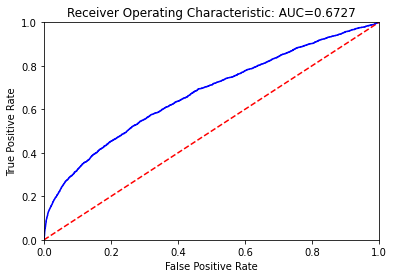

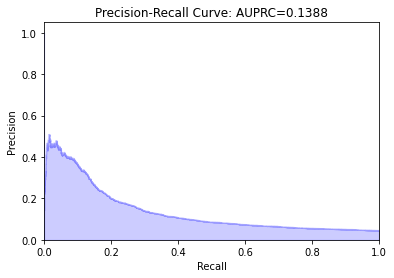

In [28]:
# To train from scratch, set load_model to None
load_model = None# "embedding_revisit_"+version 
save_model = "embedding_revisit_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', metrics.AUC(name='auprc', curve='PR'),
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [48]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(output_path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.044,0.677 (0.661-0.693),0.16 (0.138-0.179),0.571 (0.535-0.645),0.683 (0.626-0.712),5.801
1,RF,0.060,0.672 (0.654-0.68),0.147 (0.125-0.158),0.57 (0.552-0.652),0.688 (0.599-0.69),49.043
2,GB,0.041,0.698 (0.681-0.713),0.165 (0.147-0.181),0.616 (0.576-0.673),0.667 (0.609-0.709),43.840
3,MLP,0.027,0.694 (0.681-0.706),0.162 (0.144-0.18),0.628 (0.591-0.659),0.66 (0.615-0.69),64.869


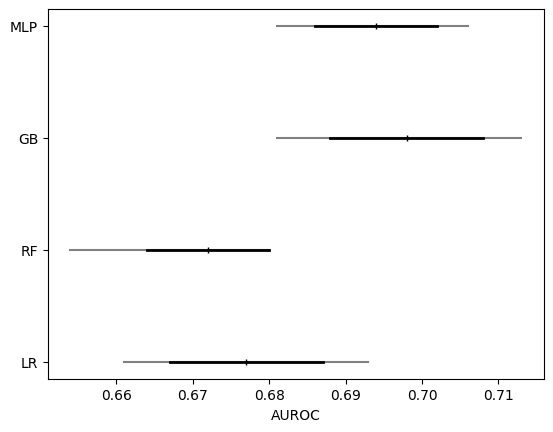

In [49]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_72h.eps', my_path = output_path) 

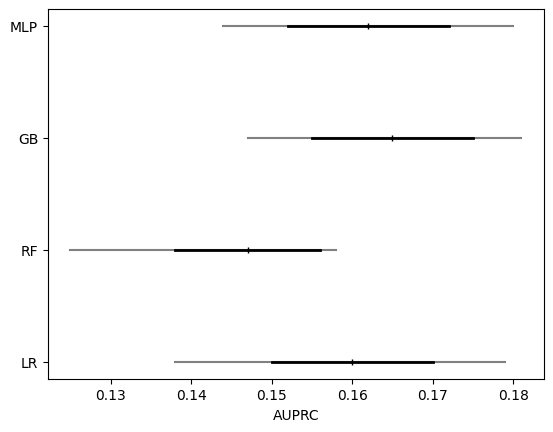

In [50]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_72h.eps', my_path = output_path)

In [51]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(output_path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
64,ed_los,0.099723
0,age,0.080681
62,ed_sbp_last,0.077494
59,ed_heartrate_last,0.075554
63,ed_dbp_last,0.075062
58,ed_temperature_last,0.064987
66,n_medrecon,0.050532
11,triage_pain,0.041978
65,n_med,0.038719
61,ed_o2sat_last,0.038061
